# Planificación del proyecto <a name="Planificacion"></a>

* [Planificación del proyecto](#Planificacion)
* [Entenidimiento del negocio](#Entenidimiento)
* [Comprensión de los datos](#Comprension)
    * [Importamos librerias](#Importamos)
    * [Cargamos el dataset](#Cargamos)
* [Preparación de los datos](#Preparacion)
* [Modelado Machinel Learning](#ModeladoML)
    * [Linear Regression](#LinearR)
    * [Ridge Regression](#Ridge)
    * [Polynomial Regression](#Polynomial)
    * [Random forest regressor](#Polynomial)
* [Modelado Deep Learning](#ModeladoDL)
* [Evaluación](#Evaluacion)
* [Subir el modelo a Kaggle](#Subir)

## Entenidimiento del negocio <a name="Entenidimiento"></a>

En esta práctica se deben estimar los costes médidos de diferentes pacientes usando un modelo de Machine Learning, dicha practica se podrá constrastar con las compañeras en la competición de Kaggle.
https://www.kaggle.com/c/estimacin-de-costes-mdicos-sic-ed2-2021/overview

## Comprensión de los datos <a name="Comprension"></a>

Nos han dado dos ficheros csv divididos en test y train.
Las columnas que contienen son las siguientes:
- id: columna identificativa para PK
- age: edad del principal beneficiario del seguro médico.
- sex: sexo del tomador del seguro médico.
- bmi: indice de masa corporal.
- children: número de hijos cubiertos por el seguro médico / número de descendientes.
- smoker: fumador.
- region: área residencial del beneficiario del seguro médico.
- charges: costes médicos cargados a la aseguradora. Dicha columna no la tiene test.

A continuación cargaremos los datos para su correspondiente procesamiento.

### Importamos librerias <a name="Importamos"></a>

In [17]:
import pandas as pd
import numpy as np

from sklearn import datasets,decomposition
from sklearn import metrics, preprocessing
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import adam_v2

import matplotlib.pyplot as plt

### Cargamos el dataset <a name="Cargamos"></a>

En este caso tenemos el dataset dividido en dos ficheros, la parte de entrenamiento en _train.csv_ y la parte de validación en _test.csv_, por lo tanto creamos dos variables para ellos y hacemos drop de la PK ya que no es necesaria.

In [2]:
#Parte para el entrenamiento
dataset_train = pd.read_csv('train.csv')
#dataset_train = dataset_train.drop('id', 1) # Para el entrenamiento no usamos los ids

#Parte para la validacion
dataset_test = pd.read_csv('test.csv')
#dataset_test = dataset_test.drop('id', 1) # Para la validacion no usamos los ids

dataset_train.head()
#dataset_test.head()

id  age     sex     bmi  children smoker     region      charges
0  1229   58    male  30.305         0     no  northeast  11938.25595
1  1073   54  female  28.880         2     no  northeast  12096.65120
2   768   64  female  39.700         0     no  southwest  14319.03100
3   606   27  female  25.175         0     no  northeast   3558.62025
4   342   60  female  27.550         0     no  northeast  13217.09450

Podemos comprobar que tenemos tres variables que no son númericas que son ``sex``, ``smoker`` y ``region``. De las cuales ``sex`` y ``smoker`` son variables binarias, a continuación comprobamos los datos que puede tener ``region`` para saber como prepararla en el siguiente paso.

In [3]:
dataset_train['region'].value_counts()

southeast    251
northeast    235
northwest    231
southwest    219
Name: region, dtype: int64

In [4]:
dataset_train['sex'].value_counts()

male      481
female    455
Name: sex, dtype: int64

In [5]:
dataset_train['smoker'].value_counts()

no     733
yes    203
Name: smoker, dtype: int64

Comprobamos que en este caso, region tiene cuatro posibilidades, será tratada en la siguiente fase.

## Preparación de los datos <a name="Preparacion"></a>

Para tener todas nuestras variables de forma numerica, pasaremos las mencionadas anteriormente por un **LabelEncoder**.

In [6]:
le = preprocessing.LabelEncoder()
# Para la parte de entrenamiento
dataset_train['sex'] = le.fit_transform(dataset_train['sex'])
dataset_train['smoker'] = le.fit_transform(dataset_train['smoker'])
dataset_train['region'] = le.fit_transform(dataset_train['region'])

# Para la parte de validación
dataset_test['sex'] = le.fit_transform(dataset_test['sex'])
dataset_test['smoker'] = le.fit_transform(dataset_test['smoker'])
dataset_test['region'] = le.fit_transform(dataset_test['region'])

dataset_train.head()

id  age  sex     bmi  children  smoker  region      charges
0  1229   58    1  30.305         0       0       0  11938.25595
1  1073   54    0  28.880         2       0       0  12096.65120
2   768   64    0  39.700         0       0       3  14319.03100
3   606   27    0  25.175         0       0       0   3558.62025
4   342   60    0  27.550         0       0       0  13217.09450

Como vemos a continuación, ha dejado de tener la cadena de texto y ha pasado a tener un número categorico. 

In [7]:
dataset_train['region'].value_counts()

2    251
0    235
1    231
3    219
Name: region, dtype: int64

In [8]:
dataset_train['sex'].value_counts()

1    481
0    455
Name: sex, dtype: int64

In [9]:
dataset_train['smoker'].value_counts()

0    733
1    203
Name: smoker, dtype: int64

A continuación realizaremos un **MinMaxScaler** para normalizar las variables y que ninguna categoría de una columna tenga más peso que otra, para así entrenar a nuestro modelo correctamente.

In [10]:
dataset_train.iloc[:,1:-1]

age  sex     bmi  children  smoker  region
0     58    1  30.305         0       0       0
1     54    0  28.880         2       0       0
2     64    0  39.700         0       0       3
3     27    0  25.175         0       0       0
4     60    0  27.550         0       0       0
..   ...  ...     ...       ...     ...     ...
931   60    0  32.450         0       1       2
932   62    0  39.160         0       0       2
933   55    0  29.830         0       0       0
934   20    0  33.300         0       0       3
935   57    1  42.130         1       1       2

[936 rows x 6 columns]

In [11]:
# Parte para el entrenamiento
sc_train = MinMaxScaler()
sc_train.fit(dataset_train.iloc[:,1:-1]) # Se ajusta el reescalador, y omitimos la columna de id, para que no la normalice
dataset_train[['age','sex','bmi','children','smoker','region']] = sc_train.transform(dataset_train[['age','sex','bmi','children','smoker','region']])

#Parte para validacion
sc_test = MinMaxScaler()
sc_test.fit(dataset_test.iloc[:,1:]) # Se ajusta el reescalador
dataset_test[['age','sex','bmi','children','smoker','region']] = sc_test.transform(dataset_test[['age','sex','bmi','children','smoker','region']])

In [12]:
dataset_train

id       age  sex       bmi  children  smoker    region      charges
0    1229  0.869565  1.0  0.377184       0.0     0.0  0.000000  11938.25595
1    1073  0.782609  0.0  0.337341       0.4     0.0  0.000000  12096.65120
2     768  1.000000  0.0  0.639871       0.0     0.0  1.000000  14319.03100
3     606  0.195652  0.0  0.233748       0.0     0.0  0.000000   3558.62025
4     342  0.913043  0.0  0.300154       0.0     0.0  0.000000  13217.09450
..    ...       ...  ...       ...       ...     ...       ...          ...
931   845  0.913043  0.0  0.437159       0.0     1.0  0.666667  45008.95550
932   928  0.956522  0.0  0.624773       0.0     0.0  0.666667  13470.80440
933  1091  0.804348  0.0  0.363903       0.0     0.0  0.000000  11286.53870
934  1268  0.043478  0.0  0.460925       0.0     0.0  1.000000   1880.48700
935   530  0.847826  1.0  0.707815       0.2     1.0  0.666667  48675.51770

[936 rows x 8 columns]

In [13]:
#Otra forma de realizar el MinMaxScaler, esta variable no se utilizara en este ejercicio
scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(dataset_train.iloc[:,1:]), columns=['age','sex','bmi','children','smoker','region','charges'], index=dataset_train.id)

Teniendo el dataset cargado y las variables normalizadas, ahora tendremos que separar la columna a predecir, que en este caso es ``charges`` y dividir nuestro dataset en las variables correspondientes. Tales como:
- X_train: Será nuestra fuente de datos para el entrenamiento.
- Y_train: Será nuestra fuente de datos de entrenamiento para la variable a predecir.
- X_test: Será nuestra fuente de datos de validación, la cual no le ofreceremos la variable a predecir.
- Y_test: Será nuestra fuente de datos de validación, sirve para obtener el rendimiento de nuestro modelo.

In [14]:
#MinMaxScaler nos devuelve un numpy array, lo pasamos a pandas DataFrame para poder trabajar mejor
dataset_train = pd.DataFrame(dataset_train)
dataset_test = pd.DataFrame(dataset_test)

# Se separa la columna a predecir
X_train = dataset_train.iloc[:,1:-1] #Ignoramos la columna de Id 
Y_train = dataset_train.iloc[:,-1]
X_test = dataset_test

In [15]:
Y_train

0      11938.25595
1      12096.65120
2      14319.03100
3       3558.62025
4      13217.09450
          ...     
931    45008.95550
932    13470.80440
933    11286.53870
934     1880.48700
935    48675.51770
Name: charges, Length: 936, dtype: float64

## Modelado Machinel Learning <a name="ModeladoML"></a>

Tenemos ya los datos correctos y normalizados, ahora toca elegir el tipo de modelo que vamos a desarrollar y la estructura que más se adecue, probaremos varias para constrastar datos.

En este caso, al tener claramente una variable de salida no categorica, por lo tanto descaramos _Clasificacion_ , como tenemos variable de salida, descartamos _Clustering_, nos quedaría la opción más sensata que es **Regresion**.



### Linear Regression <a name="LinearR"></a>

Realizaremos este primer modelo, asumiendo que existe una correlación lineal entre los datos. 

In [16]:
reg = LinearRegression().fit(X_train, Y_train)
print("Con los datos de entrenamiento: ", reg.score(X_train, Y_train)) #Normalmente lo comprobaria con el score de los
#datos de test, para comprobar el overfitting pero acutalmente no dispongo de Y_test

Con los datos de entrenamiento:  0.7496636971119938


In [17]:
reg.intercept_

-2145.1746072827045

Como norma general:

- Los valores positivos en estos coeficientes significan una correlación directa entre los valores de las características que representan los coeficientes y el coste medico a la aseguradora, mientras que los valores negativos representan una correlación inversa.
- La magnitud de los coeficientes miden el grado de aportación, positiva o negativa, de una determinada característica.


In [18]:
reg.coef_

array([12435.62723763,    26.01948286, 12478.8115806 ,  1517.91753992,
       23754.01188298,  -624.48267979])

In [19]:
pd.DataFrame(data=np.expand_dims(reg.coef_, axis=0), columns=['age','sex','bmi','children','smoker','region'])

age        sex           bmi    children        smoker     region
0  12435.627238  26.019483  12478.811581  1517.91754  23754.011883 -624.48268

Como vemos los datos de **intercept** y los **coeficientes** son bastante exagerados, esto declara un overfitting que es el principal problema de este modelo, se podría solucionar con _Ridge Regression_ hagamos una prueba con el antes de pasar al siguiente modelo.

La subida a Kaggle ha dado un **score: 0.72993**

### Ridge Regression <a name="Ridge"></a>

#### Prueba 1 de encontrar el mejor alpha

Para mejorar el modelo anterior y evitar que los outlayers afecten a nuestro resultado, vamos a quitarlos con **StandardScaler**.

También aplicaremos **PCA** su objetivo es encontrar las columnas principales y reducir la dimensionalidad del conjunto de datos .

In [20]:
std_slc = StandardScaler()
pca = decomposition.PCA() #Decomposition reduce el numero de columnas, es uno de los PCA que he entendido, 
#Es probable que exista un PCA mejor para este dataset
ridge = Ridge()

In [21]:
pipe = Pipeline(steps=[("std_slc", std_slc),
                       ("pca", pca),
                       ("ridge", ridge)])

In [22]:
n_components = list(range(1,X_train.shape[1]+1,1))
n_components

[1, 2, 3, 4, 5, 6]

Como en casi todos los modelos, existen distintas arquitecturas para el mismo modelo, cada una con sus ventajas y desventajas, añadiremos todas para que nos ofrezca la que mejor resultado de. 

Puedes mirar el funcionamiento de cada una aquí https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge

Ha raíz de esto, he decidido quitar _lbfgs_ ya que aunque los datos estan normalizados, no están normalizados por el método, por lo tanto, lo he desechado para las pruebas.

In [23]:
#Creamos una lista con todos los parametros de Ridge Regression
solver = ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]

In [24]:
parameters = dict(pca__n_components=n_components,
                  ridge__normalize=[True, False],
                  ridge__alpha=np.arange(1e-3,5,0.05),
                  ridge__solver=solver)

In [25]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, Y_train) #Pasamos las variables de train, ya que nuestro test no tenemos disponible la Y

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()), ('ridge', Ridge())]),
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6],
                         'ridge__alpha': array([1.000e-03, 5.100e-02, 1.010e-01, 1.510e-01, 2.010e-01, 2.510e-01,
       3.010e-01, 3.510e-01, 4.010e-01, 4.510e-01, 5.010e-01, 5.510e-01,
       6.010e-01, 6.510e-01, 7.010e-01, 7.510e-01, 8.010e-01, 8.510e-01,...
       3.601e+00, 3.651e+00, 3.701e+00, 3.751e+00, 3.801e+00, 3.851e+00,
       3.901e+00, 3.951e+00, 4.001e+00, 4.051e+00, 4.101e+00, 4.151e+00,
       4.201e+00, 4.251e+00, 4.301e+00, 4.351e+00, 4.401e+00, 4.451e+00,
       4.501e+00, 4.551e+00, 4.601e+00, 4.651e+00, 4.701e+00, 4.751e+00,
       4.801e+00, 4.851e+00, 4.901e+00, 4.951e+00]),
                         'ridge__normalize': [True, False],
                         'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                         

In [26]:
print("Best Number Of Components:", clf_GS.best_estimator_.get_params()["pca__n_components"])
print(); print(clf_GS.best_estimator_.get_params()["ridge"])

Best Number Of Components: 6

Ridge(alpha=3.851, solver='saga')


In [34]:
ridge = Ridge(alpha= 3.851, solver='saga').fit(X_train, Y_train)
print("Con los datos de entrenamiento: ", ridge.score(X_train, Y_train))

Con los datos de entrenamiento:  0.7486545086160235


#### Prueba 2 de encontrar el mejor alpha

In [28]:
ridge_2 = Ridge() #Creamos nuestro modelo

rango_alpha = {'alpha':np.arange(1e-3,5,0.05)}#Establecemos el rango con el que probar para nuestro alpha

ridge_regressor = GridSearchCV(ridge_2, rango_alpha, scoring="r2", cv = 10) #Creamos el GridSearch para que pruebe

ridge_regressor.fit(X_train,Y_train)

#Obtenemos los datos que son mejores
ridge_best_params_ = ridge_regressor.best_params_
ridge_best_score_ = -ridge_regressor.best_score_
print(ridge_best_params_); print(ridge_best_score_)

{'alpha': 0.901}
-0.7403519346584229


#### Conclusion de Ridge Regression

Aunque normalmente suele ser una buena opción usar algun derivado de Linear Regression mejor que el puro,aun usando dos técnicas para obtener la mejor combinación de hiperparametros, no he conseguido mejorar el score de la versión pura de LinearRegression.

    Aún así, dejo documentado las pruebas, por si fuese un error de ejecución o código en este caso.

### Polynomial Regression <a name="Polynomial"></a>

Debido a que mis pruebas con Ridge regression no han salido como esperaba, he investigado formas distintas de regresiones, y he encontrado que la polinomica suele dar buenos resultados, por lo tanto voy a probar por primera vez este modelo.

La Regresión Polinomial es un caso especial de la regresión lineal, extiende el modelo lineal al agregar predictores adicionales, obtenidos al elevar cada uno de los predictores originales a una potencia.

#### Prueba 1 modelo polinómico

In [48]:
poly = PolynomialFeatures(degree = 2) #Elevamos al cuadrado
x_poly = poly.fit_transform(X_train)

X_train_poly,X_test_poly,Y_train_poly,Y_test_poly = train_test_split(x_poly,Y_train)

plreg = LinearRegression().fit(X_train_poly,Y_train_poly)

In [49]:
print(plreg.score(X_test_poly,Y_test_poly))

0.8349931515155394


In [50]:
print(plreg.score(X_train_poly,Y_train_poly))

0.8440412274954883


Aunque este modelo parece funcionar correctamente, tengo problemas al intentar pasarlo a Kaggle, que lo he intentado hacer de la siguiente manera.

In [64]:
print(X_test_quad)

[[1.         0.56521739 1.         ... 0.         0.         0.        ]
 [1.         0.45652174 0.         ... 0.         0.         1.        ]
 [1.         0.36956522 0.         ... 0.         0.         0.11111111]
 ...
 [1.         0.36956522 1.         ... 0.         0.         0.44444444]
 [1.         0.63043478 1.         ... 1.         1.         1.        ]
 [1.         0.39130435 0.         ... 0.         0.         0.44444444]]


In [54]:
len(Y_test_pred.flatten())

234

In [58]:
# Creamos el dataframe para mandarlo despues al CSV
submission = pd.DataFrame({'id': X_test_quad, 'charges': Y_test_pred})
# Pasamos el dataframe a CSV
submission.to_csv('submission.csv', index=False)

ValueError: Data must be 1-dimensional

Mi problema aquí es tanto con la dimensionalidad de X_test_quad, ya que ha dejado de ser un dataframe y ha pasado a ser un numpy array, por lo tanto también hemos perdido el valor de ID (ya que de todas maneras x_poly bebe de X_train que le quitamos el ID previamente). 

Vamos a intentarlo de otra manera.

#### Prueba 2 modelo polinómico 

Siguiendo el consejo de Raúl, que comenta lo siguiente:
   
    Tienes que aplicar la misma transformación de PolynomialFeatures sobre X_test para que genere las variables al cuadrado poly_test = poly.fit_transform(X_test). Una vez tienes poly_test ya puedes hacer el predict sobre él y crear un nuevo DataFrame con la columna de predicciones y la columna id, igual que hacías con el X_test sin ser polinómico.

In [80]:
poly = PolynomialFeatures(degree = 2) #Elevamos al cuadrado
poly_test = poly.fit_transform(X_test.iloc[:,1:]) #Quitamos el id antes de pasarlo
x_poly = poly.fit_transform(X_train)

X_train_poly,X_test_poly,Y_train_poly,Y_test_poly = train_test_split(x_poly,Y_train)

plreg = LinearRegression().fit(X_train_poly,Y_train_poly)

In [81]:
print(plreg.score(X_test_poly,Y_test_poly)) #Comprobamos el resultado

0.8596156374889231


Y ahora pondremos poly_test como el predict.

In [82]:
# Utilizamos el modelo que queramos mandar a Kaggle
predicted_charges = plreg.predict(poly_test)
# Creamos el dataframe para mandarlo despues al CSV
submission = pd.DataFrame({'id': X_test.iloc[:,0:1].to_numpy().flatten(), 'charges': predicted_charges})
# Pasamos el dataframe a CSV
submission.to_csv('submission.csv', index=False)

Bien, de esta manera si que hemos conseguido subirlo correctamente a Kaggle y el resultado es mejor que las regresiones lineales realizadas anteriormente, he conseguido un **score de 0.82042**

### Random Forest Regressor <a name="RandomForest"></a>

Este modelo lo he realizado después de mis intentos con DL, ya que he visto que los datos son más lineales y funcionan mejor con este tipo de modelos, intentaré primero realizar un modelo básico y a partir de ahí optimizar sus parámetros.

In [29]:
rf = RandomForestRegressor()
param_grid = {
   'n_estimators': [100, 200, 350, 500],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [3,4,5,6],
   'criterion' :['mse', 'mae']
}
GSCV = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,scoring='r2', verbose= 3)
GSCV.fit(X_train, Y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=100; total time=   0.0s
[CV 2/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=100; total time=   0.0s
[CV 3/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=100; total time=   0.0s
[CV 4/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=100; total time=   0.0s
[CV 5/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=100; total time=   0.0s
[CV 1/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=200; total time=   0.1s
[CV 2/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=200; total time=   0.1s
[CV 3/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=200; total time=   0.1s
[CV 4/5] END criterion=mse, max_depth=3, max_features=auto, n_estimators=200; total time=   0.1s
[CV 5/5] END criterion=mse, max_depth=3, max_features=auto, n_est

[CV 1/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV 2/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV 3/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV 4/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV 5/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV 1/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=350; total time=   0.2s
[CV 2/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=350; total time=   0.2s
[CV 3/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=350; total time=   0.2s
[CV 4/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=350; total time=   0.2s
[CV 5/5] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=350; total time=   0.2s
[CV 1/5] END criterion=mse, ma

[CV 1/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=350; total time=   0.2s
[CV 2/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=350; total time=   0.2s
[CV 3/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=350; total time=   0.2s
[CV 4/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=350; total time=   0.2s
[CV 5/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=350; total time=   0.2s
[CV 1/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=500; total time=   0.4s
[CV 2/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=500; total time=   0.4s
[CV 3/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=500; total time=   0.4s
[CV 4/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=500; total time=   0.4s
[CV 5/5] END criterion=mse, max_depth=5, max_features=log2, n_estimators=500; total time=   0.4s
[CV 1/5] END criterion=mse, ma

[CV 1/5] END criterion=mae, max_depth=3, max_features=auto, n_estimators=500; total time=   1.8s
[CV 2/5] END criterion=mae, max_depth=3, max_features=auto, n_estimators=500; total time=   1.9s
[CV 3/5] END criterion=mae, max_depth=3, max_features=auto, n_estimators=500; total time=   1.9s
[CV 4/5] END criterion=mae, max_depth=3, max_features=auto, n_estimators=500; total time=   1.9s
[CV 5/5] END criterion=mae, max_depth=3, max_features=auto, n_estimators=500; total time=   1.9s
[CV 1/5] END criterion=mae, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV 2/5] END criterion=mae, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV 3/5] END criterion=mae, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV 4/5] END criterion=mae, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV 5/5] END criterion=mae, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV 1/5] END criterion=mae, ma

[CV 1/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=100; total time=   0.1s
[CV 2/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=100; total time=   0.1s
[CV 3/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=100; total time=   0.1s
[CV 4/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=100; total time=   0.2s
[CV 5/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=100; total time=   0.1s
[CV 1/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV 2/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV 3/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV 4/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV 5/5] END criterion=mae, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV 1/5] END criterion=mae, ma

[CV 1/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=200; total time=   1.0s
[CV 2/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=200; total time=   1.0s
[CV 3/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=200; total time=   1.0s
[CV 4/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=200; total time=   1.1s
[CV 5/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=200; total time=   1.0s
[CV 1/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=350; total time=   1.9s
[CV 2/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=350; total time=   1.9s
[CV 3/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=350; total time=   1.8s
[CV 4/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=350; total time=   1.9s
[CV 5/5] END criterion=mae, max_depth=6, max_features=auto, n_estimators=350; total time=   1.9s
[CV 1/5] END criterion=mae, ma

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 350, 500]},
             scoring='r2', verbose=3)

In [30]:
GSCV.best_params_ 

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 350}

In [31]:
GSCV.best_score_

0.8500425268742863

In [33]:
pd.DataFrame(GSCV.cv_results_).sort_values(by=['rank_test_score']).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.345330      0.003946         0.020173        0.000739   
15       0.522777      0.016620         0.031722        0.004435   
13       0.194506      0.002257         0.012765        0.001158   
86       1.960004      0.024258         0.022140        0.001156   
87       2.898700      0.061073         0.030745        0.001217   

   param_criterion param_max_depth param_max_features param_n_estimators  \
14             mse               4               auto                350   
15             mse               4               auto                500   
13             mse               4               auto                200   
86             mae               6               auto                350   
87             mae               6               auto                500   

                                               params  split0_test_score  \
14  {'criterion': 'mse', 'max_depth': 4, 'max_feat...           0.863037   
15  {'criterion': 'mse', 'max_depth': 4, 'max_feat...           0.863008   
13  {'criterion': 'mse', 'max_depth': 4, 'max_feat...           0.863061   
86  {'criterion': 'mae', 'max_depth': 6, 'max_feat...           0.862961   
87  {'criterion': 'mae', 'max_depth': 6, 'max_feat...           0.861855   

    split1_test_score  split2_test_score  split3_test_score  \
14           0.838731           0.866763           0.880717   
15           0.837872           0.867015           0.881839   
13           0.837581           0.866466           0.880729   
86           0.847060           0.865832           0.877529   
87           0.847499           0.864840           0.877945   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
14           0.800964         0.850043        0.028021                1  
15           0.800134         0.849974        0.028657                2  
13           0.801967         0.849961        0.027740                3  
86           0.793974         0.849471        0.029403                4  
87           0.794360         0.849300        0.029125                5

In [34]:
rf_model = GSCV.best_estimator_

In [35]:
# Utilizamos el modelo que queramos mandar a Kaggle
predicted_charges = rf_model.predict(X_test.iloc[:,1:])
# Creamos el dataframe para mandarlo despues al CSV
submission = pd.DataFrame({'id': X_test.iloc[:,0:1].to_numpy().flatten(), 'charges': predicted_charges})
# Pasamos el dataframe a CSV
submission.to_csv('submission.csv', index=False)

## Modelado Deep Learning <a name="ModeladoDL"></a>

Elegiremos primero el tipo de DL:
 - **Red Neuronal Convolucional (CNN)**, este tipo de modelo esta diseñado exclusivamente para el reconocimiento de imagenes, por lo tanto lo descarto.
 - **Red Generativa Antagónica (GAN)**, este tipo de modelo esta diseñado exclusivamente para el reconocimiento de imagenes y generación de las mismas, por lo tanto se descarta.

#### Prueba 1

Analizando nuestra variable de salida charges, es logico pensar que no necesitamos que calcule valores negativos,ya que una aseguradora médica no va a pagar a sus clientes por ser clientes, por tanto, se ha decidido tener nuestra activacion de tipo 'relu' la cual no acepta valores negativos, solo positivos, como se muestra en la siguiente gráfica.

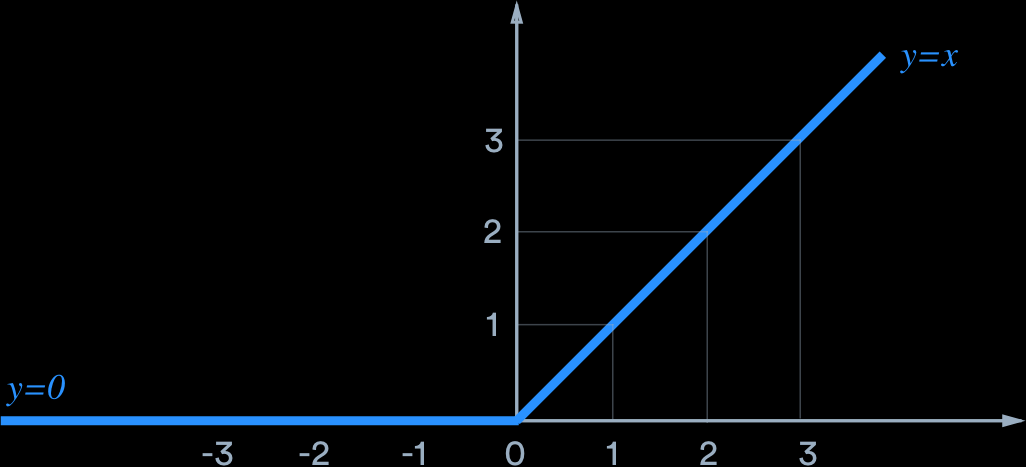

In [33]:
insurance = Sequential([
      Dense(10, activation='relu'),
      Dense(1, activation='relu'),
])

insurance.compile(loss='mae',
                  optimizer='adam',
                  metrics=['mae'])
#Es necesario dividir el dataset de train para obtener la Y de validation, ya que en test no tenemos Y
X_train_rnn,X_test_rnn,Y_train_rnn,Y_test_rnn = train_test_split(X_train,Y_train)

history = insurance.fit(X_train_rnn,
                        Y_train_rnn, validation_data=(X_test_rnn, Y_test_rnn),
                        epochs=40, verbose=1)



Epoch 1/40
22/22 [==============================] - 0s 10ms/step - loss: 13443.8672 - mae: 13443.8672 - val_loss: 13841.7881 - val_mae: 13841.7881
Epoch 2/40
22/22 [==============================] - 0s 2ms/step - loss: 13443.7568 - mae: 13443.7568 - val_loss: 13841.6426 - val_mae: 13841.6426
Epoch 3/40
22/22 [==============================] - 0s 1ms/step - loss: 13443.5928 - mae: 13443.5928 - val_loss: 13841.4727 - val_mae: 13841.4727
Epoch 4/40
22/22 [==============================] - 0s 1ms/step - loss: 13443.4072 - mae: 13443.4072 - val_loss: 13841.2734 - val_mae: 13841.2734
Epoch 5/40
22/22 [==============================] - 0s 1ms/step - loss: 13443.1729 - mae: 13443.1729 - val_loss: 13840.9951 - val_mae: 13840.9951
Epoch 6/40
22/22 [==============================] - 0s 1ms/step - loss: 13442.8691 - mae: 13442.8691 - val_loss: 13840.6543 - val_mae: 13840.6543
Epoch 7/40
22/22 [==============================] - 0s 1ms/step - loss: 13442.5059 - mae: 13442.5059 - val_loss: 13840.2422

In [34]:
def plot_train_val(history):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    
    ax1.plot(history.history['loss'], label='loss (train)')
    ax1.plot(history.history['val_loss'], label='loss (val)')
    ax1.set_title('Loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax2.plot(history.history['accuracy'], label='accuracy (train)')
    ax2.plot(history.history['val_accuracy'], label='accuracy (val)')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="lower right")
    ax1.grid()
    ax2.grid()
    plt.plot()

KeyError: 'accuracy'

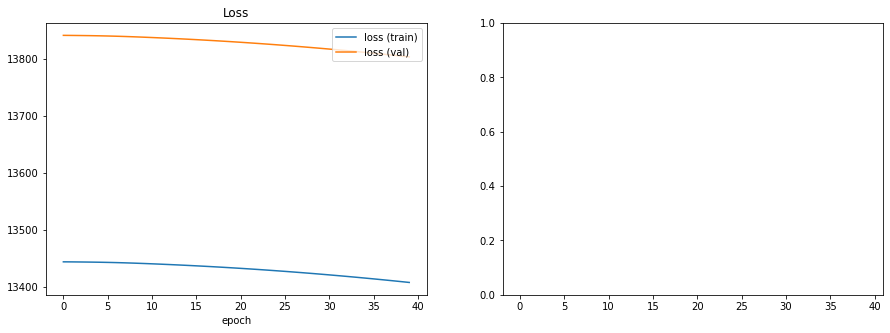

In [35]:
plot_train_val(history)

No termino de entender del todo el porque no existe variable de accuracy, habiendo dividido el dataset de train para tener la partición de validation, en mi conocimiento, debería existir dicha variable, por lo tanto voy a probar de otra manera.

Dejo la gráfica obtenida a continuación por si acaso no se visualizase en la entrega del ejercicio:
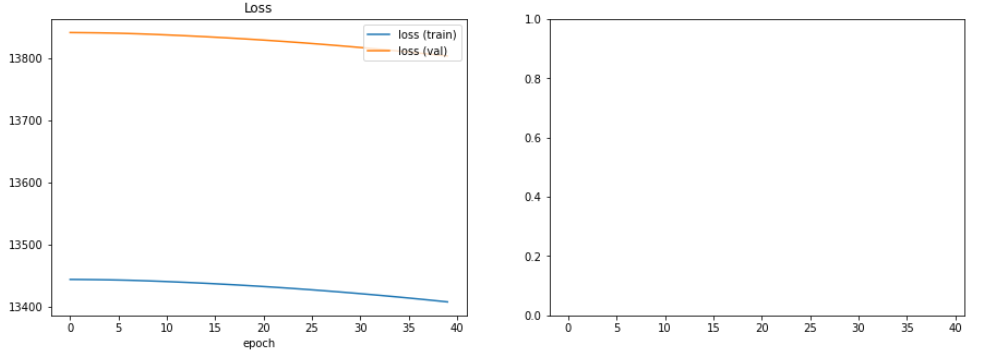

#### Prueba 2

Por el mismo problema comentado anteriormente, dividimos el dataset de train para poder tener validación.

In [37]:
X_train_1 = dataset_train.iloc[:,0:-1] #Ignoramos la columna de Id 
Y_train_1 = dataset_train.iloc[:,-1]
X_train_rnn,X_test_rnn,Y_train_rnn,Y_test_rnn = train_test_split(X_train_1,Y_train_1)

In [38]:
def neural_network(neuronas_capa_1 = 25, neuronas_capa_2 = 15):
    neural_net = Sequential()
    neural_net.add(Dense(neuronas_capa_1, input_dim=6, activation='relu'))
    neural_net.add(Dense(neuronas_capa_2, activation='relu'))
    neural_net.add(Dense(1, activation='relu'))

    neural_net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return neural_net

neu_net = KerasRegressor(build_fn=neural_network, epochs = 500)

parameters = {'neuronas_capa_1':[25, 50, 10], 'neuronas_capa_2':[25, 50, 10], 'batch_size':[20, 30]}

cv = GridSearchCV(neu_net, parameters, refit=True, scoring='r2', verbose= 3)
#Este caso es para poder comprobar el accuracy
cv.fit(X_train_rnn.iloc[:,1:], Y_train_rnn)

<ipython-input-38-c3a0c5a761f8>:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  neu_net = KerasRegressor(build_fn=neural_network, epochs = 500)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 1/500
29/29 [==============================] - 0s 1ms/step - loss: 336525696.0000 - mae: 13719.3164
Epoch 2/500
29/29 [==============================] - 0s 715us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 3/500
29/29 [==============================] - 0s 784us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 4/500
29/29 [==============================] - 0s 784us/step - loss: 336525696.0000 - mae: 13719.3145
Epoch 5/500
29/29 [==============================] - 0s 819us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 6/500
29/29 [==============================] - 0s 855us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 7/500
29/29 [==============================] - 0s 818us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 8/500
29/29 [==============================] - 0s 766us/step - loss: 336525696.0000 - mae: 13719.3135
Epoch 9/500
29/29 [==============================] - 0s 677us/step - loss: 33

29/29 [==============================] - 0s 748us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 149/500
29/29 [==============================] - 0s 784us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 150/500
29/29 [==============================] - 0s 662us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 151/500
29/29 [==============================] - 0s 748us/step - loss: 336525664.0000 - mae: 13719.3164
Epoch 152/500
29/29 [==============================] - 0s 712us/step - loss: 336525600.0000 - mae: 13719.3135
Epoch 153/500
29/29 [==============================] - 0s 677us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 154/500
29/29 [==============================] - 0s 641us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 155/500
29/29 [==============================] - 0s 641us/step - loss: 336525728.0000 - mae: 13719.3154
Epoch 156/500
29/29 [==============================] - 0s 677us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 157/500
29/29 [===

29/29 [==============================] - 0s 707us/step - loss: 336525632.0000 - mae: 13719.3125
Epoch 297/500
29/29 [==============================] - 0s 784us/step - loss: 336525696.0000 - mae: 13719.3145
Epoch 298/500
29/29 [==============================] - 0s 641us/step - loss: 336525696.0000 - mae: 13719.3145
Epoch 299/500
29/29 [==============================] - 0s 631us/step - loss: 336525696.0000 - mae: 13719.3145
Epoch 300/500
29/29 [==============================] - 0s 697us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 301/500
29/29 [==============================] - 0s 641us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 302/500
29/29 [==============================] - 0s 677us/step - loss: 336525600.0000 - mae: 13719.3154
Epoch 303/500
29/29 [==============================] - 0s 641us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 304/500
29/29 [==============================] - 0s 641us/step - loss: 336525600.0000 - mae: 13719.3145
Epoch 305/500
29/29 [===

29/29 [==============================] - 0s 678us/step - loss: 336525600.0000 - mae: 13719.3125
Epoch 445/500
29/29 [==============================] - 0s 677us/step - loss: 336525632.0000 - mae: 13719.3154
Epoch 446/500
29/29 [==============================] - 0s 641us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 447/500
29/29 [==============================] - 0s 712us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 448/500
29/29 [==============================] - 0s 641us/step - loss: 336525600.0000 - mae: 13719.3125
Epoch 449/500
29/29 [==============================] - 0s 677us/step - loss: 336525632.0000 - mae: 13719.3164
Epoch 450/500
29/29 [==============================] - 0s 677us/step - loss: 336525728.0000 - mae: 13719.3145
Epoch 451/500
29/29 [==============================] - 0s 641us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 452/500
29/29 [==============================] - 0s 748us/step - loss: 336525696.0000 - mae: 13719.3145
Epoch 453/500
29/29 [===

29/29 [==============================] - 0s 784us/step - loss: 91069632.0000 - mae: 7712.8994
Epoch 93/500
29/29 [==============================] - 0s 748us/step - loss: 90539280.0000 - mae: 7679.1104
Epoch 94/500
29/29 [==============================] - 0s 712us/step - loss: 90035232.0000 - mae: 7644.3242
Epoch 95/500
29/29 [==============================] - 0s 712us/step - loss: 89568528.0000 - mae: 7635.7373
Epoch 96/500
29/29 [==============================] - 0s 748us/step - loss: 89040888.0000 - mae: 7609.8652
Epoch 97/500
29/29 [==============================] - 0s 784us/step - loss: 88541608.0000 - mae: 7585.5928
Epoch 98/500
29/29 [==============================] - 0s 642us/step - loss: 88077232.0000 - mae: 7571.8403
Epoch 99/500
29/29 [==============================] - 0s 677us/step - loss: 87560360.0000 - mae: 7536.2246
Epoch 100/500
29/29 [==============================] - 0s 734us/step - loss: 87035240.0000 - mae: 7514.9937
Epoch 101/500
29/29 [============================

29/29 [==============================] - 0s 676us/step - loss: 51411180.0000 - mae: 5901.0317
Epoch 169/500
29/29 [==============================] - 0s 748us/step - loss: 51009736.0000 - mae: 5850.7480
Epoch 170/500
29/29 [==============================] - 0s 748us/step - loss: 50647504.0000 - mae: 5807.3994
Epoch 171/500
29/29 [==============================] - 0s 701us/step - loss: 50259004.0000 - mae: 5773.3950
Epoch 172/500
29/29 [==============================] - 0s 712us/step - loss: 49877160.0000 - mae: 5739.4404
Epoch 173/500
29/29 [==============================] - 0s 642us/step - loss: 49567044.0000 - mae: 5759.4053
Epoch 174/500
29/29 [==============================] - 0s 641us/step - loss: 49115112.0000 - mae: 5713.1768
Epoch 175/500
29/29 [==============================] - 0s 654us/step - loss: 48735384.0000 - mae: 5704.9048
Epoch 176/500
29/29 [==============================] - 0s 766us/step - loss: 48397276.0000 - mae: 5691.0181
Epoch 177/500
29/29 [=====================

29/29 [==============================] - 0s 606us/step - loss: 37766820.0000 - mae: 4259.5581
Epoch 318/500
29/29 [==============================] - 0s 677us/step - loss: 37768856.0000 - mae: 4266.2485
Epoch 319/500
29/29 [==============================] - 0s 671us/step - loss: 37765976.0000 - mae: 4269.9106
Epoch 320/500
29/29 [==============================] - 0s 712us/step - loss: 37767872.0000 - mae: 4279.1621
Epoch 321/500
29/29 [==============================] - 0s 784us/step - loss: 37766896.0000 - mae: 4273.1450
Epoch 322/500
29/29 [==============================] - 0s 642us/step - loss: 37740720.0000 - mae: 4267.4019
Epoch 323/500
29/29 [==============================] - 0s 625us/step - loss: 37735856.0000 - mae: 4254.9741
Epoch 324/500
29/29 [==============================] - 0s 676us/step - loss: 37730776.0000 - mae: 4283.1016
Epoch 325/500
29/29 [==============================] - 0s 660us/step - loss: 37738896.0000 - mae: 4290.3398
Epoch 326/500
29/29 [=====================

29/29 [==============================] - 0s 677us/step - loss: 37204452.0000 - mae: 4232.0322
Epoch 466/500
29/29 [==============================] - ETA: 0s - loss: 41942100.0000 - mae: 4278.189 - 0s 748us/step - loss: 37208996.0000 - mae: 4228.2627
Epoch 467/500
29/29 [==============================] - 0s 721us/step - loss: 37197980.0000 - mae: 4247.3750
Epoch 468/500
29/29 [==============================] - 0s 713us/step - loss: 37220284.0000 - mae: 4242.8901
Epoch 469/500
29/29 [==============================] - 0s 675us/step - loss: 37193016.0000 - mae: 4241.7778
Epoch 470/500
29/29 [==============================] - 0s 694us/step - loss: 37199212.0000 - mae: 4242.0435
Epoch 471/500
29/29 [==============================] - 0s 683us/step - loss: 37193400.0000 - mae: 4234.6250
Epoch 472/500
29/29 [==============================] - 0s 783us/step - loss: 37215296.0000 - mae: 4242.5444
Epoch 473/500
29/29 [==============================] - 0s 641us/step - loss: 37195648.0000 - mae: 4244

29/29 [==============================] - 0s 641us/step - loss: 89143088.0000 - mae: 7518.2856
Epoch 116/500
29/29 [==============================] - 0s 677us/step - loss: 88749976.0000 - mae: 7503.4136
Epoch 117/500
29/29 [==============================] - 0s 668us/step - loss: 88340288.0000 - mae: 7479.0356
Epoch 118/500
29/29 [==============================] - 0s 780us/step - loss: 87918936.0000 - mae: 7449.2627
Epoch 119/500
29/29 [==============================] - 0s 819us/step - loss: 87473288.0000 - mae: 7442.2754
Epoch 120/500
29/29 [==============================] - 0s 677us/step - loss: 87041984.0000 - mae: 7434.3496
Epoch 121/500
29/29 [==============================] - 0s 677us/step - loss: 86625448.0000 - mae: 7414.4619
Epoch 122/500
29/29 [==============================] - 0s 712us/step - loss: 86228032.0000 - mae: 7389.0693
Epoch 123/500
29/29 [==============================] - 0s 677us/step - loss: 85784944.0000 - mae: 7380.9102
Epoch 124/500
29/29 [=====================

Epoch 191/500
29/29 [==============================] - 0s 712us/step - loss: 56679512.0000 - mae: 6100.8105
Epoch 192/500
29/29 [==============================] - 0s 769us/step - loss: 56273816.0000 - mae: 6094.7188
Epoch 193/500
29/29 [==============================] - 0s 712us/step - loss: 55936540.0000 - mae: 6081.0552
Epoch 194/500
29/29 [==============================] - 0s 677us/step - loss: 55576808.0000 - mae: 6035.9546
Epoch 195/500
29/29 [==============================] - 0s 677us/step - loss: 55174056.0000 - mae: 6029.4375
Epoch 196/500
29/29 [==============================] - 0s 748us/step - loss: 54770724.0000 - mae: 6021.3364
Epoch 197/500
29/29 [==============================] - 0s 641us/step - loss: 54418616.0000 - mae: 5990.2925
Epoch 198/500
29/29 [==============================] - 0s 819us/step - loss: 54050344.0000 - mae: 5961.5957
Epoch 199/500
29/29 [==============================] - 0s 733us/step - loss: 53665720.0000 - mae: 5979.8726
Epoch 200/500
29/29 [=======

29/29 [==============================] - 0s 641us/step - loss: 39111520.0000 - mae: 4357.5161
Epoch 342/500
29/29 [==============================] - 0s 731us/step - loss: 39121616.0000 - mae: 4365.0308
Epoch 343/500
29/29 [==============================] - 0s 641us/step - loss: 39096996.0000 - mae: 4367.0811
Epoch 344/500
29/29 [==============================] - 0s 673us/step - loss: 39100412.0000 - mae: 4354.8164
Epoch 345/500
29/29 [==============================] - 0s 677us/step - loss: 39098960.0000 - mae: 4364.9629
Epoch 346/500
29/29 [==============================] - 0s 677us/step - loss: 39084184.0000 - mae: 4357.4771
Epoch 347/500
29/29 [==============================] - 0s 748us/step - loss: 39089188.0000 - mae: 4347.2808
Epoch 348/500
29/29 [==============================] - 0s 605us/step - loss: 39064860.0000 - mae: 4348.6748
Epoch 349/500
29/29 [==============================] - 0s 677us/step - loss: 39067564.0000 - mae: 4359.6987
Epoch 350/500
29/29 [=====================

Epoch 492/500
29/29 [==============================] - 0s 875us/step - loss: 38342268.0000 - mae: 4312.5850
Epoch 493/500
29/29 [==============================] - 0s 997us/step - loss: 38339408.0000 - mae: 4311.1777
Epoch 494/500
29/29 [==============================] - 0s 1ms/step - loss: 38328424.0000 - mae: 4307.9248
Epoch 495/500
29/29 [==============================] - 0s 1ms/step - loss: 38309364.0000 - mae: 4315.6528
Epoch 496/500
29/29 [==============================] - 0s 855us/step - loss: 38317180.0000 - mae: 4317.3008
Epoch 497/500
29/29 [==============================] - 0s 890us/step - loss: 38309992.0000 - mae: 4314.9990
Epoch 498/500
29/29 [==============================] - 0s 890us/step - loss: 38314208.0000 - mae: 4310.5327
Epoch 499/500
29/29 [==============================] - 0s 926us/step - loss: 38306092.0000 - mae: 4317.4199
Epoch 500/500
29/29 [==============================] - 0s 868us/step - loss: 38304176.0000 - mae: 4313.8428
[CV 3/5] END batch_size=20, neur

29/29 [==============================] - 0s 750us/step - loss: 104013048.0000 - mae: 7994.8291
Epoch 67/500
29/29 [==============================] - 0s 730us/step - loss: 103465096.0000 - mae: 7981.4751
Epoch 68/500
29/29 [==============================] - 0s 668us/step - loss: 102834528.0000 - mae: 7979.3140
Epoch 69/500
29/29 [==============================] - 0s 694us/step - loss: 102250120.0000 - mae: 7955.6177
Epoch 70/500
29/29 [==============================] - 0s 677us/step - loss: 101619264.0000 - mae: 7954.4360
Epoch 71/500
29/29 [==============================] - 0s 712us/step - loss: 101035912.0000 - mae: 7945.2437
Epoch 72/500
29/29 [==============================] - 0s 734us/step - loss: 100464240.0000 - mae: 7926.7275
Epoch 73/500
29/29 [==============================] - 0s 712us/step - loss: 99917048.0000 - mae: 7898.1841
Epoch 74/500
29/29 [==============================] - 0s 709us/step - loss: 99338704.0000 - mae: 7874.8721
Epoch 75/500
29/29 [=======================

29/29 [==============================] - 0s 678us/step - loss: 39906848.0000 - mae: 4695.2578
Epoch 215/500
29/29 [==============================] - 0s 677us/step - loss: 39856388.0000 - mae: 4719.8223
Epoch 216/500
29/29 [==============================] - 0s 814us/step - loss: 39782340.0000 - mae: 4691.7979
Epoch 217/500
29/29 [==============================] - 0s 952us/step - loss: 39764972.0000 - mae: 4655.2075
Epoch 218/500
29/29 [==============================] - 0s 926us/step - loss: 39752252.0000 - mae: 4698.0386
Epoch 219/500
29/29 [==============================] - 0s 890us/step - loss: 39685532.0000 - mae: 4654.3364
Epoch 220/500
29/29 [==============================] - 0s 926us/step - loss: 39599612.0000 - mae: 4643.5430
Epoch 221/500
29/29 [==============================] - 0s 1ms/step - loss: 39576196.0000 - mae: 4648.9326
Epoch 222/500
29/29 [==============================] - 0s 784us/step - loss: 39544508.0000 - mae: 4618.8101
Epoch 223/500
29/29 [=======================

29/29 [==============================] - 0s 641us/step - loss: 38659880.0000 - mae: 4415.7363
Epoch 291/500
29/29 [==============================] - 0s 784us/step - loss: 38646064.0000 - mae: 4407.3750
Epoch 292/500
29/29 [==============================] - 0s 677us/step - loss: 38665996.0000 - mae: 4393.7847
Epoch 293/500
29/29 [==============================] - 0s 730us/step - loss: 38639064.0000 - mae: 4387.9702
Epoch 294/500
29/29 [==============================] - 0s 677us/step - loss: 38652384.0000 - mae: 4378.9814
Epoch 295/500
29/29 [==============================] - 0s 768us/step - loss: 38636952.0000 - mae: 4381.6523
Epoch 296/500
29/29 [==============================] - 0s 662us/step - loss: 38622856.0000 - mae: 4391.2129
Epoch 297/500
29/29 [==============================] - ETA: 0s - loss: 92630232.0000 - mae: 7221.564 - 0s 638us/step - loss: 38633152.0000 - mae: 4410.6943
Epoch 298/500
29/29 [==============================] - 0s 784us/step - loss: 38614020.0000 - mae: 4401

29/29 [==============================] - 0s 720us/step - loss: 38094988.0000 - mae: 4340.1357
Epoch 439/500
29/29 [==============================] - 0s 756us/step - loss: 38090564.0000 - mae: 4331.4053
Epoch 440/500
29/29 [==============================] - 0s 737us/step - loss: 38082892.0000 - mae: 4333.1157
Epoch 441/500
29/29 [==============================] - 0s 691us/step - loss: 38094840.0000 - mae: 4320.3184
Epoch 442/500
29/29 [==============================] - 0s 718us/step - loss: 38110468.0000 - mae: 4316.7300
Epoch 443/500
29/29 [==============================] - 0s 743us/step - loss: 38108388.0000 - mae: 4320.8643
Epoch 444/500
29/29 [==============================] - 0s 719us/step - loss: 38079764.0000 - mae: 4326.2441
Epoch 445/500
29/29 [==============================] - 0s 659us/step - loss: 38090116.0000 - mae: 4327.6621
Epoch 446/500
29/29 [==============================] - 0s 748us/step - loss: 38093388.0000 - mae: 4359.0220
Epoch 447/500
29/29 [=====================

29/29 [==============================] - 0s 734us/step - loss: 90681856.0000 - mae: 7393.6558
Epoch 88/500
29/29 [==============================] - 0s 689us/step - loss: 90132104.0000 - mae: 7377.4385
Epoch 89/500
29/29 [==============================] - 0s 677us/step - loss: 89601616.0000 - mae: 7354.2373
Epoch 90/500
29/29 [==============================] - 0s 753us/step - loss: 89072944.0000 - mae: 7322.9429
Epoch 91/500
29/29 [==============================] - 0s 758us/step - loss: 88549784.0000 - mae: 7293.1797
Epoch 92/500
29/29 [==============================] - 0s 700us/step - loss: 88021264.0000 - mae: 7274.4077
Epoch 93/500
29/29 [==============================] - 0s 733us/step - loss: 87476248.0000 - mae: 7259.5654
Epoch 94/500
29/29 [==============================] - 0s 699us/step - loss: 86880680.0000 - mae: 7253.8394
Epoch 95/500
29/29 [==============================] - 0s 625us/step - loss: 86337048.0000 - mae: 7241.0576
Epoch 96/500
29/29 [==============================

29/29 [==============================] - 0s 677us/step - loss: 35213472.0000 - mae: 4155.5073
Epoch 238/500
29/29 [==============================] - 0s 641us/step - loss: 35224896.0000 - mae: 4142.2192
Epoch 239/500
29/29 [==============================] - 0s 641us/step - loss: 35174484.0000 - mae: 4151.1724
Epoch 240/500
29/29 [==============================] - 0s 607us/step - loss: 35155828.0000 - mae: 4142.0347
Epoch 241/500
29/29 [==============================] - 0s 713us/step - loss: 35139204.0000 - mae: 4122.9399
Epoch 242/500
29/29 [==============================] - 0s 642us/step - loss: 35122892.0000 - mae: 4109.5098
Epoch 243/500
29/29 [==============================] - 0s 748us/step - loss: 35089808.0000 - mae: 4114.4409
Epoch 244/500
29/29 [==============================] - 0s 641us/step - loss: 35102588.0000 - mae: 4129.5645
Epoch 245/500
29/29 [==============================] - 0s 677us/step - loss: 35075492.0000 - mae: 4116.9868
Epoch 246/500
29/29 [=====================

Epoch 388/500
29/29 [==============================] - 0s 606us/step - loss: 34090140.0000 - mae: 4021.0476
Epoch 389/500
29/29 [==============================] - 0s 677us/step - loss: 34103012.0000 - mae: 4030.5005
Epoch 390/500
29/29 [==============================] - 0s 641us/step - loss: 34062300.0000 - mae: 4016.9724
Epoch 391/500
29/29 [==============================] - 0s 642us/step - loss: 34082588.0000 - mae: 4000.1819
Epoch 392/500
29/29 [==============================] - 0s 643us/step - loss: 34066952.0000 - mae: 4008.4636
Epoch 393/500
29/29 [==============================] - 0s 637us/step - loss: 34062388.0000 - mae: 4019.3977
Epoch 394/500
29/29 [==============================] - 0s 642us/step - loss: 34062716.0000 - mae: 4014.9724
Epoch 395/500
29/29 [==============================] - 0s 641us/step - loss: 34064088.0000 - mae: 4020.0085
Epoch 396/500
29/29 [==============================] - 0s 695us/step - loss: 34052556.0000 - mae: 4004.8328
Epoch 397/500
29/29 [=======

29/29 [==============================] - 0s 677us/step - loss: 130902608.0000 - mae: 7815.6772
Epoch 38/500
29/29 [==============================] - 0s 677us/step - loss: 127503688.0000 - mae: 7805.0269
Epoch 39/500
29/29 [==============================] - 0s 699us/step - loss: 124663984.0000 - mae: 7817.2881
Epoch 40/500
29/29 [==============================] - 0s 693us/step - loss: 122019752.0000 - mae: 7826.9404
Epoch 41/500
29/29 [==============================] - 0s 775us/step - loss: 119800576.0000 - mae: 7841.1782
Epoch 42/500
29/29 [==============================] - 0s 737us/step - loss: 117817456.0000 - mae: 7874.6987
Epoch 43/500
29/29 [==============================] - 0s 726us/step - loss: 116084896.0000 - mae: 7895.6265
Epoch 44/500
29/29 [==============================] - 0s 707us/step - loss: 114746744.0000 - mae: 7923.8652
Epoch 45/500
29/29 [==============================] - 0s 712us/step - loss: 113297488.0000 - mae: 7963.9580
Epoch 46/500
29/29 [=====================

29/29 [==============================] - 0s 776us/step - loss: 41476348.0000 - mae: 4796.7188
Epoch 188/500
29/29 [==============================] - ETA: 0s - loss: 42565300.0000 - mae: 5305.733 - 0s 736us/step - loss: 41358544.0000 - mae: 4780.8452
Epoch 189/500
29/29 [==============================] - 0s 779us/step - loss: 41297248.0000 - mae: 4750.2573
Epoch 190/500
29/29 [==============================] - 0s 706us/step - loss: 41198364.0000 - mae: 4763.5986
Epoch 191/500
29/29 [==============================] - 0s 763us/step - loss: 41107480.0000 - mae: 4730.2627
Epoch 192/500
29/29 [==============================] - 0s 640us/step - loss: 41008096.0000 - mae: 4750.7583
Epoch 193/500
29/29 [==============================] - 0s 687us/step - loss: 40963784.0000 - mae: 4759.6191
Epoch 194/500
29/29 [==============================] - 0s 748us/step - loss: 40877044.0000 - mae: 4719.6558
Epoch 195/500
29/29 [==============================] - 0s 712us/step - loss: 40818076.0000 - mae: 4736

29/29 [==============================] - 0s 702us/step - loss: 39380204.0000 - mae: 4343.1797
Epoch 263/500
29/29 [==============================] - 0s 766us/step - loss: 39354160.0000 - mae: 4336.3340
Epoch 264/500
29/29 [==============================] - ETA: 0s - loss: 38955124.0000 - mae: 4449.389 - 0s 772us/step - loss: 39347272.0000 - mae: 4314.8291
Epoch 265/500
29/29 [==============================] - 0s 677us/step - loss: 39356728.0000 - mae: 4310.7314
Epoch 266/500
29/29 [==============================] - 0s 773us/step - loss: 39349968.0000 - mae: 4313.3721
Epoch 267/500
29/29 [==============================] - 0s 750us/step - loss: 39336396.0000 - mae: 4321.8901
Epoch 268/500
29/29 [==============================] - 0s 713us/step - loss: 39338748.0000 - mae: 4305.7168
Epoch 269/500
29/29 [==============================] - 0s 745us/step - loss: 39420268.0000 - mae: 4271.7173
Epoch 270/500
29/29 [==============================] - 0s 709us/step - loss: 39375536.0000 - mae: 4330

29/29 [==============================] - 0s 652us/step - loss: 38643156.0000 - mae: 4264.1992
Epoch 411/500
29/29 [==============================] - 0s 689us/step - loss: 38672824.0000 - mae: 4249.8525
Epoch 412/500
29/29 [==============================] - 0s 748us/step - loss: 38664528.0000 - mae: 4244.6636
Epoch 413/500
29/29 [==============================] - 0s 737us/step - loss: 38672760.0000 - mae: 4269.7061
Epoch 414/500
29/29 [==============================] - 0s 677us/step - loss: 38637884.0000 - mae: 4266.4487
Epoch 415/500
29/29 [==============================] - 0s 696us/step - loss: 38650448.0000 - mae: 4260.7114
Epoch 416/500
29/29 [==============================] - 0s 713us/step - loss: 38645372.0000 - mae: 4252.3750
Epoch 417/500
29/29 [==============================] - 0s 711us/step - loss: 38642052.0000 - mae: 4286.2432
Epoch 418/500
29/29 [==============================] - 0s 768us/step - loss: 38643036.0000 - mae: 4325.2871
Epoch 419/500
29/29 [=====================

29/29 [==============================] - 0s 677us/step - loss: 38453712.0000 - mae: 4309.0752
Epoch 487/500
29/29 [==============================] - 0s 678us/step - loss: 38453668.0000 - mae: 4285.5161
Epoch 488/500
29/29 [==============================] - 0s 733us/step - loss: 38470124.0000 - mae: 4306.7183
Epoch 489/500
29/29 [==============================] - 0s 677us/step - loss: 38457340.0000 - mae: 4301.8394
Epoch 490/500
29/29 [==============================] - 0s 655us/step - loss: 38480652.0000 - mae: 4283.1509
Epoch 491/500
29/29 [==============================] - 0s 712us/step - loss: 38482228.0000 - mae: 4281.6660
Epoch 492/500
29/29 [==============================] - 0s 641us/step - loss: 38515080.0000 - mae: 4312.8110
Epoch 493/500
29/29 [==============================] - 0s 677us/step - loss: 38442312.0000 - mae: 4332.9463
Epoch 494/500
29/29 [==============================] - 0s 677us/step - loss: 38444064.0000 - mae: 4332.6367
Epoch 495/500
29/29 [=====================

29/29 [==============================] - 0s 784us/step - loss: 53267428.0000 - mae: 5961.7778
Epoch 136/500
29/29 [==============================] - ETA: 0s - loss: 43996108.0000 - mae: 5497.140 - 0s 748us/step - loss: 52762716.0000 - mae: 5921.4771
Epoch 137/500
29/29 [==============================] - 0s 860us/step - loss: 52300844.0000 - mae: 5918.9561
Epoch 138/500
29/29 [==============================] - 0s 712us/step - loss: 51682160.0000 - mae: 5912.1030
Epoch 139/500
29/29 [==============================] - 0s 748us/step - loss: 51226404.0000 - mae: 5863.7339
Epoch 140/500
29/29 [==============================] - 0s 819us/step - loss: 50756784.0000 - mae: 5814.8696
Epoch 141/500
29/29 [==============================] - 0s 802us/step - loss: 50301312.0000 - mae: 5775.6528
Epoch 142/500
29/29 [==============================] - 0s 784us/step - loss: 49849396.0000 - mae: 5732.4092
Epoch 143/500
29/29 [==============================] - 0s 748us/step - loss: 49308560.0000 - mae: 5751

29/29 [==============================] - 0s 800us/step - loss: 37641244.0000 - mae: 4258.9663
Epoch 286/500
29/29 [==============================] - 0s 815us/step - loss: 37645304.0000 - mae: 4254.6138
Epoch 287/500
29/29 [==============================] - 0s 689us/step - loss: 37638132.0000 - mae: 4230.7163
Epoch 288/500
29/29 [==============================] - 0s 671us/step - loss: 37570556.0000 - mae: 4247.4570
Epoch 289/500
29/29 [==============================] - 0s 715us/step - loss: 37655728.0000 - mae: 4256.6431
Epoch 290/500
29/29 [==============================] - 0s 677us/step - loss: 37638544.0000 - mae: 4249.4575
Epoch 291/500
29/29 [==============================] - 0s 784us/step - loss: 37622212.0000 - mae: 4258.4995
Epoch 292/500
29/29 [==============================] - 0s 765us/step - loss: 37647200.0000 - mae: 4288.0781
Epoch 293/500
29/29 [==============================] - ETA: 0s - loss: 92488040.0000 - mae: 7242.623 - 0s 710us/step - loss: 37620184.0000 - mae: 4275

Epoch 436/500
29/29 [==============================] - 0s 699us/step - loss: 37082656.0000 - mae: 4238.5083
Epoch 437/500
29/29 [==============================] - 0s 641us/step - loss: 37084028.0000 - mae: 4237.3779
Epoch 438/500
29/29 [==============================] - 0s 678us/step - loss: 37096408.0000 - mae: 4237.0049
Epoch 439/500
29/29 [==============================] - 0s 746us/step - loss: 37144900.0000 - mae: 4222.3110
Epoch 440/500
29/29 [==============================] - 0s 678us/step - loss: 37139208.0000 - mae: 4217.3330
Epoch 441/500
29/29 [==============================] - 0s 704us/step - loss: 37104064.0000 - mae: 4252.3052
Epoch 442/500
29/29 [==============================] - 0s 712us/step - loss: 37067740.0000 - mae: 4245.3521
Epoch 443/500
29/29 [==============================] - 0s 676us/step - loss: 37060800.0000 - mae: 4249.5264
Epoch 444/500
29/29 [==============================] - 0s 712us/step - loss: 37064768.0000 - mae: 4253.3359
Epoch 445/500
29/29 [=======

29/29 [==============================] - 0s 747us/step - loss: 83238888.0000 - mae: 7295.0552
Epoch 85/500
29/29 [==============================] - 0s 709us/step - loss: 82600776.0000 - mae: 7280.1040
Epoch 86/500
29/29 [==============================] - 0s 679us/step - loss: 81982040.0000 - mae: 7244.0747
Epoch 87/500
29/29 [==============================] - 0s 855us/step - loss: 81324096.0000 - mae: 7231.0591
Epoch 88/500
29/29 [==============================] - 0s 926us/step - loss: 80678856.0000 - mae: 7190.8252
Epoch 89/500
29/29 [==============================] - 0s 873us/step - loss: 80049456.0000 - mae: 7150.1426
Epoch 90/500
29/29 [==============================] - 0s 995us/step - loss: 79446368.0000 - mae: 7147.7109
Epoch 91/500
29/29 [==============================] - 0s 817us/step - loss: 78781520.0000 - mae: 7100.7178
Epoch 92/500
29/29 [==============================] - 0s 712us/step - loss: 78110192.0000 - mae: 7063.3579
Epoch 93/500
29/29 [==============================

29/29 [==============================] - 0s 712us/step - loss: 43389260.0000 - mae: 5138.0049
Epoch 161/500
29/29 [==============================] - 0s 696us/step - loss: 43202856.0000 - mae: 5130.6045
Epoch 162/500
29/29 [==============================] - 0s 641us/step - loss: 43008424.0000 - mae: 5072.1567
Epoch 163/500
29/29 [==============================] - 0s 712us/step - loss: 42839132.0000 - mae: 5024.2046
Epoch 164/500
29/29 [==============================] - 0s 723us/step - loss: 42633916.0000 - mae: 5009.5977
Epoch 165/500
29/29 [==============================] - 0s 677us/step - loss: 42473696.0000 - mae: 4966.7686
Epoch 166/500
29/29 [==============================] - 0s 677us/step - loss: 42308536.0000 - mae: 4942.4116
Epoch 167/500
29/29 [==============================] - 0s 677us/step - loss: 42145524.0000 - mae: 4919.1611
Epoch 168/500
29/29 [==============================] - 0s 641us/step - loss: 41989168.0000 - mae: 4940.8403
Epoch 169/500
29/29 [=====================

29/29 [==============================] - 0s 782us/step - loss: 38433780.0000 - mae: 4326.4609
Epoch 311/500
29/29 [==============================] - 0s 784us/step - loss: 38404116.0000 - mae: 4318.5928
Epoch 312/500
29/29 [==============================] - 0s 784us/step - loss: 38391800.0000 - mae: 4300.6274
Epoch 313/500
29/29 [==============================] - 0s 859us/step - loss: 38374528.0000 - mae: 4293.5093
Epoch 314/500
29/29 [==============================] - 0s 712us/step - loss: 38388876.0000 - mae: 4275.7246
Epoch 315/500
29/29 [==============================] - 0s 819us/step - loss: 38448624.0000 - mae: 4335.1079
Epoch 316/500
29/29 [==============================] - 0s 748us/step - loss: 38386196.0000 - mae: 4331.0947
Epoch 317/500
29/29 [==============================] - 0s 677us/step - loss: 38362412.0000 - mae: 4315.9326
Epoch 318/500
29/29 [==============================] - 0s 748us/step - loss: 38370428.0000 - mae: 4301.7329
Epoch 319/500
29/29 [=====================

29/29 [==============================] - 0s 732us/step - loss: 37846572.0000 - mae: 4356.0674
Epoch 461/500
29/29 [==============================] - 0s 706us/step - loss: 37841432.0000 - mae: 4344.4937
Epoch 462/500
29/29 [==============================] - 0s 748us/step - loss: 37851420.0000 - mae: 4358.8457
Epoch 463/500
29/29 [==============================] - 0s 664us/step - loss: 37825104.0000 - mae: 4351.5376
Epoch 464/500
29/29 [==============================] - 0s 764us/step - loss: 37837280.0000 - mae: 4326.4775
Epoch 465/500
29/29 [==============================] - 0s 784us/step - loss: 37830464.0000 - mae: 4316.7456
Epoch 466/500
29/29 [==============================] - 0s 712us/step - loss: 37824616.0000 - mae: 4318.3037
Epoch 467/500
29/29 [==============================] - 0s 720us/step - loss: 37818096.0000 - mae: 4327.3491
Epoch 468/500
29/29 [==============================] - ETA: 0s - loss: 33246432.0000 - mae: 4524.471 - 0s 747us/step - loss: 37814576.0000 - mae: 4322

29/29 [==============================] - 0s 663us/step - loss: 66976604.0000 - mae: 6668.9526
Epoch 111/500
29/29 [==============================] - 0s 641us/step - loss: 66316208.0000 - mae: 6614.1216
Epoch 112/500
29/29 [==============================] - 0s 678us/step - loss: 65659172.0000 - mae: 6577.3027
Epoch 113/500
29/29 [==============================] - 0s 641us/step - loss: 64997644.0000 - mae: 6551.3740
Epoch 114/500
29/29 [==============================] - 0s 641us/step - loss: 64384136.0000 - mae: 6488.2148
Epoch 115/500
29/29 [==============================] - 0s 606us/step - loss: 63721816.0000 - mae: 6509.6685
Epoch 116/500
29/29 [==============================] - 0s 642us/step - loss: 63036428.0000 - mae: 6512.5898
Epoch 117/500
29/29 [==============================] - 0s 641us/step - loss: 62391440.0000 - mae: 6467.6260
Epoch 118/500
29/29 [==============================] - 0s 712us/step - loss: 61732148.0000 - mae: 6445.5273
Epoch 119/500
29/29 [=====================

Epoch 261/500
29/29 [==============================] - 0s 677us/step - loss: 38788708.0000 - mae: 4387.5835
Epoch 262/500
29/29 [==============================] - 0s 748us/step - loss: 38795988.0000 - mae: 4371.8574
Epoch 263/500
29/29 [==============================] - 0s 726us/step - loss: 38775060.0000 - mae: 4375.1973
Epoch 264/500
29/29 [==============================] - 0s 676us/step - loss: 38760336.0000 - mae: 4365.0684
Epoch 265/500
29/29 [==============================] - 0s 716us/step - loss: 38772688.0000 - mae: 4384.6094
Epoch 266/500
29/29 [==============================] - 0s 712us/step - loss: 38798808.0000 - mae: 4361.8696
Epoch 267/500
29/29 [==============================] - 0s 746us/step - loss: 38748292.0000 - mae: 4401.8726
Epoch 268/500
29/29 [==============================] - 0s 748us/step - loss: 38751884.0000 - mae: 4415.8618
Epoch 269/500
29/29 [==============================] - 0s 777us/step - loss: 38740524.0000 - mae: 4397.4185
Epoch 270/500
29/29 [=======

29/29 [==============================] - 0s 712us/step - loss: 38218856.0000 - mae: 4381.9077
Epoch 411/500
29/29 [==============================] - 0s 717us/step - loss: 38160960.0000 - mae: 4362.3975
Epoch 412/500
29/29 [==============================] - 0s 641us/step - loss: 38156776.0000 - mae: 4353.6602
Epoch 413/500
29/29 [==============================] - 0s 712us/step - loss: 38150376.0000 - mae: 4363.7632
Epoch 414/500
29/29 [==============================] - 0s 668us/step - loss: 38160448.0000 - mae: 4364.3545
Epoch 415/500
29/29 [==============================] - 0s 725us/step - loss: 38153644.0000 - mae: 4356.6606
Epoch 416/500
29/29 [==============================] - 0s 730us/step - loss: 38184912.0000 - mae: 4355.6621
Epoch 417/500
29/29 [==============================] - 0s 641us/step - loss: 38146972.0000 - mae: 4349.3022
Epoch 418/500
29/29 [==============================] - 0s 749us/step - loss: 38167024.0000 - mae: 4358.2778
Epoch 419/500
29/29 [=====================

Epoch 486/500
29/29 [==============================] - 0s 749us/step - loss: 38084856.0000 - mae: 4360.5542
Epoch 487/500
29/29 [==============================] - 0s 815us/step - loss: 38020896.0000 - mae: 4343.0522
Epoch 488/500
29/29 [==============================] - 0s 773us/step - loss: 38022544.0000 - mae: 4344.3672
Epoch 489/500
29/29 [==============================] - 0s 676us/step - loss: 38023092.0000 - mae: 4341.4282
Epoch 490/500
29/29 [==============================] - 0s 658us/step - loss: 38019116.0000 - mae: 4342.7490
Epoch 491/500
29/29 [==============================] - 0s 699us/step - loss: 37997312.0000 - mae: 4353.4502
Epoch 492/500
29/29 [==============================] - 0s 829us/step - loss: 38000216.0000 - mae: 4371.5586
Epoch 493/500
29/29 [==============================] - 0s 677us/step - loss: 38013056.0000 - mae: 4383.3428
Epoch 494/500
29/29 [==============================] - 0s 717us/step - loss: 38076668.0000 - mae: 4404.6406
Epoch 495/500
29/29 [=======

29/29 [==============================] - 0s 677us/step - loss: 50340912.0000 - mae: 5552.4976
Epoch 137/500
29/29 [==============================] - 0s 712us/step - loss: 49769920.0000 - mae: 5524.4302
Epoch 138/500
29/29 [==============================] - 0s 641us/step - loss: 49229432.0000 - mae: 5498.3174
Epoch 139/500
29/29 [==============================] - 0s 661us/step - loss: 48739276.0000 - mae: 5490.3706
Epoch 140/500
29/29 [==============================] - 0s 712us/step - loss: 48205316.0000 - mae: 5461.2769
Epoch 141/500
29/29 [==============================] - 0s 641us/step - loss: 47669140.0000 - mae: 5402.3345
Epoch 142/500
29/29 [==============================] - 0s 677us/step - loss: 47186840.0000 - mae: 5382.5156
Epoch 143/500
29/29 [==============================] - 0s 605us/step - loss: 46676844.0000 - mae: 5335.2822
Epoch 144/500
29/29 [==============================] - 0s 703us/step - loss: 46196412.0000 - mae: 5278.5195
Epoch 145/500
29/29 [=====================

Epoch 212/500
29/29 [==============================] - 0s 642us/step - loss: 34998288.0000 - mae: 4094.4563
Epoch 213/500
29/29 [==============================] - 0s 632us/step - loss: 34985164.0000 - mae: 4077.2007
Epoch 214/500
29/29 [==============================] - 0s 642us/step - loss: 34948772.0000 - mae: 4083.6033
Epoch 215/500
29/29 [==============================] - 0s 748us/step - loss: 34921164.0000 - mae: 4085.5320
Epoch 216/500
29/29 [==============================] - 0s 748us/step - loss: 34914464.0000 - mae: 4080.6824
Epoch 217/500
29/29 [==============================] - 0s 642us/step - loss: 34954120.0000 - mae: 4128.7773
Epoch 218/500
29/29 [==============================] - 0s 712us/step - loss: 34885108.0000 - mae: 4103.7334
Epoch 219/500
29/29 [==============================] - 0s 605us/step - loss: 34838080.0000 - mae: 4081.9236
Epoch 220/500
29/29 [==============================] - 0s 712us/step - loss: 34853788.0000 - mae: 4083.6013
Epoch 221/500
29/29 [=======

29/29 [==============================] - 0s 641us/step - loss: 33943348.0000 - mae: 4047.4988
Epoch 363/500
29/29 [==============================] - 0s 641us/step - loss: 33903332.0000 - mae: 4036.2998
Epoch 364/500
29/29 [==============================] - 0s 605us/step - loss: 33917692.0000 - mae: 4039.3838
Epoch 365/500
29/29 [==============================] - 0s 717us/step - loss: 33889836.0000 - mae: 4030.5935
Epoch 366/500
29/29 [==============================] - 0s 645us/step - loss: 33910204.0000 - mae: 4013.3528
Epoch 367/500
29/29 [==============================] - 0s 661us/step - loss: 33912516.0000 - mae: 4032.0837
Epoch 368/500
29/29 [==============================] - 0s 784us/step - loss: 33891492.0000 - mae: 4025.3755
Epoch 369/500
29/29 [==============================] - 0s 642us/step - loss: 33909000.0000 - mae: 4034.2869
Epoch 370/500
29/29 [==============================] - 0s 819us/step - loss: 33880448.0000 - mae: 4034.7688
Epoch 371/500
29/29 [=====================

29/29 [==============================] - 0s 696us/step - loss: 33684292.0000 - mae: 4009.9075
Epoch 438/500
29/29 [==============================] - 0s 819us/step - loss: 33707928.0000 - mae: 4028.6348
Epoch 439/500
29/29 [==============================] - 0s 765us/step - loss: 33662060.0000 - mae: 4024.9426
Epoch 440/500
29/29 [==============================] - 0s 782us/step - loss: 33662028.0000 - mae: 4011.8425
Epoch 441/500
29/29 [==============================] - 0s 703us/step - loss: 33677328.0000 - mae: 4004.8274
Epoch 442/500
29/29 [==============================] - 0s 706us/step - loss: 33683620.0000 - mae: 4020.6721
Epoch 443/500
29/29 [==============================] - 0s 739us/step - loss: 33669184.0000 - mae: 4029.3875
Epoch 444/500
29/29 [==============================] - 0s 703us/step - loss: 33643652.0000 - mae: 4032.7532
Epoch 445/500
29/29 [==============================] - 0s 713us/step - loss: 33658312.0000 - mae: 4039.1272
Epoch 446/500
29/29 [=====================

29/29 [==============================] - 0s 890us/step - loss: 140546640.0000 - mae: 7845.2280
Epoch 86/500
29/29 [==============================] - 0s 748us/step - loss: 138636000.0000 - mae: 7829.2676
Epoch 87/500
29/29 [==============================] - 0s 693us/step - loss: 136920736.0000 - mae: 7822.6470
Epoch 88/500
29/29 [==============================] - 0s 711us/step - loss: 135212768.0000 - mae: 7816.6177
Epoch 89/500
29/29 [==============================] - 0s 641us/step - loss: 133654024.0000 - mae: 7810.4209
Epoch 90/500
29/29 [==============================] - 0s 677us/step - loss: 132117888.0000 - mae: 7808.1987
Epoch 91/500
29/29 [==============================] - 0s 712us/step - loss: 130717264.0000 - mae: 7802.7290
Epoch 92/500
29/29 [==============================] - 0s 684us/step - loss: 129342360.0000 - mae: 7807.5952
Epoch 93/500
29/29 [==============================] - 0s 717us/step - loss: 128077016.0000 - mae: 7814.0713
Epoch 94/500
29/29 [=====================

29/29 [==============================] - 0s 711us/step - loss: 76604360.0000 - mae: 7017.9790
Epoch 236/500
29/29 [==============================] - 0s 809us/step - loss: 76310792.0000 - mae: 7011.7407
Epoch 237/500
29/29 [==============================] - 0s 712us/step - loss: 75971640.0000 - mae: 6980.0659
Epoch 238/500
29/29 [==============================] - 0s 713us/step - loss: 75646888.0000 - mae: 6954.8188
Epoch 239/500
29/29 [==============================] - 0s 677us/step - loss: 75376888.0000 - mae: 6949.2529
Epoch 240/500
29/29 [==============================] - 0s 676us/step - loss: 75082680.0000 - mae: 6933.8135
Epoch 241/500
29/29 [==============================] - 0s 654us/step - loss: 74757584.0000 - mae: 6919.5415
Epoch 242/500
29/29 [==============================] - 0s 685us/step - loss: 74427800.0000 - mae: 6898.7109
Epoch 243/500
29/29 [==============================] - 0s 641us/step - loss: 74109832.0000 - mae: 6895.6079
Epoch 244/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 54391036.0000 - mae: 5926.8979
Epoch 311/500
29/29 [==============================] - 0s 708us/step - loss: 54155620.0000 - mae: 5905.2246
Epoch 312/500
29/29 [==============================] - 0s 694us/step - loss: 53915840.0000 - mae: 5887.1499
Epoch 313/500
29/29 [==============================] - 0s 714us/step - loss: 53660792.0000 - mae: 5860.6387
Epoch 314/500
29/29 [==============================] - 0s 677us/step - loss: 53431076.0000 - mae: 5833.7393
Epoch 315/500
29/29 [==============================] - 0s 721us/step - loss: 53203468.0000 - mae: 5813.0024
Epoch 316/500
29/29 [==============================] - 0s 708us/step - loss: 52940736.0000 - mae: 5792.1221
Epoch 317/500
29/29 [==============================] - 0s 759us/step - loss: 52714716.0000 - mae: 5795.6313
Epoch 318/500
29/29 [==============================] - 0s 677us/step - loss: 52489096.0000 - mae: 5779.7476
Epoch 319/500
29/29 [=====================

29/29 [==============================] - 0s 716us/step - loss: 39475912.0000 - mae: 4477.3726
Epoch 460/500
29/29 [==============================] - 0s 670us/step - loss: 39481468.0000 - mae: 4462.3442
Epoch 461/500
29/29 [==============================] - 0s 664us/step - loss: 39472492.0000 - mae: 4451.2471
Epoch 462/500
29/29 [==============================] - 0s 677us/step - loss: 39443104.0000 - mae: 4474.2168
Epoch 463/500
29/29 [==============================] - 0s 641us/step - loss: 39479400.0000 - mae: 4513.3369
Epoch 464/500
29/29 [==============================] - 0s 677us/step - loss: 39458608.0000 - mae: 4510.3643
Epoch 465/500
29/29 [==============================] - 0s 712us/step - loss: 39432104.0000 - mae: 4491.3779
Epoch 466/500
29/29 [==============================] - 0s 641us/step - loss: 39422940.0000 - mae: 4480.3364
Epoch 467/500
29/29 [==============================] - 0s 773us/step - loss: 39408424.0000 - mae: 4484.8853
Epoch 468/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 100115504.0000 - mae: 8004.5845
Epoch 107/500
29/29 [==============================] - 0s 672us/step - loss: 99743488.0000 - mae: 8029.2852
Epoch 108/500
29/29 [==============================] - 0s 746us/step - loss: 99306088.0000 - mae: 8010.9565
Epoch 109/500
29/29 [==============================] - 0s 640us/step - loss: 98964968.0000 - mae: 7994.6006
Epoch 110/500
29/29 [==============================] - 0s 668us/step - loss: 98631464.0000 - mae: 7996.9438
Epoch 111/500
29/29 [==============================] - 0s 742us/step - loss: 98252656.0000 - mae: 7970.7979
Epoch 112/500
29/29 [==============================] - 0s 603us/step - loss: 97876864.0000 - mae: 7944.9004
Epoch 113/500
29/29 [==============================] - 0s 770us/step - loss: 97514272.0000 - mae: 7923.6543
Epoch 114/500
29/29 [==============================] - 0s 695us/step - loss: 97151880.0000 - mae: 7898.3867
Epoch 115/500
29/29 [====================

29/29 [==============================] - 0s 784us/step - loss: 46570808.0000 - mae: 5485.2036
Epoch 255/500
29/29 [==============================] - 0s 785us/step - loss: 46321256.0000 - mae: 5466.2700
Epoch 256/500
29/29 [==============================] - 0s 677us/step - loss: 46076600.0000 - mae: 5470.0747
Epoch 257/500
29/29 [==============================] - 0s 784us/step - loss: 45891460.0000 - mae: 5451.7148
Epoch 258/500
29/29 [==============================] - 0s 820us/step - loss: 45651636.0000 - mae: 5444.5845
Epoch 259/500
29/29 [==============================] - 0s 748us/step - loss: 45439532.0000 - mae: 5419.5244
Epoch 260/500
29/29 [==============================] - 0s 705us/step - loss: 45232500.0000 - mae: 5396.2886
Epoch 261/500
29/29 [==============================] - 0s 695us/step - loss: 45028572.0000 - mae: 5369.3755
Epoch 262/500
29/29 [==============================] - 0s 695us/step - loss: 44821464.0000 - mae: 5348.5229
Epoch 263/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 38031216.0000 - mae: 4294.6938
Epoch 404/500
29/29 [==============================] - 0s 849us/step - loss: 38014540.0000 - mae: 4293.8584
Epoch 405/500
29/29 [==============================] - 0s 855us/step - loss: 38006368.0000 - mae: 4293.7773
Epoch 406/500
29/29 [==============================] - 0s 748us/step - loss: 38008476.0000 - mae: 4293.2949
Epoch 407/500
29/29 [==============================] - 0s 784us/step - loss: 38024248.0000 - mae: 4273.7329
Epoch 408/500
29/29 [==============================] - 0s 855us/step - loss: 38013812.0000 - mae: 4281.2280
Epoch 409/500
29/29 [==============================] - 0s 712us/step - loss: 37984440.0000 - mae: 4278.9038
Epoch 410/500
29/29 [==============================] - 0s 819us/step - loss: 38007484.0000 - mae: 4263.6270
Epoch 411/500
29/29 [==============================] - 0s 784us/step - loss: 37997820.0000 - mae: 4291.2568
Epoch 412/500
29/29 [=====================

29/29 [==============================] - 0s 634us/step - loss: 37658724.0000 - mae: 4249.9771
Epoch 479/500
29/29 [==============================] - 0s 641us/step - loss: 37663764.0000 - mae: 4243.2148
Epoch 480/500
29/29 [==============================] - 0s 712us/step - loss: 37667016.0000 - mae: 4228.1323
Epoch 481/500
29/29 [==============================] - 0s 660us/step - loss: 37660112.0000 - mae: 4226.9355
Epoch 482/500
29/29 [==============================] - 0s 677us/step - loss: 37651696.0000 - mae: 4232.7163
Epoch 483/500
29/29 [==============================] - 0s 605us/step - loss: 37648424.0000 - mae: 4230.8174
Epoch 484/500
29/29 [==============================] - 0s 698us/step - loss: 37648916.0000 - mae: 4237.1465
Epoch 485/500
29/29 [==============================] - 0s 641us/step - loss: 37655476.0000 - mae: 4231.6558
Epoch 486/500
29/29 [==============================] - 0s 712us/step - loss: 37652616.0000 - mae: 4223.4468
Epoch 487/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 90383200.0000 - mae: 7505.1772
Epoch 128/500
29/29 [==============================] - 0s 667us/step - loss: 89976776.0000 - mae: 7486.1177
Epoch 129/500
29/29 [==============================] - 0s 748us/step - loss: 89603032.0000 - mae: 7464.7163
Epoch 130/500
29/29 [==============================] - 0s 784us/step - loss: 89208384.0000 - mae: 7452.4229
Epoch 131/500
29/29 [==============================] - 0s 719us/step - loss: 88827960.0000 - mae: 7441.6084
Epoch 132/500
29/29 [==============================] - 0s 719us/step - loss: 88476192.0000 - mae: 7443.6465
Epoch 133/500
29/29 [==============================] - 0s 740us/step - loss: 88060192.0000 - mae: 7415.4868
Epoch 134/500
29/29 [==============================] - 0s 776us/step - loss: 87673536.0000 - mae: 7396.2090
Epoch 135/500
29/29 [==============================] - 0s 856us/step - loss: 87295896.0000 - mae: 7374.4292
Epoch 136/500
29/29 [=====================

29/29 [==============================] - 0s 677us/step - loss: 59771304.0000 - mae: 6174.3896
Epoch 204/500
29/29 [==============================] - 0s 677us/step - loss: 59385076.0000 - mae: 6181.2769
Epoch 205/500
29/29 [==============================] - 0s 672us/step - loss: 59014416.0000 - mae: 6175.4385
Epoch 206/500
29/29 [==============================] - 0s 641us/step - loss: 58667368.0000 - mae: 6178.5962
Epoch 207/500
29/29 [==============================] - 0s 677us/step - loss: 58302276.0000 - mae: 6140.1108
Epoch 208/500
29/29 [==============================] - 0s 677us/step - loss: 57937656.0000 - mae: 6102.7075
Epoch 209/500
29/29 [==============================] - 0s 641us/step - loss: 57559460.0000 - mae: 6073.6216
Epoch 210/500
29/29 [==============================] - 0s 712us/step - loss: 57174484.0000 - mae: 6069.2715
Epoch 211/500
29/29 [==============================] - 0s 671us/step - loss: 56837740.0000 - mae: 6069.5967
Epoch 212/500
29/29 [=====================

Epoch 279/500
29/29 [==============================] - 0s 855us/step - loss: 41638040.0000 - mae: 4918.5391
Epoch 280/500
29/29 [==============================] - 0s 712us/step - loss: 41534560.0000 - mae: 4899.9395
Epoch 281/500
29/29 [==============================] - 0s 677us/step - loss: 41445800.0000 - mae: 4871.1060
Epoch 282/500
29/29 [==============================] - 0s 712us/step - loss: 41400316.0000 - mae: 4830.0825
Epoch 283/500
29/29 [==============================] - 0s 605us/step - loss: 41292852.0000 - mae: 4823.5918
Epoch 284/500
29/29 [==============================] - 0s 712us/step - loss: 41211064.0000 - mae: 4813.3423
Epoch 285/500
29/29 [==============================] - 0s 712us/step - loss: 41127820.0000 - mae: 4828.8530
Epoch 286/500
29/29 [==============================] - 0s 641us/step - loss: 41034236.0000 - mae: 4842.9014
Epoch 287/500
29/29 [==============================] - 0s 641us/step - loss: 40982944.0000 - mae: 4816.3501
Epoch 288/500
29/29 [=======

29/29 [==============================] - 0s 748us/step - loss: 38597524.0000 - mae: 4307.1367
Epoch 429/500
29/29 [==============================] - 0s 677us/step - loss: 38589836.0000 - mae: 4305.3477
Epoch 430/500
29/29 [==============================] - 0s 701us/step - loss: 38597620.0000 - mae: 4306.8999
Epoch 431/500
29/29 [==============================] - 0s 641us/step - loss: 38578248.0000 - mae: 4317.3433
Epoch 432/500
29/29 [==============================] - 0s 678us/step - loss: 38572828.0000 - mae: 4325.2925
Epoch 433/500
29/29 [==============================] - 0s 663us/step - loss: 38578904.0000 - mae: 4329.8140
Epoch 434/500
29/29 [==============================] - 0s 628us/step - loss: 38573124.0000 - mae: 4318.8237
Epoch 435/500
29/29 [==============================] - 0s 784us/step - loss: 38576076.0000 - mae: 4332.1650
Epoch 436/500
29/29 [==============================] - 0s 749us/step - loss: 38565024.0000 - mae: 4316.4575
Epoch 437/500
29/29 [=====================

29/29 [==============================] - 0s 855us/step - loss: 114232728.0000 - mae: 7893.1494
Epoch 78/500
29/29 [==============================] - 0s 941us/step - loss: 113380168.0000 - mae: 7902.2661
Epoch 79/500
29/29 [==============================] - 0s 766us/step - loss: 112580096.0000 - mae: 7913.7705
Epoch 80/500
29/29 [==============================] - 0s 748us/step - loss: 111754592.0000 - mae: 7928.4741
Epoch 81/500
29/29 [==============================] - 0s 801us/step - loss: 110953224.0000 - mae: 7946.6763
Epoch 82/500
29/29 [==============================] - 0s 819us/step - loss: 110308648.0000 - mae: 7952.5322
Epoch 83/500
29/29 [==============================] - 0s 890us/step - loss: 109759312.0000 - mae: 7958.4287
Epoch 84/500
29/29 [==============================] - 0s 960us/step - loss: 109214128.0000 - mae: 7984.2153
Epoch 85/500
29/29 [==============================] - 0s 855us/step - loss: 108579784.0000 - mae: 7985.8638
Epoch 86/500
29/29 [=====================

29/29 [==============================] - 0s 753us/step - loss: 56254076.0000 - mae: 6151.3813
Epoch 228/500
29/29 [==============================] - 0s 692us/step - loss: 55947412.0000 - mae: 6114.9868
Epoch 229/500
29/29 [==============================] - 0s 627us/step - loss: 55610532.0000 - mae: 6092.7651
Epoch 230/500
29/29 [==============================] - 0s 677us/step - loss: 55291668.0000 - mae: 6061.7583
Epoch 231/500
29/29 [==============================] - 0s 633us/step - loss: 54970268.0000 - mae: 6057.6001
Epoch 232/500
29/29 [==============================] - 0s 748us/step - loss: 54658920.0000 - mae: 6053.1543
Epoch 233/500
29/29 [==============================] - 0s 695us/step - loss: 54353408.0000 - mae: 6018.9404
Epoch 234/500
29/29 [==============================] - 0s 649us/step - loss: 53996764.0000 - mae: 6002.6987
Epoch 235/500
29/29 [==============================] - 0s 819us/step - loss: 53685152.0000 - mae: 5997.4419
Epoch 236/500
29/29 [=====================

29/29 [==============================] - 0s 720us/step - loss: 39176032.0000 - mae: 4486.8286
Epoch 378/500
29/29 [==============================] - 0s 748us/step - loss: 39176772.0000 - mae: 4496.7539
Epoch 379/500
29/29 [==============================] - 0s 670us/step - loss: 39157296.0000 - mae: 4484.7051
Epoch 380/500
29/29 [==============================] - 0s 678us/step - loss: 39162696.0000 - mae: 4469.2227
Epoch 381/500
29/29 [==============================] - 0s 736us/step - loss: 39148632.0000 - mae: 4467.9146
Epoch 382/500
29/29 [==============================] - 0s 668us/step - loss: 39158240.0000 - mae: 4487.0786
Epoch 383/500
29/29 [==============================] - 0s 689us/step - loss: 39131532.0000 - mae: 4488.7773
Epoch 384/500
29/29 [==============================] - 0s 731us/step - loss: 39123356.0000 - mae: 4484.6265
Epoch 385/500
29/29 [==============================] - 0s 713us/step - loss: 39121940.0000 - mae: 4486.7485
Epoch 386/500
29/29 [=====================

Epoch 453/500
29/29 [==============================] - 0s 784us/step - loss: 38820396.0000 - mae: 4390.8257
Epoch 454/500
29/29 [==============================] - 0s 625us/step - loss: 38784140.0000 - mae: 4413.9375
Epoch 455/500
29/29 [==============================] - 0s 641us/step - loss: 38771944.0000 - mae: 4423.0884
Epoch 456/500
29/29 [==============================] - 0s 677us/step - loss: 38773992.0000 - mae: 4423.2441
Epoch 457/500
29/29 [==============================] - 0s 673us/step - loss: 38781392.0000 - mae: 4426.6714
Epoch 458/500
29/29 [==============================] - 0s 712us/step - loss: 38765192.0000 - mae: 4412.6704
Epoch 459/500
29/29 [==============================] - 0s 642us/step - loss: 38754448.0000 - mae: 4406.3462
Epoch 460/500
29/29 [==============================] - 0s 732us/step - loss: 38756904.0000 - mae: 4417.9453
Epoch 461/500
29/29 [==============================] - 0s 712us/step - loss: 38754120.0000 - mae: 4422.3589
Epoch 462/500
29/29 [=======

Epoch 27/500
29/29 [==============================] - 0s 734us/step - loss: 302636896.0000 - mae: 12555.2559
Epoch 28/500
29/29 [==============================] - 0s 784us/step - loss: 300451840.0000 - mae: 12475.2754
Epoch 29/500
29/29 [==============================] - 0s 682us/step - loss: 298056128.0000 - mae: 12392.6514
Epoch 30/500
29/29 [==============================] - 0s 710us/step - loss: 295618816.0000 - mae: 12304.6924
Epoch 31/500
29/29 [==============================] - 0s 730us/step - loss: 293039168.0000 - mae: 12212.7979
Epoch 32/500
29/29 [==============================] - 0s 677us/step - loss: 290229632.0000 - mae: 12109.4805
Epoch 33/500
29/29 [==============================] - 0s 666us/step - loss: 287334240.0000 - mae: 12005.2939
Epoch 34/500
29/29 [==============================] - 0s 786us/step - loss: 284386272.0000 - mae: 11902.0859
Epoch 35/500
29/29 [==============================] - 0s 763us/step - loss: 281324320.0000 - mae: 11789.6934
Epoch 36/500
29/29 

29/29 [==============================] - 0s 703us/step - loss: 86237872.0000 - mae: 7278.8267
Epoch 177/500
29/29 [==============================] - 0s 713us/step - loss: 85943656.0000 - mae: 7258.5029
Epoch 178/500
29/29 [==============================] - 0s 699us/step - loss: 85610664.0000 - mae: 7257.5361
Epoch 179/500
29/29 [==============================] - 0s 677us/step - loss: 85286560.0000 - mae: 7249.7598
Epoch 180/500
29/29 [==============================] - 0s 693us/step - loss: 84980272.0000 - mae: 7230.8389
Epoch 181/500
29/29 [==============================] - 0s 641us/step - loss: 84640656.0000 - mae: 7226.6074
Epoch 182/500
29/29 [==============================] - 0s 748us/step - loss: 84320952.0000 - mae: 7217.2808
Epoch 183/500
29/29 [==============================] - 0s 662us/step - loss: 83998336.0000 - mae: 7198.5327
Epoch 184/500
29/29 [==============================] - 0s 663us/step - loss: 83685728.0000 - mae: 7182.7427
Epoch 185/500
29/29 [=====================

29/29 [==============================] - 0s 605us/step - loss: 41528896.0000 - mae: 4978.8545
Epoch 326/500
29/29 [==============================] - 0s 677us/step - loss: 41355040.0000 - mae: 4967.9409
Epoch 327/500
29/29 [==============================] - 0s 625us/step - loss: 41189436.0000 - mae: 4949.3633
Epoch 328/500
29/29 [==============================] - 0s 606us/step - loss: 41013800.0000 - mae: 4945.8325
Epoch 329/500
29/29 [==============================] - 0s 606us/step - loss: 40841044.0000 - mae: 4932.3774
Epoch 330/500
29/29 [==============================] - 0s 677us/step - loss: 40690304.0000 - mae: 4911.9126
Epoch 331/500
29/29 [==============================] - 0s 606us/step - loss: 40541864.0000 - mae: 4892.3208
Epoch 332/500
29/29 [==============================] - 0s 642us/step - loss: 40377932.0000 - mae: 4887.5933
Epoch 333/500
29/29 [==============================] - 0s 677us/step - loss: 40207292.0000 - mae: 4877.0381
Epoch 334/500
29/29 [=====================

Epoch 401/500
29/29 [==============================] - 0s 669us/step - loss: 35471536.0000 - mae: 4213.9106
Epoch 402/500
29/29 [==============================] - 0s 614us/step - loss: 35447464.0000 - mae: 4202.3730
Epoch 403/500
29/29 [==============================] - 0s 677us/step - loss: 35431360.0000 - mae: 4193.3105
Epoch 404/500
29/29 [==============================] - 0s 636us/step - loss: 35413316.0000 - mae: 4210.2881
Epoch 405/500
29/29 [==============================] - 0s 641us/step - loss: 35389452.0000 - mae: 4203.4341
Epoch 406/500
29/29 [==============================] - 0s 641us/step - loss: 35375328.0000 - mae: 4201.2573
Epoch 407/500
29/29 [==============================] - 0s 674us/step - loss: 35360644.0000 - mae: 4206.1064
Epoch 408/500
29/29 [==============================] - 0s 699us/step - loss: 35331412.0000 - mae: 4191.8687
Epoch 409/500
29/29 [==============================] - 0s 764us/step - loss: 35295768.0000 - mae: 4202.9043
Epoch 410/500
29/29 [=======

29/29 [==============================] - 0s 1ms/step - loss: 108701056.0000 - mae: 7995.2461
Epoch 51/500
29/29 [==============================] - 0s 1ms/step - loss: 107959488.0000 - mae: 8010.0884
Epoch 52/500
29/29 [==============================] - 0s 819us/step - loss: 107228472.0000 - mae: 7996.8726
Epoch 53/500
29/29 [==============================] - 0s 913us/step - loss: 106489880.0000 - mae: 7992.5391
Epoch 54/500
29/29 [==============================] - 0s 997us/step - loss: 105761360.0000 - mae: 8000.8716
Epoch 55/500
29/29 [==============================] - 0s 890us/step - loss: 104964056.0000 - mae: 8020.0259
Epoch 56/500
29/29 [==============================] - 0s 962us/step - loss: 104266712.0000 - mae: 8020.5010
Epoch 57/500
29/29 [==============================] - 0s 1ms/step - loss: 103623432.0000 - mae: 7988.2720
Epoch 58/500
29/29 [==============================] - 0s 712us/step - loss: 102982088.0000 - mae: 7970.8716
Epoch 59/500
29/29 [===========================

29/29 [==============================] - 0s 606us/step - loss: 39894140.0000 - mae: 4521.4111
Epoch 203/500
29/29 [==============================] - 0s 641us/step - loss: 39890684.0000 - mae: 4528.3691
Epoch 204/500
29/29 [==============================] - 0s 605us/step - loss: 39878180.0000 - mae: 4526.7827
Epoch 205/500
29/29 [==============================] - 0s 641us/step - loss: 39845292.0000 - mae: 4489.4824
Epoch 206/500
29/29 [==============================] - 0s 606us/step - loss: 39821448.0000 - mae: 4468.8271
Epoch 207/500
29/29 [==============================] - 0s 677us/step - loss: 39808864.0000 - mae: 4450.5293
Epoch 208/500
29/29 [==============================] - 0s 641us/step - loss: 39779324.0000 - mae: 4441.4966
Epoch 209/500
29/29 [==============================] - 0s 641us/step - loss: 39763628.0000 - mae: 4442.5562
Epoch 210/500
29/29 [==============================] - 0s 745us/step - loss: 39723740.0000 - mae: 4425.3901
Epoch 211/500
29/29 [=====================

29/29 [==============================] - 0s 641us/step - loss: 38695136.0000 - mae: 4292.1294
Epoch 353/500
29/29 [==============================] - 0s 641us/step - loss: 38685632.0000 - mae: 4270.8218
Epoch 354/500
29/29 [==============================] - 0s 641us/step - loss: 38682712.0000 - mae: 4274.9517
Epoch 355/500
29/29 [==============================] - 0s 717us/step - loss: 38666636.0000 - mae: 4295.7837
Epoch 356/500
29/29 [==============================] - 0s 661us/step - loss: 38646572.0000 - mae: 4296.4214
Epoch 357/500
29/29 [==============================] - 0s 691us/step - loss: 38627440.0000 - mae: 4306.0498
Epoch 358/500
29/29 [==============================] - 0s 710us/step - loss: 38639876.0000 - mae: 4346.8608
Epoch 359/500
29/29 [==============================] - 0s 646us/step - loss: 38641440.0000 - mae: 4348.3735
Epoch 360/500
29/29 [==============================] - 0s 748us/step - loss: 38624796.0000 - mae: 4336.7363
Epoch 361/500
29/29 [=====================

29/29 [==============================] - 0s 605us/step - loss: 38463340.0000 - mae: 4278.7827
Epoch 429/500
29/29 [==============================] - 0s 606us/step - loss: 38490216.0000 - mae: 4271.9268
Epoch 430/500
29/29 [==============================] - 0s 606us/step - loss: 38411880.0000 - mae: 4325.4834
Epoch 431/500
29/29 [==============================] - 0s 641us/step - loss: 38459660.0000 - mae: 4316.4507
Epoch 432/500
29/29 [==============================] - 0s 605us/step - loss: 38450424.0000 - mae: 4326.2583
Epoch 433/500
29/29 [==============================] - 0s 641us/step - loss: 38455968.0000 - mae: 4325.5903
Epoch 434/500
29/29 [==============================] - 0s 667us/step - loss: 38436140.0000 - mae: 4322.0840
Epoch 435/500
29/29 [==============================] - 0s 638us/step - loss: 38427216.0000 - mae: 4293.7935
Epoch 436/500
29/29 [==============================] - 0s 677us/step - loss: 38446480.0000 - mae: 4288.4502
Epoch 437/500
29/29 [=====================

29/29 [==============================] - 0s 641us/step - loss: 96486640.0000 - mae: 7893.1836
Epoch 78/500
29/29 [==============================] - ETA: 0s - loss: 79201032.0000 - mae: 6864.329 - 0s 748us/step - loss: 95951448.0000 - mae: 7864.1611
Epoch 79/500
29/29 [==============================] - 0s 677us/step - loss: 95436840.0000 - mae: 7818.5996
Epoch 80/500
29/29 [==============================] - 0s 644us/step - loss: 94826752.0000 - mae: 7815.4429
Epoch 81/500
29/29 [==============================] - 0s 677us/step - loss: 94289208.0000 - mae: 7804.4980
Epoch 82/500
29/29 [==============================] - 0s 606us/step - loss: 93740400.0000 - mae: 7759.9395
Epoch 83/500
29/29 [==============================] - 0s 626us/step - loss: 93188976.0000 - mae: 7715.9663
Epoch 84/500
29/29 [==============================] - 0s 641us/step - loss: 92639312.0000 - mae: 7690.8594
Epoch 85/500
29/29 [==============================] - 0s 705us/step - loss: 92026136.0000 - mae: 7704.1826
Ep

Epoch 228/500
29/29 [==============================] - 0s 776us/step - loss: 38598836.0000 - mae: 4463.5371
Epoch 229/500
29/29 [==============================] - 0s 779us/step - loss: 38585352.0000 - mae: 4470.2261
Epoch 230/500
29/29 [==============================] - 0s 668us/step - loss: 38539896.0000 - mae: 4441.1055
Epoch 231/500
29/29 [==============================] - 0s 605us/step - loss: 38512528.0000 - mae: 4419.3691
Epoch 232/500
29/29 [==============================] - 0s 621us/step - loss: 38507236.0000 - mae: 4398.9297
Epoch 233/500
29/29 [==============================] - 0s 606us/step - loss: 38478664.0000 - mae: 4414.9219
Epoch 234/500
29/29 [==============================] - 0s 638us/step - loss: 38499396.0000 - mae: 4395.0967
Epoch 235/500
29/29 [==============================] - 0s 677us/step - loss: 38446564.0000 - mae: 4401.0381
Epoch 236/500
29/29 [==============================] - 0s 641us/step - loss: 38463324.0000 - mae: 4395.1675
Epoch 237/500
29/29 [=======

29/29 [==============================] - 0s 641us/step - loss: 37369032.0000 - mae: 4229.7554
Epoch 379/500
29/29 [==============================] - 0s 620us/step - loss: 37360024.0000 - mae: 4226.7021
Epoch 380/500
29/29 [==============================] - 0s 641us/step - loss: 37357244.0000 - mae: 4217.1855
Epoch 381/500
29/29 [==============================] - 0s 648us/step - loss: 37336120.0000 - mae: 4216.0571
Epoch 382/500
29/29 [==============================] - 0s 673us/step - loss: 37334132.0000 - mae: 4223.0918
Epoch 383/500
29/29 [==============================] - 0s 645us/step - loss: 37328412.0000 - mae: 4217.9326
Epoch 384/500
29/29 [==============================] - 0s 641us/step - loss: 37327592.0000 - mae: 4216.8828
Epoch 385/500
29/29 [==============================] - 0s 699us/step - loss: 37331512.0000 - mae: 4208.3228
Epoch 386/500
29/29 [==============================] - 0s 721us/step - loss: 37318460.0000 - mae: 4213.5537
Epoch 387/500
29/29 [=====================

29/29 [==============================] - 0s 673us/step - loss: 37103948.0000 - mae: 4237.6514
Epoch 454/500
29/29 [==============================] - 0s 606us/step - loss: 37102588.0000 - mae: 4230.2705
Epoch 455/500
29/29 [==============================] - 0s 640us/step - loss: 37101756.0000 - mae: 4240.0889
Epoch 456/500
29/29 [==============================] - 0s 606us/step - loss: 37098916.0000 - mae: 4248.1196
Epoch 457/500
29/29 [==============================] - 0s 605us/step - loss: 37098048.0000 - mae: 4240.5420
Epoch 458/500
29/29 [==============================] - 0s 606us/step - loss: 37113924.0000 - mae: 4258.5322
Epoch 459/500
29/29 [==============================] - 0s 641us/step - loss: 37090896.0000 - mae: 4249.8755
Epoch 460/500
29/29 [==============================] - 0s 676us/step - loss: 37136320.0000 - mae: 4263.0220
Epoch 461/500
29/29 [==============================] - 0s 656us/step - loss: 37119016.0000 - mae: 4246.7407
Epoch 462/500
29/29 [=====================

29/29 [==============================] - 0s 702us/step - loss: 243921792.0000 - mae: 10521.6182
Epoch 29/500
29/29 [==============================] - 0s 734us/step - loss: 236287712.0000 - mae: 10253.7607
Epoch 30/500
29/29 [==============================] - 0s 689us/step - loss: 228525024.0000 - mae: 9998.7061
Epoch 31/500
29/29 [==============================] - 0s 743us/step - loss: 220747760.0000 - mae: 9744.3350
Epoch 32/500
29/29 [==============================] - 0s 734us/step - loss: 212810704.0000 - mae: 9477.3672
Epoch 33/500
29/29 [==============================] - 0s 680us/step - loss: 204928304.0000 - mae: 9231.1963
Epoch 34/500
29/29 [==============================] - 0s 688us/step - loss: 197395648.0000 - mae: 9011.2217
Epoch 35/500
29/29 [==============================] - 0s 718us/step - loss: 190030800.0000 - mae: 8806.5469
Epoch 36/500
29/29 [==============================] - 0s 678us/step - loss: 182709904.0000 - mae: 8610.7578
Epoch 37/500
29/29 [===================

29/29 [==============================] - 0s 784us/step - loss: 50511980.0000 - mae: 5690.5405
Epoch 179/500
29/29 [==============================] - 0s 855us/step - loss: 50141840.0000 - mae: 5661.0923
Epoch 180/500
29/29 [==============================] - ETA: 0s - loss: 50269512.0000 - mae: 5703.672 - 0s 997us/step - loss: 49772360.0000 - mae: 5640.2930
Epoch 181/500
29/29 [==============================] - 0s 891us/step - loss: 49387324.0000 - mae: 5647.2539
Epoch 182/500
29/29 [==============================] - 0s 971us/step - loss: 49053200.0000 - mae: 5635.1973
Epoch 183/500
29/29 [==============================] - 0s 962us/step - loss: 48764756.0000 - mae: 5585.5317
Epoch 184/500
29/29 [==============================] - 0s 921us/step - loss: 48455876.0000 - mae: 5589.8452
Epoch 185/500
29/29 [==============================] - 0s 959us/step - loss: 48153524.0000 - mae: 5586.9893
Epoch 186/500
29/29 [==============================] - 0s 819us/step - loss: 47824252.0000 - mae: 5521

29/29 [==============================] - 0s 712us/step - loss: 38872512.0000 - mae: 4310.2329
Epoch 329/500
29/29 [==============================] - 0s 605us/step - loss: 38843740.0000 - mae: 4315.4395
Epoch 330/500
29/29 [==============================] - 0s 1ms/step - loss: 38842540.0000 - mae: 4325.5610
Epoch 331/500
29/29 [==============================] - 0s 712us/step - loss: 38835304.0000 - mae: 4321.9248
Epoch 332/500
29/29 [==============================] - 0s 606us/step - loss: 38851128.0000 - mae: 4348.1890
Epoch 333/500
29/29 [==============================] - 0s 606us/step - loss: 38833452.0000 - mae: 4348.3608
Epoch 334/500
29/29 [==============================] - 0s 748us/step - loss: 38807480.0000 - mae: 4344.8325
Epoch 335/500
29/29 [==============================] - 0s 733us/step - loss: 38806548.0000 - mae: 4339.5645
Epoch 336/500
29/29 [==============================] - 0s 641us/step - loss: 38799000.0000 - mae: 4331.2637
Epoch 337/500
29/29 [=======================

29/29 [==============================] - 0s 794us/step - loss: 38448872.0000 - mae: 4339.9546
Epoch 405/500
29/29 [==============================] - 0s 784us/step - loss: 38447528.0000 - mae: 4336.0259
Epoch 406/500
29/29 [==============================] - 0s 712us/step - loss: 38435624.0000 - mae: 4337.3408
Epoch 407/500
29/29 [==============================] - 0s 985us/step - loss: 38432308.0000 - mae: 4330.5601
Epoch 408/500
29/29 [==============================] - 0s 926us/step - loss: 38438516.0000 - mae: 4326.4473
Epoch 409/500
29/29 [==============================] - 0s 819us/step - loss: 38413256.0000 - mae: 4330.7681
Epoch 410/500
29/29 [==============================] - 0s 784us/step - loss: 38420864.0000 - mae: 4317.6821
Epoch 411/500
29/29 [==============================] - 0s 794us/step - loss: 38421580.0000 - mae: 4304.7549
Epoch 412/500
29/29 [==============================] - 0s 764us/step - loss: 38438020.0000 - mae: 4326.9170
Epoch 413/500
29/29 [=====================

29/29 [==============================] - 0s 779us/step - loss: 104424528.0000 - mae: 7992.9653
Epoch 53/500
29/29 [==============================] - 0s 755us/step - loss: 103651112.0000 - mae: 8011.2944
Epoch 54/500
29/29 [==============================] - 0s 689us/step - loss: 102973952.0000 - mae: 8003.3032
Epoch 55/500
29/29 [==============================] - 0s 748us/step - loss: 102337216.0000 - mae: 7991.9341
Epoch 56/500
29/29 [==============================] - 0s 769us/step - loss: 101734952.0000 - mae: 7996.8364
Epoch 57/500
29/29 [==============================] - 0s 925us/step - loss: 101140624.0000 - mae: 7971.1221
Epoch 58/500
29/29 [==============================] - 0s 748us/step - loss: 100455488.0000 - mae: 7969.4927
Epoch 59/500
29/29 [==============================] - 0s 641us/step - loss: 99873384.0000 - mae: 7980.5845
Epoch 60/500
29/29 [==============================] - 0s 748us/step - loss: 99209912.0000 - mae: 7960.5010
Epoch 61/500
29/29 [=======================

29/29 [==============================] - 0s 664us/step - loss: 55778376.0000 - mae: 6110.6704
Epoch 128/500
29/29 [==============================] - 0s 642us/step - loss: 55258760.0000 - mae: 6060.0527
Epoch 129/500
29/29 [==============================] - 0s 677us/step - loss: 54661576.0000 - mae: 6035.5400
Epoch 130/500
29/29 [==============================] - 0s 641us/step - loss: 54097980.0000 - mae: 5978.4136
Epoch 131/500
29/29 [==============================] - 0s 712us/step - loss: 53506780.0000 - mae: 5974.9380
Epoch 132/500
29/29 [==============================] - 0s 650us/step - loss: 52932624.0000 - mae: 5951.2017
Epoch 133/500
29/29 [==============================] - 0s 712us/step - loss: 52421212.0000 - mae: 5909.1045
Epoch 134/500
29/29 [==============================] - 0s 750us/step - loss: 51909128.0000 - mae: 5868.8604
Epoch 135/500
29/29 [==============================] - 0s 677us/step - loss: 51414972.0000 - mae: 5844.9253
Epoch 136/500
29/29 [=====================

29/29 [==============================] - 0s 685us/step - loss: 39369868.0000 - mae: 4547.8857
Epoch 203/500
29/29 [==============================] - ETA: 0s - loss: 46404584.0000 - mae: 5092.574 - 0s 747us/step - loss: 39358616.0000 - mae: 4562.5918
Epoch 204/500
29/29 [==============================] - 0s 745us/step - loss: 39337060.0000 - mae: 4536.2476
Epoch 205/500
29/29 [==============================] - 0s 736us/step - loss: 39317136.0000 - mae: 4543.0269
Epoch 206/500
29/29 [==============================] - 0s 711us/step - loss: 39294504.0000 - mae: 4543.8276
Epoch 207/500
29/29 [==============================] - 0s 678us/step - loss: 39271724.0000 - mae: 4542.5840
Epoch 208/500
29/29 [==============================] - 0s 632us/step - loss: 39260540.0000 - mae: 4520.9995
Epoch 209/500
29/29 [==============================] - 0s 816us/step - loss: 39237684.0000 - mae: 4506.6680
Epoch 210/500
29/29 [==============================] - 0s 709us/step - loss: 39242048.0000 - mae: 4508

29/29 [==============================] - 0s 712us/step - loss: 38673584.0000 - mae: 4386.3130
Epoch 278/500
29/29 [==============================] - 0s 677us/step - loss: 38659172.0000 - mae: 4391.1421
Epoch 279/500
29/29 [==============================] - 0s 677us/step - loss: 38673620.0000 - mae: 4366.7915
Epoch 280/500
29/29 [==============================] - 0s 709us/step - loss: 38678704.0000 - mae: 4364.2588
Epoch 281/500
29/29 [==============================] - 0s 723us/step - loss: 38704284.0000 - mae: 4354.5200
Epoch 282/500
29/29 [==============================] - 0s 712us/step - loss: 38650044.0000 - mae: 4363.5874
Epoch 283/500
29/29 [==============================] - 0s 708us/step - loss: 38634312.0000 - mae: 4355.5317
Epoch 284/500
29/29 [==============================] - 0s 641us/step - loss: 38635088.0000 - mae: 4380.3623
Epoch 285/500
29/29 [==============================] - 0s 712us/step - loss: 38617088.0000 - mae: 4381.0098
Epoch 286/500
29/29 [=====================

29/29 [==============================] - 0s 641us/step - loss: 38161112.0000 - mae: 4390.9907
Epoch 427/500
29/29 [==============================] - 0s 712us/step - loss: 38118224.0000 - mae: 4375.5386
Epoch 428/500
29/29 [==============================] - 0s 641us/step - loss: 38114540.0000 - mae: 4371.1025
Epoch 429/500
29/29 [==============================] - 0s 606us/step - loss: 38103552.0000 - mae: 4360.6870
Epoch 430/500
29/29 [==============================] - 0s 641us/step - loss: 38103164.0000 - mae: 4351.0801
Epoch 431/500
29/29 [==============================] - 0s 733us/step - loss: 38095444.0000 - mae: 4347.3149
Epoch 432/500
29/29 [==============================] - 0s 677us/step - loss: 38093272.0000 - mae: 4347.8813
Epoch 433/500
29/29 [==============================] - 0s 641us/step - loss: 38091424.0000 - mae: 4337.6177
Epoch 434/500
29/29 [==============================] - 0s 641us/step - loss: 38082800.0000 - mae: 4333.7983
Epoch 435/500
29/29 [=====================

29/29 [==============================] - 0s 819us/step - loss: 88700240.0000 - mae: 7296.2642
Epoch 76/500
29/29 [==============================] - 0s 712us/step - loss: 88032288.0000 - mae: 7272.0435
Epoch 77/500
29/29 [==============================] - 0s 736us/step - loss: 87297400.0000 - mae: 7271.9385
Epoch 78/500
29/29 [==============================] - 0s 699us/step - loss: 86617664.0000 - mae: 7268.0078
Epoch 79/500
29/29 [==============================] - 0s 606us/step - loss: 85924576.0000 - mae: 7237.3179
Epoch 80/500
29/29 [==============================] - 0s 828us/step - loss: 85261800.0000 - mae: 7190.2383
Epoch 81/500
29/29 [==============================] - 0s 746us/step - loss: 84552448.0000 - mae: 7158.0776
Epoch 82/500
29/29 [==============================] - 0s 712us/step - loss: 83883176.0000 - mae: 7125.2173
Epoch 83/500
29/29 [==============================] - 0s 718us/step - loss: 83139400.0000 - mae: 7112.7485
Epoch 84/500
29/29 [==============================

Epoch 225/500
29/29 [==============================] - 0s 677us/step - loss: 34689688.0000 - mae: 4056.2446
Epoch 226/500
29/29 [==============================] - 0s 712us/step - loss: 34696740.0000 - mae: 4058.5137
Epoch 227/500
29/29 [==============================] - 0s 712us/step - loss: 34656200.0000 - mae: 4031.7371
Epoch 228/500
29/29 [==============================] - 0s 754us/step - loss: 34636444.0000 - mae: 4024.8540
Epoch 229/500
29/29 [==============================] - 0s 677us/step - loss: 34646380.0000 - mae: 4009.9756
Epoch 230/500
29/29 [==============================] - 0s 678us/step - loss: 34652392.0000 - mae: 4014.4324
Epoch 231/500
29/29 [==============================] - 0s 772us/step - loss: 34642252.0000 - mae: 4032.9951
Epoch 232/500
29/29 [==============================] - 0s 661us/step - loss: 34605340.0000 - mae: 4027.8760
Epoch 233/500
29/29 [==============================] - 0s 630us/step - loss: 34677996.0000 - mae: 4002.4663
Epoch 234/500
29/29 [=======

Epoch 300/500
29/29 [==============================] - 0s 677us/step - loss: 34147656.0000 - mae: 4038.4734
Epoch 301/500
29/29 [==============================] - 0s 713us/step - loss: 34128368.0000 - mae: 4034.1536
Epoch 302/500
29/29 [==============================] - 0s 755us/step - loss: 34116052.0000 - mae: 4020.3586
Epoch 303/500
29/29 [==============================] - 0s 641us/step - loss: 34105644.0000 - mae: 4005.7056
Epoch 304/500
29/29 [==============================] - 0s 712us/step - loss: 34111076.0000 - mae: 4001.9324
Epoch 305/500
29/29 [==============================] - 0s 669us/step - loss: 34133456.0000 - mae: 4025.8235
Epoch 306/500
29/29 [==============================] - 0s 642us/step - loss: 34100972.0000 - mae: 4032.6841
Epoch 307/500
29/29 [==============================] - 0s 785us/step - loss: 34151464.0000 - mae: 4055.9885
Epoch 308/500
29/29 [==============================] - 0s 677us/step - loss: 34062420.0000 - mae: 4036.2917
Epoch 309/500
29/29 [=======

Epoch 451/500
29/29 [==============================] - 0s 677us/step - loss: 33520836.0000 - mae: 4022.6748
Epoch 452/500
29/29 [==============================] - 0s 712us/step - loss: 33536914.0000 - mae: 4017.6445
Epoch 453/500
29/29 [==============================] - 0s 739us/step - loss: 33606348.0000 - mae: 4060.6909
Epoch 454/500
29/29 [==============================] - 0s 712us/step - loss: 33546604.0000 - mae: 4062.0886
Epoch 455/500
29/29 [==============================] - 0s 677us/step - loss: 33530122.0000 - mae: 4032.6211
Epoch 456/500
29/29 [==============================] - 0s 712us/step - loss: 33521216.0000 - mae: 4018.5259
Epoch 457/500
29/29 [==============================] - 0s 677us/step - loss: 33506352.0000 - mae: 4030.9644
Epoch 458/500
29/29 [==============================] - 0s 677us/step - loss: 33488622.0000 - mae: 4021.3237
Epoch 459/500
29/29 [==============================] - 0s 677us/step - loss: 33518126.0000 - mae: 4030.5547
Epoch 460/500
29/29 [=======

Epoch 101/500
29/29 [==============================] - 0s 665us/step - loss: 63895512.0000 - mae: 6455.4741
Epoch 102/500
29/29 [==============================] - 0s 641us/step - loss: 63226492.0000 - mae: 6406.4019
Epoch 103/500
29/29 [==============================] - 0s 619us/step - loss: 62588896.0000 - mae: 6348.0742
Epoch 104/500
29/29 [==============================] - 0s 748us/step - loss: 61872900.0000 - mae: 6296.1421
Epoch 105/500
29/29 [==============================] - 0s 734us/step - loss: 61115808.0000 - mae: 6302.8989
Epoch 106/500
29/29 [==============================] - 0s 678us/step - loss: 60467312.0000 - mae: 6279.2744
Epoch 107/500
29/29 [==============================] - 0s 732us/step - loss: 59823296.0000 - mae: 6271.0439
Epoch 108/500
29/29 [==============================] - 0s 677us/step - loss: 59123980.0000 - mae: 6218.5444
Epoch 109/500
29/29 [==============================] - 0s 680us/step - loss: 58444152.0000 - mae: 6162.6147
Epoch 110/500
29/29 [=======

29/29 [==============================] - 0s 712us/step - loss: 39109820.0000 - mae: 4305.8706
Epoch 252/500
29/29 [==============================] - 0s 724us/step - loss: 39071604.0000 - mae: 4301.7012
Epoch 253/500
29/29 [==============================] - 0s 748us/step - loss: 39094796.0000 - mae: 4306.9360
Epoch 254/500
29/29 [==============================] - 0s 705us/step - loss: 39104076.0000 - mae: 4290.1611
Epoch 255/500
29/29 [==============================] - 0s 676us/step - loss: 39056276.0000 - mae: 4300.2456
Epoch 256/500
29/29 [==============================] - 0s 642us/step - loss: 39073520.0000 - mae: 4319.3901
Epoch 257/500
29/29 [==============================] - 0s 782us/step - loss: 39064144.0000 - mae: 4305.8667
Epoch 258/500
29/29 [==============================] - 0s 677us/step - loss: 39057180.0000 - mae: 4311.1348
Epoch 259/500
29/29 [==============================] - 0s 677us/step - loss: 39024364.0000 - mae: 4305.9404
Epoch 260/500
29/29 [=====================

Epoch 327/500
29/29 [==============================] - 0s 678us/step - loss: 38709568.0000 - mae: 4267.9346
Epoch 328/500
29/29 [==============================] - 0s 677us/step - loss: 38711004.0000 - mae: 4272.3052
Epoch 329/500
29/29 [==============================] - 0s 678us/step - loss: 38684092.0000 - mae: 4284.6426
Epoch 330/500
29/29 [==============================] - 0s 677us/step - loss: 38689992.0000 - mae: 4261.6177
Epoch 331/500
29/29 [==============================] - 0s 749us/step - loss: 38674036.0000 - mae: 4284.8770
Epoch 332/500
29/29 [==============================] - 0s 641us/step - loss: 38691636.0000 - mae: 4297.1792
Epoch 333/500
29/29 [==============================] - 0s 677us/step - loss: 38673792.0000 - mae: 4313.8696
Epoch 334/500
29/29 [==============================] - 0s 677us/step - loss: 38667928.0000 - mae: 4303.3647
Epoch 335/500
29/29 [==============================] - 0s 605us/step - loss: 38675476.0000 - mae: 4294.0532
Epoch 336/500
29/29 [=======

29/29 [==============================] - 0s 712us/step - loss: 38369772.0000 - mae: 4294.4951
Epoch 478/500
29/29 [==============================] - 0s 672us/step - loss: 38348360.0000 - mae: 4296.1826
Epoch 479/500
29/29 [==============================] - 0s 738us/step - loss: 38319920.0000 - mae: 4296.1738
Epoch 480/500
29/29 [==============================] - 0s 767us/step - loss: 38315028.0000 - mae: 4291.4160
Epoch 481/500
29/29 [==============================] - 0s 678us/step - loss: 38307128.0000 - mae: 4282.9053
Epoch 482/500
29/29 [==============================] - 0s 691us/step - loss: 38340648.0000 - mae: 4300.1431
Epoch 483/500
29/29 [==============================] - 0s 784us/step - loss: 38330572.0000 - mae: 4300.3989
Epoch 484/500
29/29 [==============================] - ETA: 0s - loss: 51229260.0000 - mae: 4638.824 - 0s 721us/step - loss: 38371952.0000 - mae: 4267.5669
Epoch 485/500
29/29 [==============================] - 0s 748us/step - loss: 38330492.0000 - mae: 4266

29/29 [==============================] - 0s 904us/step - loss: 47027380.0000 - mae: 5593.0269
Epoch 125/500
29/29 [==============================] - 0s 926us/step - loss: 46474712.0000 - mae: 5550.1250
Epoch 126/500
29/29 [==============================] - 0s 855us/step - loss: 46063720.0000 - mae: 5474.5332
Epoch 127/500
29/29 [==============================] - 0s 930us/step - loss: 45707160.0000 - mae: 5492.2065
Epoch 128/500
29/29 [==============================] - 0s 1ms/step - loss: 45260056.0000 - mae: 5430.6748
Epoch 129/500
29/29 [==============================] - 0s 819us/step - loss: 44872092.0000 - mae: 5382.4111
Epoch 130/500
29/29 [==============================] - 0s 677us/step - loss: 44532600.0000 - mae: 5315.6660
Epoch 131/500
29/29 [==============================] - 0s 708us/step - loss: 44218952.0000 - mae: 5266.9478
Epoch 132/500
29/29 [==============================] - 0s 749us/step - loss: 43883376.0000 - mae: 5289.7905
Epoch 133/500
29/29 [=======================

Epoch 274/500
29/29 [==============================] - 0s 713us/step - loss: 37407576.0000 - mae: 4252.9126
Epoch 275/500
29/29 [==============================] - 0s 677us/step - loss: 37413120.0000 - mae: 4245.5044
Epoch 276/500
29/29 [==============================] - ETA: 0s - loss: 26504938.0000 - mae: 3761.228 - 0s 677us/step - loss: 37452472.0000 - mae: 4225.4819
Epoch 277/500
29/29 [==============================] - 0s 667us/step - loss: 37438284.0000 - mae: 4262.5195
Epoch 278/500
29/29 [==============================] - 0s 641us/step - loss: 37394684.0000 - mae: 4267.6797
Epoch 279/500
29/29 [==============================] - 0s 677us/step - loss: 37399268.0000 - mae: 4278.4473
Epoch 280/500
29/29 [==============================] - 0s 641us/step - loss: 37400816.0000 - mae: 4266.4731
Epoch 281/500
29/29 [==============================] - 0s 713us/step - loss: 37388052.0000 - mae: 4249.0635
Epoch 282/500
29/29 [==============================] - 0s 710us/step - loss: 37390984.00

Epoch 349/500
29/29 [==============================] - 0s 641us/step - loss: 37125536.0000 - mae: 4242.2148
Epoch 350/500
29/29 [==============================] - 0s 712us/step - loss: 37121360.0000 - mae: 4241.3325
Epoch 351/500
29/29 [==============================] - 0s 748us/step - loss: 37108524.0000 - mae: 4229.4497
Epoch 352/500
29/29 [==============================] - 0s 749us/step - loss: 37175112.0000 - mae: 4244.6401
Epoch 353/500
29/29 [==============================] - 0s 677us/step - loss: 37124772.0000 - mae: 4223.4097
Epoch 354/500
29/29 [==============================] - 0s 641us/step - loss: 37119312.0000 - mae: 4220.2988
Epoch 355/500
29/29 [==============================] - 0s 677us/step - loss: 37115808.0000 - mae: 4221.8936
Epoch 356/500
29/29 [==============================] - 0s 624us/step - loss: 37107552.0000 - mae: 4220.9717
Epoch 357/500
29/29 [==============================] - 0s 677us/step - loss: 37129384.0000 - mae: 4248.2627
Epoch 358/500
29/29 [=======

Epoch 500/500
29/29 [==============================] - 0s 677us/step - loss: 36698496.0000 - mae: 4215.0483
[CV 2/5] END batch_size=20, neuronas_capa_1=50, neuronas_capa_2=50; total time=  11.7s
Epoch 1/500
29/29 [==============================] - 0s 671us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 2/500
29/29 [==============================] - 0s 769us/step - loss: 335232224.0000 - mae: 13682.0996
Epoch 3/500
29/29 [==============================] - 0s 750us/step - loss: 335232256.0000 - mae: 13682.1016
Epoch 4/500
29/29 [==============================] - 0s 712us/step - loss: 335232320.0000 - mae: 13682.1025
Epoch 5/500
29/29 [==============================] - 0s 703us/step - loss: 335232224.0000 - mae: 13682.1016
Epoch 6/500
29/29 [==============================] - 0s 757us/step - loss: 335232224.0000 - mae: 13682.1006
Epoch 7/500
29/29 [==============================] - 0s 641us/step - loss: 335232320.0000 - mae: 13682.1035
Epoch 8/500
29/29 [==============================

Epoch 74/500
29/29 [==============================] - 0s 796us/step - loss: 335232320.0000 - mae: 13682.0986
Epoch 75/500
29/29 [==============================] - 0s 769us/step - loss: 335232256.0000 - mae: 13682.1016
Epoch 76/500
29/29 [==============================] - 0s 700us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 77/500
29/29 [==============================] - 0s 745us/step - loss: 335232288.0000 - mae: 13682.0996
Epoch 78/500
29/29 [==============================] - 0s 821us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 79/500
29/29 [==============================] - 0s 753us/step - loss: 335232320.0000 - mae: 13682.1016
Epoch 80/500
29/29 [==============================] - 0s 748us/step - loss: 335232256.0000 - mae: 13682.0996
Epoch 81/500
29/29 [==============================] - 0s 668us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 82/500
29/29 [==============================] - 0s 712us/step - loss: 335232224.0000 - mae: 13682.1025
Epoch 83/500
29/29 

29/29 [==============================] - 0s 677us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 221/500
29/29 [==============================] - 0s 677us/step - loss: 335232256.0000 - mae: 13682.1025
Epoch 222/500
29/29 [==============================] - 0s 606us/step - loss: 335232256.0000 - mae: 13682.1025
Epoch 223/500
29/29 [==============================] - 0s 677us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 224/500
29/29 [==============================] - 0s 641us/step - loss: 335232224.0000 - mae: 13682.0996
Epoch 225/500
29/29 [==============================] - 0s 712us/step - loss: 335232256.0000 - mae: 13682.1035
Epoch 226/500
29/29 [==============================] - 0s 641us/step - loss: 335232320.0000 - mae: 13682.0996
Epoch 227/500
29/29 [==============================] - 0s 641us/step - loss: 335232256.0000 - mae: 13682.1006
Epoch 228/500
29/29 [==============================] - 0s 641us/step - loss: 335232320.0000 - mae: 13682.1035
Epoch 229/500
29/29 [===

29/29 [==============================] - 0s 641us/step - loss: 335232224.0000 - mae: 13682.1006
Epoch 369/500
29/29 [==============================] - 0s 641us/step - loss: 335232320.0000 - mae: 13682.1025
Epoch 370/500
29/29 [==============================] - 0s 653us/step - loss: 335232224.0000 - mae: 13682.1016
Epoch 371/500
29/29 [==============================] - 0s 712us/step - loss: 335232256.0000 - mae: 13682.1016
Epoch 372/500
29/29 [==============================] - 0s 640us/step - loss: 335232256.0000 - mae: 13682.1006
Epoch 373/500
29/29 [==============================] - 0s 677us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 374/500
29/29 [==============================] - 0s 677us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 375/500
29/29 [==============================] - 0s 748us/step - loss: 335232288.0000 - mae: 13682.1035
Epoch 376/500
29/29 [==============================] - 0s 625us/step - loss: 335232192.0000 - mae: 13682.1006
Epoch 377/500
29/29 [===

29/29 [==============================] - 0s 712us/step - loss: 277801568.0000 - mae: 11797.5908
Epoch 17/500
29/29 [==============================] - 0s 748us/step - loss: 267317904.0000 - mae: 11426.3760
Epoch 18/500
29/29 [==============================] - 0s 715us/step - loss: 256131136.0000 - mae: 11040.3662
Epoch 19/500
29/29 [==============================] - 0s 736us/step - loss: 244296544.0000 - mae: 10633.7041
Epoch 20/500
29/29 [==============================] - 0s 774us/step - loss: 232895152.0000 - mae: 10239.1318
Epoch 21/500
29/29 [==============================] - 0s 697us/step - loss: 221472768.0000 - mae: 9875.1562
Epoch 22/500
29/29 [==============================] - 0s 698us/step - loss: 209918032.0000 - mae: 9512.3066
Epoch 23/500
29/29 [==============================] - 0s 720us/step - loss: 198238496.0000 - mae: 9152.2666
Epoch 24/500
29/29 [==============================] - 0s 727us/step - loss: 187079984.0000 - mae: 8843.8428
Epoch 25/500
29/29 [================

Epoch 91/500
29/29 [==============================] - 0s 666us/step - loss: 69313776.0000 - mae: 6727.5781
Epoch 92/500
29/29 [==============================] - 0s 752us/step - loss: 68553168.0000 - mae: 6739.9609
Epoch 93/500
29/29 [==============================] - 0s 723us/step - loss: 67756856.0000 - mae: 6683.6377
Epoch 94/500
29/29 [==============================] - 0s 767us/step - loss: 66946284.0000 - mae: 6627.6387
Epoch 95/500
29/29 [==============================] - 0s 783us/step - loss: 66191092.0000 - mae: 6584.6895
Epoch 96/500
29/29 [==============================] - 0s 784us/step - loss: 65402880.0000 - mae: 6535.5015
Epoch 97/500
29/29 [==============================] - 0s 710us/step - loss: 64680948.0000 - mae: 6494.5049
Epoch 98/500
29/29 [==============================] - 0s 752us/step - loss: 63963864.0000 - mae: 6438.9043
Epoch 99/500
29/29 [==============================] - 0s 744us/step - loss: 63208292.0000 - mae: 6429.8027
Epoch 100/500
29/29 [================

Epoch 242/500
29/29 [==============================] - 0s 712us/step - loss: 38612248.0000 - mae: 4410.1567
Epoch 243/500
29/29 [==============================] - 0s 677us/step - loss: 38630032.0000 - mae: 4391.1821
Epoch 244/500
29/29 [==============================] - 0s 677us/step - loss: 38580344.0000 - mae: 4375.0469
Epoch 245/500
29/29 [==============================] - 0s 708us/step - loss: 38609088.0000 - mae: 4389.3560
Epoch 246/500
29/29 [==============================] - 0s 637us/step - loss: 38608628.0000 - mae: 4366.7124
Epoch 247/500
29/29 [==============================] - 0s 717us/step - loss: 38647044.0000 - mae: 4405.5391
Epoch 248/500
29/29 [==============================] - 0s 712us/step - loss: 38582224.0000 - mae: 4395.0942
Epoch 249/500
29/29 [==============================] - 0s 739us/step - loss: 38599152.0000 - mae: 4361.4741
Epoch 250/500
29/29 [==============================] - 0s 677us/step - loss: 38543948.0000 - mae: 4366.6924
Epoch 251/500
29/29 [=======

29/29 [==============================] - 0s 890us/step - loss: 38051364.0000 - mae: 4355.4248
Epoch 394/500
29/29 [==============================] - 0s 962us/step - loss: 38065524.0000 - mae: 4365.0342
Epoch 395/500
29/29 [==============================] - 0s 891us/step - loss: 38040392.0000 - mae: 4352.7251
Epoch 396/500
29/29 [==============================] - 0s 712us/step - loss: 38127264.0000 - mae: 4332.2549
Epoch 397/500
29/29 [==============================] - 0s 677us/step - loss: 38038596.0000 - mae: 4342.6587
Epoch 398/500
29/29 [==============================] - 0s 712us/step - loss: 38061608.0000 - mae: 4353.2954
Epoch 399/500
29/29 [==============================] - 0s 677us/step - loss: 38067656.0000 - mae: 4355.5078
Epoch 400/500
29/29 [==============================] - 0s 641us/step - loss: 38078916.0000 - mae: 4374.7583
Epoch 401/500
29/29 [==============================] - 0s 605us/step - loss: 38038268.0000 - mae: 4351.4644
Epoch 402/500
29/29 [=====================

Epoch 469/500
29/29 [==============================] - 0s 677us/step - loss: 38024860.0000 - mae: 4364.6943
Epoch 470/500
29/29 [==============================] - 0s 748us/step - loss: 37904536.0000 - mae: 4349.1562
Epoch 471/500
29/29 [==============================] - 0s 677us/step - loss: 37904232.0000 - mae: 4343.1475
Epoch 472/500
29/29 [==============================] - 0s 632us/step - loss: 37902644.0000 - mae: 4363.6821
Epoch 473/500
29/29 [==============================] - 0s 641us/step - loss: 37926384.0000 - mae: 4376.7446
Epoch 474/500
29/29 [==============================] - 0s 641us/step - loss: 37915068.0000 - mae: 4363.2656
Epoch 475/500
29/29 [==============================] - 0s 748us/step - loss: 37894460.0000 - mae: 4348.4976
Epoch 476/500
29/29 [==============================] - 0s 641us/step - loss: 37903704.0000 - mae: 4337.7275
Epoch 477/500
29/29 [==============================] - 0s 677us/step - loss: 37985488.0000 - mae: 4314.5225
Epoch 478/500
29/29 [=======

29/29 [==============================] - 0s 687us/step - loss: 99132960.0000 - mae: 7778.2739
Epoch 44/500
29/29 [==============================] - 0s 784us/step - loss: 98238128.0000 - mae: 7754.2368
Epoch 45/500
29/29 [==============================] - 0s 712us/step - loss: 97389280.0000 - mae: 7719.5811
Epoch 46/500
29/29 [==============================] - 0s 721us/step - loss: 96506784.0000 - mae: 7656.6582
Epoch 47/500
29/29 [==============================] - ETA: 0s - loss: 73928688.0000 - mae: 7453.216 - 0s 705us/step - loss: 95661864.0000 - mae: 7614.9385
Epoch 48/500
29/29 [==============================] - 0s 747us/step - loss: 94848000.0000 - mae: 7579.1396
Epoch 49/500
29/29 [==============================] - 0s 687us/step - loss: 94031872.0000 - mae: 7538.4937
Epoch 50/500
29/29 [==============================] - 0s 684us/step - loss: 93149976.0000 - mae: 7513.1406
Epoch 51/500
29/29 [==============================] - 0s 776us/step - loss: 92329336.0000 - mae: 7475.3799
Ep

Epoch 193/500
29/29 [==============================] - 0s 712us/step - loss: 34434048.0000 - mae: 3992.9685
Epoch 194/500
29/29 [==============================] - 0s 641us/step - loss: 34401348.0000 - mae: 4001.5427
Epoch 195/500
29/29 [==============================] - 0s 748us/step - loss: 34396700.0000 - mae: 4009.2068
Epoch 196/500
29/29 [==============================] - 0s 755us/step - loss: 34402560.0000 - mae: 4008.0374
Epoch 197/500
29/29 [==============================] - 0s 712us/step - loss: 34359320.0000 - mae: 4020.8652
Epoch 198/500
29/29 [==============================] - 0s 712us/step - loss: 34394352.0000 - mae: 4038.0471
Epoch 199/500
29/29 [==============================] - 0s 748us/step - loss: 34368864.0000 - mae: 4025.7581
Epoch 200/500
29/29 [==============================] - 0s 641us/step - loss: 34329944.0000 - mae: 4009.2678
Epoch 201/500
29/29 [==============================] - 0s 641us/step - loss: 34395288.0000 - mae: 3990.5564
Epoch 202/500
29/29 [=======

Epoch 344/500
29/29 [==============================] - 0s 605us/step - loss: 33479972.0000 - mae: 4005.8550
Epoch 345/500
29/29 [==============================] - 0s 697us/step - loss: 33475194.0000 - mae: 3995.2927
Epoch 346/500
29/29 [==============================] - 0s 712us/step - loss: 33460104.0000 - mae: 3994.9692
Epoch 347/500
29/29 [==============================] - 0s 712us/step - loss: 33457798.0000 - mae: 4000.6638
Epoch 348/500
29/29 [==============================] - 0s 677us/step - loss: 33470966.0000 - mae: 4016.0493
Epoch 349/500
29/29 [==============================] - 0s 641us/step - loss: 33486342.0000 - mae: 4014.9443
Epoch 350/500
29/29 [==============================] - 0s 747us/step - loss: 33453784.0000 - mae: 4010.4399
Epoch 351/500
29/29 [==============================] - 0s 808us/step - loss: 33445352.0000 - mae: 4007.2468
Epoch 352/500
29/29 [==============================] - 0s 677us/step - loss: 33432194.0000 - mae: 4002.6477
Epoch 353/500
29/29 [=======

Epoch 495/500
29/29 [==============================] - 0s 641us/step - loss: 32040606.0000 - mae: 3880.0342
Epoch 496/500
29/29 [==============================] - 0s 673us/step - loss: 32032848.0000 - mae: 3877.7683
Epoch 497/500
29/29 [==============================] - 0s 641us/step - loss: 32026656.0000 - mae: 3916.3088
Epoch 498/500
29/29 [==============================] - 0s 641us/step - loss: 32042512.0000 - mae: 3946.0513
Epoch 499/500
29/29 [==============================] - 0s 641us/step - loss: 31981988.0000 - mae: 3937.9941
Epoch 500/500
29/29 [==============================] - 0s 664us/step - loss: 31947772.0000 - mae: 3909.3264
[CV 5/5] END batch_size=20, neuronas_capa_1=50, neuronas_capa_2=50; total time=  11.5s
Epoch 1/500
29/29 [==============================] - 0s 698us/step - loss: 336514592.0000 - mae: 13718.9277
Epoch 2/500
29/29 [==============================] - 0s 714us/step - loss: 336484064.0000 - mae: 13717.9580
Epoch 3/500
29/29 [==============================

Epoch 69/500
29/29 [==============================] - 0s 705us/step - loss: 107362088.0000 - mae: 8027.5786
Epoch 70/500
29/29 [==============================] - 0s 707us/step - loss: 106889976.0000 - mae: 8021.9624
Epoch 71/500
29/29 [==============================] - 0s 777us/step - loss: 106399240.0000 - mae: 8036.8672
Epoch 72/500
29/29 [==============================] - 0s 789us/step - loss: 105924824.0000 - mae: 8038.7676
Epoch 73/500
29/29 [==============================] - 0s 677us/step - loss: 105496776.0000 - mae: 8026.2676
Epoch 74/500
29/29 [==============================] - 0s 712us/step - loss: 105027336.0000 - mae: 8018.8394
Epoch 75/500
29/29 [==============================] - 0s 793us/step - loss: 104439840.0000 - mae: 8028.7896
Epoch 76/500
29/29 [==============================] - 0s 671us/step - loss: 104026320.0000 - mae: 8038.5908
Epoch 77/500
29/29 [==============================] - 0s 640us/step - loss: 103582200.0000 - mae: 8011.1113
Epoch 78/500
29/29 [========

29/29 [==============================] - 0s 712us/step - loss: 73016928.0000 - mae: 6877.0181
Epoch 145/500
29/29 [==============================] - 0s 756us/step - loss: 72572752.0000 - mae: 6847.5425
Epoch 146/500
29/29 [==============================] - 0s 606us/step - loss: 72143752.0000 - mae: 6812.2485
Epoch 147/500
29/29 [==============================] - 0s 729us/step - loss: 71654944.0000 - mae: 6784.6538
Epoch 148/500
29/29 [==============================] - 0s 688us/step - loss: 71197200.0000 - mae: 6753.8120
Epoch 149/500
29/29 [==============================] - 0s 739us/step - loss: 70740960.0000 - mae: 6737.5889
Epoch 150/500
29/29 [==============================] - 0s 748us/step - loss: 70287256.0000 - mae: 6716.6392
Epoch 151/500
29/29 [==============================] - 0s 642us/step - loss: 69835280.0000 - mae: 6678.9429
Epoch 152/500
29/29 [==============================] - ETA: 0s - loss: 46050100.0000 - mae: 5392.484 - 0s 797us/step - loss: 69369456.0000 - mae: 6653

29/29 [==============================] - 0s 712us/step - loss: 44639064.0000 - mae: 5216.2119
Epoch 220/500
29/29 [==============================] - 0s 702us/step - loss: 44443220.0000 - mae: 5198.1919
Epoch 221/500
29/29 [==============================] - 0s 712us/step - loss: 44232108.0000 - mae: 5179.1968
Epoch 222/500
29/29 [==============================] - 0s 784us/step - loss: 44064128.0000 - mae: 5172.1406
Epoch 223/500
29/29 [==============================] - 0s 703us/step - loss: 43889464.0000 - mae: 5127.8062
Epoch 224/500
29/29 [==============================] - 0s 742us/step - loss: 43731552.0000 - mae: 5094.7573
Epoch 225/500
29/29 [==============================] - 0s 636us/step - loss: 43553708.0000 - mae: 5105.3394
Epoch 226/500
29/29 [==============================] - 0s 677us/step - loss: 43401472.0000 - mae: 5100.1812
Epoch 227/500
29/29 [==============================] - 0s 712us/step - loss: 43240640.0000 - mae: 5072.2534
Epoch 228/500
29/29 [=====================

29/29 [==============================] - 0s 628us/step - loss: 39181316.0000 - mae: 4393.3330
Epoch 369/500
29/29 [==============================] - 0s 677us/step - loss: 39209424.0000 - mae: 4384.0615
Epoch 370/500
29/29 [==============================] - 0s 641us/step - loss: 39181288.0000 - mae: 4357.8198
Epoch 371/500
29/29 [==============================] - 0s 700us/step - loss: 39143732.0000 - mae: 4348.1743
Epoch 372/500
29/29 [==============================] - 0s 712us/step - loss: 39148792.0000 - mae: 4358.2144
Epoch 373/500
29/29 [==============================] - 0s 667us/step - loss: 39143752.0000 - mae: 4352.2417
Epoch 374/500
29/29 [==============================] - 0s 677us/step - loss: 39136796.0000 - mae: 4346.3037
Epoch 375/500
29/29 [==============================] - 0s 605us/step - loss: 39127624.0000 - mae: 4343.8604
Epoch 376/500
29/29 [==============================] - 0s 712us/step - loss: 39122876.0000 - mae: 4340.7778
Epoch 377/500
29/29 [=====================

29/29 [==============================] - 0s 696us/step - loss: 335768928.0000 - mae: 13557.9238
Epoch 18/500
29/29 [==============================] - 0s 820us/step - loss: 333356768.0000 - mae: 13478.1260
Epoch 19/500
29/29 [==============================] - ETA: 0s - loss: 234751200.0000 - mae: 9757.18 - 0s 724us/step - loss: 330645632.0000 - mae: 13390.4238
Epoch 20/500
29/29 [==============================] - 0s 656us/step - loss: 327664128.0000 - mae: 13289.3389
Epoch 21/500
29/29 [==============================] - 0s 641us/step - loss: 324239296.0000 - mae: 13178.4766
Epoch 22/500
29/29 [==============================] - 0s 693us/step - loss: 320910112.0000 - mae: 13065.3301
Epoch 23/500
29/29 [==============================] - 0s 687us/step - loss: 317286496.0000 - mae: 12942.8525
Epoch 24/500
29/29 [==============================] - 0s 660us/step - loss: 313472416.0000 - mae: 12810.3604
Epoch 25/500
29/29 [==============================] - 0s 634us/step - loss: 309454144.0000 - 

29/29 [==============================] - 0s 698us/step - loss: 75956000.0000 - mae: 7051.4790
Epoch 165/500
29/29 [==============================] - 0s 747us/step - loss: 75586856.0000 - mae: 7018.6089
Epoch 166/500
29/29 [==============================] - 0s 703us/step - loss: 75190160.0000 - mae: 7021.4966
Epoch 167/500
29/29 [==============================] - 0s 741us/step - loss: 74801672.0000 - mae: 7007.7393
Epoch 168/500
29/29 [==============================] - 0s 746us/step - loss: 74469624.0000 - mae: 6974.5742
Epoch 169/500
29/29 [==============================] - 0s 718us/step - loss: 74008256.0000 - mae: 6979.3037
Epoch 170/500
29/29 [==============================] - 0s 681us/step - loss: 73595128.0000 - mae: 6982.4277
Epoch 171/500
29/29 [==============================] - 0s 716us/step - loss: 73188384.0000 - mae: 6992.2227
Epoch 172/500
29/29 [==============================] - 0s 682us/step - loss: 72802592.0000 - mae: 6981.9980
Epoch 173/500
29/29 [=====================

29/29 [==============================] - 0s 759us/step - loss: 49389392.0000 - mae: 5693.3506
Epoch 240/500
29/29 [==============================] - 0s 713us/step - loss: 49098272.0000 - mae: 5675.5869
Epoch 241/500
29/29 [==============================] - 0s 749us/step - loss: 48829064.0000 - mae: 5658.9644
Epoch 242/500
29/29 [==============================] - 0s 712us/step - loss: 48574196.0000 - mae: 5633.2090
Epoch 243/500
29/29 [==============================] - 0s 677us/step - loss: 48283468.0000 - mae: 5643.6606
Epoch 244/500
29/29 [==============================] - 0s 652us/step - loss: 48030128.0000 - mae: 5648.9917
Epoch 245/500
29/29 [==============================] - 0s 717us/step - loss: 47793112.0000 - mae: 5631.5991
Epoch 246/500
29/29 [==============================] - 0s 668us/step - loss: 47524392.0000 - mae: 5595.3896
Epoch 247/500
29/29 [==============================] - 0s 725us/step - loss: 47290060.0000 - mae: 5574.5581
Epoch 248/500
29/29 [=====================

Epoch 315/500
29/29 [==============================] - 0s 748us/step - loss: 39011280.0000 - mae: 4599.1343
Epoch 316/500
29/29 [==============================] - 0s 677us/step - loss: 38971556.0000 - mae: 4586.8452
Epoch 317/500
29/29 [==============================] - 0s 636us/step - loss: 38933388.0000 - mae: 4578.0923
Epoch 318/500
29/29 [==============================] - 0s 678us/step - loss: 38926308.0000 - mae: 4588.5029
Epoch 319/500
29/29 [==============================] - 0s 641us/step - loss: 38875648.0000 - mae: 4569.0791
Epoch 320/500
29/29 [==============================] - 0s 700us/step - loss: 38840760.0000 - mae: 4552.8027
Epoch 321/500
29/29 [==============================] - 0s 713us/step - loss: 38821684.0000 - mae: 4537.1909
Epoch 322/500
29/29 [==============================] - 0s 669us/step - loss: 38794752.0000 - mae: 4522.5269
Epoch 323/500
29/29 [==============================] - 0s 709us/step - loss: 38770412.0000 - mae: 4508.9995
Epoch 324/500
29/29 [=======

Epoch 466/500
29/29 [==============================] - 0s 665us/step - loss: 37620856.0000 - mae: 4222.6538
Epoch 467/500
29/29 [==============================] - 0s 745us/step - loss: 37618100.0000 - mae: 4226.0742
Epoch 468/500
29/29 [==============================] - 0s 690us/step - loss: 37608220.0000 - mae: 4239.8276
Epoch 469/500
29/29 [==============================] - 0s 714us/step - loss: 37604768.0000 - mae: 4242.4399
Epoch 470/500
29/29 [==============================] - 0s 648us/step - loss: 37601480.0000 - mae: 4246.1943
Epoch 471/500
29/29 [==============================] - 0s 663us/step - loss: 37598580.0000 - mae: 4245.8262
Epoch 472/500
29/29 [==============================] - 0s 670us/step - loss: 37597200.0000 - mae: 4243.7354
Epoch 473/500
29/29 [==============================] - 0s 739us/step - loss: 37606792.0000 - mae: 4234.7305
Epoch 474/500
29/29 [==============================] - 0s 666us/step - loss: 37613008.0000 - mae: 4231.5532
Epoch 475/500
29/29 [=======

29/29 [==============================] - 0s 643us/step - loss: 73223496.0000 - mae: 6809.1504
Epoch 117/500
29/29 [==============================] - 0s 641us/step - loss: 72633544.0000 - mae: 6785.3330
Epoch 118/500
29/29 [==============================] - 0s 641us/step - loss: 72071344.0000 - mae: 6749.7061
Epoch 119/500
29/29 [==============================] - 0s 698us/step - loss: 71500000.0000 - mae: 6715.5000
Epoch 120/500
29/29 [==============================] - 0s 605us/step - loss: 70952232.0000 - mae: 6678.9243
Epoch 121/500
29/29 [==============================] - 0s 682us/step - loss: 70360400.0000 - mae: 6645.5376
Epoch 122/500
29/29 [==============================] - 0s 641us/step - loss: 69774672.0000 - mae: 6645.2085
Epoch 123/500
29/29 [==============================] - 0s 662us/step - loss: 69206392.0000 - mae: 6658.2524
Epoch 124/500
29/29 [==============================] - 0s 606us/step - loss: 68620872.0000 - mae: 6628.5801
Epoch 125/500
29/29 [=====================

29/29 [==============================] - 0s 668us/step - loss: 42455952.0000 - mae: 4984.5264
Epoch 192/500
29/29 [==============================] - 0s 677us/step - loss: 42320620.0000 - mae: 4981.3799
Epoch 193/500
29/29 [==============================] - 0s 641us/step - loss: 42156064.0000 - mae: 4946.3833
Epoch 194/500
29/29 [==============================] - 0s 696us/step - loss: 42024168.0000 - mae: 4953.6797
Epoch 195/500
29/29 [==============================] - 0s 677us/step - loss: 41889224.0000 - mae: 4925.8022
Epoch 196/500
29/29 [==============================] - 0s 641us/step - loss: 41779024.0000 - mae: 4906.8252
Epoch 197/500
29/29 [==============================] - 0s 677us/step - loss: 41646352.0000 - mae: 4895.9175
Epoch 198/500
29/29 [==============================] - 0s 641us/step - loss: 41541356.0000 - mae: 4857.8052
Epoch 199/500
29/29 [==============================] - 0s 712us/step - loss: 41422044.0000 - mae: 4854.6353
Epoch 200/500
29/29 [=====================

Epoch 267/500
29/29 [==============================] - 0s 712us/step - loss: 39070272.0000 - mae: 4394.1777
Epoch 268/500
29/29 [==============================] - 0s 641us/step - loss: 39064728.0000 - mae: 4366.4160
Epoch 269/500
29/29 [==============================] - 0s 713us/step - loss: 39039636.0000 - mae: 4414.9209
Epoch 270/500
29/29 [==============================] - 0s 677us/step - loss: 39016744.0000 - mae: 4427.7026
Epoch 271/500
29/29 [==============================] - 0s 677us/step - loss: 38990668.0000 - mae: 4412.1157
Epoch 272/500
29/29 [==============================] - 0s 735us/step - loss: 38983084.0000 - mae: 4396.7871
Epoch 273/500
29/29 [==============================] - 0s 641us/step - loss: 38971196.0000 - mae: 4393.4463
Epoch 274/500
29/29 [==============================] - 0s 677us/step - loss: 38966520.0000 - mae: 4389.9517
Epoch 275/500
29/29 [==============================] - 0s 712us/step - loss: 38944504.0000 - mae: 4386.5874
Epoch 276/500
29/29 [=======

29/29 [==============================] - 0s 716us/step - loss: 38146332.0000 - mae: 4355.2241
Epoch 417/500
29/29 [==============================] - 0s 706us/step - loss: 38118120.0000 - mae: 4342.7446
Epoch 418/500
29/29 [==============================] - 0s 672us/step - loss: 38113980.0000 - mae: 4327.6157
Epoch 419/500
29/29 [==============================] - 0s 642us/step - loss: 38110616.0000 - mae: 4325.1650
Epoch 420/500
29/29 [==============================] - 0s 713us/step - loss: 38118992.0000 - mae: 4332.7251
Epoch 421/500
29/29 [==============================] - 0s 677us/step - loss: 38104804.0000 - mae: 4312.7188
Epoch 422/500
29/29 [==============================] - 0s 673us/step - loss: 38102020.0000 - mae: 4303.1772
Epoch 423/500
29/29 [==============================] - 0s 748us/step - loss: 38124284.0000 - mae: 4318.2100
Epoch 424/500
29/29 [==============================] - 0s 641us/step - loss: 38092532.0000 - mae: 4295.7930
Epoch 425/500
29/29 [=====================

Epoch 492/500
29/29 [==============================] - 0s 655us/step - loss: 37906792.0000 - mae: 4308.1025
Epoch 493/500
29/29 [==============================] - 0s 710us/step - loss: 37913788.0000 - mae: 4305.8711
Epoch 494/500
29/29 [==============================] - 0s 765us/step - loss: 37878868.0000 - mae: 4315.3989
Epoch 495/500
29/29 [==============================] - 0s 720us/step - loss: 37897552.0000 - mae: 4328.2788
Epoch 496/500
29/29 [==============================] - 0s 677us/step - loss: 37901112.0000 - mae: 4321.9556
Epoch 497/500
29/29 [==============================] - 0s 746us/step - loss: 37875416.0000 - mae: 4323.5591
Epoch 498/500
29/29 [==============================] - 0s 672us/step - loss: 37909004.0000 - mae: 4338.0010
Epoch 499/500
29/29 [==============================] - 0s 677us/step - loss: 37873804.0000 - mae: 4341.9517
Epoch 500/500
29/29 [==============================] - 0s 736us/step - loss: 37880680.0000 - mae: 4326.0698
[CV 3/5] END batch_size=20, 

29/29 [==============================] - 0s 722us/step - loss: 78064624.0000 - mae: 7125.6211
Epoch 141/500
29/29 [==============================] - 0s 712us/step - loss: 77612536.0000 - mae: 7095.2056
Epoch 142/500
29/29 [==============================] - 0s 735us/step - loss: 77169840.0000 - mae: 7070.0977
Epoch 143/500
29/29 [==============================] - 0s 836us/step - loss: 76724104.0000 - mae: 7047.0483
Epoch 144/500
29/29 [==============================] - ETA: 0s - loss: 50648568.0000 - mae: 5613.034 - 0s 727us/step - loss: 76294840.0000 - mae: 7022.9819
Epoch 145/500
29/29 [==============================] - 0s 703us/step - loss: 75866520.0000 - mae: 7002.9810
Epoch 146/500
29/29 [==============================] - 0s 763us/step - loss: 75412312.0000 - mae: 6970.5664
Epoch 147/500
29/29 [==============================] - 0s 820us/step - loss: 74977296.0000 - mae: 6942.8140
Epoch 148/500
29/29 [==============================] - 0s 783us/step - loss: 74514960.0000 - mae: 6944

29/29 [==============================] - 0s 843us/step - loss: 48102296.0000 - mae: 5648.8789
Epoch 216/500
29/29 [==============================] - 0s 784us/step - loss: 47835704.0000 - mae: 5642.9824
Epoch 217/500
29/29 [==============================] - 0s 748us/step - loss: 47545948.0000 - mae: 5608.5713
Epoch 218/500
29/29 [==============================] - 0s 784us/step - loss: 47263340.0000 - mae: 5589.3359
Epoch 219/500
29/29 [==============================] - 0s 712us/step - loss: 46983476.0000 - mae: 5568.4424
Epoch 220/500
29/29 [==============================] - 0s 855us/step - loss: 46723900.0000 - mae: 5531.7324
Epoch 221/500
29/29 [==============================] - 0s 855us/step - loss: 46487164.0000 - mae: 5496.5195
Epoch 222/500
29/29 [==============================] - 0s 653us/step - loss: 46235224.0000 - mae: 5488.4146
Epoch 223/500
29/29 [==============================] - 0s 641us/step - loss: 46015096.0000 - mae: 5465.6875
Epoch 224/500
29/29 [=====================

Epoch 291/500
29/29 [==============================] - 0s 712us/step - loss: 39429932.0000 - mae: 4590.2637
Epoch 292/500
29/29 [==============================] - 0s 712us/step - loss: 39398288.0000 - mae: 4566.9985
Epoch 293/500
29/29 [==============================] - 0s 677us/step - loss: 39405792.0000 - mae: 4540.2676
Epoch 294/500
29/29 [==============================] - 0s 677us/step - loss: 39374632.0000 - mae: 4539.4238
Epoch 295/500
29/29 [==============================] - 0s 641us/step - loss: 39374096.0000 - mae: 4536.8188
Epoch 296/500
29/29 [==============================] - 0s 716us/step - loss: 39371036.0000 - mae: 4559.2559
Epoch 297/500
29/29 [==============================] - 0s 712us/step - loss: 39341660.0000 - mae: 4558.5430
Epoch 298/500
29/29 [==============================] - 0s 641us/step - loss: 39306368.0000 - mae: 4545.4985
Epoch 299/500
29/29 [==============================] - 0s 712us/step - loss: 39310452.0000 - mae: 4558.5146
Epoch 300/500
29/29 [=======

29/29 [==============================] - 0s 748us/step - loss: 38485496.0000 - mae: 4375.6655
Epoch 442/500
29/29 [==============================] - 0s 712us/step - loss: 38455008.0000 - mae: 4361.9355
Epoch 443/500
29/29 [==============================] - 0s 633us/step - loss: 38513604.0000 - mae: 4336.9390
Epoch 444/500
29/29 [==============================] - 0s 712us/step - loss: 38465632.0000 - mae: 4343.2314
Epoch 445/500
29/29 [==============================] - 0s 641us/step - loss: 38478368.0000 - mae: 4345.8882
Epoch 446/500
29/29 [==============================] - 0s 677us/step - loss: 38451580.0000 - mae: 4349.7739
Epoch 447/500
29/29 [==============================] - 0s 712us/step - loss: 38476244.0000 - mae: 4342.6470
Epoch 448/500
29/29 [==============================] - 0s 665us/step - loss: 38452780.0000 - mae: 4365.0815
Epoch 449/500
29/29 [==============================] - 0s 748us/step - loss: 38445856.0000 - mae: 4376.6978
Epoch 450/500
29/29 [=====================

Epoch 91/500
29/29 [==============================] - 0s 962us/step - loss: 96926624.0000 - mae: 7641.0781
Epoch 92/500
29/29 [==============================] - 0s 784us/step - loss: 96512688.0000 - mae: 7634.5293
Epoch 93/500
29/29 [==============================] - 0s 819us/step - loss: 96065856.0000 - mae: 7634.0474
Epoch 94/500
29/29 [==============================] - 0s 970us/step - loss: 95621048.0000 - mae: 7618.8779
Epoch 95/500
29/29 [==============================] - 0s 855us/step - loss: 95177360.0000 - mae: 7623.1621
Epoch 96/500
29/29 [==============================] - 0s 901us/step - loss: 94733896.0000 - mae: 7606.6548
Epoch 97/500
29/29 [==============================] - 0s 1ms/step - loss: 94300552.0000 - mae: 7577.7036
Epoch 98/500
29/29 [==============================] - 0s 1ms/step - loss: 93862656.0000 - mae: 7550.6123
Epoch 99/500
29/29 [==============================] - 0s 1ms/step - loss: 93445984.0000 - mae: 7524.5171
Epoch 100/500
29/29 [======================

29/29 [==============================] - 0s 677us/step - loss: 37261828.0000 - mae: 4507.0161
Epoch 244/500
29/29 [==============================] - 0s 677us/step - loss: 37161560.0000 - mae: 4507.7417
Epoch 245/500
29/29 [==============================] - 0s 784us/step - loss: 37031800.0000 - mae: 4487.6123
Epoch 246/500
29/29 [==============================] - 0s 677us/step - loss: 36940420.0000 - mae: 4476.3101
Epoch 247/500
29/29 [==============================] - 0s 677us/step - loss: 36866772.0000 - mae: 4482.2783
Epoch 248/500
29/29 [==============================] - 0s 677us/step - loss: 36770600.0000 - mae: 4468.0361
Epoch 249/500
29/29 [==============================] - 0s 641us/step - loss: 36681580.0000 - mae: 4464.0752
Epoch 250/500
29/29 [==============================] - 0s 641us/step - loss: 36572756.0000 - mae: 4459.8276
Epoch 251/500
29/29 [==============================] - 0s 703us/step - loss: 36492064.0000 - mae: 4427.2368
Epoch 252/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 34309248.0000 - mae: 4033.6433
Epoch 396/500
29/29 [==============================] - 0s 748us/step - loss: 34313476.0000 - mae: 4027.4729
Epoch 397/500
29/29 [==============================] - 0s 605us/step - loss: 34339836.0000 - mae: 4049.6912
Epoch 398/500
29/29 [==============================] - 0s 641us/step - loss: 34308300.0000 - mae: 4038.4934
Epoch 399/500
29/29 [==============================] - 0s 641us/step - loss: 34295144.0000 - mae: 4023.3289
Epoch 400/500
29/29 [==============================] - 0s 677us/step - loss: 34308932.0000 - mae: 4014.7170
Epoch 401/500
29/29 [==============================] - 0s 570us/step - loss: 34291732.0000 - mae: 4018.5735
Epoch 402/500
29/29 [==============================] - 0s 756us/step - loss: 34273236.0000 - mae: 4027.2366
Epoch 403/500
29/29 [==============================] - 0s 748us/step - loss: 34272992.0000 - mae: 4038.5361
Epoch 404/500
29/29 [=====================

Epoch 471/500
29/29 [==============================] - 0s 784us/step - loss: 34061296.0000 - mae: 3997.2041
Epoch 472/500
29/29 [==============================] - 0s 677us/step - loss: 34071660.0000 - mae: 4006.7451
Epoch 473/500
29/29 [==============================] - 0s 606us/step - loss: 34035288.0000 - mae: 4020.7966
Epoch 474/500
29/29 [==============================] - 0s 677us/step - loss: 34036664.0000 - mae: 4022.6396
Epoch 475/500
29/29 [==============================] - 0s 606us/step - loss: 34029076.0000 - mae: 4022.1187
Epoch 476/500
29/29 [==============================] - 0s 641us/step - loss: 34020004.0000 - mae: 4023.4128
Epoch 477/500
29/29 [==============================] - 0s 641us/step - loss: 34028992.0000 - mae: 4031.7764
Epoch 478/500
29/29 [==============================] - 0s 670us/step - loss: 34023520.0000 - mae: 4033.3403
Epoch 479/500
29/29 [==============================] - 0s 606us/step - loss: 34015252.0000 - mae: 4027.7874
Epoch 480/500
29/29 [=======

29/29 [==============================] - 0s 712us/step - loss: 112722352.0000 - mae: 8081.9556
Epoch 119/500
29/29 [==============================] - 0s 890us/step - loss: 112417120.0000 - mae: 8086.6782
Epoch 120/500
29/29 [==============================] - 0s 890us/step - loss: 112119608.0000 - mae: 8088.3145
Epoch 121/500
29/29 [==============================] - 0s 898us/step - loss: 111813560.0000 - mae: 8095.7861
Epoch 122/500
29/29 [==============================] - 0s 712us/step - loss: 111540080.0000 - mae: 8097.2422
Epoch 123/500
29/29 [==============================] - 0s 784us/step - loss: 111233824.0000 - mae: 8098.9722
Epoch 124/500
29/29 [==============================] - 0s 677us/step - loss: 110972440.0000 - mae: 8093.9829
Epoch 125/500
29/29 [==============================] - 0s 673us/step - loss: 110701424.0000 - mae: 8089.9243
Epoch 126/500
29/29 [==============================] - 0s 640us/step - loss: 110450440.0000 - mae: 8096.1899
Epoch 127/500
29/29 [============

29/29 [==============================] - 0s 605us/step - loss: 73871264.0000 - mae: 6911.8174
Epoch 270/500
29/29 [==============================] - 0s 677us/step - loss: 73606424.0000 - mae: 6898.6758
Epoch 271/500
29/29 [==============================] - 0s 637us/step - loss: 73346088.0000 - mae: 6882.1323
Epoch 272/500
29/29 [==============================] - 0s 677us/step - loss: 73035816.0000 - mae: 6877.9189
Epoch 273/500
29/29 [==============================] - 0s 641us/step - loss: 72782128.0000 - mae: 6872.7344
Epoch 274/500
29/29 [==============================] - 0s 748us/step - loss: 72507528.0000 - mae: 6851.1040
Epoch 275/500
29/29 [==============================] - 0s 641us/step - loss: 72237904.0000 - mae: 6838.8086
Epoch 276/500
29/29 [==============================] - 0s 641us/step - loss: 71997944.0000 - mae: 6844.2783
Epoch 277/500
29/29 [==============================] - 0s 677us/step - loss: 71675488.0000 - mae: 6827.4873
Epoch 278/500
29/29 [=====================

Epoch 345/500
29/29 [==============================] - 0s 760us/step - loss: 54586368.0000 - mae: 6027.1143
Epoch 346/500
29/29 [==============================] - 0s 641us/step - loss: 54358932.0000 - mae: 5992.0903
Epoch 347/500
29/29 [==============================] - 0s 677us/step - loss: 54137204.0000 - mae: 5968.3477
Epoch 348/500
29/29 [==============================] - 0s 605us/step - loss: 53940412.0000 - mae: 5957.2725
Epoch 349/500
29/29 [==============================] - 0s 641us/step - loss: 53702652.0000 - mae: 5935.7124
Epoch 350/500
29/29 [==============================] - 0s 748us/step - loss: 53508916.0000 - mae: 5903.2148
Epoch 351/500
29/29 [==============================] - 0s 641us/step - loss: 53271620.0000 - mae: 5886.4829
Epoch 352/500
29/29 [==============================] - 0s 641us/step - loss: 53057852.0000 - mae: 5874.4360
Epoch 353/500
29/29 [==============================] - 0s 641us/step - loss: 52830072.0000 - mae: 5877.4902
Epoch 354/500
29/29 [=======

Epoch 496/500
29/29 [==============================] - 0s 606us/step - loss: 40030388.0000 - mae: 4540.4033
Epoch 497/500
29/29 [==============================] - 0s 657us/step - loss: 40015404.0000 - mae: 4529.1045
Epoch 498/500
29/29 [==============================] - 0s 605us/step - loss: 40017956.0000 - mae: 4532.3389
Epoch 499/500
29/29 [==============================] - 0s 677us/step - loss: 40005068.0000 - mae: 4533.0376
Epoch 500/500
29/29 [==============================] - 0s 677us/step - loss: 40006248.0000 - mae: 4544.6152
[CV 1/5] END batch_size=20, neuronas_capa_1=10, neuronas_capa_2=25; total time=  11.0s
Epoch 1/500
29/29 [==============================] - 0s 749us/step - loss: 348379456.0000 - mae: 13963.3516
Epoch 2/500
29/29 [==============================] - 0s 710us/step - loss: 348364128.0000 - mae: 13962.8955
Epoch 3/500
29/29 [==============================] - 0s 747us/step - loss: 348335136.0000 - mae: 13962.0088
Epoch 4/500
29/29 [==============================

29/29 [==============================] - 0s 715us/step - loss: 88611080.0000 - mae: 7636.9883
Epoch 146/500
29/29 [==============================] - 0s 712us/step - loss: 88226248.0000 - mae: 7610.0942
Epoch 147/500
29/29 [==============================] - 0s 641us/step - loss: 87893160.0000 - mae: 7585.5596
Epoch 148/500
29/29 [==============================] - 0s 677us/step - loss: 87552752.0000 - mae: 7560.4341
Epoch 149/500
29/29 [==============================] - 0s 606us/step - loss: 87221016.0000 - mae: 7538.5864
Epoch 150/500
29/29 [==============================] - 0s 713us/step - loss: 86857368.0000 - mae: 7519.6514
Epoch 151/500
29/29 [==============================] - 0s 667us/step - loss: 86525472.0000 - mae: 7486.5054
Epoch 152/500
29/29 [==============================] - 0s 619us/step - loss: 86154344.0000 - mae: 7469.3979
Epoch 153/500
29/29 [==============================] - 0s 712us/step - loss: 85819584.0000 - mae: 7452.4653
Epoch 154/500
29/29 [=====================

Epoch 221/500
29/29 [==============================] - 0s 606us/step - loss: 60449864.0000 - mae: 6350.1157
Epoch 222/500
29/29 [==============================] - 0s 712us/step - loss: 60074576.0000 - mae: 6316.5278
Epoch 223/500
29/29 [==============================] - 0s 605us/step - loss: 59725604.0000 - mae: 6307.5571
Epoch 224/500
29/29 [==============================] - 0s 641us/step - loss: 59338604.0000 - mae: 6281.7358
Epoch 225/500
29/29 [==============================] - 0s 631us/step - loss: 58995584.0000 - mae: 6261.3296
Epoch 226/500
29/29 [==============================] - 0s 641us/step - loss: 58632808.0000 - mae: 6229.8052
Epoch 227/500
29/29 [==============================] - 0s 606us/step - loss: 58271332.0000 - mae: 6219.3970
Epoch 228/500
29/29 [==============================] - 0s 677us/step - loss: 57912084.0000 - mae: 6199.5742
Epoch 229/500
29/29 [==============================] - 0s 712us/step - loss: 57558472.0000 - mae: 6179.6426
Epoch 230/500
29/29 [=======

29/29 [==============================] - 0s 712us/step - loss: 38274136.0000 - mae: 4373.0850
Epoch 372/500
29/29 [==============================] - 0s 712us/step - loss: 38270776.0000 - mae: 4359.7222
Epoch 373/500
29/29 [==============================] - 0s 605us/step - loss: 38260404.0000 - mae: 4351.3086
Epoch 374/500
29/29 [==============================] - 0s 712us/step - loss: 38233696.0000 - mae: 4367.6987
Epoch 375/500
29/29 [==============================] - 0s 606us/step - loss: 38229340.0000 - mae: 4368.4639
Epoch 376/500
29/29 [==============================] - 0s 679us/step - loss: 38237056.0000 - mae: 4343.8750
Epoch 377/500
29/29 [==============================] - 0s 641us/step - loss: 38226776.0000 - mae: 4352.7246
Epoch 378/500
29/29 [==============================] - 0s 712us/step - loss: 38200624.0000 - mae: 4349.5142
Epoch 379/500
29/29 [==============================] - 0s 641us/step - loss: 38199900.0000 - mae: 4350.4209
Epoch 380/500
29/29 [=====================

Epoch 447/500
29/29 [==============================] - 0s 748us/step - loss: 37837540.0000 - mae: 4313.3706
Epoch 448/500
29/29 [==============================] - 0s 677us/step - loss: 37808956.0000 - mae: 4322.4839
Epoch 449/500
29/29 [==============================] - 0s 677us/step - loss: 37790292.0000 - mae: 4311.2168
Epoch 450/500
29/29 [==============================] - 0s 641us/step - loss: 37805032.0000 - mae: 4292.3374
Epoch 451/500
29/29 [==============================] - 0s 664us/step - loss: 37774016.0000 - mae: 4284.4365
Epoch 452/500
29/29 [==============================] - 0s 678us/step - loss: 37773188.0000 - mae: 4286.7183
Epoch 453/500
29/29 [==============================] - 0s 641us/step - loss: 37774828.0000 - mae: 4301.4888
Epoch 454/500
29/29 [==============================] - 0s 677us/step - loss: 37775780.0000 - mae: 4298.4531
Epoch 455/500
29/29 [==============================] - 0s 677us/step - loss: 37762604.0000 - mae: 4298.2417
Epoch 456/500
29/29 [=======

29/29 [==============================] - 0s 997us/step - loss: 102737544.0000 - mae: 7911.8950
Epoch 96/500
29/29 [==============================] - 0s 926us/step - loss: 102406616.0000 - mae: 7897.8027
Epoch 97/500
29/29 [==============================] - 0s 889us/step - loss: 102067200.0000 - mae: 7894.9048
Epoch 98/500
29/29 [==============================] - 0s 905us/step - loss: 101716360.0000 - mae: 7887.9028
Epoch 99/500
29/29 [==============================] - 0s 748us/step - loss: 101378592.0000 - mae: 7879.2866
Epoch 100/500
29/29 [==============================] - 0s 677us/step - loss: 101040824.0000 - mae: 7868.1602
Epoch 101/500
29/29 [==============================] - 0s 677us/step - loss: 100689800.0000 - mae: 7856.2217
Epoch 102/500
29/29 [==============================] - 0s 712us/step - loss: 100345920.0000 - mae: 7846.1060
Epoch 103/500
29/29 [==============================] - 0s 748us/step - loss: 100009600.0000 - mae: 7837.2510
Epoch 104/500
29/29 [================

Epoch 246/500
29/29 [==============================] - 0s 712us/step - loss: 49735472.0000 - mae: 5681.6973
Epoch 247/500
29/29 [==============================] - 0s 641us/step - loss: 49451620.0000 - mae: 5685.5029
Epoch 248/500
29/29 [==============================] - 0s 677us/step - loss: 49202300.0000 - mae: 5650.8042
Epoch 249/500
29/29 [==============================] - 0s 665us/step - loss: 48966512.0000 - mae: 5633.1978
Epoch 250/500
29/29 [==============================] - 0s 712us/step - loss: 48709200.0000 - mae: 5604.2446
Epoch 251/500
29/29 [==============================] - 0s 674us/step - loss: 48476056.0000 - mae: 5577.4517
Epoch 252/500
29/29 [==============================] - ETA: 0s - loss: 43810200.0000 - mae: 5875.121 - 0s 705us/step - loss: 48299148.0000 - mae: 5535.9185
Epoch 253/500
29/29 [==============================] - 0s 741us/step - loss: 48046480.0000 - mae: 5523.6167
Epoch 254/500
29/29 [==============================] - 0s 713us/step - loss: 47828072.00

29/29 [==============================] - 0s 748us/step - loss: 39054112.0000 - mae: 4395.9873
Epoch 397/500
29/29 [==============================] - 0s 855us/step - loss: 39057016.0000 - mae: 4408.6416
Epoch 398/500
29/29 [==============================] - 0s 669us/step - loss: 39040552.0000 - mae: 4407.8076
Epoch 399/500
29/29 [==============================] - 0s 855us/step - loss: 39052236.0000 - mae: 4409.5518
Epoch 400/500
29/29 [==============================] - 0s 819us/step - loss: 39025728.0000 - mae: 4391.6504
Epoch 401/500
29/29 [==============================] - 0s 748us/step - loss: 39020664.0000 - mae: 4379.7275
Epoch 402/500
29/29 [==============================] - 0s 748us/step - loss: 38999248.0000 - mae: 4363.6318
Epoch 403/500
29/29 [==============================] - 0s 677us/step - loss: 38992920.0000 - mae: 4353.7725
Epoch 404/500
29/29 [==============================] - 0s 677us/step - loss: 38994164.0000 - mae: 4347.9990
Epoch 405/500
29/29 [=====================

Epoch 472/500
29/29 [==============================] - 0s 641us/step - loss: 38635296.0000 - mae: 4338.7676
Epoch 473/500
29/29 [==============================] - 0s 641us/step - loss: 38619556.0000 - mae: 4333.4580
Epoch 474/500
29/29 [==============================] - 0s 634us/step - loss: 38617428.0000 - mae: 4330.1206
Epoch 475/500
29/29 [==============================] - 0s 712us/step - loss: 38609940.0000 - mae: 4326.4604
Epoch 476/500
29/29 [==============================] - 0s 677us/step - loss: 38609284.0000 - mae: 4333.0640
Epoch 477/500
29/29 [==============================] - 0s 712us/step - loss: 38606488.0000 - mae: 4330.1475
Epoch 478/500
29/29 [==============================] - 0s 641us/step - loss: 38612196.0000 - mae: 4338.9468
Epoch 479/500
29/29 [==============================] - 0s 677us/step - loss: 38618500.0000 - mae: 4352.0322
Epoch 480/500
29/29 [==============================] - 0s 677us/step - loss: 38642320.0000 - mae: 4336.0278
Epoch 481/500
29/29 [=======

29/29 [==============================] - 0s 748us/step - loss: 97321320.0000 - mae: 7828.5381
Epoch 122/500
29/29 [==============================] - 0s 748us/step - loss: 96970984.0000 - mae: 7817.6211
Epoch 123/500
29/29 [==============================] - 0s 689us/step - loss: 96637280.0000 - mae: 7802.4609
Epoch 124/500
29/29 [==============================] - 0s 673us/step - loss: 96275264.0000 - mae: 7780.2036
Epoch 125/500
29/29 [==============================] - 0s 712us/step - loss: 95932624.0000 - mae: 7777.2065
Epoch 126/500
29/29 [==============================] - 0s 642us/step - loss: 95560056.0000 - mae: 7766.2305
Epoch 127/500
29/29 [==============================] - 0s 724us/step - loss: 95206672.0000 - mae: 7753.7651
Epoch 128/500
29/29 [==============================] - 0s 718us/step - loss: 94865960.0000 - mae: 7746.7617
Epoch 129/500
29/29 [==============================] - 0s 677us/step - loss: 94514544.0000 - mae: 7731.7002
Epoch 130/500
29/29 [=====================

Epoch 197/500
29/29 [==============================] - 0s 712us/step - loss: 69713368.0000 - mae: 6754.0674
Epoch 198/500
29/29 [==============================] - 0s 677us/step - loss: 69331824.0000 - mae: 6726.6138
Epoch 199/500
29/29 [==============================] - 0s 748us/step - loss: 68950672.0000 - mae: 6713.1323
Epoch 200/500
29/29 [==============================] - 0s 677us/step - loss: 68585864.0000 - mae: 6702.8608
Epoch 201/500
29/29 [==============================] - 0s 641us/step - loss: 68196304.0000 - mae: 6680.1724
Epoch 202/500
29/29 [==============================] - 0s 748us/step - loss: 67832248.0000 - mae: 6671.0488
Epoch 203/500
29/29 [==============================] - 0s 677us/step - loss: 67453528.0000 - mae: 6649.9102
Epoch 204/500
29/29 [==============================] - 0s 712us/step - loss: 67099520.0000 - mae: 6619.1558
Epoch 205/500
29/29 [==============================] - 0s 733us/step - loss: 66693476.0000 - mae: 6623.0190
Epoch 206/500
29/29 [=======

Epoch 272/500
29/29 [==============================] - ETA: 0s - loss: 45382360.0000 - mae: 5892.807 - 0s 740us/step - loss: 46091816.0000 - mae: 5482.4243
Epoch 273/500
29/29 [==============================] - 0s 767us/step - loss: 45903192.0000 - mae: 5479.5386
Epoch 274/500
29/29 [==============================] - 0s 673us/step - loss: 45695488.0000 - mae: 5452.5527
Epoch 275/500
29/29 [==============================] - ETA: 0s - loss: 44366708.0000 - mae: 5634.366 - 0s 674us/step - loss: 45499440.0000 - mae: 5433.7529
Epoch 276/500
29/29 [==============================] - 0s 655us/step - loss: 45324148.0000 - mae: 5406.7251
Epoch 277/500
29/29 [==============================] - 0s 748us/step - loss: 45137812.0000 - mae: 5417.1538
Epoch 278/500
29/29 [==============================] - 0s 653us/step - loss: 44943004.0000 - mae: 5403.7124
Epoch 279/500
29/29 [==============================] - 0s 724us/step - loss: 44773156.0000 - mae: 5381.3384
Epoch 280/500
29/29 [===================

29/29 [==============================] - 0s 735us/step - loss: 38974732.0000 - mae: 4403.5898
Epoch 422/500
29/29 [==============================] - 0s 642us/step - loss: 38968684.0000 - mae: 4396.5327
Epoch 423/500
29/29 [==============================] - 0s 641us/step - loss: 38976624.0000 - mae: 4410.8662
Epoch 424/500
29/29 [==============================] - 0s 677us/step - loss: 38949824.0000 - mae: 4406.6338
Epoch 425/500
29/29 [==============================] - 0s 660us/step - loss: 38939988.0000 - mae: 4407.8877
Epoch 426/500
29/29 [==============================] - 0s 638us/step - loss: 38945740.0000 - mae: 4399.0459
Epoch 427/500
29/29 [==============================] - 0s 677us/step - loss: 38966492.0000 - mae: 4384.2173
Epoch 428/500
29/29 [==============================] - 0s 748us/step - loss: 38963016.0000 - mae: 4384.2617
Epoch 429/500
29/29 [==============================] - 0s 677us/step - loss: 38940496.0000 - mae: 4386.8027
Epoch 430/500
29/29 [=====================

Epoch 497/500
29/29 [==============================] - 0s 712us/step - loss: 38706972.0000 - mae: 4400.1016
Epoch 498/500
29/29 [==============================] - 0s 677us/step - loss: 38659624.0000 - mae: 4404.0869
Epoch 499/500
29/29 [==============================] - 0s 641us/step - loss: 38654964.0000 - mae: 4389.4365
Epoch 500/500
29/29 [==============================] - 0s 712us/step - loss: 38651264.0000 - mae: 4386.0464
[CV 4/5] END batch_size=20, neuronas_capa_1=10, neuronas_capa_2=25; total time=  11.8s
Epoch 1/500
29/29 [==============================] - 0s 734us/step - loss: 324317056.0000 - mae: 13299.1426
Epoch 2/500
29/29 [==============================] - 0s 712us/step - loss: 324317088.0000 - mae: 13299.1436
Epoch 3/500
29/29 [==============================] - 0s 699us/step - loss: 324317024.0000 - mae: 13299.1436
Epoch 4/500
29/29 [==============================] - 0s 855us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 5/500
29/29 [==============================

29/29 [==============================] - 0s 819us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 146/500
29/29 [==============================] - 0s 915us/step - loss: 324316992.0000 - mae: 13299.1445
Epoch 147/500
29/29 [==============================] - 0s 748us/step - loss: 324317024.0000 - mae: 13299.1445
Epoch 148/500
29/29 [==============================] - 0s 784us/step - loss: 324317024.0000 - mae: 13299.1445
Epoch 149/500
29/29 [==============================] - 0s 733us/step - loss: 324317024.0000 - mae: 13299.1416
Epoch 150/500
29/29 [==============================] - 0s 784us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 151/500
29/29 [==============================] - 0s 855us/step - loss: 324317024.0000 - mae: 13299.1436
Epoch 152/500
29/29 [==============================] - 0s 784us/step - loss: 324317024.0000 - mae: 13299.1445
Epoch 153/500
29/29 [==============================] - 0s 855us/step - loss: 324317056.0000 - mae: 13299.1436
Epoch 154/500
29/29 [===

29/29 [==============================] - 0s 677us/step - loss: 324317088.0000 - mae: 13299.1445
Epoch 294/500
29/29 [==============================] - 0s 641us/step - loss: 324317056.0000 - mae: 13299.1445
Epoch 295/500
29/29 [==============================] - 0s 671us/step - loss: 324317024.0000 - mae: 13299.1436
Epoch 296/500
29/29 [==============================] - 0s 641us/step - loss: 324316992.0000 - mae: 13299.1426
Epoch 297/500
29/29 [==============================] - 0s 656us/step - loss: 324317024.0000 - mae: 13299.1436
Epoch 298/500
29/29 [==============================] - 0s 677us/step - loss: 324316992.0000 - mae: 13299.1445
Epoch 299/500
29/29 [==============================] - 0s 641us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 300/500
29/29 [==============================] - 0s 665us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 301/500
29/29 [==============================] - 0s 677us/step - loss: 324317088.0000 - mae: 13299.1445
Epoch 302/500
29/29 [===

29/29 [==============================] - 0s 748us/step - loss: 324317024.0000 - mae: 13299.1436
Epoch 442/500
29/29 [==============================] - 0s 677us/step - loss: 324317024.0000 - mae: 13299.1445
Epoch 443/500
29/29 [==============================] - 0s 678us/step - loss: 324317056.0000 - mae: 13299.1426
Epoch 444/500
29/29 [==============================] - 0s 739us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 445/500
29/29 [==============================] - 0s 677us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 446/500
29/29 [==============================] - 0s 605us/step - loss: 324316960.0000 - mae: 13299.1426
Epoch 447/500
29/29 [==============================] - 0s 784us/step - loss: 324317024.0000 - mae: 13299.1436
Epoch 448/500
29/29 [==============================] - 0s 678us/step - loss: 324316992.0000 - mae: 13299.1436
Epoch 449/500
29/29 [==============================] - 0s 641us/step - loss: 324316992.0000 - mae: 13299.1445
Epoch 450/500
29/29 [===

29/29 [==============================] - 0s 712us/step - loss: 324533696.0000 - mae: 13308.0410
Epoch 16/500
29/29 [==============================] - 0s 673us/step - loss: 321691136.0000 - mae: 13209.7227
Epoch 17/500
29/29 [==============================] - 0s 722us/step - loss: 318356384.0000 - mae: 13095.8828
Epoch 18/500
29/29 [==============================] - 0s 784us/step - loss: 314653376.0000 - mae: 12964.7549
Epoch 19/500
29/29 [==============================] - 0s 643us/step - loss: 310601312.0000 - mae: 12820.6348
Epoch 20/500
29/29 [==============================] - 0s 748us/step - loss: 306121632.0000 - mae: 12661.5557
Epoch 21/500
29/29 [==============================] - 0s 706us/step - loss: 301191488.0000 - mae: 12481.4756
Epoch 22/500
29/29 [==============================] - 0s 696us/step - loss: 295908864.0000 - mae: 12296.7754
Epoch 23/500
29/29 [==============================] - 0s 770us/step - loss: 290339040.0000 - mae: 12094.4199
Epoch 24/500
29/29 [============

29/29 [==============================] - 0s 748us/step - loss: 67832912.0000 - mae: 6631.8179
Epoch 166/500
29/29 [==============================] - 0s 748us/step - loss: 67350592.0000 - mae: 6606.4922
Epoch 167/500
29/29 [==============================] - 0s 727us/step - loss: 66936060.0000 - mae: 6575.7061
Epoch 168/500
29/29 [==============================] - 0s 674us/step - loss: 66444588.0000 - mae: 6557.1147
Epoch 169/500
29/29 [==============================] - 0s 838us/step - loss: 65988188.0000 - mae: 6551.0381
Epoch 170/500
29/29 [==============================] - 0s 712us/step - loss: 65497316.0000 - mae: 6524.1147
Epoch 171/500
29/29 [==============================] - 0s 641us/step - loss: 65025532.0000 - mae: 6500.4751
Epoch 172/500
29/29 [==============================] - 0s 654us/step - loss: 64569548.0000 - mae: 6517.3789
Epoch 173/500
29/29 [==============================] - 0s 604us/step - loss: 64072624.0000 - mae: 6503.1460
Epoch 174/500
29/29 [=====================

Epoch 241/500
29/29 [==============================] - 0s 605us/step - loss: 43136416.0000 - mae: 5095.1201
Epoch 242/500
29/29 [==============================] - 0s 605us/step - loss: 42987468.0000 - mae: 5095.3394
Epoch 243/500
29/29 [==============================] - 0s 641us/step - loss: 42827880.0000 - mae: 5105.4395
Epoch 244/500
29/29 [==============================] - 0s 677us/step - loss: 42702712.0000 - mae: 5084.6299
Epoch 245/500
29/29 [==============================] - 0s 679us/step - loss: 42572868.0000 - mae: 5059.7827
Epoch 246/500
29/29 [==============================] - 0s 677us/step - loss: 42441052.0000 - mae: 5027.8442
Epoch 247/500
29/29 [==============================] - 0s 641us/step - loss: 42330248.0000 - mae: 5007.4570
Epoch 248/500
29/29 [==============================] - 0s 641us/step - loss: 42211968.0000 - mae: 5009.8174
Epoch 249/500
29/29 [==============================] - 0s 641us/step - loss: 42095336.0000 - mae: 4995.4956
Epoch 250/500
29/29 [=======

Epoch 392/500
29/29 [==============================] - 0s 641us/step - loss: 39113812.0000 - mae: 4385.5181
Epoch 393/500
29/29 [==============================] - 0s 606us/step - loss: 39112132.0000 - mae: 4373.4624
Epoch 394/500
29/29 [==============================] - 0s 677us/step - loss: 39098976.0000 - mae: 4369.2319
Epoch 395/500
29/29 [==============================] - 0s 733us/step - loss: 39092652.0000 - mae: 4360.5918
Epoch 396/500
29/29 [==============================] - 0s 733us/step - loss: 39142572.0000 - mae: 4380.8291
Epoch 397/500
29/29 [==============================] - 0s 677us/step - loss: 39126272.0000 - mae: 4347.7832
Epoch 398/500
29/29 [==============================] - 0s 805us/step - loss: 39095432.0000 - mae: 4323.3154
Epoch 399/500
29/29 [==============================] - 0s 712us/step - loss: 39124720.0000 - mae: 4311.9521
Epoch 400/500
29/29 [==============================] - 0s 784us/step - loss: 39082156.0000 - mae: 4325.8911
Epoch 401/500
29/29 [=======

29/29 [==============================] - 0s 710us/step - loss: 189094656.0000 - mae: 8823.3350
Epoch 42/500
29/29 [==============================] - 0s 830us/step - loss: 182484016.0000 - mae: 8663.1113
Epoch 43/500
29/29 [==============================] - 0s 694us/step - loss: 176422368.0000 - mae: 8520.7695
Epoch 44/500
29/29 [==============================] - 0s 641us/step - loss: 170233904.0000 - mae: 8393.3252
Epoch 45/500
29/29 [==============================] - 0s 748us/step - loss: 164016432.0000 - mae: 8267.7305
Epoch 46/500
29/29 [==============================] - 0s 613us/step - loss: 158026896.0000 - mae: 8143.3496
Epoch 47/500
29/29 [==============================] - 0s 718us/step - loss: 153061744.0000 - mae: 8059.9707
Epoch 48/500
29/29 [==============================] - 0s 678us/step - loss: 148420368.0000 - mae: 7992.8911
Epoch 49/500
29/29 [==============================] - 0s 712us/step - loss: 144307808.0000 - mae: 7942.0688
Epoch 50/500
29/29 [=====================

Epoch 192/500
29/29 [==============================] - ETA: 0s - loss: 47041380.0000 - mae: 5686.651 - 0s 699us/step - loss: 56026768.0000 - mae: 6159.6958
Epoch 193/500
29/29 [==============================] - 0s 748us/step - loss: 55642460.0000 - mae: 6134.1445
Epoch 194/500
29/29 [==============================] - 0s 712us/step - loss: 55261900.0000 - mae: 6107.1558
Epoch 195/500
29/29 [==============================] - 0s 701us/step - loss: 54895324.0000 - mae: 6072.5142
Epoch 196/500
29/29 [==============================] - 0s 715us/step - loss: 54549420.0000 - mae: 6041.5215
Epoch 197/500
29/29 [==============================] - 0s 651us/step - loss: 54180908.0000 - mae: 6030.5967
Epoch 198/500
29/29 [==============================] - 0s 690us/step - loss: 53831044.0000 - mae: 5987.3418
Epoch 199/500
29/29 [==============================] - 0s 816us/step - loss: 53436744.0000 - mae: 5957.0596
Epoch 200/500
29/29 [==============================] - 0s 712us/step - loss: 53068440.00

29/29 [==============================] - 0s 778us/step - loss: 38101560.0000 - mae: 4298.8462
Epoch 343/500
29/29 [==============================] - 0s 688us/step - loss: 38076220.0000 - mae: 4304.2402
Epoch 344/500
29/29 [==============================] - 0s 716us/step - loss: 38085912.0000 - mae: 4304.8369
Epoch 345/500
29/29 [==============================] - 0s 713us/step - loss: 38089768.0000 - mae: 4302.3579
Epoch 346/500
29/29 [==============================] - 0s 687us/step - loss: 38063608.0000 - mae: 4288.0303
Epoch 347/500
29/29 [==============================] - 0s 890us/step - loss: 38045968.0000 - mae: 4298.3594
Epoch 348/500
29/29 [==============================] - 0s 820us/step - loss: 38044724.0000 - mae: 4292.2788
Epoch 349/500
29/29 [==============================] - 0s 819us/step - loss: 38038936.0000 - mae: 4296.0229
Epoch 350/500
29/29 [==============================] - 0s 819us/step - loss: 38028216.0000 - mae: 4280.7798
Epoch 351/500
29/29 [=====================

Epoch 418/500
29/29 [==============================] - 0s 606us/step - loss: 37648112.0000 - mae: 4237.9756
Epoch 419/500
29/29 [==============================] - 0s 641us/step - loss: 37669584.0000 - mae: 4254.6689
Epoch 420/500
29/29 [==============================] - 0s 605us/step - loss: 37634484.0000 - mae: 4256.1973
Epoch 421/500
29/29 [==============================] - 0s 697us/step - loss: 37641552.0000 - mae: 4245.6572
Epoch 422/500
29/29 [==============================] - 0s 641us/step - loss: 37631484.0000 - mae: 4241.9644
Epoch 423/500
29/29 [==============================] - 0s 677us/step - loss: 37624240.0000 - mae: 4242.0063
Epoch 424/500
29/29 [==============================] - 0s 641us/step - loss: 37637916.0000 - mae: 4223.5093
Epoch 425/500
29/29 [==============================] - 0s 641us/step - loss: 37626292.0000 - mae: 4219.8716
Epoch 426/500
29/29 [==============================] - 0s 641us/step - loss: 37614892.0000 - mae: 4241.5112
Epoch 427/500
29/29 [=======

29/29 [==============================] - 0s 709us/step - loss: 107128088.0000 - mae: 7974.2144
Epoch 68/500
29/29 [==============================] - 0s 747us/step - loss: 106627304.0000 - mae: 7965.5420
Epoch 69/500
29/29 [==============================] - 0s 784us/step - loss: 106200432.0000 - mae: 7970.0420
Epoch 70/500
29/29 [==============================] - 0s 765us/step - loss: 105674112.0000 - mae: 7973.0400
Epoch 71/500
29/29 [==============================] - 0s 617us/step - loss: 105233344.0000 - mae: 7997.5273
Epoch 72/500
29/29 [==============================] - 0s 767us/step - loss: 104717048.0000 - mae: 7986.3174
Epoch 73/500
29/29 [==============================] - 0s 744us/step - loss: 104250608.0000 - mae: 7986.5781
Epoch 74/500
29/29 [==============================] - 0s 681us/step - loss: 103827664.0000 - mae: 8006.3345
Epoch 75/500
29/29 [==============================] - 0s 711us/step - loss: 103363720.0000 - mae: 8005.1787
Epoch 76/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 44801996.0000 - mae: 5303.9829
Epoch 217/500
29/29 [==============================] - 0s 760us/step - loss: 44588912.0000 - mae: 5260.3394
Epoch 218/500
29/29 [==============================] - 0s 720us/step - loss: 44396836.0000 - mae: 5230.4766
Epoch 219/500
29/29 [==============================] - 0s 813us/step - loss: 44260852.0000 - mae: 5232.3174
Epoch 220/500
29/29 [==============================] - 0s 748us/step - loss: 44045140.0000 - mae: 5228.6074
Epoch 221/500
29/29 [==============================] - 0s 683us/step - loss: 43835164.0000 - mae: 5242.5107
Epoch 222/500
29/29 [==============================] - 0s 641us/step - loss: 43659064.0000 - mae: 5220.6743
Epoch 223/500
29/29 [==============================] - 0s 695us/step - loss: 43481104.0000 - mae: 5179.6060
Epoch 224/500
29/29 [==============================] - 0s 647us/step - loss: 43326984.0000 - mae: 5147.6909
Epoch 225/500
29/29 [=====================

Epoch 367/500
29/29 [==============================] - 0s 677us/step - loss: 38785044.0000 - mae: 4322.2798
Epoch 368/500
29/29 [==============================] - 0s 712us/step - loss: 38777044.0000 - mae: 4308.3047
Epoch 369/500
29/29 [==============================] - 0s 625us/step - loss: 38773244.0000 - mae: 4309.0005
Epoch 370/500
29/29 [==============================] - 0s 677us/step - loss: 38776460.0000 - mae: 4303.6548
Epoch 371/500
29/29 [==============================] - 0s 676us/step - loss: 38763868.0000 - mae: 4298.3311
Epoch 372/500
29/29 [==============================] - 0s 784us/step - loss: 38744996.0000 - mae: 4298.2969
Epoch 373/500
29/29 [==============================] - 0s 748us/step - loss: 38757716.0000 - mae: 4304.2480
Epoch 374/500
29/29 [==============================] - 0s 712us/step - loss: 38761952.0000 - mae: 4313.4995
Epoch 375/500
29/29 [==============================] - 0s 641us/step - loss: 38733656.0000 - mae: 4316.0654
Epoch 376/500
29/29 [=======

29/29 [==============================] - 0s 707us/step - loss: 316987232.0000 - mae: 13171.4824
Epoch 18/500
29/29 [==============================] - 0s 781us/step - loss: 313574400.0000 - mae: 13055.1367
Epoch 19/500
29/29 [==============================] - 0s 819us/step - loss: 309830240.0000 - mae: 12929.1250
Epoch 20/500
29/29 [==============================] - 0s 748us/step - loss: 305836800.0000 - mae: 12789.1113
Epoch 21/500
29/29 [==============================] - 0s 666us/step - loss: 301399392.0000 - mae: 12634.6846
Epoch 22/500
29/29 [==============================] - 0s 677us/step - loss: 296511232.0000 - mae: 12464.9551
Epoch 23/500
29/29 [==============================] - 0s 775us/step - loss: 291470176.0000 - mae: 12283.9062
Epoch 24/500
29/29 [==============================] - 0s 681us/step - loss: 286019904.0000 - mae: 12094.6787
Epoch 25/500
29/29 [==============================] - 0s 702us/step - loss: 280294176.0000 - mae: 11895.9014
Epoch 26/500
29/29 [============

Epoch 93/500
29/29 [==============================] - 0s 748us/step - loss: 94342464.0000 - mae: 7761.9155
Epoch 94/500
29/29 [==============================] - 0s 712us/step - loss: 93941232.0000 - mae: 7744.9521
Epoch 95/500
29/29 [==============================] - 0s 677us/step - loss: 93510312.0000 - mae: 7722.0010
Epoch 96/500
29/29 [==============================] - 0s 712us/step - loss: 93106768.0000 - mae: 7705.6006
Epoch 97/500
29/29 [==============================] - 0s 641us/step - loss: 92679312.0000 - mae: 7694.3657
Epoch 98/500
29/29 [==============================] - 0s 607us/step - loss: 92259656.0000 - mae: 7674.1040
Epoch 99/500
29/29 [==============================] - 0s 641us/step - loss: 91841688.0000 - mae: 7654.4873
Epoch 100/500
29/29 [==============================] - 0s 638us/step - loss: 91436608.0000 - mae: 7637.6611
Epoch 101/500
29/29 [==============================] - 0s 641us/step - loss: 91005832.0000 - mae: 7631.0186
Epoch 102/500
29/29 [==============

29/29 [==============================] - 0s 909us/step - loss: 40645704.0000 - mae: 4895.7139
Epoch 245/500
29/29 [==============================] - 0s 784us/step - loss: 40576048.0000 - mae: 4879.5161
Epoch 246/500
29/29 [==============================] - 0s 631us/step - loss: 40520284.0000 - mae: 4855.2852
Epoch 247/500
29/29 [==============================] - 0s 677us/step - loss: 40456364.0000 - mae: 4825.3716
Epoch 248/500
29/29 [==============================] - 0s 712us/step - loss: 40398380.0000 - mae: 4815.2778
Epoch 249/500
29/29 [==============================] - 0s 641us/step - loss: 40340120.0000 - mae: 4804.3511
Epoch 250/500
29/29 [==============================] - 0s 677us/step - loss: 40296260.0000 - mae: 4811.0908
Epoch 251/500
29/29 [==============================] - 0s 605us/step - loss: 40241080.0000 - mae: 4783.9160
Epoch 252/500
29/29 [==============================] - 0s 641us/step - loss: 40197784.0000 - mae: 4768.6870
Epoch 253/500
29/29 [=====================

Epoch 320/500
29/29 [==============================] - 0s 635us/step - loss: 38998216.0000 - mae: 4420.8735
Epoch 321/500
29/29 [==============================] - 0s 605us/step - loss: 38983008.0000 - mae: 4437.1626
Epoch 322/500
29/29 [==============================] - 0s 606us/step - loss: 39003976.0000 - mae: 4457.6904
Epoch 323/500
29/29 [==============================] - 0s 748us/step - loss: 38985544.0000 - mae: 4436.1445
Epoch 324/500
29/29 [==============================] - 0s 1ms/step - loss: 38981232.0000 - mae: 4418.5127
Epoch 325/500
29/29 [==============================] - 0s 1ms/step - loss: 38957588.0000 - mae: 4412.0444
Epoch 326/500
29/29 [==============================] - 0s 1ms/step - loss: 38951548.0000 - mae: 4409.8398
Epoch 327/500
29/29 [==============================] - 0s 1ms/step - loss: 38985504.0000 - mae: 4398.6455
Epoch 328/500
29/29 [==============================] - 0s 852us/step - loss: 38958008.0000 - mae: 4417.3633
Epoch 329/500
29/29 [===============

29/29 [==============================] - 0s 650us/step - loss: 38384220.0000 - mae: 4358.8135
Epoch 473/500
29/29 [==============================] - 0s 642us/step - loss: 38350632.0000 - mae: 4368.3735
Epoch 474/500
29/29 [==============================] - 0s 605us/step - loss: 38372848.0000 - mae: 4378.5942
Epoch 475/500
29/29 [==============================] - 0s 677us/step - loss: 38378456.0000 - mae: 4367.5254
Epoch 476/500
29/29 [==============================] - 0s 642us/step - loss: 38364068.0000 - mae: 4361.9829
Epoch 477/500
29/29 [==============================] - 0s 588us/step - loss: 38376812.0000 - mae: 4348.7139
Epoch 478/500
29/29 [==============================] - 0s 670us/step - loss: 38385152.0000 - mae: 4377.6606
Epoch 479/500
29/29 [==============================] - 0s 606us/step - loss: 38382292.0000 - mae: 4397.6533
Epoch 480/500
29/29 [==============================] - 0s 603us/step - loss: 38371812.0000 - mae: 4384.8735
Epoch 481/500
29/29 [=====================

29/29 [==============================] - 0s 617us/step - loss: 140860112.0000 - mae: 7658.7295
Epoch 47/500
29/29 [==============================] - 0s 638us/step - loss: 136733344.0000 - mae: 7606.6274
Epoch 48/500
29/29 [==============================] - 0s 606us/step - loss: 133134384.0000 - mae: 7572.9458
Epoch 49/500
29/29 [==============================] - 0s 641us/step - loss: 129755344.0000 - mae: 7561.6138
Epoch 50/500
29/29 [==============================] - 0s 605us/step - loss: 126476944.0000 - mae: 7555.1719
Epoch 51/500
29/29 [==============================] - 0s 675us/step - loss: 123869392.0000 - mae: 7558.2314
Epoch 52/500
29/29 [==============================] - 0s 606us/step - loss: 121468176.0000 - mae: 7568.4092
Epoch 53/500
29/29 [==============================] - 0s 605us/step - loss: 119426728.0000 - mae: 7581.7056
Epoch 54/500
29/29 [==============================] - 0s 605us/step - loss: 117737496.0000 - mae: 7600.8364
Epoch 55/500
29/29 [=====================

Epoch 197/500
29/29 [==============================] - 0s 641us/step - loss: 44924108.0000 - mae: 5250.2432
Epoch 198/500
29/29 [==============================] - 0s 695us/step - loss: 44632044.0000 - mae: 5263.2271
Epoch 199/500
29/29 [==============================] - 0s 728us/step - loss: 44294408.0000 - mae: 5226.4937
Epoch 200/500
29/29 [==============================] - 0s 664us/step - loss: 43970408.0000 - mae: 5194.8325
Epoch 201/500
29/29 [==============================] - 0s 677us/step - loss: 43665184.0000 - mae: 5157.9897
Epoch 202/500
29/29 [==============================] - 0s 863us/step - loss: 43326988.0000 - mae: 5140.9985
Epoch 203/500
29/29 [==============================] - 0s 648us/step - loss: 43005108.0000 - mae: 5116.6279
Epoch 204/500
29/29 [==============================] - 0s 675us/step - loss: 42732140.0000 - mae: 5092.2441
Epoch 205/500
29/29 [==============================] - 0s 606us/step - loss: 42437188.0000 - mae: 5051.9546
Epoch 206/500
29/29 [=======

29/29 [==============================] - 0s 641us/step - loss: 34476224.0000 - mae: 3992.1038
Epoch 349/500
29/29 [==============================] - 0s 677us/step - loss: 34453032.0000 - mae: 3996.0898
Epoch 350/500
29/29 [==============================] - 0s 697us/step - loss: 34447864.0000 - mae: 3996.7637
Epoch 351/500
29/29 [==============================] - 0s 641us/step - loss: 34434768.0000 - mae: 4004.1125
Epoch 352/500
29/29 [==============================] - 0s 641us/step - loss: 34440980.0000 - mae: 4003.5574
Epoch 353/500
29/29 [==============================] - 0s 641us/step - loss: 34487052.0000 - mae: 3997.6272
Epoch 354/500
29/29 [==============================] - 0s 661us/step - loss: 34430256.0000 - mae: 3994.6689
Epoch 355/500
29/29 [==============================] - 0s 641us/step - loss: 34436540.0000 - mae: 4014.4485
Epoch 356/500
29/29 [==============================] - 0s 707us/step - loss: 34403880.0000 - mae: 4012.8186
Epoch 357/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 34112100.0000 - mae: 4021.5303
Epoch 425/500
29/29 [==============================] - 0s 748us/step - loss: 34104500.0000 - mae: 4013.4888
Epoch 426/500
29/29 [==============================] - 0s 926us/step - loss: 34096032.0000 - mae: 4002.8008
Epoch 427/500
29/29 [==============================] - 0s 855us/step - loss: 34091696.0000 - mae: 4018.5662
Epoch 428/500
29/29 [==============================] - 0s 784us/step - loss: 34115164.0000 - mae: 4035.4497
Epoch 429/500
29/29 [==============================] - 0s 779us/step - loss: 34095060.0000 - mae: 4031.9399
Epoch 430/500
29/29 [==============================] - 0s 748us/step - loss: 34133744.0000 - mae: 4008.9133
Epoch 431/500
29/29 [==============================] - 0s 748us/step - loss: 34088856.0000 - mae: 4001.0935
Epoch 432/500
29/29 [==============================] - 0s 819us/step - loss: 34070356.0000 - mae: 4011.8257
Epoch 433/500
29/29 [=====================

Epoch 500/500
29/29 [==============================] - 0s 748us/step - loss: 33862500.0000 - mae: 4014.6694
[CV 5/5] END batch_size=20, neuronas_capa_1=10, neuronas_capa_2=50; total time=  11.4s
Epoch 1/500
29/29 [==============================] - 0s 677us/step - loss: 336511424.0000 - mae: 13718.9062
Epoch 2/500
29/29 [==============================] - 0s 682us/step - loss: 336497728.0000 - mae: 13718.4600
Epoch 3/500
29/29 [==============================] - 0s 711us/step - loss: 336482272.0000 - mae: 13717.9756
Epoch 4/500
29/29 [==============================] - 0s 658us/step - loss: 336464000.0000 - mae: 13717.3516
Epoch 5/500
29/29 [==============================] - 0s 749us/step - loss: 336435200.0000 - mae: 13716.3711
Epoch 6/500
29/29 [==============================] - 0s 724us/step - loss: 336385664.0000 - mae: 13714.7275
Epoch 7/500
29/29 [==============================] - 0s 761us/step - loss: 336314496.0000 - mae: 13712.3936
Epoch 8/500
29/29 [==============================

29/29 [==============================] - 0s 748us/step - loss: 108406808.0000 - mae: 8077.0225
Epoch 150/500
29/29 [==============================] - 0s 677us/step - loss: 108194904.0000 - mae: 8072.7744
Epoch 151/500
29/29 [==============================] - 0s 748us/step - loss: 107974616.0000 - mae: 8076.2236
Epoch 152/500
29/29 [==============================] - 0s 777us/step - loss: 107719216.0000 - mae: 8080.7290
Epoch 153/500
29/29 [==============================] - 0s 784us/step - loss: 107517696.0000 - mae: 8082.8315
Epoch 154/500
29/29 [==============================] - 0s 641us/step - loss: 107301032.0000 - mae: 8077.8032
Epoch 155/500
29/29 [==============================] - 0s 746us/step - loss: 107033880.0000 - mae: 8082.1050
Epoch 156/500
29/29 [==============================] - 0s 641us/step - loss: 106807160.0000 - mae: 8080.4761
Epoch 157/500
29/29 [==============================] - 0s 606us/step - loss: 106597184.0000 - mae: 8074.9600
Epoch 158/500
29/29 [============

Epoch 300/500
29/29 [==============================] - 0s 677us/step - loss: 73224872.0000 - mae: 6919.9751
Epoch 301/500
29/29 [==============================] - 0s 607us/step - loss: 73004312.0000 - mae: 6914.6187
Epoch 302/500
29/29 [==============================] - 0s 606us/step - loss: 72775792.0000 - mae: 6898.1401
Epoch 303/500
29/29 [==============================] - 0s 605us/step - loss: 72536408.0000 - mae: 6885.1182
Epoch 304/500
29/29 [==============================] - 0s 570us/step - loss: 72303912.0000 - mae: 6865.3779
Epoch 305/500
29/29 [==============================] - 0s 642us/step - loss: 72081200.0000 - mae: 6854.6152
Epoch 306/500
29/29 [==============================] - 0s 625us/step - loss: 71845464.0000 - mae: 6863.9702
Epoch 307/500
29/29 [==============================] - 0s 641us/step - loss: 71592384.0000 - mae: 6847.7588
Epoch 308/500
29/29 [==============================] - 0s 641us/step - loss: 71380040.0000 - mae: 6840.2065
Epoch 309/500
29/29 [=======

Epoch 451/500
29/29 [==============================] - 0s 1ms/step - loss: 43981340.0000 - mae: 5176.3208
Epoch 452/500
29/29 [==============================] - 0s 1ms/step - loss: 43889168.0000 - mae: 5159.6274
Epoch 453/500
29/29 [==============================] - 0s 1ms/step - loss: 43808080.0000 - mae: 5144.2139
Epoch 454/500
29/29 [==============================] - 0s 1ms/step - loss: 43705556.0000 - mae: 5154.8555
Epoch 455/500
29/29 [==============================] - 0s 855us/step - loss: 43591516.0000 - mae: 5162.6807
Epoch 456/500
29/29 [==============================] - 0s 784us/step - loss: 43493996.0000 - mae: 5150.6919
Epoch 457/500
29/29 [==============================] - 0s 784us/step - loss: 43414172.0000 - mae: 5135.7559
Epoch 458/500
29/29 [==============================] - 0s 751us/step - loss: 43342036.0000 - mae: 5116.0239
Epoch 459/500
29/29 [==============================] - 0s 712us/step - loss: 43261052.0000 - mae: 5131.0020
Epoch 460/500
29/29 [===============

Epoch 26/500
29/29 [==============================] - 0s 677us/step - loss: 334180704.0000 - mae: 13507.1162
Epoch 27/500
29/29 [==============================] - 0s 748us/step - loss: 332449472.0000 - mae: 13451.7324
Epoch 28/500
29/29 [==============================] - 0s 663us/step - loss: 330604736.0000 - mae: 13390.2432
Epoch 29/500
29/29 [==============================] - 0s 712us/step - loss: 328640192.0000 - mae: 13325.8496
Epoch 30/500
29/29 [==============================] - 0s 747us/step - loss: 326491296.0000 - mae: 13254.1816
Epoch 31/500
29/29 [==============================] - 0s 649us/step - loss: 324306848.0000 - mae: 13180.5430
Epoch 32/500
29/29 [==============================] - 0s 769us/step - loss: 322078272.0000 - mae: 13106.5049
Epoch 33/500
29/29 [==============================] - 0s 888us/step - loss: 319685856.0000 - mae: 13026.9258
Epoch 34/500
29/29 [==============================] - 0s 723us/step - loss: 317187552.0000 - mae: 12940.7295
Epoch 35/500
29/29 

Epoch 101/500
29/29 [==============================] - 0s 784us/step - loss: 120905224.0000 - mae: 7903.9785
Epoch 102/500
29/29 [==============================] - 0s 632us/step - loss: 120019872.0000 - mae: 7910.3325
Epoch 103/500
29/29 [==============================] - 0s 677us/step - loss: 119209672.0000 - mae: 7918.1455
Epoch 104/500
29/29 [==============================] - 0s 642us/step - loss: 118422320.0000 - mae: 7929.5747
Epoch 105/500
29/29 [==============================] - 0s 677us/step - loss: 117654144.0000 - mae: 7935.7061
Epoch 106/500
29/29 [==============================] - 0s 677us/step - loss: 117012400.0000 - mae: 7940.2979
Epoch 107/500
29/29 [==============================] - 0s 641us/step - loss: 116223440.0000 - mae: 7950.8350
Epoch 108/500
29/29 [==============================] - 0s 819us/step - loss: 115567544.0000 - mae: 7964.4805
Epoch 109/500
29/29 [==============================] - 0s 677us/step - loss: 114943960.0000 - mae: 7970.4761
Epoch 110/500
29/29

29/29 [==============================] - 0s 677us/step - loss: 68011120.0000 - mae: 6667.1758
Epoch 249/500
29/29 [==============================] - 0s 727us/step - loss: 67683944.0000 - mae: 6642.7471
Epoch 250/500
29/29 [==============================] - 0s 748us/step - loss: 67354544.0000 - mae: 6634.4395
Epoch 251/500
29/29 [==============================] - 0s 730us/step - loss: 67044920.0000 - mae: 6628.5454
Epoch 252/500
29/29 [==============================] - 0s 722us/step - loss: 66720480.0000 - mae: 6616.4653
Epoch 253/500
29/29 [==============================] - 0s 625us/step - loss: 66390328.0000 - mae: 6598.2778
Epoch 254/500
29/29 [==============================] - 0s 641us/step - loss: 66047904.0000 - mae: 6573.5469
Epoch 255/500
29/29 [==============================] - 0s 641us/step - loss: 65717868.0000 - mae: 6547.8779
Epoch 256/500
29/29 [==============================] - 0s 627us/step - loss: 65387740.0000 - mae: 6541.9258
Epoch 257/500
29/29 [=====================

29/29 [==============================] - 0s 641us/step - loss: 39079004.0000 - mae: 4647.8887
Epoch 399/500
29/29 [==============================] - 0s 677us/step - loss: 39062544.0000 - mae: 4612.1797
Epoch 400/500
29/29 [==============================] - 0s 677us/step - loss: 39012664.0000 - mae: 4608.2485
Epoch 401/500
29/29 [==============================] - 0s 641us/step - loss: 38975732.0000 - mae: 4588.5884
Epoch 402/500
29/29 [==============================] - 0s 642us/step - loss: 38918620.0000 - mae: 4590.0322
Epoch 403/500
29/29 [==============================] - 0s 606us/step - loss: 38894020.0000 - mae: 4591.1147
Epoch 404/500
29/29 [==============================] - 0s 641us/step - loss: 38859808.0000 - mae: 4574.9067
Epoch 405/500
29/29 [==============================] - 0s 660us/step - loss: 38825812.0000 - mae: 4563.7139
Epoch 406/500
29/29 [==============================] - 0s 642us/step - loss: 38782924.0000 - mae: 4569.7329
Epoch 407/500
29/29 [=====================

29/29 [==============================] - 0s 712us/step - loss: 37816448.0000 - mae: 4289.2510
Epoch 474/500
29/29 [==============================] - 0s 733us/step - loss: 37817156.0000 - mae: 4280.7686
Epoch 475/500
29/29 [==============================] - 0s 777us/step - loss: 37810196.0000 - mae: 4295.6455
Epoch 476/500
29/29 [==============================] - 0s 737us/step - loss: 37801232.0000 - mae: 4290.8242
Epoch 477/500
29/29 [==============================] - 0s 748us/step - loss: 37793892.0000 - mae: 4283.8657
Epoch 478/500
29/29 [==============================] - 0s 712us/step - loss: 37800660.0000 - mae: 4287.1162
Epoch 479/500
29/29 [==============================] - 0s 677us/step - loss: 37802012.0000 - mae: 4275.3188
Epoch 480/500
29/29 [==============================] - 0s 784us/step - loss: 37771852.0000 - mae: 4279.1846
Epoch 481/500
29/29 [==============================] - 0s 736us/step - loss: 37776904.0000 - mae: 4287.9233
Epoch 482/500
29/29 [=====================

29/29 [==============================] - 0s 677us/step - loss: 102187216.0000 - mae: 7836.5205
Epoch 122/500
29/29 [==============================] - 0s 674us/step - loss: 101866344.0000 - mae: 7835.3237
Epoch 123/500
29/29 [==============================] - 0s 605us/step - loss: 101538096.0000 - mae: 7824.3354
Epoch 124/500
29/29 [==============================] - 0s 641us/step - loss: 101238696.0000 - mae: 7813.2642
Epoch 125/500
29/29 [==============================] - 0s 606us/step - loss: 100925072.0000 - mae: 7810.0381
Epoch 126/500
29/29 [==============================] - 0s 677us/step - loss: 100612568.0000 - mae: 7798.6655
Epoch 127/500
29/29 [==============================] - 0s 641us/step - loss: 100295152.0000 - mae: 7791.8682
Epoch 128/500
29/29 [==============================] - 0s 712us/step - loss: 99977888.0000 - mae: 7781.3711
Epoch 129/500
29/29 [==============================] - 0s 786us/step - loss: 99654504.0000 - mae: 7771.6709
Epoch 130/500
29/29 [==============

Epoch 272/500
29/29 [==============================] - 0s 642us/step - loss: 52094872.0000 - mae: 5796.9199
Epoch 273/500
29/29 [==============================] - 0s 641us/step - loss: 51838892.0000 - mae: 5777.6230
Epoch 274/500
29/29 [==============================] - 0s 605us/step - loss: 51603508.0000 - mae: 5750.1562
Epoch 275/500
29/29 [==============================] - 0s 605us/step - loss: 51370732.0000 - mae: 5737.1953
Epoch 276/500
29/29 [==============================] - 0s 638us/step - loss: 51115076.0000 - mae: 5712.2085
Epoch 277/500
29/29 [==============================] - 0s 677us/step - loss: 50892296.0000 - mae: 5690.4160
Epoch 278/500
29/29 [==============================] - 0s 606us/step - loss: 50669564.0000 - mae: 5668.2480
Epoch 279/500
29/29 [==============================] - 0s 641us/step - loss: 50408508.0000 - mae: 5682.9619
Epoch 280/500
29/29 [==============================] - 0s 606us/step - loss: 50150476.0000 - mae: 5693.4678
Epoch 281/500
29/29 [=======

29/29 [==============================] - 0s 636us/step - loss: 39041384.0000 - mae: 4405.9258
Epoch 423/500
29/29 [==============================] - 0s 641us/step - loss: 39053516.0000 - mae: 4407.5054
Epoch 424/500
29/29 [==============================] - 0s 644us/step - loss: 39048232.0000 - mae: 4419.8828
Epoch 425/500
29/29 [==============================] - 0s 677us/step - loss: 39022336.0000 - mae: 4409.7275
Epoch 426/500
29/29 [==============================] - 0s 641us/step - loss: 39014604.0000 - mae: 4403.0957
Epoch 427/500
29/29 [==============================] - 0s 677us/step - loss: 39005556.0000 - mae: 4396.6392
Epoch 428/500
29/29 [==============================] - 0s 641us/step - loss: 38994116.0000 - mae: 4389.2021
Epoch 429/500
29/29 [==============================] - 0s 712us/step - loss: 38985912.0000 - mae: 4380.4673
Epoch 430/500
29/29 [==============================] - 0s 677us/step - loss: 38975688.0000 - mae: 4377.7354
Epoch 431/500
29/29 [=====================

29/29 [==============================] - 0s 606us/step - loss: 152390400.0000 - mae: 8070.9023
Epoch 71/500
29/29 [==============================] - 0s 641us/step - loss: 149432416.0000 - mae: 8011.7607
Epoch 72/500
29/29 [==============================] - 0s 605us/step - loss: 146543760.0000 - mae: 7972.5107
Epoch 73/500
29/29 [==============================] - 0s 605us/step - loss: 143796368.0000 - mae: 7931.4546
Epoch 74/500
29/29 [==============================] - 0s 641us/step - loss: 141111072.0000 - mae: 7898.2607
Epoch 75/500
29/29 [==============================] - 0s 676us/step - loss: 138646400.0000 - mae: 7864.5171
Epoch 76/500
29/29 [==============================] - 0s 712us/step - loss: 136212304.0000 - mae: 7838.1040
Epoch 77/500
29/29 [==============================] - 0s 818us/step - loss: 133905736.0000 - mae: 7820.5986
Epoch 78/500
29/29 [==============================] - 0s 678us/step - loss: 131835344.0000 - mae: 7801.2446
Epoch 79/500
29/29 [=====================

29/29 [==============================] - 0s 620us/step - loss: 70474672.0000 - mae: 6776.5361
Epoch 221/500
29/29 [==============================] - 0s 712us/step - loss: 70139160.0000 - mae: 6781.2085
Epoch 222/500
29/29 [==============================] - 0s 677us/step - loss: 69789752.0000 - mae: 6768.9976
Epoch 223/500
29/29 [==============================] - 0s 720us/step - loss: 69473664.0000 - mae: 6745.3662
Epoch 224/500
29/29 [==============================] - 0s 633us/step - loss: 69201160.0000 - mae: 6719.7422
Epoch 225/500
29/29 [==============================] - 0s 671us/step - loss: 68787048.0000 - mae: 6735.5723
Epoch 226/500
29/29 [==============================] - 0s 678us/step - loss: 68461720.0000 - mae: 6733.8623
Epoch 227/500
29/29 [==============================] - 0s 660us/step - loss: 68128216.0000 - mae: 6709.8164
Epoch 228/500
29/29 [==============================] - 0s 641us/step - loss: 67813768.0000 - mae: 6684.5674
Epoch 229/500
29/29 [=====================

Epoch 296/500
29/29 [==============================] - 0s 641us/step - loss: 48608100.0000 - mae: 5702.4800
Epoch 297/500
29/29 [==============================] - 0s 641us/step - loss: 48399448.0000 - mae: 5672.9663
Epoch 298/500
29/29 [==============================] - 0s 641us/step - loss: 48190928.0000 - mae: 5684.7515
Epoch 299/500
29/29 [==============================] - 0s 677us/step - loss: 47926872.0000 - mae: 5671.0703
Epoch 300/500
29/29 [==============================] - 0s 606us/step - loss: 47725608.0000 - mae: 5641.0322
Epoch 301/500
29/29 [==============================] - 0s 684us/step - loss: 47512352.0000 - mae: 5639.1646
Epoch 302/500
29/29 [==============================] - 0s 606us/step - loss: 47329488.0000 - mae: 5611.8677
Epoch 303/500
29/29 [==============================] - 0s 701us/step - loss: 47149048.0000 - mae: 5592.8960
Epoch 304/500
29/29 [==============================] - 0s 712us/step - loss: 46961812.0000 - mae: 5567.1997
Epoch 305/500
29/29 [=======

Epoch 447/500
29/29 [==============================] - 0s 702us/step - loss: 39241040.0000 - mae: 4492.2681
Epoch 448/500
29/29 [==============================] - 0s 606us/step - loss: 39235184.0000 - mae: 4485.9854
Epoch 449/500
29/29 [==============================] - 0s 677us/step - loss: 39223544.0000 - mae: 4487.0005
Epoch 450/500
29/29 [==============================] - 0s 605us/step - loss: 39218688.0000 - mae: 4492.7949
Epoch 451/500
29/29 [==============================] - 0s 819us/step - loss: 39215248.0000 - mae: 4484.0684
Epoch 452/500
29/29 [==============================] - 0s 926us/step - loss: 39213144.0000 - mae: 4472.6680
Epoch 453/500
29/29 [==============================] - 0s 819us/step - loss: 39197300.0000 - mae: 4474.3818
Epoch 454/500
29/29 [==============================] - 0s 819us/step - loss: 39190504.0000 - mae: 4479.7178
Epoch 455/500
29/29 [==============================] - 0s 805us/step - loss: 39187316.0000 - mae: 4480.0776
Epoch 456/500
29/29 [=======

29/29 [==============================] - 0s 641us/step - loss: 122616080.0000 - mae: 7560.2368
Epoch 95/500
29/29 [==============================] - 0s 721us/step - loss: 121407416.0000 - mae: 7571.8569
Epoch 96/500
29/29 [==============================] - 0s 720us/step - loss: 120221656.0000 - mae: 7573.2412
Epoch 97/500
29/29 [==============================] - 0s 698us/step - loss: 119276088.0000 - mae: 7586.0464
Epoch 98/500
29/29 [==============================] - 0s 692us/step - loss: 118262456.0000 - mae: 7588.6709
Epoch 99/500
29/29 [==============================] - 0s 703us/step - loss: 117429680.0000 - mae: 7601.8247
Epoch 100/500
29/29 [==============================] - 0s 784us/step - loss: 116507032.0000 - mae: 7605.7012
Epoch 101/500
29/29 [==============================] - 0s 712us/step - loss: 115730896.0000 - mae: 7614.2446
Epoch 102/500
29/29 [==============================] - 0s 677us/step - loss: 114875392.0000 - mae: 7623.2197
Epoch 103/500
29/29 [=================

29/29 [==============================] - 0s 769us/step - loss: 93643856.0000 - mae: 7559.4902
Epoch 170/500
29/29 [==============================] - 0s 713us/step - loss: 93359840.0000 - mae: 7540.6523
Epoch 171/500
29/29 [==============================] - 0s 653us/step - loss: 93086144.0000 - mae: 7528.9839
Epoch 172/500
29/29 [==============================] - 0s 677us/step - loss: 92833216.0000 - mae: 7521.5215
Epoch 173/500
29/29 [==============================] - 0s 677us/step - loss: 92560672.0000 - mae: 7504.3149
Epoch 174/500
29/29 [==============================] - 0s 890us/step - loss: 92303520.0000 - mae: 7491.8560
Epoch 175/500
29/29 [==============================] - 0s 712us/step - loss: 92045848.0000 - mae: 7477.4243
Epoch 176/500
29/29 [==============================] - 0s 712us/step - loss: 91788368.0000 - mae: 7467.2988
Epoch 177/500
29/29 [==============================] - 0s 707us/step - loss: 91507520.0000 - mae: 7468.8682
Epoch 178/500
29/29 [=====================

29/29 [==============================] - 0s 641us/step - loss: 49874776.0000 - mae: 5595.0664
Epoch 320/500
29/29 [==============================] - 0s 641us/step - loss: 49625612.0000 - mae: 5572.4575
Epoch 321/500
29/29 [==============================] - 0s 641us/step - loss: 49400728.0000 - mae: 5542.1714
Epoch 322/500
29/29 [==============================] - 0s 641us/step - loss: 49160492.0000 - mae: 5525.1191
Epoch 323/500
29/29 [==============================] - 0s 748us/step - loss: 48902368.0000 - mae: 5504.1147
Epoch 324/500
29/29 [==============================] - 0s 641us/step - loss: 48667904.0000 - mae: 5492.2095
Epoch 325/500
29/29 [==============================] - 0s 712us/step - loss: 48425056.0000 - mae: 5470.4512
Epoch 326/500
29/29 [==============================] - 0s 712us/step - loss: 48194604.0000 - mae: 5462.0679
Epoch 327/500
29/29 [==============================] - 0s 641us/step - loss: 47944140.0000 - mae: 5458.0640
Epoch 328/500
29/29 [=====================

29/29 [==============================] - 0s 965us/step - loss: 35180676.0000 - mae: 4098.1694
Epoch 469/500
29/29 [==============================] - ETA: 0s - loss: 56460960.0000 - mae: 5012.932 - 0s 926us/step - loss: 35173036.0000 - mae: 4103.2715
Epoch 470/500
29/29 [==============================] - 0s 855us/step - loss: 35149656.0000 - mae: 4110.8091
Epoch 471/500
29/29 [==============================] - 0s 784us/step - loss: 35138316.0000 - mae: 4110.7642
Epoch 472/500
29/29 [==============================] - 0s 856us/step - loss: 35145576.0000 - mae: 4110.0977
Epoch 473/500
29/29 [==============================] - 0s 779us/step - loss: 35126716.0000 - mae: 4096.4316
Epoch 474/500
29/29 [==============================] - 0s 853us/step - loss: 35103844.0000 - mae: 4096.5010
Epoch 475/500
29/29 [==============================] - 0s 784us/step - loss: 35132796.0000 - mae: 4088.9507
Epoch 476/500
29/29 [==============================] - 0s 784us/step - loss: 35078568.0000 - mae: 4093

Epoch 42/500
19/19 [==============================] - 0s 783us/step - loss: 336525696.0000 - mae: 13719.3135
Epoch 43/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 44/500
19/19 [==============================] - 0s 776us/step - loss: 336525696.0000 - mae: 13719.3154
Epoch 45/500
19/19 [==============================] - 0s 776us/step - loss: 336525664.0000 - mae: 13719.3125
Epoch 46/500
19/19 [==============================] - 0s 720us/step - loss: 336525632.0000 - mae: 13719.3154
Epoch 47/500
19/19 [==============================] - 0s 734us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 48/500
19/19 [==============================] - 0s 700us/step - loss: 336525664.0000 - mae: 13719.3164
Epoch 49/500
19/19 [==============================] - 0s 790us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 50/500
19/19 [==============================] - 0s 723us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 51/500
19/19 

19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 190/500
19/19 [==============================] - 0s 720us/step - loss: 336525696.0000 - mae: 13719.3154
Epoch 191/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 192/500
19/19 [==============================] - 0s 884us/step - loss: 336525600.0000 - mae: 13719.3154
Epoch 193/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 194/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 195/500
19/19 [==============================] - 0s 665us/step - loss: 336525664.0000 - mae: 13719.3164
Epoch 196/500
19/19 [==============================] - 0s 720us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 197/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 198/500
19/19 [===

19/19 [==============================] - 0s 886us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 338/500
19/19 [==============================] - 0s 886us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 339/500
19/19 [==============================] - 0s 776us/step - loss: 336525696.0000 - mae: 13719.3135
Epoch 340/500
19/19 [==============================] - 0s 720us/step - loss: 336525600.0000 - mae: 13719.3154
Epoch 341/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 342/500
19/19 [==============================] - 0s 720us/step - loss: 336525632.0000 - mae: 13719.3154
Epoch 343/500
19/19 [==============================] - 0s 665us/step - loss: 336525632.0000 - mae: 13719.3154
Epoch 344/500
19/19 [==============================] - 0s 720us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 345/500
19/19 [==============================] - 0s 694us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 346/500
19/19 [===

19/19 [==============================] - 0s 756us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 486/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 487/500
19/19 [==============================] - 0s 776us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 488/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 489/500
19/19 [==============================] - 0s 720us/step - loss: 336525632.0000 - mae: 13719.3154
Epoch 490/500
19/19 [==============================] - 0s 705us/step - loss: 336525600.0000 - mae: 13719.3154
Epoch 491/500
19/19 [==============================] - 0s 665us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 492/500
19/19 [==============================] - 0s 760us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 493/500
19/19 [==============================] - 0s 776us/step - loss: 336525696.0000 - mae: 13719.3154
Epoch 494/500
19/19 [===

19/19 [==============================] - 0s 756us/step - loss: 95706768.0000 - mae: 7813.6294
Epoch 133/500
19/19 [==============================] - 0s 859us/step - loss: 95345040.0000 - mae: 7807.3823
Epoch 134/500
19/19 [==============================] - 0s 793us/step - loss: 94960832.0000 - mae: 7785.4536
Epoch 135/500
19/19 [==============================] - 0s 776us/step - loss: 94600984.0000 - mae: 7774.4307
Epoch 136/500
19/19 [==============================] - 0s 787us/step - loss: 94214560.0000 - mae: 7755.2808
Epoch 137/500
19/19 [==============================] - 0s 827us/step - loss: 93843728.0000 - mae: 7742.0723
Epoch 138/500
19/19 [==============================] - 0s 802us/step - loss: 93472392.0000 - mae: 7733.9048
Epoch 139/500
19/19 [==============================] - 0s 831us/step - loss: 93096128.0000 - mae: 7714.3340
Epoch 140/500
19/19 [==============================] - 0s 780us/step - loss: 92718424.0000 - mae: 7706.3521
Epoch 141/500
19/19 [=====================

19/19 [==============================] - 0s 720us/step - loss: 41877504.0000 - mae: 5089.4814
Epoch 283/500
19/19 [==============================] - 0s 720us/step - loss: 41741152.0000 - mae: 5062.4023
Epoch 284/500
19/19 [==============================] - 0s 720us/step - loss: 41600596.0000 - mae: 5048.3711
Epoch 285/500
19/19 [==============================] - 0s 722us/step - loss: 41468788.0000 - mae: 5037.1846
Epoch 286/500
19/19 [==============================] - 0s 720us/step - loss: 41339340.0000 - mae: 5015.8345
Epoch 287/500
19/19 [==============================] - 0s 720us/step - loss: 41214348.0000 - mae: 4992.4985
Epoch 288/500
19/19 [==============================] - 0s 772us/step - loss: 41096204.0000 - mae: 4960.9941
Epoch 289/500
19/19 [==============================] - 0s 776us/step - loss: 40971036.0000 - mae: 4949.7061
Epoch 290/500
19/19 [==============================] - 0s 722us/step - loss: 40867924.0000 - mae: 4946.0996
Epoch 291/500
19/19 [=====================

19/19 [==============================] - 0s 720us/step - loss: 37615376.0000 - mae: 4246.8359
Epoch 432/500
19/19 [==============================] - 0s 831us/step - loss: 37608268.0000 - mae: 4252.7588
Epoch 433/500
19/19 [==============================] - 0s 720us/step - loss: 37609388.0000 - mae: 4250.6445
Epoch 434/500
19/19 [==============================] - 0s 733us/step - loss: 37614596.0000 - mae: 4245.0640
Epoch 435/500
19/19 [==============================] - 0s 720us/step - loss: 37599492.0000 - mae: 4252.9243
Epoch 436/500
19/19 [==============================] - 0s 720us/step - loss: 37629412.0000 - mae: 4269.3701
Epoch 437/500
19/19 [==============================] - 0s 777us/step - loss: 37579360.0000 - mae: 4266.4565
Epoch 438/500
19/19 [==============================] - 0s 666us/step - loss: 37592412.0000 - mae: 4253.4224
Epoch 439/500
19/19 [==============================] - 0s 720us/step - loss: 37571428.0000 - mae: 4248.0005
Epoch 440/500
19/19 [=====================

19/19 [==============================] - 0s 831us/step - loss: 113216816.0000 - mae: 7749.2520
Epoch 82/500
19/19 [==============================] - 0s 776us/step - loss: 112346760.0000 - mae: 7766.3862
Epoch 83/500
19/19 [==============================] - 0s 887us/step - loss: 111560576.0000 - mae: 7781.3462
Epoch 84/500
19/19 [==============================] - 0s 942us/step - loss: 110788792.0000 - mae: 7793.4126
Epoch 85/500
19/19 [==============================] - 0s 886us/step - loss: 110129488.0000 - mae: 7806.1675
Epoch 86/500
19/19 [==============================] - 0s 831us/step - loss: 109536608.0000 - mae: 7820.5713
Epoch 87/500
19/19 [==============================] - 0s 875us/step - loss: 108924200.0000 - mae: 7831.7510
Epoch 88/500
19/19 [==============================] - 0s 818us/step - loss: 108412120.0000 - mae: 7846.2803
Epoch 89/500
19/19 [==============================] - 0s 776us/step - loss: 107870024.0000 - mae: 7850.3364
Epoch 90/500
19/19 [=====================

Epoch 232/500
19/19 [==============================] - 0s 665us/step - loss: 55010672.0000 - mae: 5979.7285
Epoch 233/500
19/19 [==============================] - 0s 712us/step - loss: 54667644.0000 - mae: 5953.0586
Epoch 234/500
19/19 [==============================] - 0s 720us/step - loss: 54343728.0000 - mae: 5937.8857
Epoch 235/500
19/19 [==============================] - 0s 665us/step - loss: 54007556.0000 - mae: 5913.4312
Epoch 236/500
19/19 [==============================] - 0s 720us/step - loss: 53691744.0000 - mae: 5898.8594
Epoch 237/500
19/19 [==============================] - 0s 720us/step - loss: 53356976.0000 - mae: 5882.1523
Epoch 238/500
19/19 [==============================] - 0s 665us/step - loss: 53039364.0000 - mae: 5857.6812
Epoch 239/500
19/19 [==============================] - 0s 665us/step - loss: 52727152.0000 - mae: 5840.4062
Epoch 240/500
19/19 [==============================] - 0s 720us/step - loss: 52411104.0000 - mae: 5820.7598
Epoch 241/500
19/19 [=======

Epoch 383/500
19/19 [==============================] - 0s 776us/step - loss: 38936516.0000 - mae: 4354.3667
Epoch 384/500
19/19 [==============================] - 0s 720us/step - loss: 38913384.0000 - mae: 4353.7188
Epoch 385/500
19/19 [==============================] - 0s 720us/step - loss: 38913508.0000 - mae: 4359.8311
Epoch 386/500
19/19 [==============================] - 0s 665us/step - loss: 38905348.0000 - mae: 4356.0171
Epoch 387/500
19/19 [==============================] - 0s 720us/step - loss: 38895680.0000 - mae: 4351.9175
Epoch 388/500
19/19 [==============================] - 0s 720us/step - loss: 38899452.0000 - mae: 4351.8730
Epoch 389/500
19/19 [==============================] - 0s 665us/step - loss: 38878968.0000 - mae: 4352.2793
Epoch 390/500
19/19 [==============================] - 0s 776us/step - loss: 38882168.0000 - mae: 4343.8364
Epoch 391/500
19/19 [==============================] - 0s 720us/step - loss: 38877380.0000 - mae: 4340.2065
Epoch 392/500
19/19 [=======

Epoch 33/500
19/19 [==============================] - 0s 831us/step - loss: 296914432.0000 - mae: 12469.3252
Epoch 34/500
19/19 [==============================] - 0s 785us/step - loss: 293630976.0000 - mae: 12354.0352
Epoch 35/500
19/19 [==============================] - 0s 776us/step - loss: 290141792.0000 - mae: 12233.1465
Epoch 36/500
19/19 [==============================] - 0s 831us/step - loss: 286566048.0000 - mae: 12104.5371
Epoch 37/500
19/19 [==============================] - 0s 776us/step - loss: 282864288.0000 - mae: 11973.1592
Epoch 38/500
19/19 [==============================] - 0s 720us/step - loss: 279066592.0000 - mae: 11836.6445
Epoch 39/500
19/19 [==============================] - 0s 720us/step - loss: 275070432.0000 - mae: 11696.8271
Epoch 40/500
19/19 [==============================] - 0s 722us/step - loss: 271019552.0000 - mae: 11554.2725
Epoch 41/500
19/19 [==============================] - 0s 777us/step - loss: 266857600.0000 - mae: 11406.7021
Epoch 42/500
19/19 

19/19 [==============================] - 0s 831us/step - loss: 79661504.0000 - mae: 7171.7085
Epoch 181/500
19/19 [==============================] - 0s 886us/step - loss: 79262472.0000 - mae: 7153.8232
Epoch 182/500
19/19 [==============================] - 0s 776us/step - loss: 78881560.0000 - mae: 7137.5518
Epoch 183/500
19/19 [==============================] - 0s 766us/step - loss: 78510712.0000 - mae: 7121.7822
Epoch 184/500
19/19 [==============================] - 0s 774us/step - loss: 78129408.0000 - mae: 7106.1113
Epoch 185/500
19/19 [==============================] - 0s 719us/step - loss: 77775912.0000 - mae: 7097.5776
Epoch 186/500
19/19 [==============================] - 0s 868us/step - loss: 77396856.0000 - mae: 7078.7285
Epoch 187/500
19/19 [==============================] - 0s 807us/step - loss: 77017536.0000 - mae: 7060.3818
Epoch 188/500
19/19 [==============================] - 0s 789us/step - loss: 76662544.0000 - mae: 7054.4126
Epoch 189/500
19/19 [=====================

19/19 [==============================] - 0s 844us/step - loss: 40187712.0000 - mae: 4787.5327
Epoch 331/500
19/19 [==============================] - 0s 842us/step - loss: 40151552.0000 - mae: 4770.5254
Epoch 332/500
19/19 [==============================] - 0s 831us/step - loss: 40102980.0000 - mae: 4762.3945
Epoch 333/500
19/19 [==============================] - 0s 831us/step - loss: 40054812.0000 - mae: 4755.3057
Epoch 334/500
19/19 [==============================] - 0s 997us/step - loss: 40018516.0000 - mae: 4740.5273
Epoch 335/500
19/19 [==============================] - 0s 785us/step - loss: 39983860.0000 - mae: 4732.7520
Epoch 336/500
19/19 [==============================] - 0s 831us/step - loss: 39951924.0000 - mae: 4720.7173
Epoch 337/500
19/19 [==============================] - 0s 831us/step - loss: 39910268.0000 - mae: 4713.1631
Epoch 338/500
19/19 [==============================] - 0s 831us/step - loss: 39877288.0000 - mae: 4712.1421
Epoch 339/500
19/19 [=====================

19/19 [==============================] - 0s 808us/step - loss: 38650656.0000 - mae: 4374.3135
Epoch 479/500
19/19 [==============================] - 0s 806us/step - loss: 38599588.0000 - mae: 4379.8135
Epoch 480/500
19/19 [==============================] - 0s 710us/step - loss: 38593412.0000 - mae: 4384.4897
Epoch 481/500
19/19 [==============================] - 0s 776us/step - loss: 38600316.0000 - mae: 4390.0776
Epoch 482/500
19/19 [==============================] - 0s 774us/step - loss: 38596816.0000 - mae: 4382.2290
Epoch 483/500
19/19 [==============================] - 0s 714us/step - loss: 38619292.0000 - mae: 4390.1606
Epoch 484/500
19/19 [==============================] - 0s 831us/step - loss: 38594052.0000 - mae: 4376.1919
Epoch 485/500
19/19 [==============================] - 0s 817us/step - loss: 38579196.0000 - mae: 4374.9121
Epoch 486/500
19/19 [==============================] - 0s 776us/step - loss: 38574488.0000 - mae: 4377.4644
Epoch 487/500
19/19 [=====================

Epoch 128/500
19/19 [==============================] - 0s 720us/step - loss: 90453968.0000 - mae: 7409.7603
Epoch 129/500
19/19 [==============================] - 0s 776us/step - loss: 90074240.0000 - mae: 7397.4185
Epoch 130/500
19/19 [==============================] - 0s 776us/step - loss: 89681432.0000 - mae: 7377.6211
Epoch 131/500
19/19 [==============================] - 0s 776us/step - loss: 89306640.0000 - mae: 7358.5708
Epoch 132/500
19/19 [==============================] - 0s 720us/step - loss: 88924816.0000 - mae: 7350.2446
Epoch 133/500
19/19 [==============================] - 0s 720us/step - loss: 88529960.0000 - mae: 7331.2202
Epoch 134/500
19/19 [==============================] - 0s 665us/step - loss: 88149072.0000 - mae: 7312.4673
Epoch 135/500
19/19 [==============================] - 0s 704us/step - loss: 87756568.0000 - mae: 7299.3789
Epoch 136/500
19/19 [==============================] - 0s 720us/step - loss: 87401968.0000 - mae: 7294.6567
Epoch 137/500
19/19 [=======

Epoch 279/500
19/19 [==============================] - 0s 776us/step - loss: 37121992.0000 - mae: 4515.2563
Epoch 280/500
19/19 [==============================] - 0s 720us/step - loss: 37022768.0000 - mae: 4506.9614
Epoch 281/500
19/19 [==============================] - 0s 720us/step - loss: 36910708.0000 - mae: 4488.6416
Epoch 282/500
19/19 [==============================] - 0s 762us/step - loss: 36819576.0000 - mae: 4474.7310
Epoch 283/500
19/19 [==============================] - 0s 777us/step - loss: 36721036.0000 - mae: 4449.6392
Epoch 284/500
19/19 [==============================] - 0s 720us/step - loss: 36629072.0000 - mae: 4435.4629
Epoch 285/500
19/19 [==============================] - 0s 886us/step - loss: 36555324.0000 - mae: 4421.1997
Epoch 286/500
19/19 [==============================] - 0s 721us/step - loss: 36471884.0000 - mae: 4410.7700
Epoch 287/500
19/19 [==============================] - 0s 704us/step - loss: 36395540.0000 - mae: 4399.3657
Epoch 288/500
19/19 [=======

19/19 [==============================] - 0s 888us/step - loss: 34164644.0000 - mae: 4009.4114
Epoch 430/500
19/19 [==============================] - 0s 776us/step - loss: 34148456.0000 - mae: 4005.3545
Epoch 431/500
19/19 [==============================] - 0s 720us/step - loss: 34146148.0000 - mae: 4002.9514
Epoch 432/500
19/19 [==============================] - 0s 720us/step - loss: 34147024.0000 - mae: 4009.7166
Epoch 433/500
19/19 [==============================] - 0s 721us/step - loss: 34132768.0000 - mae: 4009.1819
Epoch 434/500
19/19 [==============================] - 0s 831us/step - loss: 34134352.0000 - mae: 4005.5374
Epoch 435/500
19/19 [==============================] - 0s 776us/step - loss: 34134000.0000 - mae: 4004.3643
Epoch 436/500
19/19 [==============================] - 0s 776us/step - loss: 34128296.0000 - mae: 4007.5000
Epoch 437/500
19/19 [==============================] - 0s 666us/step - loss: 34113804.0000 - mae: 4006.9761
Epoch 438/500
19/19 [=====================

19/19 [==============================] - 0s 808us/step - loss: 109373552.0000 - mae: 8066.2021
Epoch 79/500
19/19 [==============================] - ETA: 0s - loss: 209329616.0000 - mae: 10638.441 - 0s 886us/step - loss: 108900792.0000 - mae: 8069.0464
Epoch 80/500
19/19 [==============================] - 0s 891us/step - loss: 108454432.0000 - mae: 8070.6133
Epoch 81/500
19/19 [==============================] - 0s 833us/step - loss: 107992248.0000 - mae: 8068.1826
Epoch 82/500
19/19 [==============================] - 0s 776us/step - loss: 107616536.0000 - mae: 8076.6650
Epoch 83/500
19/19 [==============================] - 0s 776us/step - loss: 107178912.0000 - mae: 8060.5786
Epoch 84/500
19/19 [==============================] - 0s 831us/step - loss: 106713272.0000 - mae: 8051.8608
Epoch 85/500
19/19 [==============================] - 0s 943us/step - loss: 106312472.0000 - mae: 8049.5020
Epoch 86/500
19/19 [==============================] - 0s 886us/step - loss: 105889336.0000 - mae: 8

19/19 [==============================] - 0s 720us/step - loss: 44801508.0000 - mae: 5275.6099
Epoch 228/500
19/19 [==============================] - 0s 720us/step - loss: 44606404.0000 - mae: 5274.4868
Epoch 229/500
19/19 [==============================] - 0s 720us/step - loss: 44361076.0000 - mae: 5253.3955
Epoch 230/500
19/19 [==============================] - 0s 717us/step - loss: 44153760.0000 - mae: 5223.8950
Epoch 231/500
19/19 [==============================] - 0s 720us/step - loss: 43963152.0000 - mae: 5191.8369
Epoch 232/500
19/19 [==============================] - 0s 776us/step - loss: 43766672.0000 - mae: 5156.1685
Epoch 233/500
19/19 [==============================] - 0s 665us/step - loss: 43583024.0000 - mae: 5130.7690
Epoch 234/500
19/19 [==============================] - 0s 776us/step - loss: 43388240.0000 - mae: 5116.3921
Epoch 235/500
19/19 [==============================] - 0s 720us/step - loss: 43219424.0000 - mae: 5109.7935
Epoch 236/500
19/19 [=====================

Epoch 303/500
19/19 [==============================] - 0s 776us/step - loss: 39438244.0000 - mae: 4421.7759
Epoch 304/500
19/19 [==============================] - 0s 776us/step - loss: 39437176.0000 - mae: 4406.3037
Epoch 305/500
19/19 [==============================] - 0s 776us/step - loss: 39436776.0000 - mae: 4402.9458
Epoch 306/500
19/19 [==============================] - 0s 776us/step - loss: 39412024.0000 - mae: 4395.1416
Epoch 307/500
19/19 [==============================] - 0s 720us/step - loss: 39400560.0000 - mae: 4397.3545
Epoch 308/500
19/19 [==============================] - 0s 776us/step - loss: 39431712.0000 - mae: 4408.8281
Epoch 309/500
19/19 [==============================] - 0s 831us/step - loss: 39402336.0000 - mae: 4416.6226
Epoch 310/500
19/19 [==============================] - 0s 776us/step - loss: 39371728.0000 - mae: 4400.3267
Epoch 311/500
19/19 [==============================] - 0s 776us/step - loss: 39371628.0000 - mae: 4381.6187
Epoch 312/500
19/19 [=======

Epoch 454/500
19/19 [==============================] - 0s 660us/step - loss: 38667480.0000 - mae: 4290.2188
Epoch 455/500
19/19 [==============================] - 0s 665us/step - loss: 38618596.0000 - mae: 4289.7681
Epoch 456/500
19/19 [==============================] - 0s 720us/step - loss: 38640624.0000 - mae: 4302.9702
Epoch 457/500
19/19 [==============================] - 0s 831us/step - loss: 38627252.0000 - mae: 4307.5020
Epoch 458/500
19/19 [==============================] - 0s 831us/step - loss: 38638996.0000 - mae: 4312.1758
Epoch 459/500
19/19 [==============================] - 0s 776us/step - loss: 38617640.0000 - mae: 4311.6831
Epoch 460/500
19/19 [==============================] - 0s 776us/step - loss: 38615432.0000 - mae: 4309.5830
Epoch 461/500
19/19 [==============================] - 0s 776us/step - loss: 38624088.0000 - mae: 4302.7949
Epoch 462/500
19/19 [==============================] - 0s 831us/step - loss: 38604480.0000 - mae: 4300.5137
Epoch 463/500
19/19 [=======

Epoch 28/500
19/19 [==============================] - 0s 888us/step - loss: 282009920.0000 - mae: 11719.5439
Epoch 29/500
19/19 [==============================] - 0s 771us/step - loss: 275358944.0000 - mae: 11495.8643
Epoch 30/500
19/19 [==============================] - 0s 722us/step - loss: 268652512.0000 - mae: 11258.0352
Epoch 31/500
19/19 [==============================] - 0s 999us/step - loss: 261640384.0000 - mae: 11022.9707
Epoch 32/500
19/19 [==============================] - 0s 831us/step - loss: 254512656.0000 - mae: 10784.9248
Epoch 33/500
19/19 [==============================] - 0s 833us/step - loss: 247283296.0000 - mae: 10552.4844
Epoch 34/500
19/19 [==============================] - 0s 747us/step - loss: 239884112.0000 - mae: 10303.1055
Epoch 35/500
19/19 [==============================] - 0s 789us/step - loss: 232530912.0000 - mae: 10058.3965
Epoch 36/500
19/19 [==============================] - 0s 771us/step - loss: 225008704.0000 - mae: 9820.7402
Epoch 37/500
19/19 [

19/19 [==============================] - 0s 887us/step - loss: 92665160.0000 - mae: 7713.0347
Epoch 104/500
19/19 [==============================] - 0s 1ms/step - loss: 92191400.0000 - mae: 7704.4707
Epoch 105/500
19/19 [==============================] - 0s 831us/step - loss: 91649512.0000 - mae: 7681.9858
Epoch 106/500
19/19 [==============================] - 0s 720us/step - loss: 91173136.0000 - mae: 7651.1870
Epoch 107/500
19/19 [==============================] - 0s 752us/step - loss: 90659248.0000 - mae: 7635.7559
Epoch 108/500
19/19 [==============================] - 0s 776us/step - loss: 90159496.0000 - mae: 7622.7129
Epoch 109/500
19/19 [==============================] - 0s 776us/step - loss: 89651544.0000 - mae: 7594.9912
Epoch 110/500
19/19 [==============================] - 0s 720us/step - loss: 89114400.0000 - mae: 7571.3760
Epoch 111/500
19/19 [==============================] - 0s 776us/step - loss: 88603528.0000 - mae: 7557.6963
Epoch 112/500
19/19 [=======================

19/19 [==============================] - 0s 720us/step - loss: 52746608.0000 - mae: 5949.2212
Epoch 180/500
19/19 [==============================] - 0s 720us/step - loss: 52292180.0000 - mae: 5920.5811
Epoch 181/500
19/19 [==============================] - 0s 720us/step - loss: 51871240.0000 - mae: 5903.2607
Epoch 182/500
19/19 [==============================] - 0s 720us/step - loss: 51426544.0000 - mae: 5880.3350
Epoch 183/500
19/19 [==============================] - 0s 720us/step - loss: 51022356.0000 - mae: 5861.0059
Epoch 184/500
19/19 [==============================] - 0s 776us/step - loss: 50587184.0000 - mae: 5830.0513
Epoch 185/500
19/19 [==============================] - 0s 720us/step - loss: 50185220.0000 - mae: 5790.7236
Epoch 186/500
19/19 [==============================] - 0s 720us/step - loss: 49828212.0000 - mae: 5785.8857
Epoch 187/500
19/19 [==============================] - 0s 750us/step - loss: 49407284.0000 - mae: 5740.4443
Epoch 188/500
19/19 [=====================

Epoch 255/500
19/19 [==============================] - 0s 720us/step - loss: 38421588.0000 - mae: 4439.2690
Epoch 256/500
19/19 [==============================] - 0s 720us/step - loss: 38410816.0000 - mae: 4448.4565
Epoch 257/500
19/19 [==============================] - 0s 806us/step - loss: 38375404.0000 - mae: 4445.8926
Epoch 258/500
19/19 [==============================] - 0s 720us/step - loss: 38341412.0000 - mae: 4428.5586
Epoch 259/500
19/19 [==============================] - 0s 720us/step - loss: 38316564.0000 - mae: 4416.3794
Epoch 260/500
19/19 [==============================] - 0s 720us/step - loss: 38310288.0000 - mae: 4393.7373
Epoch 261/500
19/19 [==============================] - 0s 776us/step - loss: 38299060.0000 - mae: 4403.9355
Epoch 262/500
19/19 [==============================] - 0s 720us/step - loss: 38257832.0000 - mae: 4394.2896
Epoch 263/500
19/19 [==============================] - 0s 776us/step - loss: 38246484.0000 - mae: 4380.4937
Epoch 264/500
19/19 [=======

19/19 [==============================] - 0s 752us/step - loss: 37276372.0000 - mae: 4237.1582
Epoch 406/500
19/19 [==============================] - 0s 720us/step - loss: 37281200.0000 - mae: 4248.9976
Epoch 407/500
19/19 [==============================] - 0s 720us/step - loss: 37283220.0000 - mae: 4254.5488
Epoch 408/500
19/19 [==============================] - 0s 720us/step - loss: 37267464.0000 - mae: 4250.9653
Epoch 409/500
19/19 [==============================] - 0s 776us/step - loss: 37264632.0000 - mae: 4241.1401
Epoch 410/500
19/19 [==============================] - 0s 720us/step - loss: 37262240.0000 - mae: 4239.2310
Epoch 411/500
19/19 [==============================] - 0s 776us/step - loss: 37261728.0000 - mae: 4235.9058
Epoch 412/500
19/19 [==============================] - 0s 720us/step - loss: 37258000.0000 - mae: 4238.5840
Epoch 413/500
19/19 [==============================] - 0s 751us/step - loss: 37261060.0000 - mae: 4245.0132
Epoch 414/500
19/19 [=====================

Epoch 481/500
19/19 [==============================] - 0s 722us/step - loss: 37087336.0000 - mae: 4253.8638
Epoch 482/500
19/19 [==============================] - 0s 709us/step - loss: 37092996.0000 - mae: 4248.8281
Epoch 483/500
19/19 [==============================] - 0s 765us/step - loss: 37080668.0000 - mae: 4244.2666
Epoch 484/500
19/19 [==============================] - 0s 720us/step - loss: 37068768.0000 - mae: 4249.3906
Epoch 485/500
19/19 [==============================] - 0s 720us/step - loss: 37077108.0000 - mae: 4247.9863
Epoch 486/500
19/19 [==============================] - 0s 752us/step - loss: 37066508.0000 - mae: 4246.3418
Epoch 487/500
19/19 [==============================] - 0s 721us/step - loss: 37068724.0000 - mae: 4252.9717
Epoch 488/500
19/19 [==============================] - 0s 753us/step - loss: 37065712.0000 - mae: 4253.8457
Epoch 489/500
19/19 [==============================] - 0s 720us/step - loss: 37060364.0000 - mae: 4248.2505
Epoch 490/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 78193008.0000 - mae: 7052.7876
Epoch 131/500
19/19 [==============================] - 0s 766us/step - loss: 77701864.0000 - mae: 7033.0542
Epoch 132/500
19/19 [==============================] - 0s 774us/step - loss: 77222104.0000 - mae: 7011.3779
Epoch 133/500
19/19 [==============================] - 0s 720us/step - loss: 76746800.0000 - mae: 6981.3838
Epoch 134/500
19/19 [==============================] - 0s 720us/step - loss: 76255768.0000 - mae: 6962.0322
Epoch 135/500
19/19 [==============================] - 0s 750us/step - loss: 75782864.0000 - mae: 6948.0376
Epoch 136/500
19/19 [==============================] - 0s 722us/step - loss: 75273848.0000 - mae: 6924.8428
Epoch 137/500
19/19 [==============================] - 0s 769us/step - loss: 74813248.0000 - mae: 6906.6343
Epoch 138/500
19/19 [==============================] - 0s 720us/step - loss: 74307576.0000 - mae: 6883.7554
Epoch 139/500
19/19 [=====================

19/19 [==============================] - 0s 776us/step - loss: 39216052.0000 - mae: 4418.7520
Epoch 281/500
19/19 [==============================] - 0s 759us/step - loss: 39211316.0000 - mae: 4416.9409
Epoch 282/500
19/19 [==============================] - 0s 776us/step - loss: 39188644.0000 - mae: 4411.8857
Epoch 283/500
19/19 [==============================] - 0s 776us/step - loss: 39177232.0000 - mae: 4419.4116
Epoch 284/500
19/19 [==============================] - 0s 722us/step - loss: 39157484.0000 - mae: 4415.3584
Epoch 285/500
19/19 [==============================] - 0s 720us/step - loss: 39151920.0000 - mae: 4418.5503
Epoch 286/500
19/19 [==============================] - 0s 740us/step - loss: 39132788.0000 - mae: 4413.5347
Epoch 287/500
19/19 [==============================] - 0s 720us/step - loss: 39125228.0000 - mae: 4398.9478
Epoch 288/500
19/19 [==============================] - 0s 779us/step - loss: 39111080.0000 - mae: 4402.0278
Epoch 289/500
19/19 [=====================

19/19 [==============================] - 0s 781us/step - loss: 38148088.0000 - mae: 4305.4751
Epoch 432/500
19/19 [==============================] - 0s 776us/step - loss: 38152336.0000 - mae: 4307.2534
Epoch 433/500
19/19 [==============================] - 0s 886us/step - loss: 38139676.0000 - mae: 4311.1714
Epoch 434/500
19/19 [==============================] - 0s 776us/step - loss: 38149336.0000 - mae: 4305.6748
Epoch 435/500
19/19 [==============================] - 0s 776us/step - loss: 38136176.0000 - mae: 4306.8511
Epoch 436/500
19/19 [==============================] - 0s 709us/step - loss: 38132824.0000 - mae: 4312.2480
Epoch 437/500
19/19 [==============================] - 0s 776us/step - loss: 38128184.0000 - mae: 4317.0747
Epoch 438/500
19/19 [==============================] - 0s 720us/step - loss: 38123196.0000 - mae: 4314.8921
Epoch 439/500
19/19 [==============================] - 0s 720us/step - loss: 38119816.0000 - mae: 4311.7441
Epoch 440/500
19/19 [=====================

19/19 [==============================] - 0s 817us/step - loss: 102717208.0000 - mae: 7986.4966
Epoch 81/500
19/19 [==============================] - 0s 833us/step - loss: 102274480.0000 - mae: 7976.9883
Epoch 82/500
19/19 [==============================] - ETA: 0s - loss: 76292376.0000 - mae: 7395.694 - 0s 831us/step - loss: 101804640.0000 - mae: 7963.7314
Epoch 83/500
19/19 [==============================] - 0s 776us/step - loss: 101358672.0000 - mae: 7949.6860
Epoch 84/500
19/19 [==============================] - 0s 776us/step - loss: 100893776.0000 - mae: 7939.0562
Epoch 85/500
19/19 [==============================] - 0s 749us/step - loss: 100435880.0000 - mae: 7930.5625
Epoch 86/500
19/19 [==============================] - 0s 776us/step - loss: 99992168.0000 - mae: 7920.2119
Epoch 87/500
19/19 [==============================] - 0s 777us/step - loss: 99525120.0000 - mae: 7902.9546
Epoch 88/500
19/19 [==============================] - 0s 720us/step - loss: 99081672.0000 - mae: 7893.2

19/19 [==============================] - 0s 790us/step - loss: 41097876.0000 - mae: 4943.4790
Epoch 229/500
19/19 [==============================] - ETA: 0s - loss: 34890420.0000 - mae: 4602.708 - 0s 886us/step - loss: 41000596.0000 - mae: 4918.7866
Epoch 230/500
19/19 [==============================] - 0s 886us/step - loss: 40907760.0000 - mae: 4923.1104
Epoch 231/500
19/19 [==============================] - 0s 821us/step - loss: 40812976.0000 - mae: 4919.2324
Epoch 232/500
19/19 [==============================] - 0s 831us/step - loss: 40716744.0000 - mae: 4902.1309
Epoch 233/500
19/19 [==============================] - 0s 795us/step - loss: 40628664.0000 - mae: 4876.2969
Epoch 234/500
19/19 [==============================] - 0s 887us/step - loss: 40551156.0000 - mae: 4842.7290
Epoch 235/500
19/19 [==============================] - 0s 887us/step - loss: 40466772.0000 - mae: 4821.5513
Epoch 236/500
19/19 [==============================] - 0s 831us/step - loss: 40390948.0000 - mae: 4813

19/19 [==============================] - 0s 665us/step - loss: 38469496.0000 - mae: 4369.9478
Epoch 378/500
19/19 [==============================] - 0s 665us/step - loss: 38490420.0000 - mae: 4371.8901
Epoch 379/500
19/19 [==============================] - 0s 776us/step - loss: 38475504.0000 - mae: 4373.0977
Epoch 380/500
19/19 [==============================] - 0s 831us/step - loss: 38455884.0000 - mae: 4365.7153
Epoch 381/500
19/19 [==============================] - 0s 776us/step - loss: 38461064.0000 - mae: 4364.6772
Epoch 382/500
19/19 [==============================] - 0s 720us/step - loss: 38470556.0000 - mae: 4357.4102
Epoch 383/500
19/19 [==============================] - 0s 775us/step - loss: 38457532.0000 - mae: 4361.2007
Epoch 384/500
19/19 [==============================] - 0s 779us/step - loss: 38445856.0000 - mae: 4363.0010
Epoch 385/500
19/19 [==============================] - 0s 776us/step - loss: 38467708.0000 - mae: 4374.0947
Epoch 386/500
19/19 [=====================

Epoch 453/500
19/19 [==============================] - 0s 700us/step - loss: 38242108.0000 - mae: 4361.7598
Epoch 454/500
19/19 [==============================] - 0s 720us/step - loss: 38257040.0000 - mae: 4343.0430
Epoch 455/500
19/19 [==============================] - 0s 831us/step - loss: 38228800.0000 - mae: 4346.6646
Epoch 456/500
19/19 [==============================] - 0s 720us/step - loss: 38253860.0000 - mae: 4360.4717
Epoch 457/500
19/19 [==============================] - 0s 720us/step - loss: 38244176.0000 - mae: 4353.8140
Epoch 458/500
19/19 [==============================] - 0s 831us/step - loss: 38241824.0000 - mae: 4337.0947
Epoch 459/500
19/19 [==============================] - 0s 942us/step - loss: 38237028.0000 - mae: 4349.8311
Epoch 460/500
19/19 [==============================] - 0s 831us/step - loss: 38227384.0000 - mae: 4359.8696
Epoch 461/500
19/19 [==============================] - 0s 831us/step - loss: 38224428.0000 - mae: 4356.3491
Epoch 462/500
19/19 [=======

Epoch 27/500
19/19 [==============================] - 0s 808us/step - loss: 286232704.0000 - mae: 11971.6904
Epoch 28/500
19/19 [==============================] - 0s 776us/step - loss: 282180480.0000 - mae: 11819.7529
Epoch 29/500
19/19 [==============================] - 0s 776us/step - loss: 277678112.0000 - mae: 11659.0166
Epoch 30/500
19/19 [==============================] - 0s 812us/step - loss: 273055840.0000 - mae: 11493.9590
Epoch 31/500
19/19 [==============================] - 0s 776us/step - loss: 268161680.0000 - mae: 11319.3213
Epoch 32/500
19/19 [==============================] - 0s 778us/step - loss: 263235168.0000 - mae: 11139.5596
Epoch 33/500
19/19 [==============================] - ETA: 0s - loss: 200381616.0000 - mae: 10950.663 - 0s 776us/step - loss: 257855088.0000 - mae: 10953.4238
Epoch 34/500
19/19 [==============================] - 0s 776us/step - loss: 252633696.0000 - mae: 10763.2432
Epoch 35/500
19/19 [==============================] - 0s 831us/step - loss: 24

Epoch 177/500
19/19 [==============================] - 0s 720us/step - loss: 61292976.0000 - mae: 6157.6611
Epoch 178/500
19/19 [==============================] - 0s 720us/step - loss: 60795168.0000 - mae: 6131.8779
Epoch 179/500
19/19 [==============================] - 0s 665us/step - loss: 60294524.0000 - mae: 6101.7031
Epoch 180/500
19/19 [==============================] - 0s 720us/step - loss: 59816748.0000 - mae: 6070.5859
Epoch 181/500
19/19 [==============================] - 0s 714us/step - loss: 59327604.0000 - mae: 6048.5552
Epoch 182/500
19/19 [==============================] - 0s 720us/step - loss: 58827304.0000 - mae: 6021.9692
Epoch 183/500
19/19 [==============================] - 0s 776us/step - loss: 58346028.0000 - mae: 6004.4326
Epoch 184/500
19/19 [==============================] - 0s 720us/step - loss: 57857200.0000 - mae: 5979.4126
Epoch 185/500
19/19 [==============================] - 0s 705us/step - loss: 57362732.0000 - mae: 5948.3057
Epoch 186/500
19/19 [=======

19/19 [==============================] - 0s 776us/step - loss: 34437956.0000 - mae: 4042.4341
Epoch 329/500
19/19 [==============================] - 0s 997us/step - loss: 34451916.0000 - mae: 4035.1411
Epoch 330/500
19/19 [==============================] - 0s 942us/step - loss: 34420960.0000 - mae: 4038.1638
Epoch 331/500
19/19 [==============================] - 0s 809us/step - loss: 34415064.0000 - mae: 4040.2104
Epoch 332/500
19/19 [==============================] - 0s 831us/step - loss: 34398904.0000 - mae: 4037.2759
Epoch 333/500
19/19 [==============================] - 0s 942us/step - loss: 34413596.0000 - mae: 4030.0076
Epoch 334/500
19/19 [==============================] - 0s 887us/step - loss: 34385740.0000 - mae: 4031.8950
Epoch 335/500
19/19 [==============================] - 0s 887us/step - loss: 34385700.0000 - mae: 4032.3069
Epoch 336/500
19/19 [==============================] - 0s 942us/step - loss: 34374092.0000 - mae: 4038.9377
Epoch 337/500
19/19 [=====================

19/19 [==============================] - 0s 715us/step - loss: 33952932.0000 - mae: 4001.2976
Epoch 405/500
19/19 [==============================] - 0s 720us/step - loss: 33947924.0000 - mae: 4008.0168
Epoch 406/500
19/19 [==============================] - 0s 701us/step - loss: 33940272.0000 - mae: 4005.0093
Epoch 407/500
19/19 [==============================] - 0s 665us/step - loss: 33932248.0000 - mae: 4006.2744
Epoch 408/500
19/19 [==============================] - 0s 720us/step - loss: 33931172.0000 - mae: 3997.4070
Epoch 409/500
19/19 [==============================] - 0s 776us/step - loss: 33931284.0000 - mae: 4003.6011
Epoch 410/500
19/19 [==============================] - 0s 776us/step - loss: 33931796.0000 - mae: 4008.9141
Epoch 411/500
19/19 [==============================] - 0s 720us/step - loss: 33908512.0000 - mae: 4001.5454
Epoch 412/500
19/19 [==============================] - 0s 720us/step - loss: 33925016.0000 - mae: 3992.0613
Epoch 413/500
19/19 [=====================

Epoch 480/500
19/19 [==============================] - 0s 720us/step - loss: 33543678.0000 - mae: 3991.5188
Epoch 481/500
19/19 [==============================] - 0s 776us/step - loss: 33547278.0000 - mae: 3988.2402
Epoch 482/500
19/19 [==============================] - 0s 729us/step - loss: 33558048.0000 - mae: 3991.4670
Epoch 483/500
19/19 [==============================] - 0s 720us/step - loss: 33535992.0000 - mae: 3992.2927
Epoch 484/500
19/19 [==============================] - 0s 665us/step - loss: 33570136.0000 - mae: 3997.2300
Epoch 485/500
19/19 [==============================] - 0s 720us/step - loss: 33528100.0000 - mae: 3993.3713
Epoch 486/500
19/19 [==============================] - 0s 720us/step - loss: 33521992.0000 - mae: 3993.8203
Epoch 487/500
19/19 [==============================] - 0s 665us/step - loss: 33514442.0000 - mae: 3989.8586
Epoch 488/500
19/19 [==============================] - 0s 720us/step - loss: 33503342.0000 - mae: 3990.8359
Epoch 489/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 111819560.0000 - mae: 7938.3442
Epoch 129/500
19/19 [==============================] - 0s 665us/step - loss: 111410824.0000 - mae: 7944.1099
Epoch 130/500
19/19 [==============================] - 0s 665us/step - loss: 111050064.0000 - mae: 7950.9209
Epoch 131/500
19/19 [==============================] - 0s 665us/step - loss: 110722888.0000 - mae: 7960.4214
Epoch 132/500
19/19 [==============================] - 0s 665us/step - loss: 110352408.0000 - mae: 7968.4634
Epoch 133/500
19/19 [==============================] - 0s 722us/step - loss: 110045792.0000 - mae: 7972.4351
Epoch 134/500
19/19 [==============================] - 0s 720us/step - loss: 109714496.0000 - mae: 7978.1782
Epoch 135/500
19/19 [==============================] - 0s 761us/step - loss: 109415920.0000 - mae: 7984.7524
Epoch 136/500
19/19 [==============================] - 0s 665us/step - loss: 109147392.0000 - mae: 7994.4590
Epoch 137/500
19/19 [============

Epoch 279/500
19/19 [==============================] - 0s 665us/step - loss: 71011176.0000 - mae: 6793.5151
Epoch 280/500
19/19 [==============================] - 0s 666us/step - loss: 70714336.0000 - mae: 6779.2661
Epoch 281/500
19/19 [==============================] - 0s 776us/step - loss: 70413600.0000 - mae: 6768.8345
Epoch 282/500
19/19 [==============================] - 0s 720us/step - loss: 70124632.0000 - mae: 6751.0718
Epoch 283/500
19/19 [==============================] - 0s 758us/step - loss: 69828848.0000 - mae: 6738.4272
Epoch 284/500
19/19 [==============================] - 0s 720us/step - loss: 69538512.0000 - mae: 6728.5078
Epoch 285/500
19/19 [==============================] - 0s 776us/step - loss: 69250776.0000 - mae: 6711.0933
Epoch 286/500
19/19 [==============================] - 0s 776us/step - loss: 68950264.0000 - mae: 6696.4517
Epoch 287/500
19/19 [==============================] - 0s 811us/step - loss: 68685424.0000 - mae: 6673.8306
Epoch 288/500
19/19 [=======

19/19 [==============================] - 0s 665us/step - loss: 40979516.0000 - mae: 4790.8789
Epoch 430/500
19/19 [==============================] - 0s 665us/step - loss: 40938384.0000 - mae: 4781.3809
Epoch 431/500
19/19 [==============================] - 0s 665us/step - loss: 40892996.0000 - mae: 4763.1709
Epoch 432/500
19/19 [==============================] - 0s 831us/step - loss: 40837860.0000 - mae: 4750.6323
Epoch 433/500
19/19 [==============================] - 0s 665us/step - loss: 40801300.0000 - mae: 4750.6582
Epoch 434/500
19/19 [==============================] - 0s 665us/step - loss: 40754500.0000 - mae: 4741.5923
Epoch 435/500
19/19 [==============================] - 0s 720us/step - loss: 40720032.0000 - mae: 4734.0581
Epoch 436/500
19/19 [==============================] - 0s 720us/step - loss: 40673240.0000 - mae: 4729.0532
Epoch 437/500
19/19 [==============================] - 0s 666us/step - loss: 40633496.0000 - mae: 4717.4521
Epoch 438/500
19/19 [=====================

19/19 [==============================] - 0s 776us/step - loss: 142556304.0000 - mae: 7924.7388
Epoch 78/500
19/19 [==============================] - 0s 776us/step - loss: 140204192.0000 - mae: 7909.2363
Epoch 79/500
19/19 [==============================] - 0s 831us/step - loss: 137966352.0000 - mae: 7896.6401
Epoch 80/500
19/19 [==============================] - 0s 777us/step - loss: 135730496.0000 - mae: 7882.6348
Epoch 81/500
19/19 [==============================] - 0s 720us/step - loss: 133657168.0000 - mae: 7873.7256
Epoch 82/500
19/19 [==============================] - 0s 776us/step - loss: 131810112.0000 - mae: 7876.4209
Epoch 83/500
19/19 [==============================] - 0s 831us/step - loss: 129936304.0000 - mae: 7868.7861
Epoch 84/500
19/19 [==============================] - 0s 844us/step - loss: 128257664.0000 - mae: 7871.2461
Epoch 85/500
19/19 [==============================] - 0s 885us/step - loss: 126684976.0000 - mae: 7876.8706
Epoch 86/500
19/19 [=====================

Epoch 228/500
19/19 [==============================] - 0s 720us/step - loss: 67583240.0000 - mae: 6696.7812
Epoch 229/500
19/19 [==============================] - 0s 665us/step - loss: 67205256.0000 - mae: 6679.3398
Epoch 230/500
19/19 [==============================] - 0s 665us/step - loss: 66824392.0000 - mae: 6657.1143
Epoch 231/500
19/19 [==============================] - 0s 665us/step - loss: 66459404.0000 - mae: 6639.6045
Epoch 232/500
19/19 [==============================] - 0s 720us/step - loss: 66074600.0000 - mae: 6625.9629
Epoch 233/500
19/19 [==============================] - 0s 776us/step - loss: 65711312.0000 - mae: 6608.6694
Epoch 234/500
19/19 [==============================] - 0s 720us/step - loss: 65329288.0000 - mae: 6596.8623
Epoch 235/500
19/19 [==============================] - 0s 665us/step - loss: 64956228.0000 - mae: 6577.0518
Epoch 236/500
19/19 [==============================] - 0s 720us/step - loss: 64586896.0000 - mae: 6558.3750
Epoch 237/500
19/19 [=======

Epoch 379/500
19/19 [==============================] - 0s 776us/step - loss: 38328048.0000 - mae: 4436.6255
Epoch 380/500
19/19 [==============================] - 0s 720us/step - loss: 38315188.0000 - mae: 4426.7607
Epoch 381/500
19/19 [==============================] - 0s 665us/step - loss: 38298884.0000 - mae: 4421.1855
Epoch 382/500
19/19 [==============================] - 0s 682us/step - loss: 38289196.0000 - mae: 4423.9678
Epoch 383/500
19/19 [==============================] - 0s 720us/step - loss: 38269712.0000 - mae: 4423.5542
Epoch 384/500
19/19 [==============================] - 0s 695us/step - loss: 38253404.0000 - mae: 4419.7612
Epoch 385/500
19/19 [==============================] - 0s 720us/step - loss: 38254236.0000 - mae: 4421.6050
Epoch 386/500
19/19 [==============================] - 0s 720us/step - loss: 38226972.0000 - mae: 4402.0078
Epoch 387/500
19/19 [==============================] - 0s 702us/step - loss: 38212744.0000 - mae: 4392.1489
Epoch 388/500
19/19 [=======

19/19 [==============================] - 0s 844us/step - loss: 328411936.0000 - mae: 13458.1328
Epoch 27/500
19/19 [==============================] - 0s 794us/step - loss: 327549664.0000 - mae: 13429.5889
Epoch 28/500
19/19 [==============================] - 0s 722us/step - loss: 326617088.0000 - mae: 13398.8838
Epoch 29/500
19/19 [==============================] - 0s 776us/step - loss: 325621024.0000 - mae: 13365.9775
Epoch 30/500
19/19 [==============================] - 0s 776us/step - loss: 324562656.0000 - mae: 13330.2852
Epoch 31/500
19/19 [==============================] - 0s 811us/step - loss: 323430560.0000 - mae: 13292.4727
Epoch 32/500
19/19 [==============================] - 0s 762us/step - loss: 322231936.0000 - mae: 13252.4023
Epoch 33/500
19/19 [==============================] - 0s 710us/step - loss: 320959104.0000 - mae: 13210.0625
Epoch 34/500
19/19 [==============================] - 0s 830us/step - loss: 319616864.0000 - mae: 13165.1885
Epoch 35/500
19/19 [============

19/19 [==============================] - 0s 718us/step - loss: 100240840.0000 - mae: 7858.0249
Epoch 174/500
19/19 [==============================] - 0s 719us/step - loss: 100024768.0000 - mae: 7853.7866
Epoch 175/500
19/19 [==============================] - 0s 665us/step - loss: 99806456.0000 - mae: 7846.6929
Epoch 176/500
19/19 [==============================] - 0s 665us/step - loss: 99588416.0000 - mae: 7842.1665
Epoch 177/500
19/19 [==============================] - 0s 665us/step - loss: 99365296.0000 - mae: 7834.5845
Epoch 178/500
19/19 [==============================] - 0s 720us/step - loss: 99146920.0000 - mae: 7829.1167
Epoch 179/500
19/19 [==============================] - 0s 720us/step - loss: 98930800.0000 - mae: 7824.2305
Epoch 180/500
19/19 [==============================] - 0s 776us/step - loss: 98704296.0000 - mae: 7817.3765
Epoch 181/500
19/19 [==============================] - 0s 721us/step - loss: 98490120.0000 - mae: 7808.8174
Epoch 182/500
19/19 [===================

19/19 [==============================] - 0s 1ms/step - loss: 82761160.0000 - mae: 7238.6787
Epoch 249/500
19/19 [==============================] - 0s 888us/step - loss: 82509368.0000 - mae: 7232.0151
Epoch 250/500
19/19 [==============================] - 0s 831us/step - loss: 82255784.0000 - mae: 7216.6401
Epoch 251/500
19/19 [==============================] - 0s 1ms/step - loss: 82002936.0000 - mae: 7205.6616
Epoch 252/500
19/19 [==============================] - 0s 1ms/step - loss: 81753168.0000 - mae: 7196.9199
Epoch 253/500
19/19 [==============================] - 0s 831us/step - loss: 81498008.0000 - mae: 7184.3447
Epoch 254/500
19/19 [==============================] - 0s 727us/step - loss: 81241336.0000 - mae: 7171.5962
Epoch 255/500
19/19 [==============================] - 0s 665us/step - loss: 80986328.0000 - mae: 7161.2095
Epoch 256/500
19/19 [==============================] - 0s 801us/step - loss: 80744600.0000 - mae: 7153.6094
Epoch 257/500
19/19 [===========================

19/19 [==============================] - 0s 720us/step - loss: 62903728.0000 - mae: 6394.6045
Epoch 325/500
19/19 [==============================] - 0s 776us/step - loss: 62648984.0000 - mae: 6381.9512
Epoch 326/500
19/19 [==============================] - 0s 777us/step - loss: 62400948.0000 - mae: 6364.0806
Epoch 327/500
19/19 [==============================] - 0s 720us/step - loss: 62135496.0000 - mae: 6350.0903
Epoch 328/500
19/19 [==============================] - 0s 776us/step - loss: 61881464.0000 - mae: 6341.0190
Epoch 329/500
19/19 [==============================] - 0s 665us/step - loss: 61623512.0000 - mae: 6324.9443
Epoch 330/500
19/19 [==============================] - 0s 720us/step - loss: 61368904.0000 - mae: 6312.2812
Epoch 331/500
19/19 [==============================] - 0s 701us/step - loss: 61117664.0000 - mae: 6303.3989
Epoch 332/500
19/19 [==============================] - 0s 720us/step - loss: 60862984.0000 - mae: 6293.4644
Epoch 333/500
19/19 [=====================

19/19 [==============================] - 0s 739us/step - loss: 46582708.0000 - mae: 5441.8252
Epoch 400/500
19/19 [==============================] - 0s 720us/step - loss: 46416712.0000 - mae: 5425.3984
Epoch 401/500
19/19 [==============================] - 0s 693us/step - loss: 46274236.0000 - mae: 5412.0635
Epoch 402/500
19/19 [==============================] - 0s 720us/step - loss: 46123504.0000 - mae: 5398.2119
Epoch 403/500
19/19 [==============================] - 0s 720us/step - loss: 45988440.0000 - mae: 5393.1226
Epoch 404/500
19/19 [==============================] - 0s 748us/step - loss: 45838644.0000 - mae: 5380.4326
Epoch 405/500
19/19 [==============================] - 0s 722us/step - loss: 45684672.0000 - mae: 5368.0283
Epoch 406/500
19/19 [==============================] - 0s 776us/step - loss: 45550072.0000 - mae: 5347.7236
Epoch 407/500
19/19 [==============================] - 0s 665us/step - loss: 45412184.0000 - mae: 5337.6812
Epoch 408/500
19/19 [=====================

19/19 [==============================] - 0s 745us/step - loss: 293082720.0000 - mae: 12339.7881
Epoch 47/500
19/19 [==============================] - 0s 722us/step - loss: 290633280.0000 - mae: 12255.8555
Epoch 48/500
19/19 [==============================] - 0s 769us/step - loss: 288183840.0000 - mae: 12167.6758
Epoch 49/500
19/19 [==============================] - 0s 797us/step - loss: 285591264.0000 - mae: 12078.0205
Epoch 50/500
19/19 [==============================] - 0s 722us/step - loss: 282982176.0000 - mae: 11984.0088
Epoch 51/500
19/19 [==============================] - 0s 942us/step - loss: 280310816.0000 - mae: 11889.0850
Epoch 52/500
19/19 [==============================] - 0s 887us/step - loss: 277532896.0000 - mae: 11790.8447
Epoch 53/500
19/19 [==============================] - 0s 776us/step - loss: 274721280.0000 - mae: 11692.5449
Epoch 54/500
19/19 [==============================] - 0s 848us/step - loss: 271906848.0000 - mae: 11591.9883
Epoch 55/500
19/19 [============

19/19 [==============================] - 0s 829us/step - loss: 114169992.0000 - mae: 7847.1060
Epoch 122/500
19/19 [==============================] - 0s 750us/step - loss: 113524712.0000 - mae: 7851.0649
Epoch 123/500
19/19 [==============================] - 0s 776us/step - loss: 112971496.0000 - mae: 7858.5908
Epoch 124/500
19/19 [==============================] - 0s 770us/step - loss: 112396656.0000 - mae: 7869.4717
Epoch 125/500
19/19 [==============================] - 0s 766us/step - loss: 111833808.0000 - mae: 7876.1763
Epoch 126/500
19/19 [==============================] - 0s 783us/step - loss: 111346624.0000 - mae: 7883.6743
Epoch 127/500
19/19 [==============================] - 0s 776us/step - loss: 110833440.0000 - mae: 7891.2480
Epoch 128/500
19/19 [==============================] - 0s 720us/step - loss: 110394208.0000 - mae: 7898.4165
Epoch 129/500
19/19 [==============================] - 0s 734us/step - loss: 109938440.0000 - mae: 7905.8862
Epoch 130/500
19/19 [============

19/19 [==============================] - 0s 887us/step - loss: 69561664.0000 - mae: 6722.3911
Epoch 271/500
19/19 [==============================] - 0s 876us/step - loss: 69276592.0000 - mae: 6714.2280
Epoch 272/500
19/19 [==============================] - 0s 831us/step - loss: 68955464.0000 - mae: 6695.1323
Epoch 273/500
19/19 [==============================] - 0s 891us/step - loss: 68664336.0000 - mae: 6678.6494
Epoch 274/500
19/19 [==============================] - 0s 776us/step - loss: 68350776.0000 - mae: 6669.9370
Epoch 275/500
19/19 [==============================] - 0s 831us/step - loss: 68055064.0000 - mae: 6654.5991
Epoch 276/500
19/19 [==============================] - 0s 665us/step - loss: 67751448.0000 - mae: 6645.2788
Epoch 277/500
19/19 [==============================] - 0s 831us/step - loss: 67460376.0000 - mae: 6636.2969
Epoch 278/500
19/19 [==============================] - 0s 776us/step - loss: 67162808.0000 - mae: 6626.2720
Epoch 279/500
19/19 [=====================

Epoch 346/500
19/19 [==============================] - 0s 720us/step - loss: 49087864.0000 - mae: 5691.6743
Epoch 347/500
19/19 [==============================] - 0s 720us/step - loss: 48900824.0000 - mae: 5689.9429
Epoch 348/500
19/19 [==============================] - 0s 776us/step - loss: 48693748.0000 - mae: 5668.5801
Epoch 349/500
19/19 [==============================] - 0s 720us/step - loss: 48492252.0000 - mae: 5646.5190
Epoch 350/500
19/19 [==============================] - 0s 776us/step - loss: 48292988.0000 - mae: 5633.0747
Epoch 351/500
19/19 [==============================] - 0s 720us/step - loss: 48092156.0000 - mae: 5631.0688
Epoch 352/500
19/19 [==============================] - 0s 665us/step - loss: 47908796.0000 - mae: 5625.0376
Epoch 353/500
19/19 [==============================] - 0s 750us/step - loss: 47710460.0000 - mae: 5610.4688
Epoch 354/500
19/19 [==============================] - 0s 609us/step - loss: 47530144.0000 - mae: 5601.5762
Epoch 355/500
19/19 [=======

19/19 [==============================] - 0s 665us/step - loss: 38975560.0000 - mae: 4471.0713
Epoch 497/500
19/19 [==============================] - 0s 665us/step - loss: 38944684.0000 - mae: 4474.2275
Epoch 498/500
19/19 [==============================] - 0s 720us/step - loss: 38931320.0000 - mae: 4476.5859
Epoch 499/500
19/19 [==============================] - 0s 720us/step - loss: 38929968.0000 - mae: 4469.2017
Epoch 500/500
19/19 [==============================] - 0s 665us/step - loss: 38918492.0000 - mae: 4465.8940
[CV 4/5] END batch_size=30, neuronas_capa_1=25, neuronas_capa_2=10; total time=   8.3s
Epoch 1/500
19/19 [==============================] - 0s 787us/step - loss: 324308160.0000 - mae: 13298.8770
Epoch 2/500
19/19 [==============================] - 0s 720us/step - loss: 324300928.0000 - mae: 13298.6348
Epoch 3/500
19/19 [==============================] - 0s 734us/step - loss: 324290048.0000 - mae: 13298.2646
Epoch 4/500
19/19 [==============================] - 0s 777us/s

Epoch 68/500
19/19 [==============================] - 0s 721us/step - loss: 193473856.0000 - mae: 8830.6416
Epoch 69/500
19/19 [==============================] - 0s 665us/step - loss: 189873088.0000 - mae: 8728.0557
Epoch 70/500
19/19 [==============================] - 0s 665us/step - loss: 186410848.0000 - mae: 8631.4189
Epoch 71/500
19/19 [==============================] - 0s 720us/step - loss: 182961120.0000 - mae: 8543.9863
Epoch 72/500
19/19 [==============================] - 0s 720us/step - loss: 179555280.0000 - mae: 8448.5811
Epoch 73/500
19/19 [==============================] - 0s 720us/step - loss: 176329488.0000 - mae: 8362.5049
Epoch 74/500
19/19 [==============================] - 0s 720us/step - loss: 172981280.0000 - mae: 8274.7861
Epoch 75/500
19/19 [==============================] - 0s 720us/step - loss: 169883808.0000 - mae: 8198.4648
Epoch 76/500
19/19 [==============================] - 0s 708us/step - loss: 166815792.0000 - mae: 8127.5195
Epoch 77/500
19/19 [========

Epoch 219/500
19/19 [==============================] - 0s 720us/step - loss: 78410384.0000 - mae: 6928.3418
Epoch 220/500
19/19 [==============================] - 0s 720us/step - loss: 78098224.0000 - mae: 6915.4800
Epoch 221/500
19/19 [==============================] - 0s 665us/step - loss: 77762064.0000 - mae: 6905.1074
Epoch 222/500
19/19 [==============================] - 0s 720us/step - loss: 77443904.0000 - mae: 6891.8076
Epoch 223/500
19/19 [==============================] - 0s 720us/step - loss: 77114952.0000 - mae: 6871.3501
Epoch 224/500
19/19 [==============================] - 0s 650us/step - loss: 76800728.0000 - mae: 6860.9463
Epoch 225/500
19/19 [==============================] - 0s 720us/step - loss: 76460152.0000 - mae: 6845.3496
Epoch 226/500
19/19 [==============================] - 0s 665us/step - loss: 76126984.0000 - mae: 6829.4326
Epoch 227/500
19/19 [==============================] - 0s 720us/step - loss: 75809544.0000 - mae: 6812.6816
Epoch 228/500
19/19 [=======

Epoch 370/500
19/19 [==============================] - 0s 665us/step - loss: 37561000.0000 - mae: 4572.9185
Epoch 371/500
19/19 [==============================] - 0s 720us/step - loss: 37468892.0000 - mae: 4558.0972
Epoch 372/500
19/19 [==============================] - 0s 720us/step - loss: 37371064.0000 - mae: 4550.0322
Epoch 373/500
19/19 [==============================] - 0s 720us/step - loss: 37282352.0000 - mae: 4537.6802
Epoch 374/500
19/19 [==============================] - 0s 720us/step - loss: 37191020.0000 - mae: 4523.1421
Epoch 375/500
19/19 [==============================] - 0s 665us/step - loss: 37125740.0000 - mae: 4517.5239
Epoch 376/500
19/19 [==============================] - 0s 665us/step - loss: 37034516.0000 - mae: 4503.8247
Epoch 377/500
19/19 [==============================] - 0s 665us/step - loss: 36953740.0000 - mae: 4489.2202
Epoch 378/500
19/19 [==============================] - 0s 703us/step - loss: 36879296.0000 - mae: 4476.6821
Epoch 379/500
19/19 [=======

19/19 [==============================] - 0s 857us/step - loss: 317463136.0000 - mae: 13083.0557
Epoch 21/500
19/19 [==============================] - 0s 827us/step - loss: 314336512.0000 - mae: 12978.3877
Epoch 22/500
19/19 [==============================] - 0s 770us/step - loss: 310992384.0000 - mae: 12862.9570
Epoch 23/500
19/19 [==============================] - 0s 747us/step - loss: 307421536.0000 - mae: 12735.6279
Epoch 24/500
19/19 [==============================] - 0s 721us/step - loss: 303482464.0000 - mae: 12596.3057
Epoch 25/500
19/19 [==============================] - 0s 776us/step - loss: 299246720.0000 - mae: 12450.1592
Epoch 26/500
19/19 [==============================] - 0s 763us/step - loss: 294884896.0000 - mae: 12294.0107
Epoch 27/500
19/19 [==============================] - 0s 746us/step - loss: 290132256.0000 - mae: 12125.7383
Epoch 28/500
19/19 [==============================] - 0s 776us/step - loss: 285151840.0000 - mae: 11950.4629
Epoch 29/500
19/19 [============

19/19 [==============================] - 0s 738us/step - loss: 65475780.0000 - mae: 6539.8521
Epoch 169/500
19/19 [==============================] - 0s 769us/step - loss: 64959084.0000 - mae: 6506.8657
Epoch 170/500
19/19 [==============================] - 0s 798us/step - loss: 64465016.0000 - mae: 6493.6831
Epoch 171/500
19/19 [==============================] - 0s 771us/step - loss: 63980316.0000 - mae: 6485.9580
Epoch 172/500
19/19 [==============================] - 0s 741us/step - loss: 63478932.0000 - mae: 6463.3491
Epoch 173/500
19/19 [==============================] - 0s 832us/step - loss: 62997152.0000 - mae: 6421.4429
Epoch 174/500
19/19 [==============================] - 0s 720us/step - loss: 62510364.0000 - mae: 6392.6211
Epoch 175/500
19/19 [==============================] - 0s 778us/step - loss: 62021552.0000 - mae: 6361.7812
Epoch 176/500
19/19 [==============================] - 0s 720us/step - loss: 61562012.0000 - mae: 6353.8232
Epoch 177/500
19/19 [=====================

Epoch 318/500
19/19 [==============================] - 0s 720us/step - loss: 39244600.0000 - mae: 4369.1963
Epoch 319/500
19/19 [==============================] - 0s 665us/step - loss: 39273944.0000 - mae: 4380.2788
Epoch 320/500
19/19 [==============================] - 0s 720us/step - loss: 39262408.0000 - mae: 4366.0308
Epoch 321/500
19/19 [==============================] - 0s 720us/step - loss: 39243572.0000 - mae: 4364.8335
Epoch 322/500
19/19 [==============================] - 0s 665us/step - loss: 39233360.0000 - mae: 4360.9819
Epoch 323/500
19/19 [==============================] - 0s 665us/step - loss: 39216536.0000 - mae: 4357.3037
Epoch 324/500
19/19 [==============================] - 0s 720us/step - loss: 39221780.0000 - mae: 4349.9194
Epoch 325/500
19/19 [==============================] - 0s 718us/step - loss: 39195480.0000 - mae: 4346.5811
Epoch 326/500
19/19 [==============================] - 0s 665us/step - loss: 39188272.0000 - mae: 4355.1704
Epoch 327/500
19/19 [=======

Epoch 469/500
19/19 [==============================] - 0s 711us/step - loss: 38612920.0000 - mae: 4309.1294
Epoch 470/500
19/19 [==============================] - 0s 720us/step - loss: 38628172.0000 - mae: 4314.2544
Epoch 471/500
19/19 [==============================] - 0s 688us/step - loss: 38598664.0000 - mae: 4308.8359
Epoch 472/500
19/19 [==============================] - 0s 720us/step - loss: 38599304.0000 - mae: 4302.8037
Epoch 473/500
19/19 [==============================] - 0s 720us/step - loss: 38633576.0000 - mae: 4293.0493
Epoch 474/500
19/19 [==============================] - 0s 657us/step - loss: 38608832.0000 - mae: 4302.2192
Epoch 475/500
19/19 [==============================] - 0s 720us/step - loss: 38594784.0000 - mae: 4310.8071
Epoch 476/500
19/19 [==============================] - 0s 720us/step - loss: 38590328.0000 - mae: 4306.3408
Epoch 477/500
19/19 [==============================] - 0s 720us/step - loss: 38606200.0000 - mae: 4297.4902
Epoch 478/500
19/19 [=======

19/19 [==============================] - 0s 776us/step - loss: 89106752.0000 - mae: 7574.8394
Epoch 119/500
19/19 [==============================] - 0s 722us/step - loss: 88605616.0000 - mae: 7542.6187
Epoch 120/500
19/19 [==============================] - 0s 776us/step - loss: 88111648.0000 - mae: 7527.2417
Epoch 121/500
19/19 [==============================] - 0s 776us/step - loss: 87603368.0000 - mae: 7503.6050
Epoch 122/500
19/19 [==============================] - 0s 1ms/step - loss: 87113936.0000 - mae: 7485.6782
Epoch 123/500
19/19 [==============================] - 0s 1ms/step - loss: 86610648.0000 - mae: 7470.4048
Epoch 124/500
19/19 [==============================] - 0s 942us/step - loss: 86125800.0000 - mae: 7453.0537
Epoch 125/500
19/19 [==============================] - 0s 831us/step - loss: 85603768.0000 - mae: 7431.3501
Epoch 126/500
19/19 [==============================] - 0s 776us/step - loss: 85105312.0000 - mae: 7410.4683
Epoch 127/500
19/19 [=========================

19/19 [==============================] - 0s 665us/step - loss: 51014388.0000 - mae: 5856.5913
Epoch 195/500
19/19 [==============================] - 0s 720us/step - loss: 50609096.0000 - mae: 5829.7188
Epoch 196/500
19/19 [==============================] - 0s 776us/step - loss: 50214328.0000 - mae: 5796.6011
Epoch 197/500
19/19 [==============================] - 0s 665us/step - loss: 49849652.0000 - mae: 5761.1733
Epoch 198/500
19/19 [==============================] - 0s 720us/step - loss: 49442716.0000 - mae: 5739.3589
Epoch 199/500
19/19 [==============================] - 0s 776us/step - loss: 49076460.0000 - mae: 5731.7983
Epoch 200/500
19/19 [==============================] - 0s 752us/step - loss: 48685732.0000 - mae: 5706.5332
Epoch 201/500
19/19 [==============================] - 0s 720us/step - loss: 48358156.0000 - mae: 5683.4326
Epoch 202/500
19/19 [==============================] - 0s 720us/step - loss: 47988644.0000 - mae: 5648.2900
Epoch 203/500
19/19 [=====================

Epoch 270/500
19/19 [==============================] - 0s 665us/step - loss: 38359492.0000 - mae: 4454.1196
Epoch 271/500
19/19 [==============================] - 0s 663us/step - loss: 38344228.0000 - mae: 4443.1641
Epoch 272/500
19/19 [==============================] - 0s 665us/step - loss: 38358456.0000 - mae: 4412.9448
Epoch 273/500
19/19 [==============================] - 0s 720us/step - loss: 38294820.0000 - mae: 4405.8496
Epoch 274/500
19/19 [==============================] - 0s 665us/step - loss: 38279752.0000 - mae: 4415.8096
Epoch 275/500
19/19 [==============================] - 0s 665us/step - loss: 38264356.0000 - mae: 4406.7842
Epoch 276/500
19/19 [==============================] - 0s 665us/step - loss: 38272284.0000 - mae: 4418.2515
Epoch 277/500
19/19 [==============================] - 0s 665us/step - loss: 38213400.0000 - mae: 4405.1597
Epoch 278/500
19/19 [==============================] - 0s 694us/step - loss: 38215572.0000 - mae: 4390.0024
Epoch 279/500
19/19 [=======

Epoch 421/500
19/19 [==============================] - 0s 696us/step - loss: 37267588.0000 - mae: 4243.7979
Epoch 422/500
19/19 [==============================] - 0s 720us/step - loss: 37253024.0000 - mae: 4239.1567
Epoch 423/500
19/19 [==============================] - 0s 722us/step - loss: 37257500.0000 - mae: 4235.5542
Epoch 424/500
19/19 [==============================] - 0s 777us/step - loss: 37255716.0000 - mae: 4229.5835
Epoch 425/500
19/19 [==============================] - 0s 720us/step - loss: 37242872.0000 - mae: 4227.0435
Epoch 426/500
19/19 [==============================] - 0s 665us/step - loss: 37244768.0000 - mae: 4235.0181
Epoch 427/500
19/19 [==============================] - 0s 720us/step - loss: 37240188.0000 - mae: 4230.8838
Epoch 428/500
19/19 [==============================] - 0s 720us/step - loss: 37234192.0000 - mae: 4231.9385
Epoch 429/500
19/19 [==============================] - 0s 720us/step - loss: 37227280.0000 - mae: 4235.4146
Epoch 430/500
19/19 [=======

Epoch 496/500
19/19 [==============================] - 0s 720us/step - loss: 37005624.0000 - mae: 4238.8042
Epoch 497/500
19/19 [==============================] - 0s 720us/step - loss: 37006296.0000 - mae: 4239.3633
Epoch 498/500
19/19 [==============================] - 0s 721us/step - loss: 37012628.0000 - mae: 4236.6621
Epoch 499/500
19/19 [==============================] - 0s 667us/step - loss: 36993772.0000 - mae: 4235.4976
Epoch 500/500
19/19 [==============================] - 0s 720us/step - loss: 36984596.0000 - mae: 4237.5986
[CV 2/5] END batch_size=30, neuronas_capa_1=50, neuronas_capa_2=25; total time=   8.1s
Epoch 1/500
19/19 [==============================] - 0s 747us/step - loss: 335219136.0000 - mae: 13681.6914
Epoch 2/500
19/19 [==============================] - 0s 665us/step - loss: 335196960.0000 - mae: 13680.9736
Epoch 3/500
19/19 [==============================] - 0s 782us/step - loss: 335158400.0000 - mae: 13679.7275
Epoch 4/500
19/19 [==============================

19/19 [==============================] - 0s 665us/step - loss: 65711372.0000 - mae: 6504.0176
Epoch 147/500
19/19 [==============================] - 0s 720us/step - loss: 65215100.0000 - mae: 6481.1475
Epoch 148/500
19/19 [==============================] - 0s 665us/step - loss: 64685468.0000 - mae: 6456.1655
Epoch 149/500
19/19 [==============================] - 0s 720us/step - loss: 64145356.0000 - mae: 6429.2881
Epoch 150/500
19/19 [==============================] - 0s 665us/step - loss: 63637328.0000 - mae: 6406.2539
Epoch 151/500
19/19 [==============================] - 0s 776us/step - loss: 63117080.0000 - mae: 6384.0342
Epoch 152/500
19/19 [==============================] - 0s 776us/step - loss: 62621996.0000 - mae: 6368.1294
Epoch 153/500
19/19 [==============================] - 0s 665us/step - loss: 62067176.0000 - mae: 6340.8311
Epoch 154/500
19/19 [==============================] - 0s 720us/step - loss: 61555772.0000 - mae: 6310.5498
Epoch 155/500
19/19 [=====================

Epoch 297/500
19/19 [==============================] - 0s 720us/step - loss: 38892764.0000 - mae: 4362.9790
Epoch 298/500
19/19 [==============================] - 0s 665us/step - loss: 38860540.0000 - mae: 4350.0317
Epoch 299/500
19/19 [==============================] - 0s 720us/step - loss: 38857724.0000 - mae: 4335.1812
Epoch 300/500
19/19 [==============================] - 0s 720us/step - loss: 38859428.0000 - mae: 4342.2642
Epoch 301/500
19/19 [==============================] - 0s 665us/step - loss: 38847192.0000 - mae: 4356.7383
Epoch 302/500
19/19 [==============================] - 0s 720us/step - loss: 38851760.0000 - mae: 4335.7690
Epoch 303/500
19/19 [==============================] - 0s 720us/step - loss: 38820868.0000 - mae: 4329.0303
Epoch 304/500
19/19 [==============================] - 0s 776us/step - loss: 38811416.0000 - mae: 4341.2070
Epoch 305/500
19/19 [==============================] - 0s 701us/step - loss: 38807492.0000 - mae: 4331.5708
Epoch 306/500
19/19 [=======

19/19 [==============================] - 0s 721us/step - loss: 38015480.0000 - mae: 4320.4722
Epoch 449/500
19/19 [==============================] - 0s 665us/step - loss: 38007208.0000 - mae: 4316.9873
Epoch 450/500
19/19 [==============================] - 0s 720us/step - loss: 38047104.0000 - mae: 4308.2334
Epoch 451/500
19/19 [==============================] - 0s 720us/step - loss: 38007964.0000 - mae: 4314.8423
Epoch 452/500
19/19 [==============================] - 0s 720us/step - loss: 38006140.0000 - mae: 4325.1270
Epoch 453/500
19/19 [==============================] - 0s 665us/step - loss: 37990488.0000 - mae: 4323.2402
Epoch 454/500
19/19 [==============================] - 0s 665us/step - loss: 37994632.0000 - mae: 4318.4155
Epoch 455/500
19/19 [==============================] - 0s 720us/step - loss: 37990876.0000 - mae: 4324.6538
Epoch 456/500
19/19 [==============================] - 0s 720us/step - loss: 37977620.0000 - mae: 4318.3472
Epoch 457/500
19/19 [=====================

19/19 [==============================] - 0s 776us/step - loss: 99302936.0000 - mae: 7881.2227
Epoch 97/500
19/19 [==============================] - 0s 777us/step - loss: 98919040.0000 - mae: 7870.5195
Epoch 98/500
19/19 [==============================] - 0s 776us/step - loss: 98499336.0000 - mae: 7856.8584
Epoch 99/500
19/19 [==============================] - ETA: 0s - loss: 113903208.0000 - mae: 8671.44 - 0s 720us/step - loss: 98110144.0000 - mae: 7843.2891
Epoch 100/500
19/19 [==============================] - 0s 830us/step - loss: 97697184.0000 - mae: 7832.5073
Epoch 101/500
19/19 [==============================] - 0s 720us/step - loss: 97297856.0000 - mae: 7820.9546
Epoch 102/500
19/19 [==============================] - ETA: 0s - loss: 150518176.0000 - mae: 9695.95 - 0s 745us/step - loss: 96911656.0000 - mae: 7813.3345
Epoch 103/500
19/19 [==============================] - 0s 776us/step - loss: 96482384.0000 - mae: 7794.0205
Epoch 104/500
19/19 [==============================] - 0s

Epoch 246/500
19/19 [==============================] - 0s 776us/step - loss: 42216684.0000 - mae: 5118.8169
Epoch 247/500
19/19 [==============================] - 0s 720us/step - loss: 42077296.0000 - mae: 5099.8545
Epoch 248/500
19/19 [==============================] - 0s 720us/step - loss: 41964696.0000 - mae: 5077.3276
Epoch 249/500
19/19 [==============================] - 0s 720us/step - loss: 41834048.0000 - mae: 5061.0229
Epoch 250/500
19/19 [==============================] - 0s 776us/step - loss: 41712384.0000 - mae: 5041.6753
Epoch 251/500
19/19 [==============================] - 0s 665us/step - loss: 41602676.0000 - mae: 5017.1172
Epoch 252/500
19/19 [==============================] - 0s 665us/step - loss: 41488324.0000 - mae: 4998.3931
Epoch 253/500
19/19 [==============================] - 0s 776us/step - loss: 41403948.0000 - mae: 4992.7275
Epoch 254/500
19/19 [==============================] - 0s 720us/step - loss: 41284292.0000 - mae: 4986.0850
Epoch 255/500
19/19 [=======

Epoch 397/500
19/19 [==============================] - 0s 776us/step - loss: 38597044.0000 - mae: 4384.4375
Epoch 398/500
19/19 [==============================] - 0s 665us/step - loss: 38597352.0000 - mae: 4393.3188
Epoch 399/500
19/19 [==============================] - 0s 720us/step - loss: 38574324.0000 - mae: 4387.8325
Epoch 400/500
19/19 [==============================] - 0s 652us/step - loss: 38584396.0000 - mae: 4375.6904
Epoch 401/500
19/19 [==============================] - 0s 665us/step - loss: 38597864.0000 - mae: 4390.4673
Epoch 402/500
19/19 [==============================] - 0s 609us/step - loss: 38578768.0000 - mae: 4378.4561
Epoch 403/500
19/19 [==============================] - 0s 665us/step - loss: 38583640.0000 - mae: 4367.3042
Epoch 404/500
19/19 [==============================] - 0s 720us/step - loss: 38545540.0000 - mae: 4373.3804
Epoch 405/500
19/19 [==============================] - 0s 665us/step - loss: 38591716.0000 - mae: 4371.2358
Epoch 406/500
19/19 [=======

19/19 [==============================] - 0s 750us/step - loss: 180341744.0000 - mae: 8465.4590
Epoch 46/500
19/19 [==============================] - 0s 776us/step - loss: 174770656.0000 - mae: 8308.0449
Epoch 47/500
19/19 [==============================] - 0s 741us/step - loss: 169393328.0000 - mae: 8176.6030
Epoch 48/500
19/19 [==============================] - 0s 665us/step - loss: 164321552.0000 - mae: 8058.6851
Epoch 49/500
19/19 [==============================] - 0s 720us/step - loss: 159482336.0000 - mae: 7952.7358
Epoch 50/500
19/19 [==============================] - 0s 720us/step - loss: 154597600.0000 - mae: 7854.0952
Epoch 51/500
19/19 [==============================] - 0s 750us/step - loss: 150333152.0000 - mae: 7777.1538
Epoch 52/500
19/19 [==============================] - 0s 720us/step - loss: 146044736.0000 - mae: 7703.9839
Epoch 53/500
19/19 [==============================] - 0s 731us/step - loss: 142059664.0000 - mae: 7644.2563
Epoch 54/500
19/19 [=====================

Epoch 195/500
19/19 [==============================] - 0s 776us/step - loss: 48729192.0000 - mae: 5495.3672
Epoch 196/500
19/19 [==============================] - 0s 665us/step - loss: 48309368.0000 - mae: 5475.7666
Epoch 197/500
19/19 [==============================] - 0s 665us/step - loss: 47910680.0000 - mae: 5434.6528
Epoch 198/500
19/19 [==============================] - 0s 731us/step - loss: 47494004.0000 - mae: 5405.4097
Epoch 199/500
19/19 [==============================] - 0s 720us/step - loss: 47092816.0000 - mae: 5368.1851
Epoch 200/500
19/19 [==============================] - 0s 720us/step - loss: 46728228.0000 - mae: 5350.8101
Epoch 201/500
19/19 [==============================] - 0s 720us/step - loss: 46331596.0000 - mae: 5334.4482
Epoch 202/500
19/19 [==============================] - 0s 720us/step - loss: 45946608.0000 - mae: 5304.3218
Epoch 203/500
19/19 [==============================] - 0s 758us/step - loss: 45571576.0000 - mae: 5275.1523
Epoch 204/500
19/19 [=======

Epoch 346/500
19/19 [==============================] - 0s 720us/step - loss: 34331644.0000 - mae: 4020.8008
Epoch 347/500
19/19 [==============================] - 0s 720us/step - loss: 34348040.0000 - mae: 4031.7163
Epoch 348/500
19/19 [==============================] - 0s 720us/step - loss: 34341712.0000 - mae: 4022.0249
Epoch 349/500
19/19 [==============================] - 0s 831us/step - loss: 34309168.0000 - mae: 4016.7229
Epoch 350/500
19/19 [==============================] - 0s 720us/step - loss: 34312624.0000 - mae: 4024.0833
Epoch 351/500
19/19 [==============================] - 0s 665us/step - loss: 34306724.0000 - mae: 4022.3809
Epoch 352/500
19/19 [==============================] - 0s 776us/step - loss: 34308320.0000 - mae: 4029.5012
Epoch 353/500
19/19 [==============================] - 0s 720us/step - loss: 34300540.0000 - mae: 4021.9636
Epoch 354/500
19/19 [==============================] - 0s 665us/step - loss: 34295224.0000 - mae: 4015.8198
Epoch 355/500
19/19 [=======

Epoch 497/500
19/19 [==============================] - 0s 722us/step - loss: 33819004.0000 - mae: 4030.0437
Epoch 498/500
19/19 [==============================] - 0s 720us/step - loss: 33796524.0000 - mae: 4020.8962
Epoch 499/500
19/19 [==============================] - ETA: 0s - loss: 36040664.0000 - mae: 3756.716 - 0s 720us/step - loss: 33773560.0000 - mae: 4020.7039
Epoch 500/500
19/19 [==============================] - 0s 665us/step - loss: 33745080.0000 - mae: 4021.1001
[CV 5/5] END batch_size=30, neuronas_capa_1=50, neuronas_capa_2=25; total time=   8.2s
Epoch 1/500
19/19 [==============================] - 0s 720us/step - loss: 336525728.0000 - mae: 13719.3145
Epoch 2/500
19/19 [==============================] - 0s 744us/step - loss: 336525632.0000 - mae: 13719.3154
Epoch 3/500
19/19 [==============================] - 0s 708us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 4/500
19/19 [==============================] - 0s 765us/step - loss: 336525664.0000 - mae: 13719.3135
E

19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3174
Epoch 141/500
19/19 [==============================] - 0s 760us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 142/500
19/19 [==============================] - 0s 757us/step - loss: 336525696.0000 - mae: 13719.3154
Epoch 143/500
19/19 [==============================] - 0s 774us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 144/500
19/19 [==============================] - 0s 665us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 145/500
19/19 [==============================] - 0s 887us/step - loss: 336525664.0000 - mae: 13719.3125
Epoch 146/500
19/19 [==============================] - 0s 835us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 147/500
19/19 [==============================] - 0s 718us/step - loss: 336525632.0000 - mae: 13719.3135
Epoch 148/500
19/19 [==============================] - 0s 830us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 149/500
19/19 [===

19/19 [==============================] - 0s 722us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 287/500
19/19 [==============================] - 0s 776us/step - loss: 336525632.0000 - mae: 13719.3154
Epoch 288/500
19/19 [==============================] - 0s 784us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 289/500
19/19 [==============================] - 0s 763us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 290/500
19/19 [==============================] - 0s 773us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 291/500
19/19 [==============================] - 0s 861us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 292/500
19/19 [==============================] - 0s 831us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 293/500
19/19 [==============================] - 0s 831us/step - loss: 336525696.0000 - mae: 13719.3154
Epoch 294/500
19/19 [==============================] - 0s 831us/step - loss: 336525600.0000 - mae: 13719.3145
Epoch 295/500
19/19 [===

19/19 [==============================] - 0s 774us/step - loss: 336525664.0000 - mae: 13719.3135
Epoch 433/500
19/19 [==============================] - 0s 775us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 434/500
19/19 [==============================] - 0s 831us/step - loss: 336525632.0000 - mae: 13719.3145
Epoch 435/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 436/500
19/19 [==============================] - 0s 776us/step - loss: 336525664.0000 - mae: 13719.3145
Epoch 437/500
19/19 [==============================] - 0s 720us/step - loss: 336525664.0000 - mae: 13719.3125
Epoch 438/500
19/19 [==============================] - 0s 687us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 439/500
19/19 [==============================] - 0s 776us/step - loss: 336525696.0000 - mae: 13719.3145
Epoch 440/500
19/19 [==============================] - 0s 776us/step - loss: 336525664.0000 - mae: 13719.3154
Epoch 441/500
19/19 [===

19/19 [==============================] - 0s 782us/step - loss: 93822600.0000 - mae: 7737.0488
Epoch 80/500
19/19 [==============================] - 0s 942us/step - loss: 93173752.0000 - mae: 7710.3789
Epoch 81/500
19/19 [==============================] - 0s 886us/step - loss: 92565640.0000 - mae: 7676.2612
Epoch 82/500
19/19 [==============================] - 0s 886us/step - loss: 91908280.0000 - mae: 7660.7832
Epoch 83/500
19/19 [==============================] - 0s 948us/step - loss: 91247176.0000 - mae: 7647.3911
Epoch 84/500
19/19 [==============================] - 0s 831us/step - loss: 90605816.0000 - mae: 7618.8467
Epoch 85/500
19/19 [==============================] - 0s 997us/step - loss: 89984032.0000 - mae: 7592.9619
Epoch 86/500
19/19 [==============================] - 0s 832us/step - loss: 89340136.0000 - mae: 7577.5278
Epoch 87/500
19/19 [==============================] - 0s 831us/step - loss: 88654656.0000 - mae: 7548.8433
Epoch 88/500
19/19 [==============================

19/19 [==============================] - 0s 887us/step - loss: 37910436.0000 - mae: 4293.2095
Epoch 232/500
19/19 [==============================] - 0s 776us/step - loss: 37897420.0000 - mae: 4294.8096
Epoch 233/500
19/19 [==============================] - 0s 776us/step - loss: 37891476.0000 - mae: 4277.2241
Epoch 234/500
19/19 [==============================] - 0s 720us/step - loss: 37870940.0000 - mae: 4270.7529
Epoch 235/500
19/19 [==============================] - 0s 665us/step - loss: 37862652.0000 - mae: 4270.9155
Epoch 236/500
19/19 [==============================] - 0s 761us/step - loss: 37853360.0000 - mae: 4282.2236
Epoch 237/500
19/19 [==============================] - 0s 694us/step - loss: 37845684.0000 - mae: 4275.6890
Epoch 238/500
19/19 [==============================] - 0s 776us/step - loss: 37841848.0000 - mae: 4275.5327
Epoch 239/500
19/19 [==============================] - 0s 831us/step - loss: 37811176.0000 - mae: 4272.2690
Epoch 240/500
19/19 [=====================

19/19 [==============================] - 0s 720us/step - loss: 37337036.0000 - mae: 4237.0347
Epoch 308/500
19/19 [==============================] - 0s 720us/step - loss: 37341576.0000 - mae: 4240.5713
Epoch 309/500
19/19 [==============================] - 0s 665us/step - loss: 37332604.0000 - mae: 4234.8110
Epoch 310/500
19/19 [==============================] - 0s 699us/step - loss: 37350528.0000 - mae: 4225.6948
Epoch 311/500
19/19 [==============================] - 0s 665us/step - loss: 37324096.0000 - mae: 4234.1362
Epoch 312/500
19/19 [==============================] - 0s 720us/step - loss: 37327500.0000 - mae: 4246.0171
Epoch 313/500
19/19 [==============================] - 0s 720us/step - loss: 37385700.0000 - mae: 4235.3784
Epoch 314/500
19/19 [==============================] - 0s 665us/step - loss: 37313516.0000 - mae: 4240.8823
Epoch 315/500
19/19 [==============================] - 0s 665us/step - loss: 37311284.0000 - mae: 4241.1133
Epoch 316/500
19/19 [=====================

Epoch 383/500
19/19 [==============================] - 0s 776us/step - loss: 37069840.0000 - mae: 4243.8594
Epoch 384/500
19/19 [==============================] - 0s 665us/step - loss: 37063700.0000 - mae: 4248.0078
Epoch 385/500
19/19 [==============================] - 0s 776us/step - loss: 37051544.0000 - mae: 4241.8506
Epoch 386/500
19/19 [==============================] - 0s 719us/step - loss: 37056356.0000 - mae: 4242.2212
Epoch 387/500
19/19 [==============================] - 0s 720us/step - loss: 37049556.0000 - mae: 4243.5239
Epoch 388/500
19/19 [==============================] - 0s 720us/step - loss: 37053440.0000 - mae: 4237.1875
Epoch 389/500
19/19 [==============================] - 0s 720us/step - loss: 37086312.0000 - mae: 4247.6538
Epoch 390/500
19/19 [==============================] - 0s 665us/step - loss: 37053236.0000 - mae: 4244.0503
Epoch 391/500
19/19 [==============================] - 0s 720us/step - loss: 37040116.0000 - mae: 4241.0757
Epoch 392/500
19/19 [=======

19/19 [==============================] - 0s 831us/step - loss: 193263744.0000 - mae: 8904.1367
Epoch 34/500
19/19 [==============================] - 0s 740us/step - loss: 184964720.0000 - mae: 8675.1455
Epoch 35/500
19/19 [==============================] - 0s 776us/step - loss: 177171184.0000 - mae: 8473.8486
Epoch 36/500
19/19 [==============================] - 0s 833us/step - loss: 169494080.0000 - mae: 8295.1650
Epoch 37/500
19/19 [==============================] - 0s 776us/step - loss: 162552784.0000 - mae: 8145.7153
Epoch 38/500
19/19 [==============================] - ETA: 0s - loss: 90475464.0000 - mae: 5790.352 - 0s 776us/step - loss: 155696912.0000 - mae: 8006.0498
Epoch 39/500
19/19 [==============================] - 0s 720us/step - loss: 149613088.0000 - mae: 7900.6504
Epoch 40/500
19/19 [==============================] - ETA: 0s - loss: 77360248.0000 - mae: 5997.976 - 0s 784us/step - loss: 143991440.0000 - mae: 7821.5366
Epoch 41/500
19/19 [==============================] -

Epoch 108/500
19/19 [==============================] - 0s 776us/step - loss: 76949240.0000 - mae: 6990.6089
Epoch 109/500
19/19 [==============================] - 0s 720us/step - loss: 76361536.0000 - mae: 6976.5601
Epoch 110/500
19/19 [==============================] - 0s 831us/step - loss: 75767928.0000 - mae: 6946.2070
Epoch 111/500
19/19 [==============================] - 0s 753us/step - loss: 75184352.0000 - mae: 6928.9995
Epoch 112/500
19/19 [==============================] - 0s 798us/step - loss: 74561864.0000 - mae: 6892.5957
Epoch 113/500
19/19 [==============================] - 0s 831us/step - loss: 73996848.0000 - mae: 6872.2173
Epoch 114/500
19/19 [==============================] - 0s 831us/step - loss: 73353240.0000 - mae: 6842.3237
Epoch 115/500
19/19 [==============================] - 0s 720us/step - loss: 72766464.0000 - mae: 6809.3320
Epoch 116/500
19/19 [==============================] - 0s 777us/step - loss: 72180688.0000 - mae: 6779.3726
Epoch 117/500
19/19 [=======

19/19 [==============================] - 0s 731us/step - loss: 38876412.0000 - mae: 4345.5483
Epoch 258/500
19/19 [==============================] - 0s 761us/step - loss: 38864020.0000 - mae: 4354.8218
Epoch 259/500
19/19 [==============================] - 0s 762us/step - loss: 38842908.0000 - mae: 4346.5415
Epoch 260/500
19/19 [==============================] - 0s 787us/step - loss: 38825676.0000 - mae: 4342.9595
Epoch 261/500
19/19 [==============================] - 0s 798us/step - loss: 38848884.0000 - mae: 4329.4961
Epoch 262/500
19/19 [==============================] - 0s 734us/step - loss: 38807548.0000 - mae: 4332.7227
Epoch 263/500
19/19 [==============================] - 0s 831us/step - loss: 38790076.0000 - mae: 4341.8794
Epoch 264/500
19/19 [==============================] - 0s 831us/step - loss: 38787032.0000 - mae: 4342.4604
Epoch 265/500
19/19 [==============================] - 0s 780us/step - loss: 38790400.0000 - mae: 4326.9785
Epoch 266/500
19/19 [=====================

19/19 [==============================] - 0s 776us/step - loss: 37991344.0000 - mae: 4322.6016
Epoch 406/500
19/19 [==============================] - 0s 720us/step - loss: 37960456.0000 - mae: 4320.5698
Epoch 407/500
19/19 [==============================] - 0s 699us/step - loss: 37968104.0000 - mae: 4316.2075
Epoch 408/500
19/19 [==============================] - 0s 665us/step - loss: 37971016.0000 - mae: 4314.8325
Epoch 409/500
19/19 [==============================] - 0s 665us/step - loss: 37967604.0000 - mae: 4309.0557
Epoch 410/500
19/19 [==============================] - 0s 722us/step - loss: 37970980.0000 - mae: 4311.1899
Epoch 411/500
19/19 [==============================] - 0s 740us/step - loss: 37943036.0000 - mae: 4323.6304
Epoch 412/500
19/19 [==============================] - 0s 720us/step - loss: 37973696.0000 - mae: 4348.3188
Epoch 413/500
19/19 [==============================] - 0s 665us/step - loss: 37970888.0000 - mae: 4334.2056
Epoch 414/500
19/19 [=====================

Epoch 481/500
19/19 [==============================] - 0s 777us/step - loss: 37781976.0000 - mae: 4316.8159
Epoch 482/500
19/19 [==============================] - 0s 667us/step - loss: 37819164.0000 - mae: 4342.3970
Epoch 483/500
19/19 [==============================] - 0s 720us/step - loss: 37774988.0000 - mae: 4339.8027
Epoch 484/500
19/19 [==============================] - 0s 665us/step - loss: 37766296.0000 - mae: 4333.9976
Epoch 485/500
19/19 [==============================] - 0s 697us/step - loss: 37758144.0000 - mae: 4331.4204
Epoch 486/500
19/19 [==============================] - 0s 720us/step - loss: 37760316.0000 - mae: 4329.7422
Epoch 487/500
19/19 [==============================] - 0s 720us/step - loss: 37756428.0000 - mae: 4330.0669
Epoch 488/500
19/19 [==============================] - 0s 721us/step - loss: 37760884.0000 - mae: 4332.7349
Epoch 489/500
19/19 [==============================] - 0s 768us/step - loss: 37754448.0000 - mae: 4330.5610
Epoch 490/500
19/19 [=======

Epoch 55/500
19/19 [==============================] - 0s 887us/step - loss: 107048544.0000 - mae: 7979.9058
Epoch 56/500
19/19 [==============================] - 0s 831us/step - loss: 106328400.0000 - mae: 7983.6279
Epoch 57/500
19/19 [==============================] - 0s 776us/step - loss: 105641600.0000 - mae: 7990.9937
Epoch 58/500
19/19 [==============================] - 0s 887us/step - loss: 104970976.0000 - mae: 7985.6626
Epoch 59/500
19/19 [==============================] - 0s 831us/step - loss: 104401488.0000 - mae: 7995.4858
Epoch 60/500
19/19 [==============================] - 0s 776us/step - loss: 103766304.0000 - mae: 7984.4624
Epoch 61/500
19/19 [==============================] - 0s 887us/step - loss: 103174528.0000 - mae: 7980.9575
Epoch 62/500
19/19 [==============================] - 0s 886us/step - loss: 102576544.0000 - mae: 7965.3604
Epoch 63/500
19/19 [==============================] - 0s 831us/step - loss: 102003296.0000 - mae: 7959.7368
Epoch 64/500
19/19 [========

19/19 [==============================] - 0s 887us/step - loss: 39565496.0000 - mae: 4616.0967
Epoch 205/500
19/19 [==============================] - 0s 831us/step - loss: 39515372.0000 - mae: 4616.3804
Epoch 206/500
19/19 [==============================] - 0s 720us/step - loss: 39515608.0000 - mae: 4623.5938
Epoch 207/500
19/19 [==============================] - 0s 720us/step - loss: 39465676.0000 - mae: 4590.1606
Epoch 208/500
19/19 [==============================] - 0s 720us/step - loss: 39425292.0000 - mae: 4569.0444
Epoch 209/500
19/19 [==============================] - 0s 722us/step - loss: 39442920.0000 - mae: 4589.9316
Epoch 210/500
19/19 [==============================] - 0s 831us/step - loss: 39376224.0000 - mae: 4574.7285
Epoch 211/500
19/19 [==============================] - 0s 831us/step - loss: 39352832.0000 - mae: 4571.5195
Epoch 212/500
19/19 [==============================] - 0s 776us/step - loss: 39339896.0000 - mae: 4548.5225
Epoch 213/500
19/19 [=====================

Epoch 280/500
19/19 [==============================] - 0s 720us/step - loss: 38582768.0000 - mae: 4377.6123
Epoch 281/500
19/19 [==============================] - 0s 720us/step - loss: 38583940.0000 - mae: 4385.5107
Epoch 282/500
19/19 [==============================] - 0s 720us/step - loss: 38578184.0000 - mae: 4382.2954
Epoch 283/500
19/19 [==============================] - 0s 720us/step - loss: 38590368.0000 - mae: 4373.3032
Epoch 284/500
19/19 [==============================] - 0s 887us/step - loss: 38569364.0000 - mae: 4370.7690
Epoch 285/500
19/19 [==============================] - 0s 776us/step - loss: 38566548.0000 - mae: 4393.6123
Epoch 286/500
19/19 [==============================] - 0s 720us/step - loss: 38564364.0000 - mae: 4384.4600
Epoch 287/500
19/19 [==============================] - 0s 720us/step - loss: 38563308.0000 - mae: 4380.4238
Epoch 288/500
19/19 [==============================] - 0s 666us/step - loss: 38557716.0000 - mae: 4368.8779
Epoch 289/500
19/19 [=======

19/19 [==============================] - 0s 779us/step - loss: 38077332.0000 - mae: 4340.7974
Epoch 431/500
19/19 [==============================] - 0s 720us/step - loss: 38049464.0000 - mae: 4347.6885
Epoch 432/500
19/19 [==============================] - 0s 720us/step - loss: 38042384.0000 - mae: 4347.7275
Epoch 433/500
19/19 [==============================] - 0s 776us/step - loss: 38057940.0000 - mae: 4345.9961
Epoch 434/500
19/19 [==============================] - 0s 720us/step - loss: 38048168.0000 - mae: 4352.0552
Epoch 435/500
19/19 [==============================] - 0s 776us/step - loss: 38055668.0000 - mae: 4353.1025
Epoch 436/500
19/19 [==============================] - 0s 720us/step - loss: 38086680.0000 - mae: 4346.4253
Epoch 437/500
19/19 [==============================] - 0s 720us/step - loss: 38050616.0000 - mae: 4356.7085
Epoch 438/500
19/19 [==============================] - 0s 665us/step - loss: 38044712.0000 - mae: 4357.6675
Epoch 439/500
19/19 [=====================

19/19 [==============================] - 0s 830us/step - loss: 92655552.0000 - mae: 7490.3613
Epoch 80/500
19/19 [==============================] - 0s 835us/step - loss: 92055584.0000 - mae: 7472.7393
Epoch 81/500
19/19 [==============================] - 0s 805us/step - loss: 91468664.0000 - mae: 7448.1094
Epoch 82/500
19/19 [==============================] - 0s 701us/step - loss: 90907432.0000 - mae: 7428.7974
Epoch 83/500
19/19 [==============================] - 0s 798us/step - loss: 90304928.0000 - mae: 7391.1226
Epoch 84/500
19/19 [==============================] - 0s 720us/step - loss: 89723448.0000 - mae: 7374.6382
Epoch 85/500
19/19 [==============================] - 0s 747us/step - loss: 89094936.0000 - mae: 7357.4092
Epoch 86/500
19/19 [==============================] - 0s 831us/step - loss: 88498056.0000 - mae: 7326.4067
Epoch 87/500
19/19 [==============================] - 0s 887us/step - loss: 87894856.0000 - mae: 7295.6987
Epoch 88/500
19/19 [==============================

Epoch 231/500
19/19 [==============================] - 0s 720us/step - loss: 34623024.0000 - mae: 4065.4626
Epoch 232/500
19/19 [==============================] - 0s 665us/step - loss: 34604748.0000 - mae: 4062.0422
Epoch 233/500
19/19 [==============================] - 0s 727us/step - loss: 34606060.0000 - mae: 4067.1011
Epoch 234/500
19/19 [==============================] - 0s 720us/step - loss: 34580624.0000 - mae: 4057.9907
Epoch 235/500
19/19 [==============================] - 0s 665us/step - loss: 34568540.0000 - mae: 4050.7998
Epoch 236/500
19/19 [==============================] - 0s 665us/step - loss: 34563328.0000 - mae: 4043.1553
Epoch 237/500
19/19 [==============================] - 0s 720us/step - loss: 34553292.0000 - mae: 4043.2878
Epoch 238/500
19/19 [==============================] - 0s 752us/step - loss: 34532360.0000 - mae: 4043.0374
Epoch 239/500
19/19 [==============================] - 0s 665us/step - loss: 34535924.0000 - mae: 4048.7759
Epoch 240/500
19/19 [=======

Epoch 382/500
19/19 [==============================] - 0s 720us/step - loss: 33586480.0000 - mae: 4002.9688
Epoch 383/500
19/19 [==============================] - 0s 720us/step - loss: 33577668.0000 - mae: 4007.3140
Epoch 384/500
19/19 [==============================] - 0s 886us/step - loss: 33586484.0000 - mae: 4012.2683
Epoch 385/500
19/19 [==============================] - 0s 720us/step - loss: 33565536.0000 - mae: 4003.5627
Epoch 386/500
19/19 [==============================] - 0s 665us/step - loss: 33567236.0000 - mae: 3994.6255
Epoch 387/500
19/19 [==============================] - 0s 776us/step - loss: 33574928.0000 - mae: 4001.7434
Epoch 388/500
19/19 [==============================] - 0s 720us/step - loss: 33589604.0000 - mae: 3993.3225
Epoch 389/500
19/19 [==============================] - 0s 720us/step - loss: 33546050.0000 - mae: 3986.3367
Epoch 390/500
19/19 [==============================] - 0s 720us/step - loss: 33557800.0000 - mae: 4006.5022
Epoch 391/500
19/19 [=======

19/19 [==============================] - 0s 664us/step - loss: 306508640.0000 - mae: 12703.5811
Epoch 32/500
19/19 [==============================] - 0s 722us/step - loss: 303594784.0000 - mae: 12599.5947
Epoch 33/500
19/19 [==============================] - 0s 902us/step - loss: 300521984.0000 - mae: 12490.0615
Epoch 34/500
19/19 [==============================] - 0s 763us/step - loss: 297200576.0000 - mae: 12376.1270
Epoch 35/500
19/19 [==============================] - 0s 720us/step - loss: 293903008.0000 - mae: 12257.5078
Epoch 36/500
19/19 [==============================] - 0s 727us/step - loss: 290336928.0000 - mae: 12132.0791
Epoch 37/500
19/19 [==============================] - 0s 775us/step - loss: 286691712.0000 - mae: 12003.3057
Epoch 38/500
19/19 [==============================] - 0s 766us/step - loss: 282926112.0000 - mae: 11870.7793
Epoch 39/500
19/19 [==============================] - 0s 716us/step - loss: 279013344.0000 - mae: 11732.2803
Epoch 40/500
19/19 [============

19/19 [==============================] - 0s 720us/step - loss: 78344288.0000 - mae: 7052.9692
Epoch 181/500
19/19 [==============================] - 0s 760us/step - loss: 77936872.0000 - mae: 7033.0825
Epoch 182/500
19/19 [==============================] - 0s 722us/step - loss: 77506312.0000 - mae: 7014.3369
Epoch 183/500
19/19 [==============================] - ETA: 0s - loss: 73173416.0000 - mae: 7060.939 - 0s 720us/step - loss: 77098032.0000 - mae: 7000.7578
Epoch 184/500
19/19 [==============================] - 0s 776us/step - loss: 76701984.0000 - mae: 6976.4683
Epoch 185/500
19/19 [==============================] - 0s 707us/step - loss: 76256160.0000 - mae: 6956.7832
Epoch 186/500
19/19 [==============================] - 0s 720us/step - loss: 75841080.0000 - mae: 6944.1953
Epoch 187/500
19/19 [==============================] - 0s 761us/step - loss: 75445208.0000 - mae: 6937.3242
Epoch 188/500
19/19 [==============================] - 0s 776us/step - loss: 75000960.0000 - mae: 6916

19/19 [==============================] - 0s 711us/step - loss: 39973488.0000 - mae: 4599.4937
Epoch 329/500
19/19 [==============================] - 0s 720us/step - loss: 39926516.0000 - mae: 4584.3086
Epoch 330/500
19/19 [==============================] - 0s 776us/step - loss: 39899632.0000 - mae: 4574.2188
Epoch 331/500
19/19 [==============================] - 0s 776us/step - loss: 39874216.0000 - mae: 4569.7954
Epoch 332/500
19/19 [==============================] - 0s 720us/step - loss: 39836644.0000 - mae: 4566.9180
Epoch 333/500
19/19 [==============================] - 0s 720us/step - loss: 39817504.0000 - mae: 4564.0742
Epoch 334/500
19/19 [==============================] - 0s 720us/step - loss: 39788732.0000 - mae: 4555.1831
Epoch 335/500
19/19 [==============================] - 0s 720us/step - loss: 39757212.0000 - mae: 4547.9307
Epoch 336/500
19/19 [==============================] - 0s 756us/step - loss: 39761892.0000 - mae: 4553.9287
Epoch 337/500
19/19 [=====================

Epoch 404/500
19/19 [==============================] - 0s 720us/step - loss: 39008864.0000 - mae: 4353.4106
Epoch 405/500
19/19 [==============================] - 0s 720us/step - loss: 39013988.0000 - mae: 4362.5039
Epoch 406/500
19/19 [==============================] - 0s 776us/step - loss: 38998416.0000 - mae: 4356.6758
Epoch 407/500
19/19 [==============================] - 0s 720us/step - loss: 39002004.0000 - mae: 4360.7192
Epoch 408/500
19/19 [==============================] - 0s 720us/step - loss: 38978628.0000 - mae: 4352.6533
Epoch 409/500
19/19 [==============================] - 0s 694us/step - loss: 38978976.0000 - mae: 4339.2109
Epoch 410/500
19/19 [==============================] - 0s 727us/step - loss: 38972392.0000 - mae: 4338.1943
Epoch 411/500
19/19 [==============================] - 0s 776us/step - loss: 38967736.0000 - mae: 4335.0098
Epoch 412/500
19/19 [==============================] - 0s 720us/step - loss: 38968628.0000 - mae: 4345.2944
Epoch 413/500
19/19 [=======

19/19 [==============================] - 0s 786us/step - loss: 208738832.0000 - mae: 9345.7041
Epoch 53/500
19/19 [==============================] - 0s 905us/step - loss: 203776400.0000 - mae: 9204.7617
Epoch 54/500
19/19 [==============================] - 0s 720us/step - loss: 198661712.0000 - mae: 9068.1836
Epoch 55/500
19/19 [==============================] - 0s 722us/step - loss: 193861744.0000 - mae: 8935.8389
Epoch 56/500
19/19 [==============================] - 0s 714us/step - loss: 188971248.0000 - mae: 8810.0684
Epoch 57/500
19/19 [==============================] - 0s 722us/step - loss: 184385504.0000 - mae: 8699.6436
Epoch 58/500
19/19 [==============================] - ETA: 0s - loss: 197966528.0000 - mae: 9396.09 - 0s 762us/step - loss: 179818560.0000 - mae: 8589.2021
Epoch 59/500
19/19 [==============================] - 0s 764us/step - loss: 175208832.0000 - mae: 8496.9727
Epoch 60/500
19/19 [==============================] - 0s 701us/step - loss: 171136224.0000 - mae: 840

19/19 [==============================] - 0s 776us/step - loss: 67939096.0000 - mae: 6701.4800
Epoch 202/500
19/19 [==============================] - 0s 720us/step - loss: 67492848.0000 - mae: 6685.7490
Epoch 203/500
19/19 [==============================] - 0s 720us/step - loss: 67100240.0000 - mae: 6671.8530
Epoch 204/500
19/19 [==============================] - 0s 739us/step - loss: 66678376.0000 - mae: 6646.0532
Epoch 205/500
19/19 [==============================] - 0s 720us/step - loss: 66261460.0000 - mae: 6620.9849
Epoch 206/500
19/19 [==============================] - 0s 720us/step - loss: 65855976.0000 - mae: 6600.7368
Epoch 207/500
19/19 [==============================] - 0s 720us/step - loss: 65434872.0000 - mae: 6582.3633
Epoch 208/500
19/19 [==============================] - 0s 720us/step - loss: 65043312.0000 - mae: 6568.9785
Epoch 209/500
19/19 [==============================] - 0s 777us/step - loss: 64615620.0000 - mae: 6553.3130
Epoch 210/500
19/19 [=====================

19/19 [==============================] - 0s 792us/step - loss: 43249900.0000 - mae: 5214.3721
Epoch 277/500
19/19 [==============================] - 0s 807us/step - loss: 43089472.0000 - mae: 5213.9326
Epoch 278/500
19/19 [==============================] - 0s 777us/step - loss: 42891724.0000 - mae: 5196.9473
Epoch 279/500
19/19 [==============================] - 0s 721us/step - loss: 42716904.0000 - mae: 5173.1680
Epoch 280/500
19/19 [==============================] - 0s 754us/step - loss: 42553532.0000 - mae: 5154.2686
Epoch 281/500
19/19 [==============================] - 0s 720us/step - loss: 42398916.0000 - mae: 5134.4473
Epoch 282/500
19/19 [==============================] - 0s 747us/step - loss: 42255100.0000 - mae: 5130.2422
Epoch 283/500
19/19 [==============================] - 0s 776us/step - loss: 42093104.0000 - mae: 5110.7954
Epoch 284/500
19/19 [==============================] - 0s 776us/step - loss: 41944984.0000 - mae: 5083.4819
Epoch 285/500
19/19 [=====================

19/19 [==============================] - 0s 811us/step - loss: 37648352.0000 - mae: 4258.4780
Epoch 426/500
19/19 [==============================] - 0s 831us/step - loss: 37652580.0000 - mae: 4252.2222
Epoch 427/500
19/19 [==============================] - 0s 720us/step - loss: 37655428.0000 - mae: 4255.4365
Epoch 428/500
19/19 [==============================] - 0s 887us/step - loss: 37636792.0000 - mae: 4252.6504
Epoch 429/500
19/19 [==============================] - 0s 776us/step - loss: 37628320.0000 - mae: 4255.1968
Epoch 430/500
19/19 [==============================] - 0s 720us/step - loss: 37623716.0000 - mae: 4252.8721
Epoch 431/500
19/19 [==============================] - 0s 776us/step - loss: 37622980.0000 - mae: 4247.5322
Epoch 432/500
19/19 [==============================] - 0s 831us/step - loss: 37615244.0000 - mae: 4244.8999
Epoch 433/500
19/19 [==============================] - 0s 776us/step - loss: 37615748.0000 - mae: 4254.3369
Epoch 434/500
19/19 [=====================

Epoch 1/500
19/19 [==============================] - 0s 751us/step - loss: 335229184.0000 - mae: 13682.0264
Epoch 2/500
19/19 [==============================] - 0s 831us/step - loss: 335219232.0000 - mae: 13681.7236
Epoch 3/500
19/19 [==============================] - 0s 886us/step - loss: 335204160.0000 - mae: 13681.2383
Epoch 4/500
19/19 [==============================] - 0s 789us/step - loss: 335182976.0000 - mae: 13680.5518
Epoch 5/500
19/19 [==============================] - 0s 720us/step - loss: 335151520.0000 - mae: 13679.5303
Epoch 6/500
19/19 [==============================] - 0s 904us/step - loss: 335106432.0000 - mae: 13678.0713
Epoch 7/500
19/19 [==============================] - 0s 776us/step - loss: 335043680.0000 - mae: 13676.0947
Epoch 8/500
19/19 [==============================] - 0s 831us/step - loss: 334961856.0000 - mae: 13673.4473
Epoch 9/500
19/19 [==============================] - 0s 754us/step - loss: 334856000.0000 - mae: 13670.0430
Epoch 10/500
19/19 [========

19/19 [==============================] - 0s 831us/step - loss: 99345128.0000 - mae: 7790.3960
Epoch 151/500
19/19 [==============================] - 0s 887us/step - loss: 99074560.0000 - mae: 7786.3389
Epoch 152/500
19/19 [==============================] - 0s 831us/step - loss: 98804696.0000 - mae: 7781.5649
Epoch 153/500
19/19 [==============================] - 0s 721us/step - loss: 98540680.0000 - mae: 7777.5410
Epoch 154/500
19/19 [==============================] - ETA: 0s - loss: 95910600.0000 - mae: 8409.932 - 0s 829us/step - loss: 98281424.0000 - mae: 7764.3032
Epoch 155/500
19/19 [==============================] - 0s 776us/step - loss: 98003000.0000 - mae: 7757.6226
Epoch 156/500
19/19 [==============================] - 0s 722us/step - loss: 97740688.0000 - mae: 7753.4707
Epoch 157/500
19/19 [==============================] - 0s 720us/step - loss: 97495520.0000 - mae: 7750.7261
Epoch 158/500
19/19 [==============================] - 0s 741us/step - loss: 97210920.0000 - mae: 7742

Epoch 300/500
19/19 [==============================] - 0s 776us/step - loss: 55701772.0000 - mae: 5995.5625
Epoch 301/500
19/19 [==============================] - 0s 845us/step - loss: 55433440.0000 - mae: 5972.0845
Epoch 302/500
19/19 [==============================] - 0s 805us/step - loss: 55165172.0000 - mae: 5965.0176
Epoch 303/500
19/19 [==============================] - 0s 783us/step - loss: 54894452.0000 - mae: 5943.3262
Epoch 304/500
19/19 [==============================] - 0s 776us/step - loss: 54619980.0000 - mae: 5924.3984
Epoch 305/500
19/19 [==============================] - 0s 823us/step - loss: 54364448.0000 - mae: 5916.2324
Epoch 306/500
19/19 [==============================] - 0s 820us/step - loss: 54098104.0000 - mae: 5901.9800
Epoch 307/500
19/19 [==============================] - 0s 776us/step - loss: 53832508.0000 - mae: 5886.0601
Epoch 308/500
19/19 [==============================] - 0s 776us/step - loss: 53575988.0000 - mae: 5873.1562
Epoch 309/500
19/19 [=======

Epoch 375/500
19/19 [==============================] - 0s 890us/step - loss: 42007668.0000 - mae: 4967.0278
Epoch 376/500
19/19 [==============================] - 0s 787us/step - loss: 41908212.0000 - mae: 4950.0068
Epoch 377/500
19/19 [==============================] - 0s 856us/step - loss: 41831976.0000 - mae: 4926.4219
Epoch 378/500
19/19 [==============================] - 0s 770us/step - loss: 41740120.0000 - mae: 4918.6914
Epoch 379/500
19/19 [==============================] - ETA: 0s - loss: 51597552.0000 - mae: 5394.764 - 0s 813us/step - loss: 41677352.0000 - mae: 4924.7539
Epoch 380/500
19/19 [==============================] - 0s 750us/step - loss: 41594684.0000 - mae: 4905.5190
Epoch 381/500
19/19 [==============================] - 0s 720us/step - loss: 41518584.0000 - mae: 4899.5776
Epoch 382/500
19/19 [==============================] - 0s 776us/step - loss: 41446340.0000 - mae: 4880.9639
Epoch 383/500
19/19 [==============================] - 0s 766us/step - loss: 41363828.00

19/19 [==============================] - 0s 720us/step - loss: 39243616.0000 - mae: 4447.1206
Epoch 450/500
19/19 [==============================] - 0s 776us/step - loss: 39233004.0000 - mae: 4448.7432
Epoch 451/500
19/19 [==============================] - 0s 720us/step - loss: 39225036.0000 - mae: 4445.4248
Epoch 452/500
19/19 [==============================] - 0s 720us/step - loss: 39208952.0000 - mae: 4442.4238
Epoch 453/500
19/19 [==============================] - 0s 776us/step - loss: 39202504.0000 - mae: 4434.9185
Epoch 454/500
19/19 [==============================] - 0s 710us/step - loss: 39188348.0000 - mae: 4430.6299
Epoch 455/500
19/19 [==============================] - 0s 720us/step - loss: 39181000.0000 - mae: 4429.3857
Epoch 456/500
19/19 [==============================] - 0s 848us/step - loss: 39191584.0000 - mae: 4436.3320
Epoch 457/500
19/19 [==============================] - 0s 776us/step - loss: 39153884.0000 - mae: 4427.1953
Epoch 458/500
19/19 [=====================

19/19 [==============================] - 0s 795us/step - loss: 105098080.0000 - mae: 7969.4004
Epoch 98/500
19/19 [==============================] - 0s 776us/step - loss: 104679512.0000 - mae: 7968.0225
Epoch 99/500
19/19 [==============================] - 0s 942us/step - loss: 104304248.0000 - mae: 7967.3442
Epoch 100/500
19/19 [==============================] - 0s 997us/step - loss: 103930304.0000 - mae: 7965.1567
Epoch 101/500
19/19 [==============================] - 0s 887us/step - loss: 103586080.0000 - mae: 7968.7617
Epoch 102/500
19/19 [==============================] - 0s 942us/step - loss: 103197816.0000 - mae: 7961.4155
Epoch 103/500
19/19 [==============================] - 0s 720us/step - loss: 102847616.0000 - mae: 7957.9092
Epoch 104/500
19/19 [==============================] - 0s 886us/step - loss: 102480080.0000 - mae: 7954.7925
Epoch 105/500
19/19 [==============================] - 0s 893us/step - loss: 102125744.0000 - mae: 7947.5532
Epoch 106/500
19/19 [==============

Epoch 248/500
19/19 [==============================] - 0s 720us/step - loss: 49099012.0000 - mae: 5711.7925
Epoch 249/500
19/19 [==============================] - 0s 720us/step - loss: 48832080.0000 - mae: 5703.8579
Epoch 250/500
19/19 [==============================] - 0s 720us/step - loss: 48552332.0000 - mae: 5674.7866
Epoch 251/500
19/19 [==============================] - 0s 720us/step - loss: 48285072.0000 - mae: 5653.7490
Epoch 252/500
19/19 [==============================] - 0s 720us/step - loss: 48021172.0000 - mae: 5635.2271
Epoch 253/500
19/19 [==============================] - 0s 644us/step - loss: 47764420.0000 - mae: 5623.4116
Epoch 254/500
19/19 [==============================] - 0s 665us/step - loss: 47529392.0000 - mae: 5621.0317
Epoch 255/500
19/19 [==============================] - 0s 720us/step - loss: 47257824.0000 - mae: 5597.2461
Epoch 256/500
19/19 [==============================] - 0s 776us/step - loss: 47036784.0000 - mae: 5576.9985
Epoch 257/500
19/19 [=======

Epoch 399/500
19/19 [==============================] - 0s 831us/step - loss: 38824160.0000 - mae: 4416.5654
Epoch 400/500
19/19 [==============================] - 0s 855us/step - loss: 38821160.0000 - mae: 4410.0425
Epoch 401/500
19/19 [==============================] - 0s 887us/step - loss: 38811008.0000 - mae: 4412.3989
Epoch 402/500
19/19 [==============================] - 0s 942us/step - loss: 38807664.0000 - mae: 4414.6567
Epoch 403/500
19/19 [==============================] - 0s 831us/step - loss: 38805184.0000 - mae: 4413.4175
Epoch 404/500
19/19 [==============================] - 0s 665us/step - loss: 38810960.0000 - mae: 4418.9893
Epoch 405/500
19/19 [==============================] - 0s 681us/step - loss: 38807088.0000 - mae: 4407.6890
Epoch 406/500
19/19 [==============================] - 0s 609us/step - loss: 38788196.0000 - mae: 4415.4497
Epoch 407/500
19/19 [==============================] - 0s 720us/step - loss: 38803712.0000 - mae: 4424.7842
Epoch 408/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 204896304.0000 - mae: 9170.6846
Epoch 49/500
19/19 [==============================] - 0s 759us/step - loss: 199995904.0000 - mae: 9019.8271
Epoch 50/500
19/19 [==============================] - 0s 777us/step - loss: 195137776.0000 - mae: 8877.4150
Epoch 51/500
19/19 [==============================] - 0s 776us/step - loss: 190285424.0000 - mae: 8735.0537
Epoch 52/500
19/19 [==============================] - 0s 804us/step - loss: 185650656.0000 - mae: 8611.8945
Epoch 53/500
19/19 [==============================] - ETA: 0s - loss: 246252208.0000 - mae: 10161.540 - 0s 754us/step - loss: 180981328.0000 - mae: 8482.9082
Epoch 54/500
19/19 [==============================] - 0s 720us/step - loss: 176465024.0000 - mae: 8360.2412
Epoch 55/500
19/19 [==============================] - 0s 800us/step - loss: 172103184.0000 - mae: 8251.3750
Epoch 56/500
19/19 [==============================] - 0s 733us/step - loss: 167822880.0000 - mae: 8

19/19 [==============================] - 0s 824us/step - loss: 62968652.0000 - mae: 6220.6318
Epoch 197/500
19/19 [==============================] - 0s 831us/step - loss: 62542408.0000 - mae: 6205.5127
Epoch 198/500
19/19 [==============================] - 0s 785us/step - loss: 62082636.0000 - mae: 6175.4658
Epoch 199/500
19/19 [==============================] - 0s 776us/step - loss: 61629808.0000 - mae: 6153.7070
Epoch 200/500
19/19 [==============================] - 0s 753us/step - loss: 61194328.0000 - mae: 6141.5322
Epoch 201/500
19/19 [==============================] - 0s 771us/step - loss: 60744396.0000 - mae: 6114.2217
Epoch 202/500
19/19 [==============================] - 0s 720us/step - loss: 60301576.0000 - mae: 6095.0073
Epoch 203/500
19/19 [==============================] - 0s 720us/step - loss: 59854836.0000 - mae: 6074.5444
Epoch 204/500
19/19 [==============================] - 0s 776us/step - loss: 59426712.0000 - mae: 6053.5312
Epoch 205/500
19/19 [=====================

19/19 [==============================] - 0s 886us/step - loss: 34727344.0000 - mae: 4073.9541
Epoch 344/500
19/19 [==============================] - 0s 830us/step - loss: 34725380.0000 - mae: 4077.7051
Epoch 345/500
19/19 [==============================] - 0s 753us/step - loss: 34718200.0000 - mae: 4078.9355
Epoch 346/500
19/19 [==============================] - 0s 776us/step - loss: 34709536.0000 - mae: 4070.4216
Epoch 347/500
19/19 [==============================] - 0s 720us/step - loss: 34703216.0000 - mae: 4068.2456
Epoch 348/500
19/19 [==============================] - 0s 777us/step - loss: 34702252.0000 - mae: 4059.1641
Epoch 349/500
19/19 [==============================] - 0s 773us/step - loss: 34673356.0000 - mae: 4061.0667
Epoch 350/500
19/19 [==============================] - 0s 831us/step - loss: 34668924.0000 - mae: 4064.5737
Epoch 351/500
19/19 [==============================] - 0s 838us/step - loss: 34674412.0000 - mae: 4058.1868
Epoch 352/500
19/19 [=====================

19/19 [==============================] - 0s 762us/step - loss: 33962052.0000 - mae: 4020.6438
Epoch 492/500
19/19 [==============================] - 0s 832us/step - loss: 33955824.0000 - mae: 4016.4399
Epoch 493/500
19/19 [==============================] - 0s 789us/step - loss: 33949092.0000 - mae: 4018.2256
Epoch 494/500
19/19 [==============================] - 0s 793us/step - loss: 33944312.0000 - mae: 4016.7864
Epoch 495/500
19/19 [==============================] - 0s 729us/step - loss: 33938408.0000 - mae: 4015.5027
Epoch 496/500
19/19 [==============================] - 0s 824us/step - loss: 33935628.0000 - mae: 4014.8887
Epoch 497/500
19/19 [==============================] - 0s 861us/step - loss: 33941428.0000 - mae: 4014.0088
Epoch 498/500
19/19 [==============================] - 0s 777us/step - loss: 33939392.0000 - mae: 4024.6521
Epoch 499/500
19/19 [==============================] - 0s 766us/step - loss: 33974976.0000 - mae: 4014.1138
Epoch 500/500
19/19 [=====================

19/19 [==============================] - 0s 776us/step - loss: 103366264.0000 - mae: 7974.4482
Epoch 138/500
19/19 [==============================] - 0s 748us/step - loss: 103089064.0000 - mae: 7969.4341
Epoch 139/500
19/19 [==============================] - 0s 777us/step - loss: 102816704.0000 - mae: 7969.3188
Epoch 140/500
19/19 [==============================] - 0s 786us/step - loss: 102541312.0000 - mae: 7963.9517
Epoch 141/500
19/19 [==============================] - 0s 815us/step - loss: 102289968.0000 - mae: 7953.1631
Epoch 142/500
19/19 [==============================] - 0s 720us/step - loss: 102054896.0000 - mae: 7956.7148
Epoch 143/500
19/19 [==============================] - 0s 762us/step - loss: 101727288.0000 - mae: 7947.6660
Epoch 144/500
19/19 [==============================] - 0s 762us/step - loss: 101458072.0000 - mae: 7935.8789
Epoch 145/500
19/19 [==============================] - 0s 699us/step - loss: 101195432.0000 - mae: 7924.6445
Epoch 146/500
19/19 [============

19/19 [==============================] - 0s 720us/step - loss: 58199052.0000 - mae: 6189.7310
Epoch 285/500
19/19 [==============================] - 0s 776us/step - loss: 57890544.0000 - mae: 6171.7788
Epoch 286/500
19/19 [==============================] - 0s 720us/step - loss: 57589392.0000 - mae: 6149.5532
Epoch 287/500
19/19 [==============================] - 0s 776us/step - loss: 57286652.0000 - mae: 6124.5571
Epoch 288/500
19/19 [==============================] - 0s 942us/step - loss: 56985316.0000 - mae: 6111.7495
Epoch 289/500
19/19 [==============================] - 0s 776us/step - loss: 56690480.0000 - mae: 6095.7510
Epoch 290/500
19/19 [==============================] - 0s 879us/step - loss: 56388012.0000 - mae: 6081.5894
Epoch 291/500
19/19 [==============================] - 0s 831us/step - loss: 56111132.0000 - mae: 6061.5381
Epoch 292/500
19/19 [==============================] - 0s 831us/step - loss: 55814928.0000 - mae: 6049.4282
Epoch 293/500
19/19 [=====================

Epoch 435/500
19/19 [==============================] - 0s 776us/step - loss: 39553672.0000 - mae: 4443.0752
Epoch 436/500
19/19 [==============================] - 0s 698us/step - loss: 39542276.0000 - mae: 4442.1118
Epoch 437/500
19/19 [==============================] - 0s 720us/step - loss: 39533888.0000 - mae: 4439.1484
Epoch 438/500
19/19 [==============================] - 0s 696us/step - loss: 39521528.0000 - mae: 4435.5503
Epoch 439/500
19/19 [==============================] - 0s 720us/step - loss: 39522044.0000 - mae: 4432.5928
Epoch 440/500
19/19 [==============================] - 0s 720us/step - loss: 39512376.0000 - mae: 4434.8804
Epoch 441/500
19/19 [==============================] - 0s 720us/step - loss: 39500580.0000 - mae: 4431.8223
Epoch 442/500
19/19 [==============================] - 0s 720us/step - loss: 39491356.0000 - mae: 4428.6772
Epoch 443/500
19/19 [==============================] - 0s 665us/step - loss: 39479428.0000 - mae: 4426.4585
Epoch 444/500
19/19 [=======

19/19 [==============================] - 0s 812us/step - loss: 347701312.0000 - mae: 13941.3506
Epoch 11/500
19/19 [==============================] - 0s 804us/step - loss: 347492704.0000 - mae: 13934.6426
Epoch 12/500
19/19 [==============================] - 0s 720us/step - loss: 347234592.0000 - mae: 13926.4639
Epoch 13/500
19/19 [==============================] - 0s 789us/step - loss: 346928896.0000 - mae: 13916.5859
Epoch 14/500
19/19 [==============================] - ETA: 0s - loss: 280026528.0000 - mae: 12544.002 - 0s 755us/step - loss: 346562432.0000 - mae: 13904.8643
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 281172160.0000 - mae: 11898.575 - 0s 722us/step - loss: 346134528.0000 - mae: 13891.3594
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 291271776.0000 - mae: 13201.503 - 0s 776us/step - loss: 345653856.0000 - mae: 13875.6719
Epoch 17/500
19/19 [==============================] - 0s 816us/step - loss: 345095904.0000 - mae: 13

19/19 [==============================] - 0s 866us/step - loss: 99730640.0000 - mae: 7950.3198
Epoch 157/500
19/19 [==============================] - 0s 803us/step - loss: 99460616.0000 - mae: 7942.6240
Epoch 158/500
19/19 [==============================] - 0s 784us/step - loss: 99158176.0000 - mae: 7931.9570
Epoch 159/500
19/19 [==============================] - 0s 776us/step - loss: 98882480.0000 - mae: 7923.4990
Epoch 160/500
19/19 [==============================] - 0s 831us/step - loss: 98588856.0000 - mae: 7914.3789
Epoch 161/500
19/19 [==============================] - 0s 831us/step - loss: 98305816.0000 - mae: 7904.1147
Epoch 162/500
19/19 [==============================] - 0s 776us/step - loss: 98025264.0000 - mae: 7891.3530
Epoch 163/500
19/19 [==============================] - 0s 781us/step - loss: 97723048.0000 - mae: 7881.5044
Epoch 164/500
19/19 [==============================] - 0s 799us/step - loss: 97438360.0000 - mae: 7873.7744
Epoch 165/500
19/19 [=====================

19/19 [==============================] - 0s 704us/step - loss: 52685620.0000 - mae: 5951.9819
Epoch 305/500
19/19 [==============================] - 0s 720us/step - loss: 52413724.0000 - mae: 5932.2529
Epoch 306/500
19/19 [==============================] - 0s 776us/step - loss: 52138256.0000 - mae: 5912.2920
Epoch 307/500
19/19 [==============================] - 0s 638us/step - loss: 51854784.0000 - mae: 5899.1289
Epoch 308/500
19/19 [==============================] - 0s 665us/step - loss: 51590296.0000 - mae: 5885.9131
Epoch 309/500
19/19 [==============================] - 0s 609us/step - loss: 51325668.0000 - mae: 5869.5347
Epoch 310/500
19/19 [==============================] - 0s 665us/step - loss: 51051080.0000 - mae: 5856.0801
Epoch 311/500
19/19 [==============================] - 0s 610us/step - loss: 50783692.0000 - mae: 5833.9087
Epoch 312/500
19/19 [==============================] - 0s 665us/step - loss: 50525492.0000 - mae: 5814.9204
Epoch 313/500
19/19 [=====================

Epoch 380/500
19/19 [==============================] - 0s 647us/step - loss: 39848912.0000 - mae: 4784.3208
Epoch 381/500
19/19 [==============================] - 0s 665us/step - loss: 39788968.0000 - mae: 4766.5742
Epoch 382/500
19/19 [==============================] - 0s 665us/step - loss: 39721412.0000 - mae: 4756.0688
Epoch 383/500
19/19 [==============================] - 0s 720us/step - loss: 39671264.0000 - mae: 4741.8096
Epoch 384/500
19/19 [==============================] - 0s 776us/step - loss: 39634904.0000 - mae: 4744.9902
Epoch 385/500
19/19 [==============================] - 0s 665us/step - loss: 39558660.0000 - mae: 4726.5728
Epoch 386/500
19/19 [==============================] - 0s 665us/step - loss: 39499728.0000 - mae: 4712.1904
Epoch 387/500
19/19 [==============================] - 0s 720us/step - loss: 39447232.0000 - mae: 4702.4424
Epoch 388/500
19/19 [==============================] - 0s 665us/step - loss: 39400368.0000 - mae: 4696.6343
Epoch 389/500
19/19 [=======

19/19 [==============================] - 0s 665us/step - loss: 319657504.0000 - mae: 13172.6650
Epoch 31/500
19/19 [==============================] - 0s 665us/step - loss: 318023584.0000 - mae: 13116.1660
Epoch 32/500
19/19 [==============================] - 0s 730us/step - loss: 316213152.0000 - mae: 13056.2939
Epoch 33/500
19/19 [==============================] - 0s 720us/step - loss: 314376768.0000 - mae: 12992.2422
Epoch 34/500
19/19 [==============================] - 0s 665us/step - loss: 312371328.0000 - mae: 12924.5967
Epoch 35/500
19/19 [==============================] - 0s 886us/step - loss: 310301344.0000 - mae: 12855.0537
Epoch 36/500
19/19 [==============================] - 0s 776us/step - loss: 308146176.0000 - mae: 12780.6270
Epoch 37/500
19/19 [==============================] - 0s 720us/step - loss: 305872736.0000 - mae: 12702.3340
Epoch 38/500
19/19 [==============================] - 0s 720us/step - loss: 303518592.0000 - mae: 12619.8281
Epoch 39/500
19/19 [============

19/19 [==============================] - 0s 720us/step - loss: 91328000.0000 - mae: 7566.6611
Epoch 181/500
19/19 [==============================] - 0s 720us/step - loss: 91048552.0000 - mae: 7554.8667
Epoch 182/500
19/19 [==============================] - 0s 719us/step - loss: 90800072.0000 - mae: 7551.6182
Epoch 183/500
19/19 [==============================] - 0s 720us/step - loss: 90523280.0000 - mae: 7538.3096
Epoch 184/500
19/19 [==============================] - 0s 720us/step - loss: 90264248.0000 - mae: 7530.3613
Epoch 185/500
19/19 [==============================] - 0s 722us/step - loss: 89978816.0000 - mae: 7520.3691
Epoch 186/500
19/19 [==============================] - 0s 665us/step - loss: 89707736.0000 - mae: 7506.9521
Epoch 187/500
19/19 [==============================] - 0s 720us/step - loss: 89462912.0000 - mae: 7492.9341
Epoch 188/500
19/19 [==============================] - 0s 720us/step - loss: 89174592.0000 - mae: 7483.4004
Epoch 189/500
19/19 [=====================

Epoch 256/500
19/19 [==============================] - 0s 831us/step - loss: 69597512.0000 - mae: 6668.4956
Epoch 257/500
19/19 [==============================] - 0s 831us/step - loss: 69307224.0000 - mae: 6668.8354
Epoch 258/500
19/19 [==============================] - 0s 997us/step - loss: 68976200.0000 - mae: 6659.2739
Epoch 259/500
19/19 [==============================] - 0s 848us/step - loss: 68681200.0000 - mae: 6639.8530
Epoch 260/500
19/19 [==============================] - 0s 831us/step - loss: 68376024.0000 - mae: 6623.2837
Epoch 261/500
19/19 [==============================] - 0s 917us/step - loss: 68078480.0000 - mae: 6608.5972
Epoch 262/500
19/19 [==============================] - 0s 886us/step - loss: 67792120.0000 - mae: 6601.7725
Epoch 263/500
19/19 [==============================] - 0s 776us/step - loss: 67468344.0000 - mae: 6586.3281
Epoch 264/500
19/19 [==============================] - 0s 776us/step - loss: 67187968.0000 - mae: 6574.1240
Epoch 265/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 40423600.0000 - mae: 4714.1069
Epoch 407/500
19/19 [==============================] - 0s 720us/step - loss: 40373876.0000 - mae: 4700.2617
Epoch 408/500
19/19 [==============================] - 0s 665us/step - loss: 40347384.0000 - mae: 4692.2661
Epoch 409/500
19/19 [==============================] - 0s 665us/step - loss: 40304168.0000 - mae: 4678.4795
Epoch 410/500
19/19 [==============================] - 0s 720us/step - loss: 40266568.0000 - mae: 4673.8975
Epoch 411/500
19/19 [==============================] - 0s 720us/step - loss: 40226916.0000 - mae: 4664.8105
Epoch 412/500
19/19 [==============================] - 0s 647us/step - loss: 40194140.0000 - mae: 4653.8105
Epoch 413/500
19/19 [==============================] - 0s 720us/step - loss: 40164440.0000 - mae: 4648.0361
Epoch 414/500
19/19 [==============================] - 0s 665us/step - loss: 40129720.0000 - mae: 4643.6333
Epoch 415/500
19/19 [=====================

Epoch 482/500
19/19 [==============================] - 0s 665us/step - loss: 39119572.0000 - mae: 4384.6865
Epoch 483/500
19/19 [==============================] - 0s 720us/step - loss: 39105516.0000 - mae: 4381.1548
Epoch 484/500
19/19 [==============================] - 0s 720us/step - loss: 39095912.0000 - mae: 4376.4873
Epoch 485/500
19/19 [==============================] - 0s 776us/step - loss: 39088844.0000 - mae: 4373.6113
Epoch 486/500
19/19 [==============================] - 0s 720us/step - loss: 39085532.0000 - mae: 4369.2627
Epoch 487/500
19/19 [==============================] - 0s 665us/step - loss: 39076712.0000 - mae: 4366.4512
Epoch 488/500
19/19 [==============================] - 0s 720us/step - loss: 39100516.0000 - mae: 4381.3096
Epoch 489/500
19/19 [==============================] - 0s 720us/step - loss: 39069312.0000 - mae: 4375.9165
Epoch 490/500
19/19 [==============================] - 0s 720us/step - loss: 39056756.0000 - mae: 4370.7295
Epoch 491/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 106456944.0000 - mae: 8066.9199
Epoch 132/500
19/19 [==============================] - 0s 703us/step - loss: 106165936.0000 - mae: 8069.0444
Epoch 133/500
19/19 [==============================] - 0s 666us/step - loss: 105890872.0000 - mae: 8067.1582
Epoch 134/500
19/19 [==============================] - 0s 665us/step - loss: 105626472.0000 - mae: 8063.3779
Epoch 135/500
19/19 [==============================] - 0s 695us/step - loss: 105352312.0000 - mae: 8056.0322
Epoch 136/500
19/19 [==============================] - 0s 776us/step - loss: 105108664.0000 - mae: 8055.0293
Epoch 137/500
19/19 [==============================] - 0s 720us/step - loss: 104807504.0000 - mae: 8050.4458
Epoch 138/500
19/19 [==============================] - 0s 720us/step - loss: 104547464.0000 - mae: 8043.3008
Epoch 139/500
19/19 [==============================] - 0s 720us/step - loss: 104308328.0000 - mae: 8044.0171
Epoch 140/500
19/19 [============

19/19 [==============================] - 0s 665us/step - loss: 62336512.0000 - mae: 6432.3779
Epoch 282/500
19/19 [==============================] - 0s 665us/step - loss: 62028468.0000 - mae: 6424.4526
Epoch 283/500
19/19 [==============================] - 0s 665us/step - loss: 61715912.0000 - mae: 6412.2559
Epoch 284/500
19/19 [==============================] - 0s 665us/step - loss: 61389652.0000 - mae: 6392.2314
Epoch 285/500
19/19 [==============================] - 0s 665us/step - loss: 61079712.0000 - mae: 6377.9834
Epoch 286/500
19/19 [==============================] - 0s 720us/step - loss: 60771332.0000 - mae: 6364.7065
Epoch 287/500
19/19 [==============================] - 0s 665us/step - loss: 60458008.0000 - mae: 6347.0913
Epoch 288/500
19/19 [==============================] - 0s 665us/step - loss: 60156680.0000 - mae: 6324.6050
Epoch 289/500
19/19 [==============================] - 0s 653us/step - loss: 59851428.0000 - mae: 6311.8418
Epoch 290/500
19/19 [=====================

Epoch 357/500
19/19 [==============================] - 0s 720us/step - loss: 43911672.0000 - mae: 5302.2773
Epoch 358/500
19/19 [==============================] - 0s 720us/step - loss: 43776324.0000 - mae: 5288.1875
Epoch 359/500
19/19 [==============================] - 0s 720us/step - loss: 43641108.0000 - mae: 5275.3779
Epoch 360/500
19/19 [==============================] - 0s 766us/step - loss: 43502916.0000 - mae: 5267.3560
Epoch 361/500
19/19 [==============================] - 0s 776us/step - loss: 43385752.0000 - mae: 5247.9019
Epoch 362/500
19/19 [==============================] - 0s 720us/step - loss: 43242732.0000 - mae: 5234.2490
Epoch 363/500
19/19 [==============================] - 0s 707us/step - loss: 43119452.0000 - mae: 5230.4004
Epoch 364/500
19/19 [==============================] - 0s 776us/step - loss: 43003212.0000 - mae: 5208.7881
Epoch 365/500
19/19 [==============================] - 0s 720us/step - loss: 42913464.0000 - mae: 5203.5308
Epoch 366/500
19/19 [=======

19/19 [==============================] - 0s 807us/step - loss: 324189056.0000 - mae: 13294.7529
Epoch 8/500
19/19 [==============================] - 0s 827us/step - loss: 324132032.0000 - mae: 13292.7812
Epoch 9/500
19/19 [==============================] - 0s 942us/step - loss: 324057664.0000 - mae: 13290.2305
Epoch 10/500
19/19 [==============================] - 0s 997us/step - loss: 323960352.0000 - mae: 13286.9648
Epoch 11/500
19/19 [==============================] - 0s 942us/step - loss: 323832384.0000 - mae: 13282.8125
Epoch 12/500
19/19 [==============================] - 0s 840us/step - loss: 323678304.0000 - mae: 13277.4785
Epoch 13/500
19/19 [==============================] - ETA: 0s - loss: 251463216.0000 - mae: 11966.744 - 0s 756us/step - loss: 323481632.0000 - mae: 13270.8975
Epoch 14/500
19/19 [==============================] - 0s 776us/step - loss: 323241024.0000 - mae: 13262.9678
Epoch 15/500
19/19 [==============================] - 0s 720us/step - loss: 322950752.0000 - 

19/19 [==============================] - 0s 665us/step - loss: 99616304.0000 - mae: 7725.4775
Epoch 156/500
19/19 [==============================] - 0s 665us/step - loss: 99355280.0000 - mae: 7712.7065
Epoch 157/500
19/19 [==============================] - 0s 665us/step - loss: 99107712.0000 - mae: 7702.2925
Epoch 158/500
19/19 [==============================] - 0s 641us/step - loss: 98852416.0000 - mae: 7694.8472
Epoch 159/500
19/19 [==============================] - 0s 776us/step - loss: 98629816.0000 - mae: 7695.2578
Epoch 160/500
19/19 [==============================] - 0s 1ms/step - loss: 98360696.0000 - mae: 7684.3149
Epoch 161/500
19/19 [==============================] - 0s 942us/step - loss: 98100856.0000 - mae: 7676.1235
Epoch 162/500
19/19 [==============================] - 0s 1ms/step - loss: 97847008.0000 - mae: 7668.3213
Epoch 163/500
19/19 [==============================] - 0s 831us/step - loss: 97611032.0000 - mae: 7663.8213
Epoch 164/500
19/19 [=========================

19/19 [==============================] - 0s 776us/step - loss: 78880480.0000 - mae: 6949.0596
Epoch 232/500
19/19 [==============================] - 0s 776us/step - loss: 78589008.0000 - mae: 6937.9204
Epoch 233/500
19/19 [==============================] - 0s 776us/step - loss: 78274072.0000 - mae: 6928.5522
Epoch 234/500
19/19 [==============================] - 0s 720us/step - loss: 77976280.0000 - mae: 6913.7812
Epoch 235/500
19/19 [==============================] - 0s 776us/step - loss: 77668672.0000 - mae: 6897.7334
Epoch 236/500
19/19 [==============================] - 0s 758us/step - loss: 77358704.0000 - mae: 6887.4102
Epoch 237/500
19/19 [==============================] - 0s 776us/step - loss: 77058096.0000 - mae: 6878.0615
Epoch 238/500
19/19 [==============================] - 0s 776us/step - loss: 76764520.0000 - mae: 6860.8394
Epoch 239/500
19/19 [==============================] - 0s 997us/step - loss: 76442952.0000 - mae: 6846.2388
Epoch 240/500
19/19 [=====================

Epoch 307/500
19/19 [==============================] - 0s 887us/step - loss: 55101048.0000 - mae: 5844.5225
Epoch 308/500
19/19 [==============================] - 0s 1ms/step - loss: 54803640.0000 - mae: 5823.7212
Epoch 309/500
19/19 [==============================] - 0s 1ms/step - loss: 54512292.0000 - mae: 5816.3130
Epoch 310/500
19/19 [==============================] - 0s 1ms/step - loss: 54199592.0000 - mae: 5801.4927
Epoch 311/500
19/19 [==============================] - 0s 942us/step - loss: 53911632.0000 - mae: 5786.4639
Epoch 312/500
19/19 [==============================] - 0s 887us/step - loss: 53612288.0000 - mae: 5771.3477
Epoch 313/500
19/19 [==============================] - 0s 887us/step - loss: 53317256.0000 - mae: 5756.5654
Epoch 314/500
19/19 [==============================] - 0s 831us/step - loss: 53030960.0000 - mae: 5740.2876
Epoch 315/500
19/19 [==============================] - 0s 720us/step - loss: 52743284.0000 - mae: 5716.8931
Epoch 316/500
19/19 [=============

Epoch 458/500
19/19 [==============================] - 0s 720us/step - loss: 34978436.0000 - mae: 4132.1465
Epoch 459/500
19/19 [==============================] - 0s 720us/step - loss: 34970440.0000 - mae: 4129.6826
Epoch 460/500
19/19 [==============================] - 0s 720us/step - loss: 34955104.0000 - mae: 4123.8423
Epoch 461/500
19/19 [==============================] - 0s 720us/step - loss: 34955268.0000 - mae: 4127.7715
Epoch 462/500
19/19 [==============================] - 0s 665us/step - loss: 34938752.0000 - mae: 4122.8403
Epoch 463/500
19/19 [==============================] - 0s 665us/step - loss: 34931096.0000 - mae: 4123.0732
Epoch 464/500
19/19 [==============================] - 0s 720us/step - loss: 34921248.0000 - mae: 4114.5483
Epoch 465/500
19/19 [==============================] - 0s 682us/step - loss: 34899180.0000 - mae: 4112.8032
Epoch 466/500
19/19 [==============================] - 0s 720us/step - loss: 34895876.0000 - mae: 4106.4023
Epoch 467/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 106620736.0000 - mae: 8044.8120
Epoch 108/500
19/19 [==============================] - 0s 720us/step - loss: 106288904.0000 - mae: 8037.8037
Epoch 109/500
19/19 [==============================] - 0s 841us/step - loss: 105970984.0000 - mae: 8031.3599
Epoch 110/500
19/19 [==============================] - 0s 776us/step - loss: 105640488.0000 - mae: 8025.7407
Epoch 111/500
19/19 [==============================] - 0s 720us/step - loss: 105322528.0000 - mae: 8024.2407
Epoch 112/500
19/19 [==============================] - 0s 720us/step - loss: 105008800.0000 - mae: 8023.0239
Epoch 113/500
19/19 [==============================] - 0s 759us/step - loss: 104663056.0000 - mae: 8017.6514
Epoch 114/500
19/19 [==============================] - 0s 720us/step - loss: 104348904.0000 - mae: 8008.7334
Epoch 115/500
19/19 [==============================] - 0s 720us/step - loss: 104018856.0000 - mae: 8001.4912
Epoch 116/500
19/19 [============

Epoch 258/500
19/19 [==============================] - 0s 720us/step - loss: 52092504.0000 - mae: 5829.9033
Epoch 259/500
19/19 [==============================] - 0s 720us/step - loss: 51792768.0000 - mae: 5804.0098
Epoch 260/500
19/19 [==============================] - 0s 831us/step - loss: 51494904.0000 - mae: 5798.0327
Epoch 261/500
19/19 [==============================] - 0s 720us/step - loss: 51187900.0000 - mae: 5784.6235
Epoch 262/500
19/19 [==============================] - 0s 750us/step - loss: 50900140.0000 - mae: 5760.8657
Epoch 263/500
19/19 [==============================] - 0s 665us/step - loss: 50599476.0000 - mae: 5733.6958
Epoch 264/500
19/19 [==============================] - 0s 665us/step - loss: 50323832.0000 - mae: 5706.7695
Epoch 265/500
19/19 [==============================] - 0s 665us/step - loss: 50042160.0000 - mae: 5683.9580
Epoch 266/500
19/19 [==============================] - 0s 831us/step - loss: 49761596.0000 - mae: 5682.3945
Epoch 267/500
19/19 [=======

Epoch 409/500
19/19 [==============================] - 0s 665us/step - loss: 39293216.0000 - mae: 4353.1001
Epoch 410/500
19/19 [==============================] - 0s 776us/step - loss: 39283112.0000 - mae: 4348.4619
Epoch 411/500
19/19 [==============================] - 0s 720us/step - loss: 39285136.0000 - mae: 4339.0825
Epoch 412/500
19/19 [==============================] - 0s 732us/step - loss: 39275244.0000 - mae: 4336.6772
Epoch 413/500
19/19 [==============================] - 0s 720us/step - loss: 39268916.0000 - mae: 4339.8857
Epoch 414/500
19/19 [==============================] - 0s 720us/step - loss: 39272644.0000 - mae: 4343.0981
Epoch 415/500
19/19 [==============================] - 0s 720us/step - loss: 39260628.0000 - mae: 4340.4917
Epoch 416/500
19/19 [==============================] - 0s 665us/step - loss: 39251780.0000 - mae: 4343.9585
Epoch 417/500
19/19 [==============================] - 0s 656us/step - loss: 39269028.0000 - mae: 4356.6914
Epoch 418/500
19/19 [=======

19/19 [==============================] - 0s 759us/step - loss: 192259904.0000 - mae: 8901.2715
Epoch 59/500
19/19 [==============================] - 0s 776us/step - loss: 187767328.0000 - mae: 8779.0498
Epoch 60/500
19/19 [==============================] - 0s 722us/step - loss: 183237152.0000 - mae: 8665.8975
Epoch 61/500
19/19 [==============================] - 0s 756us/step - loss: 178885936.0000 - mae: 8564.6582
Epoch 62/500
19/19 [==============================] - 0s 785us/step - loss: 174597728.0000 - mae: 8465.2744
Epoch 63/500
19/19 [==============================] - 0s 752us/step - loss: 170560304.0000 - mae: 8381.0752
Epoch 64/500
19/19 [==============================] - 0s 694us/step - loss: 166467200.0000 - mae: 8288.9248
Epoch 65/500
19/19 [==============================] - ETA: 0s - loss: 58644876.0000 - mae: 5368.764 - 0s 720us/step - loss: 162727104.0000 - mae: 8217.5557
Epoch 66/500
19/19 [==============================] - 0s 691us/step - loss: 159013648.0000 - mae: 814

Epoch 208/500
19/19 [==============================] - 0s 720us/step - loss: 69172680.0000 - mae: 6763.8555
Epoch 209/500
19/19 [==============================] - 0s 720us/step - loss: 68795504.0000 - mae: 6749.7627
Epoch 210/500
19/19 [==============================] - 0s 720us/step - loss: 68397776.0000 - mae: 6734.1025
Epoch 211/500
19/19 [==============================] - 0s 720us/step - loss: 68026912.0000 - mae: 6721.1860
Epoch 212/500
19/19 [==============================] - 0s 665us/step - loss: 67641432.0000 - mae: 6715.9917
Epoch 213/500
19/19 [==============================] - 0s 745us/step - loss: 67267480.0000 - mae: 6694.1357
Epoch 214/500
19/19 [==============================] - 0s 750us/step - loss: 66855256.0000 - mae: 6674.5254
Epoch 215/500
19/19 [==============================] - 0s 720us/step - loss: 66473888.0000 - mae: 6660.7188
Epoch 216/500
19/19 [==============================] - 0s 665us/step - loss: 66081644.0000 - mae: 6638.6123
Epoch 217/500
19/19 [=======

Epoch 359/500
19/19 [==============================] - 0s 720us/step - loss: 38473248.0000 - mae: 4435.6338
Epoch 360/500
19/19 [==============================] - 0s 695us/step - loss: 38440156.0000 - mae: 4431.1709
Epoch 361/500
19/19 [==============================] - 0s 665us/step - loss: 38420376.0000 - mae: 4421.4131
Epoch 362/500
19/19 [==============================] - 0s 665us/step - loss: 38404728.0000 - mae: 4422.5430
Epoch 363/500
19/19 [==============================] - 0s 720us/step - loss: 38378620.0000 - mae: 4420.5972
Epoch 364/500
19/19 [==============================] - 0s 720us/step - loss: 38366792.0000 - mae: 4420.3677
Epoch 365/500
19/19 [==============================] - 0s 665us/step - loss: 38352928.0000 - mae: 4414.8843
Epoch 366/500
19/19 [==============================] - 0s 711us/step - loss: 38342436.0000 - mae: 4417.3477
Epoch 367/500
19/19 [==============================] - 0s 665us/step - loss: 38321276.0000 - mae: 4405.2490
Epoch 368/500
19/19 [=======

19/19 [==============================] - 0s 776us/step - loss: 334566720.0000 - mae: 13660.3711
Epoch 10/500
19/19 [==============================] - 0s 720us/step - loss: 334299680.0000 - mae: 13651.5879
Epoch 11/500
19/19 [==============================] - 0s 774us/step - loss: 333960448.0000 - mae: 13640.4688
Epoch 12/500
19/19 [==============================] - 0s 868us/step - loss: 333552384.0000 - mae: 13626.7900
Epoch 13/500
19/19 [==============================] - 0s 886us/step - loss: 333040960.0000 - mae: 13610.0146
Epoch 14/500
19/19 [==============================] - 0s 942us/step - loss: 332417728.0000 - mae: 13590.1562
Epoch 15/500
19/19 [==============================] - 0s 831us/step - loss: 331700768.0000 - mae: 13566.1055
Epoch 16/500
19/19 [==============================] - 0s 819us/step - loss: 330848384.0000 - mae: 13537.7383
Epoch 17/500
19/19 [==============================] - 0s 831us/step - loss: 329862240.0000 - mae: 13505.3633
Epoch 18/500
19/19 [============

19/19 [==============================] - 0s 720us/step - loss: 86426456.0000 - mae: 7376.6987
Epoch 160/500
19/19 [==============================] - 0s 720us/step - loss: 86070328.0000 - mae: 7363.9263
Epoch 161/500
19/19 [==============================] - 0s 720us/step - loss: 85737144.0000 - mae: 7357.5308
Epoch 162/500
19/19 [==============================] - 0s 720us/step - loss: 85380176.0000 - mae: 7340.4019
Epoch 163/500
19/19 [==============================] - 0s 776us/step - loss: 85027736.0000 - mae: 7328.1133
Epoch 164/500
19/19 [==============================] - 0s 720us/step - loss: 84691024.0000 - mae: 7319.4341
Epoch 165/500
19/19 [==============================] - 0s 720us/step - loss: 84330280.0000 - mae: 7300.6484
Epoch 166/500
19/19 [==============================] - 0s 720us/step - loss: 83977328.0000 - mae: 7289.4009
Epoch 167/500
19/19 [==============================] - 0s 720us/step - loss: 83610856.0000 - mae: 7275.7803
Epoch 168/500
19/19 [=====================

Epoch 235/500
19/19 [==============================] - 0s 720us/step - loss: 58608896.0000 - mae: 6168.0625
Epoch 236/500
19/19 [==============================] - 0s 776us/step - loss: 58244312.0000 - mae: 6150.1914
Epoch 237/500
19/19 [==============================] - 0s 708us/step - loss: 57913836.0000 - mae: 6125.6816
Epoch 238/500
19/19 [==============================] - 0s 675us/step - loss: 57550336.0000 - mae: 6111.8340
Epoch 239/500
19/19 [==============================] - 0s 720us/step - loss: 57204440.0000 - mae: 6095.6406
Epoch 240/500
19/19 [==============================] - 0s 698us/step - loss: 56880024.0000 - mae: 6068.7979
Epoch 241/500
19/19 [==============================] - 0s 665us/step - loss: 56531528.0000 - mae: 6047.9624
Epoch 242/500
19/19 [==============================] - 0s 665us/step - loss: 56187108.0000 - mae: 6033.3726
Epoch 243/500
19/19 [==============================] - 0s 720us/step - loss: 55849876.0000 - mae: 6023.5962
Epoch 244/500
19/19 [=======

Epoch 386/500
19/19 [==============================] - 0s 665us/step - loss: 39166364.0000 - mae: 4382.6875
Epoch 387/500
19/19 [==============================] - 0s 720us/step - loss: 39156720.0000 - mae: 4386.7178
Epoch 388/500
19/19 [==============================] - 0s 665us/step - loss: 39148696.0000 - mae: 4379.6616
Epoch 389/500
19/19 [==============================] - 0s 720us/step - loss: 39135288.0000 - mae: 4375.6309
Epoch 390/500
19/19 [==============================] - 0s 665us/step - loss: 39135840.0000 - mae: 4370.9668
Epoch 391/500
19/19 [==============================] - 0s 720us/step - loss: 39121820.0000 - mae: 4375.3877
Epoch 392/500
19/19 [==============================] - 0s 665us/step - loss: 39117080.0000 - mae: 4378.0420
Epoch 393/500
19/19 [==============================] - 0s 720us/step - loss: 39114420.0000 - mae: 4369.8584
Epoch 394/500
19/19 [==============================] - 0s 773us/step - loss: 39096860.0000 - mae: 4368.1660
Epoch 395/500
19/19 [=======

19/19 [==============================] - 0s 777us/step - loss: 283878176.0000 - mae: 12013.6299
Epoch 36/500
19/19 [==============================] - 0s 831us/step - loss: 279889632.0000 - mae: 11870.0518
Epoch 37/500
19/19 [==============================] - 0s 776us/step - loss: 275643136.0000 - mae: 11720.9824
Epoch 38/500
19/19 [==============================] - 0s 806us/step - loss: 271355648.0000 - mae: 11569.1484
Epoch 39/500
19/19 [==============================] - 0s 884us/step - loss: 266925360.0000 - mae: 11414.4385
Epoch 40/500
19/19 [==============================] - 0s 831us/step - loss: 262343312.0000 - mae: 11257.4912
Epoch 41/500
19/19 [==============================] - 0s 800us/step - loss: 257688928.0000 - mae: 11102.8848
Epoch 42/500
19/19 [==============================] - 0s 776us/step - loss: 252983296.0000 - mae: 10940.7686
Epoch 43/500
19/19 [==============================] - 0s 773us/step - loss: 248119872.0000 - mae: 10776.3350
Epoch 44/500
19/19 [============

Epoch 186/500
19/19 [==============================] - 0s 665us/step - loss: 73450984.0000 - mae: 6915.7397
Epoch 187/500
19/19 [==============================] - 0s 665us/step - loss: 73056616.0000 - mae: 6895.2466
Epoch 188/500
19/19 [==============================] - 0s 665us/step - loss: 72662912.0000 - mae: 6875.8530
Epoch 189/500
19/19 [==============================] - 0s 665us/step - loss: 72278496.0000 - mae: 6861.3164
Epoch 190/500
19/19 [==============================] - 0s 693us/step - loss: 71889104.0000 - mae: 6844.2573
Epoch 191/500
19/19 [==============================] - 0s 666us/step - loss: 71500776.0000 - mae: 6826.0508
Epoch 192/500
19/19 [==============================] - 0s 609us/step - loss: 71115376.0000 - mae: 6816.6460
Epoch 193/500
19/19 [==============================] - 0s 720us/step - loss: 70707304.0000 - mae: 6798.7031
Epoch 194/500
19/19 [==============================] - 0s 720us/step - loss: 70321448.0000 - mae: 6782.9453
Epoch 195/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 39511784.0000 - mae: 4610.5552
Epoch 337/500
19/19 [==============================] - 0s 776us/step - loss: 39496340.0000 - mae: 4599.6973
Epoch 338/500
19/19 [==============================] - 0s 665us/step - loss: 39477700.0000 - mae: 4593.6943
Epoch 339/500
19/19 [==============================] - 0s 720us/step - loss: 39459020.0000 - mae: 4592.7197
Epoch 340/500
19/19 [==============================] - 0s 776us/step - loss: 39442208.0000 - mae: 4583.7905
Epoch 341/500
19/19 [==============================] - 0s 720us/step - loss: 39416204.0000 - mae: 4581.9155
Epoch 342/500
19/19 [==============================] - 0s 665us/step - loss: 39404660.0000 - mae: 4580.2075
Epoch 343/500
19/19 [==============================] - 0s 776us/step - loss: 39396652.0000 - mae: 4582.8823
Epoch 344/500
19/19 [==============================] - 0s 687us/step - loss: 39371052.0000 - mae: 4567.5991
Epoch 345/500
19/19 [=====================

Epoch 412/500
19/19 [==============================] - 0s 720us/step - loss: 38821556.0000 - mae: 4412.4312
Epoch 413/500
19/19 [==============================] - 0s 742us/step - loss: 38819400.0000 - mae: 4417.7378
Epoch 414/500
19/19 [==============================] - 0s 720us/step - loss: 38800160.0000 - mae: 4416.7095
Epoch 415/500
19/19 [==============================] - 0s 720us/step - loss: 38795040.0000 - mae: 4410.2686
Epoch 416/500
19/19 [==============================] - 0s 665us/step - loss: 38798420.0000 - mae: 4417.0981
Epoch 417/500
19/19 [==============================] - 0s 695us/step - loss: 38841956.0000 - mae: 4404.2715
Epoch 418/500
19/19 [==============================] - 0s 720us/step - loss: 38782628.0000 - mae: 4399.9844
Epoch 419/500
19/19 [==============================] - 0s 665us/step - loss: 38778136.0000 - mae: 4411.5469
Epoch 420/500
19/19 [==============================] - 0s 665us/step - loss: 38780208.0000 - mae: 4423.1426
Epoch 421/500
19/19 [=======

19/19 [==============================] - 0s 776us/step - loss: 163143536.0000 - mae: 8027.9751
Epoch 62/500
19/19 [==============================] - 0s 722us/step - loss: 159421200.0000 - mae: 7938.5977
Epoch 63/500
19/19 [==============================] - 0s 776us/step - loss: 155610160.0000 - mae: 7854.4751
Epoch 64/500
19/19 [==============================] - 0s 813us/step - loss: 152082672.0000 - mae: 7783.0151
Epoch 65/500
19/19 [==============================] - 0s 741us/step - loss: 148739504.0000 - mae: 7719.0337
Epoch 66/500
19/19 [==============================] - 0s 775us/step - loss: 145301456.0000 - mae: 7659.8267
Epoch 67/500
19/19 [==============================] - 0s 831us/step - loss: 142308224.0000 - mae: 7608.9424
Epoch 68/500
19/19 [==============================] - 0s 739us/step - loss: 139285872.0000 - mae: 7564.3931
Epoch 69/500
19/19 [==============================] - 0s 725us/step - loss: 136458640.0000 - mae: 7531.4492
Epoch 70/500
19/19 [=====================

19/19 [==============================] - 0s 791us/step - loss: 62411656.0000 - mae: 6217.7539
Epoch 210/500
19/19 [==============================] - 0s 733us/step - loss: 62005124.0000 - mae: 6206.9961
Epoch 211/500
19/19 [==============================] - 0s 679us/step - loss: 61597020.0000 - mae: 6188.8276
Epoch 212/500
19/19 [==============================] - 0s 720us/step - loss: 61196368.0000 - mae: 6167.4175
Epoch 213/500
19/19 [==============================] - 0s 705us/step - loss: 60804780.0000 - mae: 6145.7202
Epoch 214/500
19/19 [==============================] - 0s 810us/step - loss: 60401008.0000 - mae: 6119.0161
Epoch 215/500
19/19 [==============================] - 0s 846us/step - loss: 60017852.0000 - mae: 6106.0615
Epoch 216/500
19/19 [==============================] - 0s 720us/step - loss: 59601652.0000 - mae: 6084.2251
Epoch 217/500
19/19 [==============================] - 0s 807us/step - loss: 59207300.0000 - mae: 6067.9023
Epoch 218/500
19/19 [=====================

19/19 [==============================] - 0s 777us/step - loss: 34996152.0000 - mae: 4098.3159
Epoch 358/500
19/19 [==============================] - 0s 776us/step - loss: 34968940.0000 - mae: 4095.4133
Epoch 359/500
19/19 [==============================] - 0s 720us/step - loss: 34971860.0000 - mae: 4098.1021
Epoch 360/500
19/19 [==============================] - 0s 720us/step - loss: 34948608.0000 - mae: 4098.2544
Epoch 361/500
19/19 [==============================] - 0s 665us/step - loss: 34934976.0000 - mae: 4085.8074
Epoch 362/500
19/19 [==============================] - 0s 776us/step - loss: 34920112.0000 - mae: 4075.9609
Epoch 363/500
19/19 [==============================] - 0s 665us/step - loss: 34914668.0000 - mae: 4075.6562
Epoch 364/500
19/19 [==============================] - 0s 722us/step - loss: 34902844.0000 - mae: 4074.3252
Epoch 365/500
19/19 [==============================] - 0s 720us/step - loss: 34884524.0000 - mae: 4074.5173
Epoch 366/500
19/19 [=====================

19/19 [==============================] - 0s 707us/step - loss: 336440672.0000 - mae: 13716.6777
Epoch 8/500
19/19 [==============================] - 0s 770us/step - loss: 336415392.0000 - mae: 13715.9014
Epoch 9/500
19/19 [==============================] - 0s 720us/step - loss: 336380928.0000 - mae: 13714.8154
Epoch 10/500
19/19 [==============================] - 0s 744us/step - loss: 336331232.0000 - mae: 13713.2812
Epoch 11/500
19/19 [==============================] - 0s 792us/step - loss: 336270048.0000 - mae: 13711.3184
Epoch 12/500
19/19 [==============================] - 0s 734us/step - loss: 336192768.0000 - mae: 13708.8545
Epoch 13/500
19/19 [==============================] - 0s 776us/step - loss: 336094720.0000 - mae: 13705.7061
Epoch 14/500
19/19 [==============================] - 0s 776us/step - loss: 335976864.0000 - mae: 13701.9521
Epoch 15/500
19/19 [==============================] - 0s 812us/step - loss: 335842592.0000 - mae: 13697.5469
Epoch 16/500
19/19 [==============

19/19 [==============================] - 0s 886us/step - loss: 113530016.0000 - mae: 7881.3252
Epoch 157/500
19/19 [==============================] - 0s 776us/step - loss: 113124576.0000 - mae: 7890.2183
Epoch 158/500
19/19 [==============================] - 0s 665us/step - loss: 112777912.0000 - mae: 7900.3511
Epoch 159/500
19/19 [==============================] - 0s 673us/step - loss: 112397192.0000 - mae: 7905.7461
Epoch 160/500
19/19 [==============================] - 0s 720us/step - loss: 112078872.0000 - mae: 7910.5400
Epoch 161/500
19/19 [==============================] - 0s 776us/step - loss: 111747272.0000 - mae: 7919.6978
Epoch 162/500
19/19 [==============================] - 0s 665us/step - loss: 111448680.0000 - mae: 7931.1025
Epoch 163/500
19/19 [==============================] - 0s 665us/step - loss: 111125560.0000 - mae: 7935.7222
Epoch 164/500
19/19 [==============================] - 0s 665us/step - loss: 110841216.0000 - mae: 7942.9644
Epoch 165/500
19/19 [============

Epoch 307/500
19/19 [==============================] - 0s 665us/step - loss: 80394536.0000 - mae: 7183.2451
Epoch 308/500
19/19 [==============================] - 0s 652us/step - loss: 80155040.0000 - mae: 7174.3867
Epoch 309/500
19/19 [==============================] - 0s 665us/step - loss: 79929640.0000 - mae: 7166.4355
Epoch 310/500
19/19 [==============================] - 0s 720us/step - loss: 79680840.0000 - mae: 7154.6187
Epoch 311/500
19/19 [==============================] - 0s 720us/step - loss: 79451744.0000 - mae: 7140.5166
Epoch 312/500
19/19 [==============================] - 0s 665us/step - loss: 79204936.0000 - mae: 7132.0732
Epoch 313/500
19/19 [==============================] - 0s 609us/step - loss: 78970400.0000 - mae: 7125.1108
Epoch 314/500
19/19 [==============================] - 0s 720us/step - loss: 78743568.0000 - mae: 7112.6035
Epoch 315/500
19/19 [==============================] - 0s 665us/step - loss: 78491464.0000 - mae: 7106.2324
Epoch 316/500
19/19 [=======

19/19 [==============================] - 0s 609us/step - loss: 46947032.0000 - mae: 5473.1567
Epoch 459/500
19/19 [==============================] - 0s 609us/step - loss: 46816640.0000 - mae: 5455.6099
Epoch 460/500
19/19 [==============================] - 0s 665us/step - loss: 46655100.0000 - mae: 5447.6196
Epoch 461/500
19/19 [==============================] - 0s 665us/step - loss: 46519564.0000 - mae: 5439.3882
Epoch 462/500
19/19 [==============================] - 0s 776us/step - loss: 46379912.0000 - mae: 5426.6719
Epoch 463/500
19/19 [==============================] - 0s 665us/step - loss: 46246176.0000 - mae: 5410.6187
Epoch 464/500
19/19 [==============================] - 0s 672us/step - loss: 46106884.0000 - mae: 5403.6021
Epoch 465/500
19/19 [==============================] - 0s 720us/step - loss: 45977836.0000 - mae: 5394.1968
Epoch 466/500
19/19 [==============================] - 0s 665us/step - loss: 45846592.0000 - mae: 5383.0034
Epoch 467/500
19/19 [=====================

19/19 [==============================] - 0s 831us/step - loss: 185767872.0000 - mae: 8705.5166
Epoch 107/500
19/19 [==============================] - 0s 725us/step - loss: 183415344.0000 - mae: 8647.4238
Epoch 108/500
19/19 [==============================] - 0s 666us/step - loss: 181082704.0000 - mae: 8597.1152
Epoch 109/500
19/19 [==============================] - 0s 720us/step - loss: 178809152.0000 - mae: 8545.3555
Epoch 110/500
19/19 [==============================] - 0s 711us/step - loss: 176536288.0000 - mae: 8496.8311
Epoch 111/500
19/19 [==============================] - 0s 720us/step - loss: 174301376.0000 - mae: 8447.5967
Epoch 112/500
19/19 [==============================] - 0s 697us/step - loss: 172200768.0000 - mae: 8404.8525
Epoch 113/500
19/19 [==============================] - 0s 665us/step - loss: 170043888.0000 - mae: 8356.4717
Epoch 114/500
19/19 [==============================] - 0s 741us/step - loss: 167928192.0000 - mae: 8314.4473
Epoch 115/500
19/19 [============

19/19 [==============================] - 0s 720us/step - loss: 95345576.0000 - mae: 7822.8164
Epoch 256/500
19/19 [==============================] - 0s 720us/step - loss: 95138648.0000 - mae: 7817.2085
Epoch 257/500
19/19 [==============================] - 0s 720us/step - loss: 94931624.0000 - mae: 7808.3350
Epoch 258/500
19/19 [==============================] - 0s 665us/step - loss: 94724960.0000 - mae: 7802.9106
Epoch 259/500
19/19 [==============================] - 0s 665us/step - loss: 94518008.0000 - mae: 7796.4199
Epoch 260/500
19/19 [==============================] - 0s 665us/step - loss: 94317760.0000 - mae: 7786.6665
Epoch 261/500
19/19 [==============================] - 0s 609us/step - loss: 94107816.0000 - mae: 7782.2041
Epoch 262/500
19/19 [==============================] - 0s 683us/step - loss: 93888744.0000 - mae: 7771.6426
Epoch 263/500
19/19 [==============================] - 0s 720us/step - loss: 93686312.0000 - mae: 7758.7734
Epoch 264/500
19/19 [=====================

Epoch 406/500
19/19 [==============================] - 0s 665us/step - loss: 60427188.0000 - mae: 6385.2222
Epoch 407/500
19/19 [==============================] - 0s 720us/step - loss: 60187416.0000 - mae: 6372.9116
Epoch 408/500
19/19 [==============================] - 0s 666us/step - loss: 59957012.0000 - mae: 6364.2812
Epoch 409/500
19/19 [==============================] - 0s 665us/step - loss: 59753284.0000 - mae: 6364.6426
Epoch 410/500
19/19 [==============================] - 0s 665us/step - loss: 59485092.0000 - mae: 6345.2769
Epoch 411/500
19/19 [==============================] - 0s 609us/step - loss: 59271396.0000 - mae: 6335.7681
Epoch 412/500
19/19 [==============================] - 0s 720us/step - loss: 59031516.0000 - mae: 6323.4736
Epoch 413/500
19/19 [==============================] - 0s 665us/step - loss: 58795316.0000 - mae: 6306.5225
Epoch 414/500
19/19 [==============================] - 0s 714us/step - loss: 58571188.0000 - mae: 6294.1094
Epoch 415/500
19/19 [=======

19/19 [==============================] - 0s 720us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 56/500
19/19 [==============================] - 0s 720us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 57/500
19/19 [==============================] - 0s 776us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 58/500
19/19 [==============================] - 0s 720us/step - loss: 335232256.0000 - mae: 13682.1025
Epoch 59/500
19/19 [==============================] - 0s 831us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 60/500
19/19 [==============================] - 0s 776us/step - loss: 335232256.0000 - mae: 13682.1016
Epoch 61/500
19/19 [==============================] - 0s 665us/step - loss: 335232320.0000 - mae: 13682.1006
Epoch 62/500
19/19 [==============================] - 0s 720us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 63/500
19/19 [==============================] - 0s 665us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 64/500
19/19 [============

19/19 [==============================] - 0s 1ms/step - loss: 335232224.0000 - mae: 13682.1025
Epoch 131/500
19/19 [==============================] - 0s 887us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 132/500
19/19 [==============================] - 0s 804us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 133/500
19/19 [==============================] - 0s 831us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 134/500
19/19 [==============================] - 0s 831us/step - loss: 335232256.0000 - mae: 13682.1016
Epoch 135/500
19/19 [==============================] - 0s 720us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 136/500
19/19 [==============================] - 0s 720us/step - loss: 335232288.0000 - mae: 13682.1016
Epoch 137/500
19/19 [==============================] - 0s 720us/step - loss: 335232256.0000 - mae: 13682.1025
Epoch 138/500
19/19 [==============================] - 0s 665us/step - loss: 335232256.0000 - mae: 13682.1025
Epoch 139/500
19/19 [=====

19/19 [==============================] - 0s 665us/step - loss: 335232224.0000 - mae: 13682.1006
Epoch 279/500
19/19 [==============================] - 0s 720us/step - loss: 335232320.0000 - mae: 13682.1016
Epoch 280/500
19/19 [==============================] - 0s 665us/step - loss: 335232224.0000 - mae: 13682.0996
Epoch 281/500
19/19 [==============================] - 0s 776us/step - loss: 335232288.0000 - mae: 13682.0996
Epoch 282/500
19/19 [==============================] - 0s 665us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 283/500
19/19 [==============================] - 0s 651us/step - loss: 335232256.0000 - mae: 13682.1016
Epoch 284/500
19/19 [==============================] - 0s 649us/step - loss: 335232256.0000 - mae: 13682.0996
Epoch 285/500
19/19 [==============================] - 0s 665us/step - loss: 335232256.0000 - mae: 13682.1006
Epoch 286/500
19/19 [==============================] - 0s 715us/step - loss: 335232320.0000 - mae: 13682.0996
Epoch 287/500
19/19 [===

19/19 [==============================] - 0s 661us/step - loss: 335232256.0000 - mae: 13682.1025
Epoch 426/500
19/19 [==============================] - 0s 665us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 427/500
19/19 [==============================] - 0s 666us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 428/500
19/19 [==============================] - 0s 720us/step - loss: 335232288.0000 - mae: 13682.1006
Epoch 429/500
19/19 [==============================] - 0s 665us/step - loss: 335232224.0000 - mae: 13682.1016
Epoch 430/500
19/19 [==============================] - 0s 699us/step - loss: 335232288.0000 - mae: 13682.0996
Epoch 431/500
19/19 [==============================] - 0s 665us/step - loss: 335232256.0000 - mae: 13682.1016
Epoch 432/500
19/19 [==============================] - 0s 665us/step - loss: 335232288.0000 - mae: 13682.0996
Epoch 433/500
19/19 [==============================] - 0s 720us/step - loss: 335232256.0000 - mae: 13682.1006
Epoch 434/500
19/19 [===

19/19 [==============================] - 0s 665us/step - loss: 289178272.0000 - mae: 12192.1035
Epoch 74/500
19/19 [==============================] - 0s 697us/step - loss: 287496064.0000 - mae: 12132.2969
Epoch 75/500
19/19 [==============================] - 0s 665us/step - loss: 285782528.0000 - mae: 12071.7188
Epoch 76/500
19/19 [==============================] - 0s 720us/step - loss: 284060992.0000 - mae: 12010.0869
Epoch 77/500
19/19 [==============================] - 0s 714us/step - loss: 282249440.0000 - mae: 11948.2861
Epoch 78/500
19/19 [==============================] - 0s 665us/step - loss: 280500064.0000 - mae: 11884.7959
Epoch 79/500
19/19 [==============================] - 0s 665us/step - loss: 278666784.0000 - mae: 11818.7598
Epoch 80/500
19/19 [==============================] - 0s 665us/step - loss: 276829056.0000 - mae: 11753.6689
Epoch 81/500
19/19 [==============================] - 0s 665us/step - loss: 274945280.0000 - mae: 11688.6074
Epoch 82/500
19/19 [============

19/19 [==============================] - 0s 609us/step - loss: 105538648.0000 - mae: 8034.1665
Epoch 224/500
19/19 [==============================] - 0s 665us/step - loss: 105354008.0000 - mae: 8032.3042
Epoch 225/500
19/19 [==============================] - 0s 720us/step - loss: 105193608.0000 - mae: 8029.3975
Epoch 226/500
19/19 [==============================] - 0s 665us/step - loss: 105031232.0000 - mae: 8028.6396
Epoch 227/500
19/19 [==============================] - 0s 665us/step - loss: 104859696.0000 - mae: 8028.0576
Epoch 228/500
19/19 [==============================] - 0s 720us/step - loss: 104703320.0000 - mae: 8027.7480
Epoch 229/500
19/19 [==============================] - 0s 665us/step - loss: 104532680.0000 - mae: 8026.9458
Epoch 230/500
19/19 [==============================] - 0s 665us/step - loss: 104367560.0000 - mae: 8023.5898
Epoch 231/500
19/19 [==============================] - 0s 665us/step - loss: 104206536.0000 - mae: 8022.5845
Epoch 232/500
19/19 [============

Epoch 374/500
19/19 [==============================] - 0s 665us/step - loss: 79040856.0000 - mae: 7165.1377
Epoch 375/500
19/19 [==============================] - 0s 720us/step - loss: 78841144.0000 - mae: 7153.5913
Epoch 376/500
19/19 [==============================] - 0s 609us/step - loss: 78647000.0000 - mae: 7142.1841
Epoch 377/500
19/19 [==============================] - 0s 664us/step - loss: 78456400.0000 - mae: 7140.1260
Epoch 378/500
19/19 [==============================] - 0s 720us/step - loss: 78254080.0000 - mae: 7132.9883
Epoch 379/500
19/19 [==============================] - 0s 776us/step - loss: 78062104.0000 - mae: 7126.5215
Epoch 380/500
19/19 [==============================] - 0s 776us/step - loss: 77872008.0000 - mae: 7114.2827
Epoch 381/500
19/19 [==============================] - 0s 720us/step - loss: 77663808.0000 - mae: 7107.7148
Epoch 382/500
19/19 [==============================] - 0s 720us/step - loss: 77472432.0000 - mae: 7099.2881
Epoch 383/500
19/19 [=======

19/19 [==============================] - 0s 776us/step - loss: 321342496.0000 - mae: 13198.7354
Epoch 25/500
19/19 [==============================] - 0s 831us/step - loss: 320928384.0000 - mae: 13184.6494
Epoch 26/500
19/19 [==============================] - 0s 776us/step - loss: 320473888.0000 - mae: 13169.7725
Epoch 27/500
19/19 [==============================] - 0s 720us/step - loss: 319988576.0000 - mae: 13153.4453
Epoch 28/500
19/19 [==============================] - 0s 665us/step - loss: 319471232.0000 - mae: 13135.6553
Epoch 29/500
19/19 [==============================] - 0s 720us/step - loss: 318908128.0000 - mae: 13116.4697
Epoch 30/500
19/19 [==============================] - 0s 665us/step - loss: 318300608.0000 - mae: 13096.3916
Epoch 31/500
19/19 [==============================] - 0s 665us/step - loss: 317663648.0000 - mae: 13074.8965
Epoch 32/500
19/19 [==============================] - 0s 729us/step - loss: 316997280.0000 - mae: 13051.8662
Epoch 33/500
19/19 [============

Epoch 173/500
19/19 [==============================] - 0s 665us/step - loss: 108439000.0000 - mae: 7761.3682
Epoch 174/500
19/19 [==============================] - ETA: 0s - loss: 194426176.0000 - mae: 11264.714 - 0s 817us/step - loss: 108204704.0000 - mae: 7769.0381
Epoch 175/500
19/19 [==============================] - 0s 776us/step - loss: 107943920.0000 - mae: 7771.5107
Epoch 176/500
19/19 [==============================] - 0s 665us/step - loss: 107704600.0000 - mae: 7774.6626
Epoch 177/500
19/19 [==============================] - 0s 719us/step - loss: 107468120.0000 - mae: 7778.2373
Epoch 178/500
19/19 [==============================] - 0s 665us/step - loss: 107247496.0000 - mae: 7782.5532
Epoch 179/500
19/19 [==============================] - 0s 679us/step - loss: 107011984.0000 - mae: 7787.0532
Epoch 180/500
19/19 [==============================] - 0s 651us/step - loss: 106805296.0000 - mae: 7791.5225
Epoch 181/500
19/19 [==============================] - 0s 665us/step - loss: 1

Epoch 248/500
19/19 [==============================] - 0s 665us/step - loss: 93728368.0000 - mae: 7527.3291
Epoch 249/500
19/19 [==============================] - 0s 720us/step - loss: 93526008.0000 - mae: 7521.0229
Epoch 250/500
19/19 [==============================] - 0s 665us/step - loss: 93324800.0000 - mae: 7513.8711
Epoch 251/500
19/19 [==============================] - 0s 776us/step - loss: 93121720.0000 - mae: 7505.2285
Epoch 252/500
19/19 [==============================] - 0s 665us/step - loss: 92923280.0000 - mae: 7499.4224
Epoch 253/500
19/19 [==============================] - 0s 665us/step - loss: 92733336.0000 - mae: 7493.6157
Epoch 254/500
19/19 [==============================] - 0s 665us/step - loss: 92523296.0000 - mae: 7487.1602
Epoch 255/500
19/19 [==============================] - 0s 720us/step - loss: 92323056.0000 - mae: 7475.2305
Epoch 256/500
19/19 [==============================] - 0s 609us/step - loss: 92123912.0000 - mae: 7468.7349
Epoch 257/500
19/19 [=======

Epoch 323/500
19/19 [==============================] - 0s 720us/step - loss: 77566032.0000 - mae: 6893.3115
Epoch 324/500
19/19 [==============================] - 0s 777us/step - loss: 77340544.0000 - mae: 6886.7329
Epoch 325/500
19/19 [==============================] - 0s 720us/step - loss: 77103816.0000 - mae: 6875.1650
Epoch 326/500
19/19 [==============================] - 0s 664us/step - loss: 76876472.0000 - mae: 6861.7168
Epoch 327/500
19/19 [==============================] - 0s 665us/step - loss: 76633600.0000 - mae: 6850.4956
Epoch 328/500
19/19 [==============================] - 0s 665us/step - loss: 76401272.0000 - mae: 6847.9897
Epoch 329/500
19/19 [==============================] - 0s 665us/step - loss: 76173352.0000 - mae: 6839.0708
Epoch 330/500
19/19 [==============================] - 0s 720us/step - loss: 75938984.0000 - mae: 6824.6782
Epoch 331/500
19/19 [==============================] - 0s 776us/step - loss: 75710528.0000 - mae: 6817.5034
Epoch 332/500
19/19 [=======

Epoch 474/500
19/19 [==============================] - 0s 665us/step - loss: 43758748.0000 - mae: 5155.0117
Epoch 475/500
19/19 [==============================] - 0s 609us/step - loss: 43610124.0000 - mae: 5147.8320
Epoch 476/500
19/19 [==============================] - 0s 665us/step - loss: 43449320.0000 - mae: 5126.9727
Epoch 477/500
19/19 [==============================] - 0s 665us/step - loss: 43296732.0000 - mae: 5114.5200
Epoch 478/500
19/19 [==============================] - 0s 665us/step - loss: 43135524.0000 - mae: 5104.6831
Epoch 479/500
19/19 [==============================] - 0s 665us/step - loss: 42987084.0000 - mae: 5086.1738
Epoch 480/500
19/19 [==============================] - 0s 720us/step - loss: 42839900.0000 - mae: 5078.5830
Epoch 481/500
19/19 [==============================] - 0s 698us/step - loss: 42682532.0000 - mae: 5071.1006
Epoch 482/500
19/19 [==============================] - 0s 720us/step - loss: 42532108.0000 - mae: 5054.4658
Epoch 483/500
19/19 [=======

36/36 [==============================] - 0s 777us/step - loss: 43666772.0000 - mae: 5218.2729
Epoch 124/500
36/36 [==============================] - 0s 741us/step - loss: 43331364.0000 - mae: 5162.7383
Epoch 125/500
36/36 [==============================] - 0s 741us/step - loss: 43024400.0000 - mae: 5121.0112
Epoch 126/500
36/36 [==============================] - 0s 682us/step - loss: 42695048.0000 - mae: 5089.3813
Epoch 127/500
36/36 [==============================] - 0s 684us/step - loss: 42384648.0000 - mae: 5073.1162
Epoch 128/500
36/36 [==============================] - 0s 1ms/step - loss: 42139156.0000 - mae: 5045.7021
Epoch 129/500
36/36 [==============================] - 0s 913us/step - loss: 41872980.0000 - mae: 4999.2227
Epoch 130/500
36/36 [==============================] - 0s 997us/step - loss: 41643964.0000 - mae: 4954.6636
Epoch 131/500
36/36 [==============================] - 0s 997us/step - loss: 41395932.0000 - mae: 4981.7930
Epoch 132/500
36/36 [=======================

36/36 [==============================] - 0s 627us/step - loss: 37821896.0000 - mae: 4246.1011
Epoch 200/500
36/36 [==============================] - 0s 627us/step - loss: 37769416.0000 - mae: 4246.6021
Epoch 201/500
36/36 [==============================] - 0s 684us/step - loss: 37778988.0000 - mae: 4233.0532
Epoch 202/500
36/36 [==============================] - 0s 627us/step - loss: 37743876.0000 - mae: 4251.3447
Epoch 203/500
36/36 [==============================] - 0s 627us/step - loss: 37746256.0000 - mae: 4277.6953
Epoch 204/500
36/36 [==============================] - 0s 798us/step - loss: 37737148.0000 - mae: 4262.6641
Epoch 205/500
36/36 [==============================] - 0s 624us/step - loss: 37715220.0000 - mae: 4246.4912
Epoch 206/500
36/36 [==============================] - 0s 655us/step - loss: 37724736.0000 - mae: 4241.1587
Epoch 207/500
36/36 [==============================] - 0s 712us/step - loss: 37729016.0000 - mae: 4255.8423
Epoch 208/500
36/36 [=====================

36/36 [==============================] - 0s 628us/step - loss: 37040432.0000 - mae: 4243.2915
Epoch 350/500
36/36 [==============================] - 0s 669us/step - loss: 37027904.0000 - mae: 4235.8647
Epoch 351/500
36/36 [==============================] - 0s 627us/step - loss: 37021508.0000 - mae: 4226.5054
Epoch 352/500
36/36 [==============================] - 0s 670us/step - loss: 37033772.0000 - mae: 4217.9307
Epoch 353/500
36/36 [==============================] - 0s 685us/step - loss: 37045268.0000 - mae: 4211.8174
Epoch 354/500
36/36 [==============================] - 0s 674us/step - loss: 37046688.0000 - mae: 4208.6294
Epoch 355/500
36/36 [==============================] - 0s 650us/step - loss: 37006092.0000 - mae: 4224.9634
Epoch 356/500
36/36 [==============================] - 0s 627us/step - loss: 37016980.0000 - mae: 4249.3560
Epoch 357/500
36/36 [==============================] - 0s 599us/step - loss: 37014184.0000 - mae: 4243.3418
Epoch 358/500
36/36 [=====================

36/36 [==============================] - 0s 672us/step - loss: 36884764.0000 - mae: 4270.5029
Epoch 425/500
36/36 [==============================] - 0s 624us/step - loss: 36872516.0000 - mae: 4269.2788
Epoch 426/500
36/36 [==============================] - 0s 643us/step - loss: 36897660.0000 - mae: 4274.1362
Epoch 427/500
36/36 [==============================] - 0s 655us/step - loss: 36883980.0000 - mae: 4267.1123
Epoch 428/500
36/36 [==============================] - 0s 650us/step - loss: 36887904.0000 - mae: 4271.3950
Epoch 429/500
36/36 [==============================] - 0s 703us/step - loss: 36878320.0000 - mae: 4252.9189
Epoch 430/500
36/36 [==============================] - 0s 702us/step - loss: 36864420.0000 - mae: 4270.6050
Epoch 431/500
36/36 [==============================] - 0s 625us/step - loss: 36914160.0000 - mae: 4300.6387
Epoch 432/500
36/36 [==============================] - 0s 690us/step - loss: 36902704.0000 - mae: 4275.8594
Epoch 433/500
36/36 [=====================

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001E56828DE50>,
             param_grid={'batch_size': [20, 30],
                         'neuronas_capa_1': [25, 50, 10],
                         'neuronas_capa_2': [25, 50, 10]},
             scoring='r2', verbose=3)

Para poder subirlo a kaggle correctamente (ya que solicita los 402 datos que tiene test) lo entreno con los datos sin particionar, lo que hará que los siguientes no se puedan ejecutar, pero me servirá para subirlo a kaggle, ya que las otras pruebas las hice con la partición.

In [ ]:
#cv.fit(X_train, Y_train)

In [39]:
#Comprobamos los mejores datos
pd.DataFrame(cv.cv_results_).sort_values(by=['rank_test_score']).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       11.486901      0.320735         0.052360        0.001423   
1       11.524017      0.089312         0.055673        0.001046   
10       8.457721      0.097260         0.055418        0.001541   
12       8.199235      0.066894         0.051884        0.000849   
5       11.680689      0.461599         0.054563        0.004069   

   param_batch_size param_neuronas_capa_1 param_neuronas_capa_2  \
3                20                    50                    25   
1                20                    25                    50   
10               30                    25                    50   
12               30                    50                    25   
5                20                    50                    10   

                                               params  split0_test_score  \
3   {'batch_size': 20, 'neuronas_capa_1': 50, 'neu...           0.784935   
1   {'batch_size': 20, 'neuronas_capa_1': 25, 'neu...           0.783806   
10  {'batch_size': 30, 'neuronas_capa_1': 25, 'neu...           0.782799   
12  {'batch_size': 30, 'neuronas_capa_1': 50, 'neu...           0.783048   
5   {'batch_size': 20, 'neuronas_capa_1': 50, 'neu...           0.781242   

    split1_test_score  split2_test_score  split3_test_score  \
3            0.705947           0.776700           0.790290   
1            0.706471           0.775826           0.789580   
10           0.705837           0.776550           0.788001   
12           0.705570           0.777068           0.786303   
5            0.702542           0.778082           0.785541   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
3            0.655298         0.742634        0.053281                1  
1            0.653415         0.741820        0.053414                2  
10           0.653085         0.741254        0.053264                3  
12           0.652542         0.740906        0.053294                4  
5            0.651994         0.739880        0.053616                5

In [41]:
# Predecir en test
ml_model = cv.best_estimator_
y_pred = ml_model.predict(X_test_rnn.iloc[:,1:])

# Evaluar el error en test
print('R2 obtenido en test: ' + str(r2_score(Y_test_rnn, y_pred)))

R2 obtenido en test: 0.7518116355645812


De esta manera si que se ha obtenido datos coherentes, para subirlo correctamente a Kaggle se realizará con el fit comentado anteriormente, el resultado es peor que las regresiones lineales realizadas anteriormente, en kaggle se ha conseguido con este modelo un resultado de **0.76680**

## Evaluación <a name="Evaluacion"></a>

Viendo los resultados obtenidos por DL y ML, creo que la mejor opción para estos datos serían las regresiones, es posible que con un mejor tratamiento de los datos y una optimización más exhaustiba de los modelos se consiga un mejor resultado.

Se han encontrado multiples problemas en la generación de los modelos, sobretodo por el dataset, que en este caso la parte especificada para test no tenía variable de charges, pero se han conseguido sortear en la medida de lo posible.

En resumen, he conseguido afianzar mis conocimientos y aumentarlos, sobretodo en regresiones ya que he sido capaz de usar una regresión que no ha sido vista en clase, y obtener mejores resultados. Aún así, sigo teniendo dificultades con DL, se trabajará más para futuras entregas.

## Subir el modelo a Kaggle <a name="Subir"></a>

Instalamos la api de kaggle para que sea más sencillo la subida.

In [68]:
!pip install kaggle

  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=c071b97fd94c4fdd516b9f82f7eff1e503af7465f2da227b2787dd36db4c8be5
  Stored in directory: c:\users\amendezsa\appdata\local\pip\cache\wheels\29\da\11\144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle


In [ ]:
# Utilizamos el modelo que queramos mandar a Kaggle
predicted_charges = reg.predict(X_test.iloc[:,1:])
# Creamos el dataframe para mandarlo despues al CSV
submission = pd.DataFrame({'id': X_test.iloc[:,0:1].to_numpy().flatten(), 'charges': predicted_charges})
# Pasamos el dataframe a CSV
submission.to_csv('submission.csv', index=False)

Descomentar la siguiente línea para hacer la subida a kaggle a traves de su api, esto es posible porque tengo el token de mi perfil en mi ruta de la variable de entorno, por si quereis obtener más información visitar este link.
https://github.com/Kaggle/kaggle-api

In [36]:
!kaggle competitions submit -c estimacin-de-costes-mdicos-sic-ed2-2021 -f submission.csv -m "Modelo Random Forest regression V1"

Successfully submitted to Estimación de costes médicos (SIC - Ed.2 - 2021)



  0%|          | 0.00/9.24k [00:00<?, ?B/s]
 87%|########6 | 8.00k/9.24k [00:01<00:00, 7.41kB/s]
100%|##########| 9.24k/9.24k [00:02<00:00, 3.45kB/s]
